# Model Distillation & Filter Pruning in the SVHN Dataset

---

In this notebook, we train a state-of-the-art CNN conisting of 4 convolutional layers prior to the fully-connected part on the SVHN dataset. We distillate this deep neural network (teacher model) into three different shallow student networks: one consisting of only one fully-connected layer, one with one convolutional layer prior to the fully-connected part and one with two convolutional layers prior to the fully-connected part. The distillation method used is "Matching the Logits" as it is described by Ba & Caruana on [Do Deep Nets Really Need to be Deep?](https://arxiv.org/pdf/1312.6184.pdf) and two different optimizers are used Adam and RMSProp. Later on, we distillate the teacher model into a shallow network of two convolutional layers prior to the fully-connected part using another technique called "Ranging the Teacher’s Temperature" as it is described by Hinton, Vinyals & Dean on [Distilling the Knowledge in a Neural Network](https://arxiv.org/pdf/1503.02531.pdf). Finally, the student model with the best accuracy in the test set is filter pruned using [PRUNING FILTERS FOR EFFICIENT CONVNETS](https://arxiv.org/pdf/1608.08710.pdf) by Li, Kadav, Durdanovic, Samet & Graf.

## Load the Neccesary Packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install tensorflow==1.15.0

In [ ]:
import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten ,Input
from keras.layers import Conv2D, MaxPooling2D, Reshape, Add
from keras.metrics import categorical_accuracy
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects
from tensorflow.python.keras import backend as K
from keras.preprocessing.image import array_to_img,img_to_array
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Model
from keras.layers import Lambda, concatenate, Activation
from keras.losses import categorical_crossentropy as logloss
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy
from keras import backend as K
from keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.special import softmax
from sklearn.model_selection import train_test_split
from keras import models
from keras import layers
from scipy.io import loadmat

## Define The Models' Architectures

### CNN Network 

In [ ]:
def get_CNN_model():
  #CNN network for classification
  svhn_model = models.Sequential(name='CNN')
  svhn_model.add(layers.Conv2D(32,(3,3),activation='relu', input_shape=(32, 17, 3)))
  svhn_model.add(layers.Conv2D(32,(3,3),activation='relu'))
  svhn_model.add(layers.MaxPool2D(pool_size=(2, 2)))
  svhn_model.add(Dropout(0.3))
  svhn_model.add(layers.Conv2D(64,(3,3),activation='relu'))
  svhn_model.add(layers.Conv2D(64,(3,3),activation='relu'))
  svhn_model.add(layers.MaxPool2D(pool_size=(2, 2)))
  svhn_model.add(Dropout(0.3))
  svhn_model.add(Flatten())
  svhn_model.add(layers.Dense(512, activation='relu'))
  svhn_model.add(Dropout(0.3))
  svhn_model.add(layers.Dense(10,name="logit"))
  svhn_model.add(layers.Activation('softmax'))
  return svhn_model

### Shallow Network (SNN)

In [ ]:
def get_SNN_model(hidden_layers, name):
  #SNN network for classification
  svhn_model = models.Sequential(name=name)
  svhn_model.add(layers.Dense(hidden_layers, activation='relu', input_shape=(32 * 17 * 3,)))
  svhn_model.add(layers.Dense(10,name="logit"))
  svhn_model.add(layers.Activation('softmax'))
  return svhn_model

### Shallow CNN Network (S-CNN) with 1 Convolutional Layer

In [ ]:
def get_SCNN_model_layer1(channels):
  #SCNN network for classification
  svhn_model = models.Sequential(name='SCNN')
  svhn_model.add(layers.Conv2D(channels,(3,3),activation='relu', input_shape=(32, 17, 3)))
  svhn_model.add(layers.MaxPool2D(pool_size=(2, 2)))
  svhn_model.add(Flatten())
  svhn_model.add(layers.Dense(512, activation='relu'))
  svhn_model.add(layers.Dense(10,name="logit"))
  svhn_model.add(layers.Activation('softmax'))
  return svhn_model

### Shallow CNN Network (S-CNN) with 2 Convolutional Layers

In [ ]:
def get_SCNN_model_layer2(channels_l1, channels_l2):
  #SCNN network for classification
  svhn_model = models.Sequential(name='SCNN')
  svhn_model.add(layers.Conv2D(channels_l1,(3,3),activation='relu', input_shape=(32, 17, 3)))
  svhn_model.add(layers.MaxPool2D(pool_size=(2, 2)))
  svhn_model.add(layers.Conv2D(channels_l2,(3,3),activation='relu'))
  svhn_model.add(layers.MaxPool2D(pool_size=(2, 2)))
  svhn_model.add(Flatten())
  svhn_model.add(layers.Dense(512, activation='relu'))
  svhn_model.add(layers.Dense(10,name="logit"))
  svhn_model.add(layers.Activation('softmax'))
  return svhn_model

## Load Dataset and Preprocessing

In [ ]:
x_train = loadmat('/content/drive/My Drive/Colab Notebooks/MNIST Attack/SVHN/train_32x32.mat')
x_acc_test = loadmat('/content/drive/My Drive/Colab Notebooks/MNIST Attack/SVHN/test_32x32.mat')

y_train = x_train['y']
x_train = x_train['X']
y_acc_test = x_acc_test['y']
x_acc_test = x_acc_test['X']

x_train = np.rollaxis(x_train, 3)
x_acc_test = np.rollaxis(x_acc_test, 3)

y_train = y_train[:,0]
y_acc_test = y_acc_test[:,0]

y_train[y_train==10] = 0
y_acc_test[y_acc_test==10] = 0

x_train = x_train[:,:,7:24,:]
x_acc_test = x_acc_test[:,:,7:24,:]

#Split between Training and Validation datasets (x_train = train & x_test = validation)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state = 100)

# Create labels and one-hot-encoding
y_labels_train = y_train
y_labels_test = y_test
y_labels_acc_test = y_acc_test
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)
y_acc_test = keras.utils.to_categorical(y_acc_test, 10)

In [ ]:
#Preprocess data for CNN
x_train_cnn = x_train.reshape(-1, 32, 17, 3)
x_train_cnn = x_train_cnn.astype('float32')
x_train_cnn /= 255.

x_test_cnn = x_test.reshape(-1, 32, 17, 3)
x_test_cnn = x_test_cnn.astype('float32')
x_test_cnn /= 255.

x_acc_test_cnn = x_acc_test.reshape(-1, 32, 17, 3)
x_acc_test_cnn = x_acc_test_cnn.astype('float32')
x_acc_test_cnn /= 255.

In [ ]:
#Preprocess data for SNN
x_train_snn = x_train.reshape((58605, 32 * 17 * 3))
x_train_snn  = x_train_snn.astype('float32') / 255

x_acc_test_snn  = x_acc_test.reshape((26032, 32 * 17 * 3))
x_acc_test_snn  = x_acc_test_snn.astype('float32') / 255

x_test_snn  = x_test.reshape((14652, 32 * 17 * 3))
x_test_snn  = x_test_snn.astype('float32') / 255

In [ ]:
# Save the data 
np.save('x_train_snn', x_train_snn)
np.save('x_acc_test_snn', x_acc_test_snn)
np.save('x_test_snn', x_test_snn)
np.save('x_train_cnn', x_train_cnn)
np.save('x_acc_test_cnn', x_acc_test_cnn)
np.save('x_test_cnn', x_test_cnn)

In [ ]:
# Restore the data
x_train_snn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/data/x_train_snn.npy')
x_acc_test_snn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/data/x_acc_test_snn.npy')
x_test_snn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/data/x_test_snn.npy')
x_train_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/data/x_train_cnn.npy')
x_acc_test_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/data/x_acc_test_cnn.npy')
x_test_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/data/x_test_cnn.npy')

In [ ]:
# Save the labels
np.save('y_labels_train', y_labels_train)
np.save('y_labels_test', y_labels_test)
np.save('y_labels_acc_test', y_labels_acc_test)
np.save('y_train', y_train)
np.save('y_test', y_test)
np.save('y_acc_test', y_acc_test)

In [ ]:
# Restore the labels
y_labels_train=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/data/y_labels_train.npy')
y_labels_test=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/data/y_labels_test.npy')
y_labels_acc_test=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/data/y_labels_acc_test.npy')
y_train=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/data/y_train.npy')
y_test=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/data/y_test.npy')
y_acc_test=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/data/y_acc_test.npy')

## Training 

### CNN

In [ ]:
#Train CNN
def train_cnn(svhn_model,x_train, y_train,x_test, y_test):
  earlyStop = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
  svhn_model.fit(x_train, y_train, batch_size=128, epochs=500, verbose=1, validation_data=(x_test, y_test), callbacks=[earlyStop])
  return svhn_model

In [ ]:
svhn_model = get_CNN_model()
svhn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[categorical_accuracy])
svhn_model.summary()

In [ ]:
svhn_model = train_cnn(svhn_model, x_train_cnn, y_train, x_test_cnn, y_test)
svhn_model.save('CNN_SVHN.h5')
print ('Model Saved')

### SNN

In [ ]:
#Train SNN
def train_snn(svhn_model, x_train, y_train ,x_test, y_test, metric):
  earlyStop = EarlyStopping(monitor=metric, min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
  svhn_model.fit(x_train, y_train, batch_size=128, epochs=500, verbose=0, validation_data=(x_test, y_test), callbacks=[earlyStop])
  return svhn_model

In [ ]:
svhn_model = get_SNN_model(hidden_layers=180, name='SNN')
svhn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
svhn_model.summary()

In [ ]:
#Save trained SNN model
svhn_model = train_snn(svhn_model,x_train_snn, y_train, x_test_snn, y_test, 'val_accuracy')
svhn_model.save('SNN_SVHN.h5')
print ('Model Saved')

### SCNN

In [ ]:
#Train SCNN
def train_scnn(svhn_model,x_train, y_train,x_test, y_test):
  earlyStop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
  svhn_model.fit(x_train, y_train, batch_size=128, epochs=500, verbose=0, validation_data=(x_test, y_test), callbacks=[earlyStop])
  return svhn_model

In [ ]:
svhn_model = get_SCNN_model_layer1(channels=4)
svhn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
svhn_model.summary()

In [ ]:
svhn_model = get_SCNN_model_layer2(channels_l1=32, channels_l2=32)
svhn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
svhn_model.summary()

In [ ]:
#Save trained SCNN model
svhn_model = train_scnn(svhn_model, x_train_cnn, y_train, x_test_cnn, y_test)
svhn_model.save('SCNN_SVHN.h5')
print ('Model Saved')

### Learning Curves

In [ ]:
loss_train_cnn = [1.499860746949395, 0.6727143262272941, 0.537947545014147, 0.4701452893925429, 0.43133676478596494, 0.4031743460878884, 0.38518069066210886, 0.3705404619716579, 0.3562809821490633, 0.3516788987889244, 0.33527180975425896, 0.3246425285705293, 0.31843676482204203, 0.3139633034914287, 0.3037008332014694, 0.2979698192848503, 0.29461117221037586, 0.29096625143249394, 0.286279079041407, 0.280093813871841, 0.2754229309300332, 0.27401191224296, 0.27155012259883243, 0.26252090301431086, 0.26725928778178903, 0.26104305958027785, 0.25280699188285555, 0.25606123282278614, 0.2501115139680921, 0.2455507635053194, 0.24351050871273486, 0.24625100521908697, 0.23418834620638418]
loss_test_cnn = [0.6686158701268956, 0.4847869157726049, 0.40027523553342137, 0.3602066129535526, 0.3637450235628086, 0.32420670105855776, 0.3266596340137266, 0.30749787019635366, 0.33585169479360744, 0.29503396783179675, 0.29065359833134413, 0.2767699430898796, 0.278957200284672, 0.2854989971289243, 0.28011840814584726, 0.28383456545223673, 0.2771689402106809, 0.2716244787848324, 0.2817692912783481, 0.2920332491690755, 0.27153123361537795, 0.2647567911044581, 0.2699039132419975, 0.26616607634480327, 0.2732289536562963, 0.27000949023494364, 0.2668566447592419, 0.2697597409235204, 0.2736067545485568, 0.26454866252211057, 0.2788212615432161, 0.26516427300258183, 0.27030672218804147]
acc_train_cnn =[0.48545345958004776, 0.7933282142988947, 0.8353041549376198, 0.8554048289415443, 0.8680829280727238, 0.877228905424182, 0.8808463442092686, 0.8859482978952693, 0.890913744555959, 0.8914938998328125, 0.8967323606885463, 0.9008275744797233, 0.9022608992935661, 0.9024997866832094, 0.9076699940349328, 0.9089668116739571, 0.9090180019176552, 0.9107414043312766, 0.9128231379066593, 0.9141882091849628, 0.9145806671856878, 0.9146659841259616, 0.9165088302537286, 0.9200068253704371, 0.9181810425609546, 0.920245712805848, 0.9208258681335544, 0.9210476922293225, 0.9223103831066796, 0.9236925177368305, 0.9250234622148186, 0.9225663339254667, 0.927036942201775]
acc_test_cnn = [0.7989352990003873, 0.8587223587060866, 0.8821321321809484, 0.8949631450119612, 0.8939393940532985, 0.9041086542225587, 0.9026754025940422, 0.9096369096206376, 0.9017199017036296, 0.9144144143981423, 0.9153699154675479, 0.9195331694518091, 0.9193966694454857, 0.9185776684963082, 0.9196014195851475, 0.9191919192895517, 0.9230139229488347, 0.9219219219056498, 0.9195331694518091, 0.9161889161726441, 0.9224679223865621, 0.9247201748178072, 0.9254026754352196, 0.9251296751622193, 0.9218536717723115, 0.9224679225004666, 0.9243789243463802, 0.922399672318312, 0.9227409227246507, 0.924788424837241, 0.9213759214735538, 0.9243789244277406, 0.9254026753213149]

loss_train_snn = [2.202870236386131, 1.7786336990969447, 1.490407643467887, 1.3488248410418968, 1.2644863451862587, 1.2130019700991987, 1.181571835383713, 1.1560993957352734, 1.1336603481567573, 1.1188214212653478, 1.1055404794327015, 1.0881436520413668, 1.0779101237289817, 1.062967430398017, 1.0541127134412946, 1.0425620089862018, 1.0349842474470976, 1.0252336463915204, 1.0194407344545868, 1.01031276870736, 1.0035480462124644, 0.9989339181103709, 0.9917164024604118, 0.9849169591833794, 0.9806823839487125, 0.9791594218001534, 0.9765605049830596, 0.9694792603950088, 0.9671809660209628, 0.9615372043513934, 0.9577172725673178, 0.9559579760077748, 0.9509571807395272, 0.9501999162984844, 0.9476959773576988, 0.9451671488363785, 0.9396141165627645, 0.9403750904814069, 0.9349119512612335, 0.9336122890247358, 0.927790870001145, 0.930146086554653, 0.9240215029654247, 0.9234239973068725, 0.9220471259077176, 0.9197270765807806, 0.918278668142608, 0.9163550230873169, 0.9151175500610035, 0.9110529502680375]
loss_test_snn = [2.023010037520073, 1.5670533623813834, 1.373775385977172, 1.3086399221368217, 1.2314323679593102, 1.1673043783395107, 1.1383924608897096, 1.120420748927767, 1.088980221631193, 1.1045402529263737, 1.1166571911455925, 1.217553265134461, 1.1057241921407943, 1.0333819534815696, 1.0724785366638938, 1.0259831951122091, 1.027356928142732, 1.0775145680534035, 1.0105863198080642, 0.9928011898782257, 1.0511937741532926, 1.010060183246247, 1.0176540299774095, 1.047876363694912, 1.026840572177534, 0.9835053322388766, 0.9875858028241594, 1.0421901262428082, 0.947756715104647, 1.0180922250034312, 1.000399621757301, 0.9786170200672821, 1.0341059008876126, 0.9618389656919292, 0.9868472319563132, 1.0534180123852213, 0.9345737024958655, 0.9483145240418676, 0.9772560876020473, 0.9122700674625619, 0.9570864811315909, 0.9255587515400109, 1.00210158560662, 0.9580246877253723, 0.9644853074857195, 0.9643878229582795, 0.9366975529676183, 0.9602568145986792, 1.053958068641196, 0.9827552375134763]
acc_train_snn =[0.21184199302638515, 0.40093848648082275, 0.521661974247502, 0.5764525211413721, 0.6083439979513761, 0.6268407132995585, 0.6393993687043875, 0.6474532890112344, 0.6550806245577233, 0.6596536131698862, 0.6647896936775607, 0.6704547394014607, 0.6741063049532999, 0.6810852316324748, 0.6828256974579501, 0.6855899667762243, 0.6882177289176461, 0.6929101612602279, 0.6962887125641359, 0.6977902909806437, 0.70144185648163, 0.7019878849703728, 0.7018855046202792, 0.7072092824884979, 0.7079771350536846, 0.7076017404505747, 0.7078576913537776, 0.7118334612935062, 0.7131302790027075, 0.7136421807246977, 0.7157580410739524, 0.7158774848196269, 0.7172596194975795, 0.718351676475065, 0.7174131900557743, 0.7198361914481902, 0.7205699172974772, 0.7221738759267758, 0.7225151437295703, 0.7234706935780049, 0.7249040184060864, 0.7239655319939151, 0.7251599692635219, 0.7260984558058765, 0.727088132389535, 0.7276853510762082, 0.7269345619208414, 0.730620254255706, 0.7283678866767118, 0.7307226346108848]
acc_test_snn = [0.2730002729758649, 0.5051187550618028, 0.5692055691892971, 0.5933660933335492, 0.6252388753365078, 0.6468741468416027, 0.6584766585742909, 0.6673491672515348, 0.6810674311813356, 0.6695331694518091, 0.6606606606443886, 0.6272181273157598, 0.6685094185582348, 0.6956046955721514, 0.678132678100134, 0.6960141960467402, 0.697583947486315, 0.6820911821237262, 0.7035217034891593, 0.7067977068790672, 0.6833196832871391, 0.6987441987767429, 0.7039994539506378, 0.6948539449515774, 0.6938301937976497, 0.7133497132520809, 0.713486213388581, 0.6881654380678056, 0.7244062244224965, 0.7009282010095613, 0.7033169532844091, 0.7126672125695802, 0.6959459458645855, 0.7205842206004927, 0.7110292110454831, 0.6835926835601395, 0.7284329784004343, 0.7265219765382486, 0.7138957138631697, 0.7383974884137605, 0.7199017198040873, 0.7322549821573497, 0.7022932021955698, 0.7222222221734059, 0.7158749657773333, 0.7166939666451504, 0.7294567294730016, 0.7177177176851736, 0.6865274364948923, 0.7149877149388988]

loss_train_scnn1 = [2.2414289257203177, 2.215247955762448, 2.1771479330843153, 2.088504701799403, 1.924983625492945, 1.7016128167226527, 1.4625952012648142, 1.2579211187102304, 1.138406674876757, 1.0399646584119684, 0.9762199300475194, 0.9244423980233246, 0.884203638088458, 0.8509415578764866, 0.8178357784876837, 0.7893349006531761, 0.7678684873371826, 0.7477145721548074, 0.7307113845827798, 0.7128533688485342, 0.6959190851327411, 0.681889244983469, 0.6676510603148603, 0.6588332754486952, 0.647252812762684, 0.6353121500425744, 0.6282243216742571, 0.6159643069976284, 0.6067255550994675, 0.6009091453924083, 0.5934105408811069, 0.5855294625554289, 0.5796110649806995, 0.5736718846642822, 0.5689604421034576, 0.5582289121224402, 0.5577057869551725, 0.5492577406135744, 0.5437589723973763, 0.5408655511703357, 0.5347733178070386, 0.5287935166226323, 0.5263629475410618, 0.5179015471823193, 0.5152028216252645, 0.5137270799778334, 0.506166255535114, 0.5035361568773783, 0.5005690537492892, 0.49635883317436336, 0.49171991377761265, 0.4883804435168972, 0.4856847136167727, 0.4838873508531642, 0.4787786428151954, 0.4727040017793309, 0.4719771295162956, 0.4685779004716983, 0.4632867580036409, 0.4608160802217771, 0.45852885607484767, 0.4572326561715271, 0.4540944490973, 0.4486297394872149, 0.4471512786602264, 0.4449269257539898, 0.4428070273652397, 0.43867505395507034, 0.4349373490210737, 0.4334249025038633, 0.43109021479232595, 0.4282824723674376, 0.42519502367249995, 0.42391837852093334, 0.41851348667235905, 0.4171922595201321, 0.4168864049563462, 0.41160428105294833, 0.4109295098659132, 0.40803317942825584, 0.409334800489709, 0.40283967680404664, 0.4027292278533848, 0.3996057337232137, 0.3971349201514833, 0.3937731760286164, 0.3944683282359673, 0.3921848279910531, 0.3884809143484661, 0.38943001662095184, 0.3839512428893804]
loss_test_scnn1= [2.2301327965476294, 2.205276736072787, 2.1522837252750966, 2.0354848897362743, 1.7930218287579127, 1.5437297161700065, 1.2946252509475633, 1.1943120218644596, 1.0772708976916396, 0.9728025710716164, 0.9696198178385569, 0.9484953374573679, 0.8735834570195289, 0.8617842417579513, 0.8030181253441299, 0.8045991659001708, 0.8140750654304154, 0.758967654401736, 0.7370840390458187, 0.7574165670753925, 0.7140567345824881, 0.7698745030605693, 0.7244829847257449, 0.686426295613839, 0.6695558359607985, 0.666242612081898, 0.6630168335541266, 0.6392260961216264, 0.6536873854348935, 0.6334512880874923, 0.629168899844261, 0.6250820435723938, 0.6269647166796014, 0.621432125975192, 0.5870558886849552, 0.5968083328085131, 0.6297835042624405, 0.6121887255164076, 0.6266731695988255, 0.5924534275497272, 0.5900043372635368, 0.5659685451054293, 0.5812952661494756, 0.5724911887952288, 0.6023496316815542, 0.5611217227458564, 0.5778786870029302, 0.5526859650447855, 0.5656242092678269, 0.5620917366919803, 0.5787471123904177, 0.5718537738601139, 0.5749574924895192, 0.5643331275395022, 0.5743411749788493, 0.5493296960680465, 0.578992909708864, 0.5478286475488275, 0.5728737270607507, 0.5693823763688275, 0.5470105600656462, 0.5447209344644414, 0.5548572943017289, 0.5383324673063209, 0.5400931019943137, 0.5429677895076803, 0.6149487957712279, 0.5727293231498339, 0.5272012440975397, 0.5301977069105179, 0.5468335837377996, 0.5237686836813891, 0.5288678795432836, 0.5386254731957261, 0.5498314933343367, 0.5287315556171843, 0.5249495270666841, 0.5272497110701375, 0.5664758610165643, 0.5429367968253741, 0.5175007605142616, 0.5250164681922013, 0.544775680264846, 0.5689176046845043, 0.5371838594244505, 0.522890126480615, 0.5286968855170516, 0.5936256319227486, 0.5821867448496681, 0.5501511630353269, 0.5362315969391661]
acc_train_scnn1 =[0.1837044620867852, 0.197355174476219, 0.22492961350505175, 0.27907175156517083, 0.3545943178991014, 0.4523163552679266, 0.548639194633395, 0.6234792253525833, 0.663373432350834, 0.6934049996232511, 0.7128231380002286, 0.7283849501129751, 0.7409436055106846, 0.7525125842281153, 0.7596280181227909, 0.7705485880400335, 0.7772033103333532, 0.7833802576734694, 0.7883798311009117, 0.7937206722731761, 0.8006313454839376, 0.8047094957666403, 0.8081563007118616, 0.8097943861730045, 0.8130364303020943, 0.8170463271529975, 0.8187697295279707, 0.8231891476927983, 0.8265506355675625, 0.8282228478361403, 0.8296902994838614, 0.8326422660202919, 0.834519238955494, 0.8338196399644947, 0.8375223956634116, 0.8405767425621403, 0.8388533401993719, 0.8415664192302145, 0.8445695759381321, 0.8454056821181886, 0.8465830561010395, 0.8489719306717817, 0.8488354236271467, 0.8520604043850648, 0.8525552426829963, 0.8524016721949786, 0.8547905468643754, 0.8552341950172634, 0.8575718795731454, 0.8576230697446324, 0.8594829792506906, 0.8598242470992525, 0.860097261282092, 0.861871853932292, 0.8628956573955965, 0.864670250019353, 0.8655234195319329, 0.8665813496633353, 0.8678781673867755, 0.8678781673481273, 0.8697210135989584, 0.8697892671029689, 0.8715979865677232, 0.8722293319438528, 0.8721269516008786, 0.8719221909729026, 0.874379319218521, 0.8742428120945553, 0.8756590734792543, 0.8763927992970125, 0.87635867244381, 0.877177715252695, 0.8787304837684787, 0.8785427864272586, 0.8808804709709359, 0.8819895913073883, 0.8803515058848935, 0.8822455422105911, 0.8827915706993339, 0.883508233100153, 0.8839348178625452, 0.8849756846827824, 0.8858288541495948, 0.8862725022953634, 0.8864601996243788, 0.8866649603418559, 0.8875010665097077, 0.887808207447095, 0.8900264482573025, 0.888285982446066, 0.8900947018050464]
acc_test_scnn1 = [0.1884384384303024, 0.19069069068255465, 0.25143325141697936, 0.3585176085501527, 0.4390526890689611, 0.5519383019220299, 0.6439393940207544, 0.6675539175213734, 0.6851624352437956, 0.7201747202398086, 0.7122577122739844, 0.7173764672625628, 0.753412503347415, 0.745290745225657, 0.7650832650832651, 0.7697242697242698, 0.7581900080761036, 0.7815997815346932, 0.7902675401861798, 0.7773682773682774, 0.7995495494844612, 0.7768905268742549, 0.78835653829145, 0.8068523069662115, 0.8129265629102909, 0.8114250614087893, 0.8099918099104496, 0.8179088178437296, 0.8138138139277185, 0.8233688234664559, 0.823164073147801, 0.8219355718542115, 0.8222768222117339, 0.8269860769698049, 0.8377695876882274, 0.8346983346820626, 0.8194103194591357, 0.8230958232097277, 0.8237100736938017, 0.8332650832488112, 0.8331968333107378, 0.8430930931419094, 0.8386568387056549, 0.8409090909579071, 0.8285558286046448, 0.8448675949164112, 0.8347665848804894, 0.8478705978543258, 0.8410455910944074, 0.8440485940974103, 0.8384520884520884, 0.8397488396674794, 0.8365410866549912, 0.8433660934149096, 0.8405678406654731, 0.8484165984003263, 0.8410455911594956, 0.8498498497684894, 0.8419328419816582, 0.8389980889167286, 0.8485530986019149, 0.8471880973020017, 0.8475293476432522, 0.8542178541364938, 0.8500546001034163, 0.8510101009938289, 0.8277368276554673, 0.8410455909642306, 0.8567431067268346, 0.8527846027683307, 0.847734097782914, 0.8564018563855843, 0.8566748567236729, 0.8508053507402624, 0.8493720994209156, 0.8572208572696735, 0.8530576031715077, 0.8570161069998349, 0.8413185913674076, 0.8512148513124838, 0.860360360279, 0.8571526072665118, 0.8516926018065063, 0.845413595511228, 0.8560606059792456, 0.8602238603214928, 0.8576986076172473, 0.8371553372041534, 0.8448675947862344, 0.8488943488129884, 0.8540131040619202]

loss_train_scnn2 = [2.2423785384101436, 2.225684259963233, 2.2066640882481487, 2.160243321250256, 2.0682637210389005, 1.8863626830743223, 1.5732469455199725, 1.252787664404258, 1.0453504625944012, 0.922688093249296, 0.8426656768200147, 0.7879356264976519, 0.7445436182277173, 0.713316974959452, 0.687439661536157, 0.6663337880256548, 0.6416026024329826, 0.6266696200365907, 0.611508534908315, 0.5944469004795725, 0.5837018831284133, 0.574110874489157, 0.5623444922476252, 0.5513117104806893, 0.543006093625007, 0.5331536153092867, 0.5258047119931001, 0.5163677231020187, 0.5086362205957473, 0.5009646217089323, 0.4942193896816652, 0.48774003403431504, 0.48148902138491234, 0.4729933229010216, 0.4683480938890975, 0.4607694640805235, 0.45609628612266323, 0.45054230852935023, 0.44493975208619485, 0.4383116167403866, 0.4346920516087978, 0.42877952947153614, 0.42221388453235503, 0.4178606048382729, 0.4122925132963094, 0.4066001253794835, 0.40386315979716336, 0.3997056812228486, 0.3937177876433093, 0.3900100356314473, 0.3835758671928577, 0.380728442028067, 0.37642263311308893, 0.371212478946596, 0.36797752546405704, 0.3624965305596262, 0.35899894147712147, 0.35663506204246326, 0.35166224953857933, 0.3474124935562014, 0.34425102107283423, 0.3394580391530199, 0.33626788323491663, 0.33176387567923304, 0.3293941549784534, 0.3244415721804013, 0.3219247472590325, 0.3196449547362769, 0.31601700072971567, 0.3113930826717631, 0.3085760511383548, 0.3053114610257973, 0.30197527814863406, 0.29849667323600837, 0.2951758013183718]
loss_test_scnn2= [2.2341587832479766, 2.222389116659537, 2.194101332837104, 2.1189994429943178, 2.012202689499924, 2.087866493368813, 1.3363475759856662, 1.1506132290983604, 1.0043813514149713, 0.8599581338003494, 0.8015581259563456, 0.7751515367432692, 0.7247514529954596, 0.7639216824597164, 0.6885983053042594, 0.6665180551364648, 0.6495784864118442, 0.6498973024792922, 0.6234723670118791, 0.6292125946864254, 0.6133013151234172, 0.6012235537696139, 0.6085029032234933, 0.5882526647188675, 0.5911219412109547, 0.5835535120938015, 0.5984096396434773, 0.5699375731646282, 0.5774491408826092, 0.55816562288679, 0.5496669484070016, 0.5617419525049373, 0.5511035434281341, 0.5634103410724991, 0.5574368004944688, 0.5443106839606712, 0.5393429204247996, 0.5418513955524507, 0.5451019776508582, 0.542907093461667, 0.536216380880597, 0.5397238804120494, 0.5618766362049396, 0.5224755477651429, 0.5297846163910593, 0.51846476958939, 0.5172824102153617, 0.5277641362060851, 0.506525044196491, 0.5248945853178403, 0.5138048778262387, 0.512009776081181, 0.5302887976478756, 0.5105454811723122, 0.5217272774495618, 0.5148454739394619, 0.534062926833694, 0.5055559136455514, 0.5066039087568643, 0.5069889889823066, 0.5067186188639236, 0.5158520802558526, 0.5072297144385267, 0.5246980476828504, 0.4967599345822169, 0.507425392386759, 0.5193060888737693, 0.5078518702265932, 0.5114588869128955, 0.517174361297546, 0.504111111359358, 0.5250799125118917, 0.5150365412739695, 0.5045072587500365, 0.5176089961217005]
acc_train_scnn2 =[0.18750959814927162, 0.18947188806720952, 0.19761112532399233, 0.23194266701810504, 0.2844637829592667, 0.36752836787296883, 0.5025509768780888, 0.621653442511572, 0.6919716747300778, 0.7299206551853763, 0.7561982765487412, 0.7749509427228303, 0.7867588090180598, 0.7961436737642467, 0.8054944117752096, 0.8116884224458152, 0.8180530671007081, 0.8234962887217206, 0.826721269537611, 0.8320450473142945, 0.8358843102409168, 0.8386144527202275, 0.840525552475069, 0.8440747376066376, 0.847214401477169, 0.8498933538307601, 0.8509171572025294, 0.8547734835054085, 0.8555242726292467, 0.8589198874294244, 0.8609845576000726, 0.8612405084839515, 0.8631857349618122, 0.8655746096769765, 0.8663765890689222, 0.8681682450780892, 0.8702158519304528, 0.8713932258288879, 0.8734920228669774, 0.8745840798973498, 0.875061854792581, 0.8768705742237725, 0.8783380257555491, 0.8798054773819121, 0.8817848306143206, 0.8838836276259665, 0.8830645848892927, 0.8854705229685094, 0.8861701219788327, 0.8873133692071357, 0.8885589966482295, 0.889838751000498, 0.8907260472218582, 0.8923129425501622, 0.8933367459870231, 0.8961863322455712, 0.8957085572466001, 0.8967664874888618, 0.8985240166905939, 0.8996160736701134, 0.8994795666305637, 0.9010323350741365, 0.9024315331598748, 0.9043085060493092, 0.904052555211198, 0.9059977817734743, 0.9068509512524914, 0.904496203364086, 0.9085061001692216, 0.9100076784819896, 0.9098882348329355, 0.9106731507042022, 0.9102124391801426, 0.912942581743869, 0.9132155958880602]
acc_test_scnn2 = [0.1879606879525519, 0.1879606879525519, 0.22031122036003656, 0.2362817362654642, 0.2842615342940784, 0.33012558017439636, 0.6036718536393095, 0.6608654108328667, 0.7018154517666355, 0.7549140049790932, 0.7766175265524383, 0.7785967785967786, 0.8006415506415506, 0.7764810264159382, 0.810333060446965, 0.8162025661862942, 0.8209800709637989, 0.821799071847888, 0.8314905815393977, 0.8276003276491438, 0.8308080808568971, 0.8347665847503127, 0.8336745836583116, 0.8385203385691548, 0.8372918373406536, 0.8418645917832315, 0.8338793338630618, 0.8408408409547454, 0.8417280916467313, 0.8456865957354119, 0.8507371007208286, 0.8456183456671619, 0.848416598335238, 0.8428883430022475, 0.8467785966972363, 0.8514196014684177, 0.8563336062522459, 0.8528528528365807, 0.851078351062079, 0.8524433524921687, 0.8530576030413309, 0.8540131041270086, 0.8449358449195729, 0.8592001091187488, 0.8551733552221714, 0.8612476111662508, 0.8602921102758382, 0.857425607344247, 0.8625443625280904, 0.8551051050237447, 0.8613158612995893, 0.8606333606170885, 0.8564018563855843, 0.8596096095933375, 0.8598143597329994, 0.8622031121868401, 0.8562653563141726, 0.8653426153914316, 0.8647966149105194, 0.8627491126677523, 0.8650696149882546, 0.8622031121217518, 0.8646601146438426, 0.8581763581600861, 0.8669806170782495, 0.8671853671040067, 0.8607698606885004, 0.8641141142117467, 0.8641823642311804, 0.8609746109583389, 0.8673218673544115, 0.8580398579584976, 0.8671171172147496, 0.8660251161227486, 0.8632951132788412]


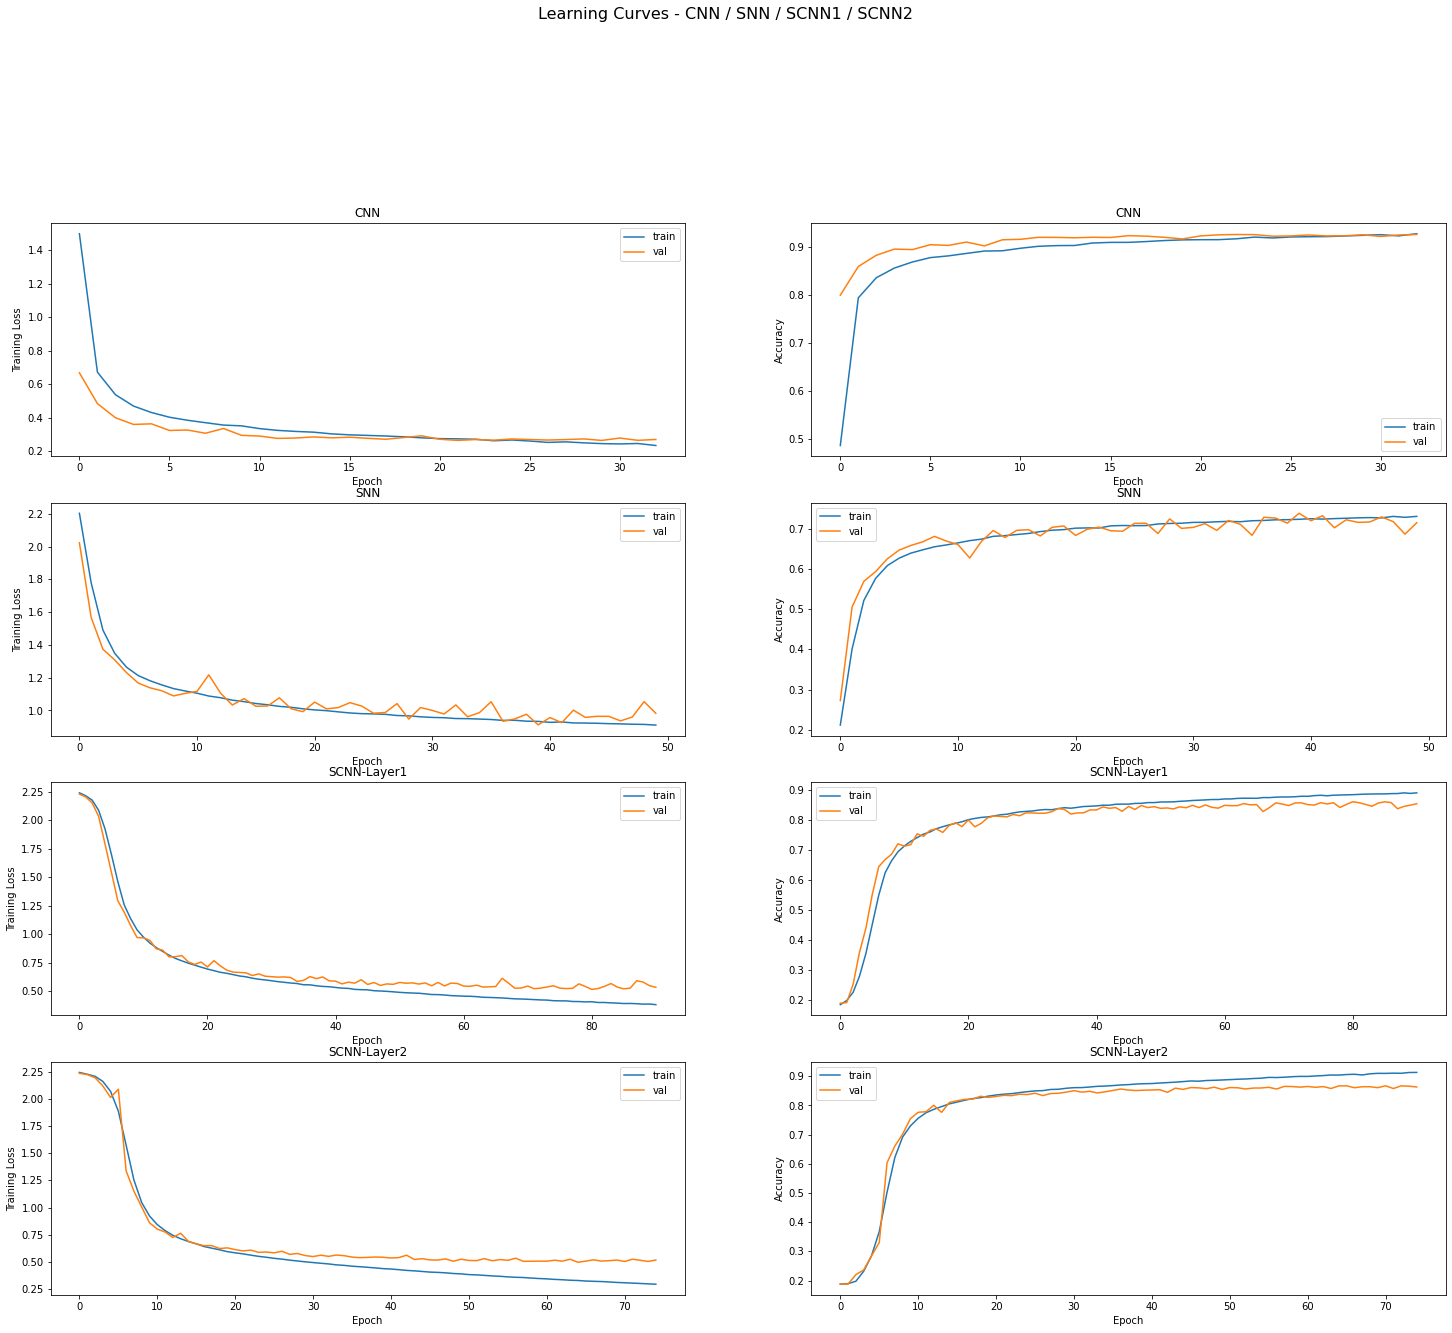

In [ ]:
fig = plt.figure()
fig.suptitle('Learning Curves - CNN / SNN / SCNN1 / SCNN2', fontsize=16)
fig.set_size_inches(25, 30)

plt.subplot(6, 2, 1)
plt.plot(loss_train_cnn, label='train');
plt.plot(loss_test_cnn, label='val');
plt.legend();
plt.title('CNN')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(6, 2, 2)
plt.plot(acc_train_cnn, label='train');
plt.plot(acc_test_cnn, label='val');
plt.legend();
plt.title('CNN')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(6, 2, 3)
plt.plot(loss_train_snn, label='train');
plt.plot(loss_test_snn, label='val');
plt.legend();
plt.title('SNN')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(6, 2, 4)
plt.plot(acc_train_snn, label='train');
plt.plot(acc_test_snn, label='val');
plt.legend();
plt.title('SNN')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(6, 2, 5)
plt.plot(loss_train_scnn1, label='train');
plt.plot(loss_test_scnn1, label='val');
plt.legend();
plt.title('SCNN-Layer1')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(6, 2, 6)
plt.plot(acc_train_scnn1, label='train');
plt.plot(acc_test_scnn1, label='val');
plt.legend();
plt.title('SCNN-Layer1')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(6, 2, 7)
plt.plot(loss_train_scnn2, label='train');
plt.plot(loss_test_scnn2, label='val');
plt.legend();
plt.title('SCNN-Layer2')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(6, 2, 8)
plt.plot(acc_train_scnn2, label='train');
plt.plot(acc_test_scnn2, label='val');
plt.legend();
plt.title('SCNN-Layer2')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

## Accuracy Evaluation on the Test Set

In [ ]:
# Evaluate CNN
svhn_model = get_CNN_model()
svhn_model = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/SVHN/CNN_SVHN.h5')
score, acc = svhn_model.evaluate(x_acc_test_cnn, y_acc_test, batch_size=128)
print ("Test Accuracy: %.5f" % acc)

In [ ]:
# Evaluate CNN on Extra Dataset
x_train_cnn_extra =np.load('/content/drive/My Drive/Colab Notebooks/SVHN/extra_data/x_train_cnn_extra.npy')
x_test_cnn_extra =np.load('/content/drive/My Drive/Colab Notebooks/SVHN/extra_data/x_test_cnn_extra.npy')
y_labels_train_extra =np.load('/content/drive/My Drive/Colab Notebooks/SVHN/extra_data/y_labels_train_extra.npy')
y_labels_test_extra =np.load('/content/drive/My Drive/Colab Notebooks/SVHN/extra_data/y_labels_test_extra.npy')

x = np.concatenate((x_train_cnn_extra, x_test_cnn_extra))
y = np.concatenate((y_labels_train_extra, y_labels_test_extra))

svhn_model = get_CNN_model()
svhn_model = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/SVHN/CNN_SVHN.h5')
score, acc = svhn_model.evaluate(x, keras.utils.to_categorical(y, 10), batch_size=128)
print ("Test Accuracy: %.5f" % acc)

In [ ]:
# Evaluate SNN
svhn_model = get_SNN_model(hidden_layers=180, name='SNN')
svhn_model = keras.models.load_model('SNN_SVHN.h5')
score, acc = svhn_model.evaluate(x_acc_test_snn, y_acc_test, batch_size=128)
print ("Test Accuracy: %.5f" % acc)

In [ ]:
# Evaluate SCNN
svhn_model = get_SCNN_model_layer1(channels=4)
svhn_model = keras.models.load_model('SCNN_SVHN.h5')
score, acc = svhn_model.evaluate(x_acc_test_cnn, y_acc_test, batch_size=128)
print ("Test Accuracy: %.5f" % acc)

In [ ]:
# Evaluate SCNN
svhn_model = get_SCNN_model_layer2(channels_l1=32, channels_l2=32)
svhn_model = keras.models.load_model('SCNN_SVHN.h5')
score, acc = svhn_model.evaluate(x_acc_test_cnn, y_acc_test, batch_size=128)
print ("Test Accuracy: %.5f" % acc)

## CNN Model Distillation - SNN

In [ ]:
# Load the model
svhn_model = get_CNN_model()
svhn_model = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/SVHN/CNN_SVHN.h5')
svhn_model.summary()

### Get the hard logits from the Teacher Model

In [ ]:
def get_logits(svhn_model, x_train, x_test):

  # Get the hard logits from the model
  svhn_model = Model(svhn_model.input, svhn_model.get_layer('logit').output)
  train_logits_hard = svhn_model.predict(x_train)
  test_logits_hard = svhn_model.predict(x_test)

  return train_logits_hard, test_logits_hard

### Adjust the Shallow Architecture to Export Logits

In [ ]:
def adjust_model(svhn_model, name):

  # Normal probabilities from logits before softmax activation
  logits = svhn_model.get_layer('logit').output
 
  # Now the model will output 10 dimensional logits
  output = logits
  svhn_model = Model(svhn_model.input, output, name=name)
  
  return svhn_model

### Load Data

In [ ]:
x_train_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/data/x_train_cnn.npy')
x_test_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/data/x_test_cnn.npy')

x_train_snn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/data/x_train_snn.npy')
x_test_snn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/data/x_test_snn.npy')

x_train_cnn_extra =np.load('/content/drive/My Drive/Colab Notebooks/SVHN/extra_data/x_train_cnn_extra.npy')
x_test_cnn_extra =np.load('/content/drive/My Drive/Colab Notebooks/SVHN/extra_data/x_test_cnn_extra.npy')

x_train_snn_extra =np.load('/content/drive/My Drive/Colab Notebooks/SVHN/extra_data/x_train_snn_extra.npy')
x_test_snn_extra =np.load('/content/drive/My Drive/Colab Notebooks/SVHN/extra_data/x_test_snn_extra.npy')

x_acc_test_snn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/data/x_acc_test_snn.npy')
y_labels_acc_test=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/data/y_labels_acc_test.npy')

### Training


In [ ]:
# Arrays with the results
scores_hidden_layers = []
hidden_layers_number = []

loss_val_hidden_layers = []
loss_train_hidden_layers = []

acc_val_hidden_layers = []
acc_train_hidden_layers = []

layers_to_test = [180, 512, 2000, 6000, 10000, 20000]

for hidden_layers in layers_to_test:
  # Set name
  name = 'SNN-SVHN-h'+ str(hidden_layers)
  svhn_model = get_CNN_model()
  svhn_model = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/SVHN/CNN_SVHN.h5')
  train_logits, test_logits = get_logits(svhn_model, x_train_cnn_extra, x_test_cnn_extra)
  svhn_model = get_SNN_model(hidden_layers=hidden_layers, name='SNN')
  svhn_model = adjust_model(svhn_model, name)
  svhn_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

  #Save trained SNN model
  svhn_model = train_snn(svhn_model, x_train_snn_extra, train_logits, x_test_snn_extra, test_logits, 'val_accuracy')

  # Learning Curves
  loss_train_cnn=svhn_model.history.history['loss']
  loss_val_cnn=svhn_model.history.history['val_loss']
  acc_train_cnn=svhn_model.history.history['accuracy']
  acc_val_cnn=svhn_model.history.history['val_accuracy']
  print ("")
  print (loss_train_cnn)
  print ("")
  print (loss_val_cnn)
  print ("")
  print (acc_train_cnn)
  print ("")
  print (acc_val_cnn)

  name_to_store = 'SNN_MIMIC_SVHN_h'+str(hidden_layers)+'.h5'
  svhn_model.save(name_to_store)
  print ('Model: '+name_to_store+' was saved')

  svhn_model = get_SNN_model(hidden_layers=hidden_layers, name='SNN')
  svhn_model = adjust_model(svhn_model, name)
  svhn_model = keras.models.load_model(name_to_store)

  output = svhn_model.layers[-1].output
  output = Activation('softmax')(output)
  svhn_model = Model(svhn_model.input, output, name=name)

  score = 0;
  preds = svhn_model.predict(x_acc_test_snn)
  for i in range (len(x_acc_test_snn)):
    if (np.argmax(preds[i], axis=0) == y_labels_acc_test[i]):
      score = score + 1

  score=score/26032.0
  print ("Test Accuracy: %.5f" % score)
  scores_hidden_layers.append(score)
  hidden_layers_number.append(hidden_layers)

  print ('----------------------------')

### Results

#### Accuracy Results - Adam

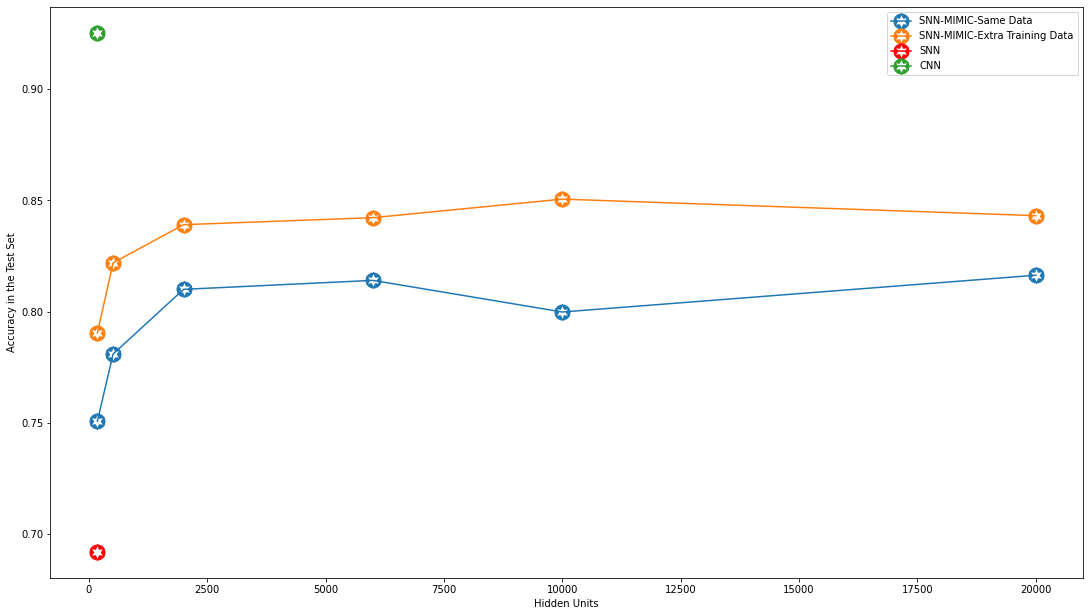

In [ ]:
import matplotlib.path as mpath
import numpy as np

star = mpath.Path.unit_regular_star(6)
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
verts = np.concatenate([circle.vertices, star.vertices[::-1, ...]])
codes = np.concatenate([circle.codes, star.codes])
cut_star = mpath.Path(verts, codes)

fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
plt.plot([180, 512, 2000, 6000, 10000, 20000], [0.75073, 0.78092, 0.81000, 0.81404, 0.79982, 0.81635], label='SNN-MIMIC-Same Data', marker=cut_star, markersize=15)
plt.plot([180, 512, 2000, 6000, 10000, 20000], [0.79041, 0.82191, 0.83908, 0.84223, 0.85057, 0.84314], label='SNN-MIMIC-Extra Training Data', marker=cut_star, markersize=15)
plt.plot(180, 0.69197, marker=cut_star, markersize=15, color="red" ,label='SNN')
plt.plot(180, 0.92528, marker=cut_star, markersize=15, label='CNN')
plt.xlabel('Hidden Units');
plt.ylabel('Accuracy in the Test Set');
plt.legend()
plt.show()

#### Accuracy Results - RMSProp

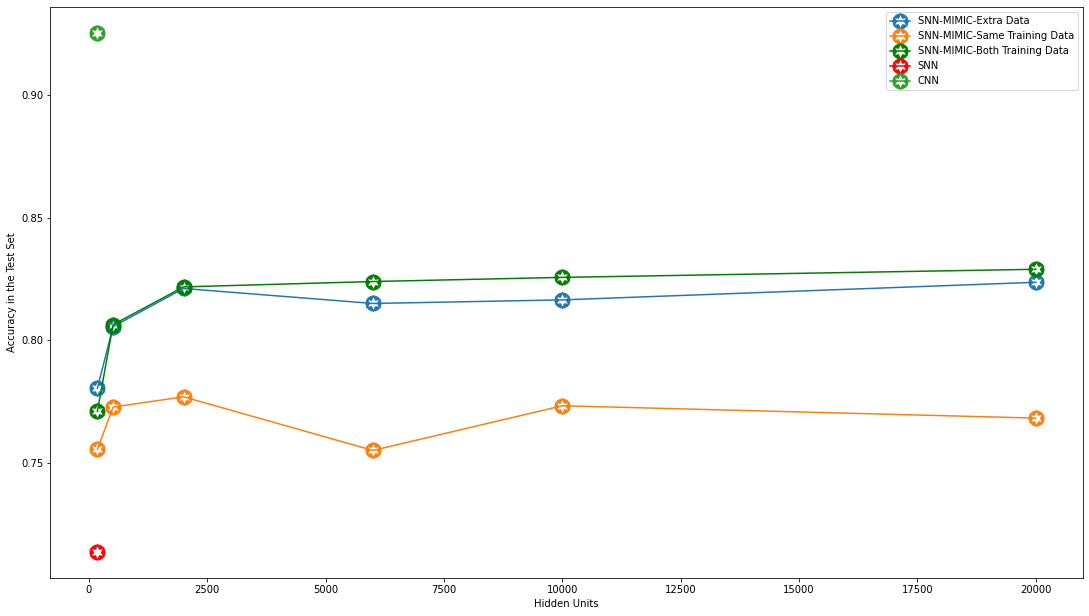

In [ ]:
import matplotlib.path as mpath
import numpy as np

star = mpath.Path.unit_regular_star(6)
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
verts = np.concatenate([circle.vertices, star.vertices[::-1, ...]])
codes = np.concatenate([circle.codes, star.codes])
cut_star = mpath.Path(verts, codes)

fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
plt.plot([180, 512, 2000, 6000, 10000, 20000], [0.78039, 0.80551, 0.82107, 0.81496, 0.81642, 0.82360], label='SNN-MIMIC-Extra Data', marker=cut_star, markersize=15)
plt.plot([180, 512, 2000, 6000, 10000, 20000], [0.75542, 0.77270, 0.77689, 0.75503, 0.77324, 0.76821], label='SNN-MIMIC-Same Training Data', marker=cut_star, markersize=15)
plt.plot([180, 512, 2000, 6000, 10000, 20000], [0.77094, 0.80632, 0.82172, 0.82391, 0.82560, 0.82890 ], label='SNN-MIMIC-Both Training Data', color="green", marker=cut_star, markersize=15)
plt.plot(180, 0.71366, marker=cut_star, markersize=15, color="red" ,label='SNN')
plt.plot(180, 0.92528, marker=cut_star, markersize=15, label='CNN')
plt.xlabel('Hidden Units');
plt.ylabel('Accuracy in the Test Set');
plt.legend()
plt.show()

#### Learning Curves for Same Data - Adam


In [ ]:
loss_train_180 = [32.30648176393232, 24.2385852448231, 19.895325029527925, 17.800091564515967, 16.537538841224126, 15.652767925231533, 14.96272203217451, 14.43993847326821, 13.99658759064809, 13.606278537017637, 13.335921146808433, 13.10346377217905, 12.891190648117567, 12.67066711376637, 12.537814232766268, 12.414087733973437, 12.268012420684238, 12.120181927804236, 12.064043055979345, 11.955020690910159, 11.878190524707668, 11.741791545554504, 11.730090568883561, 11.666042874455604, 11.563319059049256, 11.541337611290611, 11.446440163143624, 11.431104978641628, 11.366922894326425, 11.3028152821709, 11.271896527735164, 11.223241883196447, 11.228763051208361, 11.184941939341005, 11.137303033488143, 11.076933937407976, 11.073584890646309, 11.02521707912159, 11.03049594437178, 10.945416585533156, 10.989827415392105, 10.91979546673458, 10.890295310907728, 10.869931019826225, 10.843762419083635, 10.824115915105628, 10.838053742119014, 10.768981327004486, 10.757506217481374, 10.728027796218464, 10.715058338047141, 10.673310166554142, 10.700393221978594, 10.651086738644358, 10.617001383097726, 10.58388239212303, 10.586605525157138, 10.64285019107386, 10.605968818309801, 10.557906188196762, 10.576154347473357, 10.517430833309302, 10.502262539794833, 10.498782637184181, 10.484628266786189, 10.45127033996517, 10.505435443292674, 10.464212433012992, 10.442304949536277, 10.413253620425321, 10.426997878467882, 10.452639006022432, 10.337966879678763, 10.429155041603757, 10.349036029288106, 10.354098380444938, 10.38101539068301, 10.350510842787326, 10.316274495723253, 10.297045159435509]
loss_test_180 = [27.521333433063244, 21.04059414208798, 18.712260537612252, 16.86763720625644, 15.71309718596229, 15.244562598417732, 14.56057444329539, 14.048224719925198, 13.50967698744207, 13.351417012205548, 12.979402810278208, 12.793465170416388, 13.062137424115955, 12.925861061579408, 12.338692168866615, 12.280646979467093, 12.08110209446021, 11.835598057812756, 11.880685137166308, 11.924351581549534, 11.730969650837167, 11.862657394950714, 11.89028307482287, 11.503875277584575, 11.302782312820689, 11.791461057816573, 11.407874943615797, 11.2951751313768, 11.435396387119486, 11.408109965104403, 11.076758650265006, 11.126271487649204, 11.09750084118084, 11.646347157850377, 11.036532631670228, 11.121268274743082, 11.01436935042606, 11.411475155804608, 11.041221406985072, 11.138316697577066, 11.169521181042521, 10.848158722329979, 10.757398151550793, 11.034969137693214, 10.811709555777702, 10.838422193899527, 10.882124751635402, 10.761372414176789, 10.80067810008606, 10.955438571454005, 10.71768559922685, 10.89220045721339, 10.92556013632693, 10.648032094427968, 10.854806177023164, 10.566213030845065, 10.55695554554674, 10.777931497164056, 10.837042866070805, 10.772470194623667, 10.901347110091159, 10.479227740094858, 10.653322382569476, 10.592493945576603, 10.580841545846466, 10.662988251882142, 10.573182452808727, 10.504703769584903, 10.553475170099048, 10.494630221294765, 10.599493248554452, 10.409713481379246, 10.722765140965635, 10.572533647837679, 10.59920296732793, 10.471199646433487, 10.465868476307396, 10.532837946103175, 10.585862744222272, 10.720463533789415]
acc_train_180 = [0.22037369, 0.41685864, 0.53326505, 0.5906834, 0.62504905, 0.6527088, 0.6748742, 0.69110143, 0.7030629, 0.7117481, 0.7199556, 0.7242044, 0.7295282, 0.73452777, 0.7363706, 0.73862296, 0.743469, 0.74563605, 0.7477007, 0.75094277, 0.7505844, 0.7545773, 0.7550209, 0.7561471, 0.7593891, 0.7592185, 0.7614538, 0.7628359, 0.763655, 0.76519066, 0.76563436, 0.7677502, 0.7667776, 0.7672383, 0.77015615, 0.7702756, 0.7710946, 0.77162355, 0.77268153, 0.77379066, 0.7730228, 0.77512157, 0.7747632, 0.77592355, 0.7774251, 0.77611125, 0.77793705, 0.77839774, 0.7791485, 0.78030884, 0.7809573, 0.7817251, 0.7807184, 0.7819128, 0.7819128, 0.78288543, 0.7831243, 0.78165686, 0.78249294, 0.78450644, 0.7835509, 0.78498423, 0.78537667, 0.784387, 0.785189, 0.7867247, 0.78585446, 0.7858374, 0.7868782, 0.78646874, 0.7871171, 0.78756076, 0.7891136, 0.7875096, 0.78878933, 0.7891306, 0.78878933, 0.787885, 0.79013735, 0.79037625]
acc_test_180 = [0.3316270709037781, 0.505801260471344, 0.5606743097305298, 0.616844117641449, 0.6552006602287292, 0.6597051620483398, 0.6911001801490784, 0.7057057023048401, 0.7066612243652344, 0.7222904562950134, 0.7355992197990417, 0.7321867346763611, 0.7333469986915588, 0.7323232293128967, 0.7440622448921204, 0.7488397359848022, 0.7562107443809509, 0.7617390155792236, 0.7588042616844177, 0.7487714886665344, 0.7637182474136353, 0.763445258140564, 0.7548457384109497, 0.7682909965515137, 0.7686322927474976, 0.7611247897148132, 0.7719082832336426, 0.7673355340957642, 0.7711575031280518, 0.7749795317649841, 0.7792110443115234, 0.7796887755393982, 0.7773000001907349, 0.7642642855644226, 0.7771635055541992, 0.7770952582359314, 0.780439555644989, 0.7710210084915161, 0.7794157862663269, 0.7773000001907349, 0.7765492796897888, 0.7854900360107422, 0.7835108041763306, 0.7795522809028625, 0.7843980193138123, 0.7865138053894043, 0.7858995199203491, 0.7826917767524719, 0.7852170467376709, 0.7846027612686157, 0.7893803119659424, 0.7887660264968872, 0.7856947779655457, 0.7898580431938171, 0.7900627851486206, 0.7909500598907471, 0.7892438173294067, 0.7861725091934204, 0.7876057624816895, 0.7874692678451538, 0.7869232892990112, 0.7941578030586243, 0.7878105640411377, 0.7897897958755493, 0.7930657863616943, 0.7904040217399597, 0.7908135652542114, 0.792792797088623, 0.7882882952690125, 0.7961370348930359, 0.7936117649078369, 0.7917690277099609, 0.791359543800354, 0.7942942976951599, 0.7881518006324768, 0.7921102643013, 0.7914277911186218, 0.795045018196106, 0.7917007803916931, 0.7912912964820862]

loss_train_512=[31.65366129312547, 21.748510906609056, 17.676776114357136, 15.66750958166618, 14.310720857610963, 13.354206131599165, 12.651453836293118, 12.189752443214497, 11.72678157619909, 11.416137698746086, 11.153420123983981, 10.89209294998954, 10.686945439011517, 10.522072444317253, 10.43407769580311, 10.227695224932178, 10.173931252497697, 10.052466000893062, 9.960443755931674, 9.846198231583417, 9.773465036151862, 9.722378012308356, 9.609942967219824, 9.538963726093497, 9.47726309932282, 9.466142603924084, 9.404767018749327, 9.34987523588505, 9.29388596450354, 9.264336742820639, 9.19694085784683, 9.182978438419772, 9.143457448357415, 9.1500251661886, 9.03981784406899, 9.041298312162867, 9.005116223088812, 8.95703132234939, 8.927955699546702, 8.8828537574757, 8.877871705354577, 8.832426080670375, 8.85608367273887, 8.807543628299799, 8.784038989164145, 8.739470842529224, 8.737271488844845, 8.68470447390735]
loss_test_512 =[25.094944161663218, 18.826699520634914, 16.219671537600806, 15.164098956758716, 13.548117939123456, 12.877391885741304, 12.28744037132461, 11.737114307498333, 11.494318447378598, 11.250804004466113, 11.072379847741862, 10.639007371532243, 10.434634286264497, 10.442699573484562, 10.381073783793282, 10.219546161581837, 10.16886064064428, 10.113090385220397, 9.923118618906049, 10.147322529233808, 9.627412281041584, 9.570435625784976, 9.578880090060014, 9.586090181097124, 9.604092450341078, 9.616145090753513, 9.567357520994644, 9.849109435908105, 9.5479227009283, 9.497164255017763, 9.503871300687173, 9.247368004944947, 9.576824857861235, 9.322434204053657, 9.299728275614621, 9.362369363177125, 9.206712030498766, 9.066849736935644, 9.315949376736578, 9.133360365457037, 9.289743389615978, 9.222490715778756, 9.103608453726137, 9.029945802857828, 9.101352351108211, 8.977648350764843, 9.043576186386055, 8.9907795825097]
acc_train_512 =[0.23774423, 0.48355943, 0.5897108, 0.6482041, 0.6911868, 0.71449536, 0.7324972, 0.7428547, 0.7525467, 0.75979865, 0.76452523, 0.77150416, 0.7753434, 0.77964336, 0.78259534, 0.7850866, 0.7856326, 0.79018855, 0.79228735, 0.79576826, 0.79657024, 0.7975599, 0.80211586, 0.8000512, 0.80215, 0.80315673, 0.8048119, 0.80559677, 0.8070984, 0.80696183, 0.8098626, 0.8091972, 0.80907774, 0.809965, 0.8127634, 0.8115349, 0.8116714, 0.81319, 0.8144527, 0.81499875, 0.8153059, 0.8159201, 0.81556183, 0.8177459, 0.81800187, 0.81718284, 0.81829196, 0.8186844]
acc_test_512 = [0.35060060024261475, 0.5425880551338196, 0.6361588835716248, 0.662912905216217, 0.7099372148513794, 0.7323914766311646, 0.744881272315979, 0.7542315125465393, 0.7680862545967102, 0.7659705281257629, 0.7767540216445923, 0.7862407565116882, 0.7858995199203491, 0.7922468185424805, 0.791359543800354, 0.7858312726020813, 0.7962052822113037, 0.7955228090286255, 0.7919737696647644, 0.7975702881813049, 0.8052825331687927, 0.8089680671691895, 0.8081490397453308, 0.8047365546226501, 0.8118345737457275, 0.8027573227882385, 0.8099235892295837, 0.803712785243988, 0.812039315700531, 0.808080792427063, 0.8098552823066711, 0.8102648258209229, 0.8112885355949402, 0.8088315725326538, 0.8126535415649414, 0.8148375749588013, 0.8155882954597473, 0.825484573841095, 0.8190690875053406, 0.8194103240966797, 0.8170897960662842, 0.8159295916557312, 0.8220720887184143, 0.8215942978858948, 0.8210483193397522, 0.8207070827484131, 0.8233006000518799, 0.8202975988388062]

loss_train_2000 =[28.37553625875707, 18.540317353078624, 15.369891791843674, 13.662473429743416, 12.5269749726119, 11.713651249305185, 11.145969280994404, 10.738498926923478, 10.324074444877807, 10.024816164056267, 9.75616299671765, 9.560786462869572, 9.39599777745993, 9.140489126217975, 9.051785506743252, 8.869372960648716, 8.769504087327864, 8.598627780450203, 8.544447068864601, 8.391305918010486, 8.31011962194144, 8.27552134284651, 8.145559138477118, 8.091757782701034, 8.040356679504189, 7.94220376050103, 7.894004525772979, 7.794219585010576, 7.745071169073168, 7.723135659027686, 7.615752344251075, 7.6324347427930554, 7.575342444057056, 7.565563065618615, 7.450025455041017, 7.41029348612625, 7.3880614065003165, 7.362612372239634, 7.347803403427857, 7.247414007919985, 7.268771735816958, 7.1665064630914435, 7.189432262599331, 7.16255850778506, 7.09565856041187, 7.092552790199568, 7.065908964977422, 6.9961775128400605, 7.019255752000434, 7.013025121027349, 6.999954015258107, 6.849432386943946, 6.940198074051488, 6.869371277768705, 6.880414998788657, 6.784160915973924, 6.80473226197048, 6.804164894724979, 6.742612702776757, 6.751584666927219, 6.721983045978805, 6.738267990420188, 6.682464508228808, 6.705397031795611, 6.666329868913215, 6.661684811382751, 6.581001715435936, 6.646087893881536, 6.589254597614328, 6.5764038301635015]
loss_test_2000 = [21.216518338052687, 16.31139526867066, 14.23257363054097, 12.72572193697701, 11.623403290923815, 11.287062538994682, 10.659206821526006, 10.586135384947298, 10.420233877506407, 9.886106902186805, 9.71456155144319, 9.674986412835649, 9.206439169514807, 9.34080412008383, 9.537560548868266, 9.049820535208337, 8.914724686612466, 8.746109956995959, 8.86082602419425, 8.767129106076402, 8.761508272802638, 8.7064781550856, 8.544103507360344, 8.975900181128033, 8.102202965202405, 8.743507638577714, 8.321087086099828, 8.330326452887908, 8.163063141741844, 8.357378255660306, 7.972603617617904, 7.955210086917279, 7.972788101657636, 8.090357711593082, 7.790769582754141, 8.22262090195602, 7.761214735597136, 8.092391771597189, 7.807796518626254, 7.659515379948139, 8.003310913666004, 7.565560010623125, 7.993569195351899, 7.4954909669093475, 7.751188438185375, 8.031625212264002, 7.553796059376484, 7.7940394721524555, 7.799462584501533, 7.713010668722034, 7.583119087000542, 7.679184888380979, 7.808516065116922, 7.471819893115536, 7.550952416445237, 7.477984063130013, 7.748380609721132, 7.341661009865318, 7.712925039156519, 7.399005332085529, 7.667363626072389, 7.428162968682683, 7.517236947167158, 7.288133604683383, 7.35459892495291, 7.488225012505084, 7.873107001523063, 7.484295352963909, 7.4829004091413305, 7.88525632258943]
acc_train_2000 = [0.31579217, 0.5731081, 0.6610528, 0.7051958, 0.7324631, 0.7490146, 0.7624435, 0.7718966, 0.78020644, 0.78684413, 0.79194605, 0.796229, 0.8001365, 0.8054773, 0.8074738, 0.8093337, 0.8123368, 0.81518644, 0.815886, 0.8213122, 0.82086855, 0.8232062, 0.827182, 0.8261411, 0.8262264, 0.8280352, 0.830151, 0.8330518, 0.83259106, 0.832028, 0.8345875, 0.83562833, 0.83550894, 0.8364303, 0.8377101, 0.83936524, 0.8391093, 0.8396212, 0.8399795, 0.8409692, 0.84156644, 0.8434434, 0.84265846, 0.84366524, 0.84475726, 0.84561044, 0.84523505, 0.8464977, 0.8457811, 0.8462759, 0.84658307, 0.84909135, 0.8482041, 0.84946674, 0.84873307, 0.8496374, 0.84892076, 0.849791, 0.85105366, 0.8502176, 0.85057586, 0.85144615, 0.8523164, 0.8524358, 0.85190684, 0.8525552, 0.8534255, 0.8524187, 0.8532719, 0.85419333]
acc_test_2000 = [0.4941304922103882, 0.6327463984489441, 0.6897351741790771, 0.7296614646911621, 0.7545045018196106, 0.7622167468070984, 0.7789380550384521, 0.7824187874794006, 0.7838520407676697, 0.7908135652542114, 0.7927245497703552, 0.8047365546226501, 0.8089680671691895, 0.8105378150939941, 0.7953863143920898, 0.8137455582618713, 0.8176358342170715, 0.8218673467636108, 0.8144280910491943, 0.8217307925224304, 0.8230957984924316, 0.8183865547180176, 0.8196150660514832, 0.8200245499610901, 0.8329238295555115, 0.8271908164024353, 0.8297160863876343, 0.8323096036911011, 0.8302620649337769, 0.8315588235855103, 0.8358585834503174, 0.834152340888977, 0.8401583433151245, 0.8307398557662964, 0.8394075632095337, 0.8339475989341736, 0.841045618057251, 0.834152340888977, 0.8404995799064636, 0.8450040817260742, 0.837837815284729, 0.8430248498916626, 0.8381108641624451, 0.8409773707389832, 0.8336063623428345, 0.8387250900268555, 0.8426153659820557, 0.8423423171043396, 0.8370188474655151, 0.8458913564682007, 0.8447310924530029, 0.844321608543396, 0.8404995799064636, 0.8456183671951294, 0.8478023409843445, 0.8470516204833984, 0.8484166264533997, 0.8496450781822205, 0.8482800722122192, 0.8518291115760803, 0.8453453183174133, 0.8475293517112732, 0.8434343338012695, 0.8475293517112732, 0.8514196276664734, 0.8441168665885925, 0.8350395560264587, 0.8454135656356812, 0.8452088236808777, 0.8385885953903198]

loss_train_6000 = [28.944254137352765, 18.42095728049902, 15.181216397337128, 13.430711076422545, 12.316820706638518, 11.512638152332174, 11.02838238892768, 10.509340298020202, 10.234798284826319, 9.90520867732653, 9.658962017573876, 9.384109657732825, 9.182353412949402, 9.068350592506551, 8.874374053222146, 8.785891444942832, 8.629499622953903, 8.508391381091158, 8.417728258902155, 8.26369656679238, 8.114975891075854, 8.122979818896907, 7.98182898089296, 7.972537462146461, 7.863906054793339, 7.803444615879845, 7.697930157142902, 7.6695990776265095, 7.612050209715854, 7.537404488927319, 7.509976576416274, 7.433476908794189, 7.4116369878500254, 7.384533967061332, 7.257733381946851, 7.3062159860391445, 7.293521386349876, 7.173468224203492, 7.123682469957956, 7.1132776309032, 7.056481974153996, 7.042555052476799, 7.00546909015279, 6.988106276352102, 6.919352528178522, 6.957422813011633, 6.902644581205252, 6.843374178741341, 6.80858123528043, 6.788232101485669, 6.783647290322472, 6.709126486939768, 6.762971765491989, 6.6984076840937945, 6.681037955987516, 6.6485656658055765, 6.610946219427758, 6.600941502385838, 6.569739328717506, 6.622656869062455, 6.545322130206665, 6.541862820663628, 6.514469337170467, 6.543340275745507, 6.454648538706154, 6.448741297538386, 6.434741188228644, 6.418065528911939, 6.465084845775041, 6.375864911109918, 6.375701269132368, 6.377999296652947, 6.33133646781387, 6.364716518577196, 6.337589460289445, 6.311943917152021, 6.287973350042899, 6.226734383567366, 6.260949052363652, 6.230196453607404, 6.217038184796449, 6.244173281059139, 6.217368125321566]
loss_test_6000 = [21.372637766161937, 16.082181505645327, 14.040442044703061, 12.637663695449683, 12.418365938039285, 11.000695047631083, 11.000595209932444, 10.278372463358577, 9.958540957318347, 10.050962523882943, 9.554958874887044, 9.091120864145424, 9.148952742141027, 9.670494879655685, 9.201010805578333, 8.923511620463486, 8.773219726660393, 8.854090074356417, 9.066760436387913, 8.359620343587649, 8.595017341261771, 8.210918258325409, 8.517971480898346, 8.449582687271706, 8.176968557210428, 7.990015560767705, 8.16951932797756, 7.950789292913755, 8.00944914727988, 8.036206215091198, 7.927010704382111, 7.979458487492717, 8.05879607644525, 7.698369919456422, 7.939329296651513, 7.800774712917943, 7.719640065437128, 7.857103806520921, 8.053700027132567, 7.489500970291108, 7.7019352488526875, 7.7093355293128125, 7.723004852068935, 7.501127959274054, 7.396112557743665, 7.595945733055013, 7.686351043358547, 7.545251312458935, 7.430847890319116, 7.229845372829287, 7.501702812308339, 7.253715654816291, 7.296076462824033, 7.896794453234807, 7.234847673457273, 7.554369074185949, 7.260514421929045, 7.6286095683769295, 7.3445563783679475, 7.766042361648688, 7.355770953587421, 7.235797483999808, 7.111934938100138, 7.747502097333679, 7.35253533371934, 7.242883527861441, 7.21426574538843, 7.3406613674314825, 7.307165063211835, 7.198367745375783, 7.0964195960667364, 7.198097238897334, 6.975625932721079, 7.0341165190084105, 7.246785935827074, 7.085761086002843, 7.289439409247129, 7.104337254216233, 6.969534359113656, 7.1374137177026045, 7.806011281962476, 7.215508673577045, 7.512246282511385]
acc_train_6000 =[0.30983704, 0.5755994, 0.6658988, 0.7107926, 0.7376504, 0.7537582, 0.7654125, 0.774968, 0.78211755, 0.7891477, 0.793806, 0.79861784, 0.8034297, 0.80559677, 0.8094872, 0.8114325, 0.81390667, 0.81646615, 0.8179678, 0.8224554, 0.82411057, 0.82332563, 0.82801807, 0.8267895, 0.8297074, 0.83069706, 0.8308165, 0.83274466, 0.8342974, 0.8345363, 0.8360891, 0.8370105, 0.8364303, 0.83764184, 0.83917755, 0.83907515, 0.84141284, 0.8425902, 0.8435287, 0.84327275, 0.8449791, 0.844143, 0.84569573, 0.84561044, 0.84642947, 0.8463954, 0.84704375, 0.8483577, 0.84924495, 0.8483577, 0.8481358, 0.85004693, 0.8493132, 0.8505418, 0.8510878, 0.85139495, 0.85204333, 0.8521798, 0.8528453, 0.8525552, 0.85305005, 0.853033, 0.85330606, 0.85352784, 0.8549441, 0.8566675, 0.8540397, 0.85540485, 0.8545175, 0.8563433, 0.8555072, 0.856531, 0.8584421, 0.8560703, 0.8564286, 0.8567699, 0.85806674, 0.8581179, 0.8579302, 0.86040443, 0.85973895, 0.8592782, 0.8598584]
acc_test_6000 =[0.49399399757385254, 0.6448948979377747, 0.6947174668312073, 0.7337564826011658, 0.7407862544059753, 0.7752525210380554, 0.7740922570228577, 0.7853535413742065, 0.7956593036651611, 0.7992082834243774, 0.803712785243988, 0.8155200481414795, 0.8068522810935974, 0.8015970587730408, 0.8123123049736023, 0.8071935772895813, 0.8151788115501404, 0.8106743097305298, 0.8126535415649414, 0.8252798318862915, 0.8239830732345581, 0.8288970589637756, 0.8248021006584167, 0.8242560625076294, 0.8288970589637756, 0.8300573229789734, 0.8299208283424377, 0.829443097114563, 0.8324460983276367, 0.8271225690841675, 0.8344253301620483, 0.8353808522224426, 0.8282145857810974, 0.8366093635559082, 0.8377695679664612, 0.8374965786933899, 0.8431613445281982, 0.8374965786933899, 0.8343570828437805, 0.8438438177108765, 0.8368141055107117, 0.8375648260116577, 0.8368141055107117, 0.845072329044342, 0.8476658463478088, 0.8460960984230042, 0.8389980792999268, 0.8428201079368591, 0.8394075632095337, 0.848689615726471, 0.8470516204833984, 0.8447993397712708, 0.8456866145133972, 0.8372918367385864, 0.8473246097564697, 0.8401583433151245, 0.849440336227417, 0.8423423171043396, 0.8473928570747375, 0.8441168665885925, 0.8463690876960754, 0.8509418368339539, 0.8516926169395447, 0.8374965786933899, 0.8495085835456848, 0.85012286901474, 0.8456866145133972, 0.8484848737716675, 0.8463690876960754, 0.8527845740318298, 0.8523068428039551, 0.8516243696212769, 0.8550368547439575, 0.8525115847587585, 0.8482118248939514, 0.8482800722122192, 0.8405678272247314, 0.8460278511047363, 0.8549003601074219, 0.8502593636512756, 0.8412503600120544, 0.8518291115760803, 0.8501911163330078]

loss_train_10000 = [30.315619846757652, 19.553308786425244, 16.035718963329483, 14.144371011299684, 12.914179166662501, 12.04117012046708, 11.47665772601999, 10.956740100985247, 10.62285177240436, 10.208376651757732, 10.002086843775865, 9.721694648722497, 9.519462691996145, 9.33509948959266, 9.258530598241673, 9.056652071093366, 8.936701825189667, 8.826383637564243, 8.753847787852337, 8.613734367347172, 8.519277106477848, 8.43390869359984, 8.32107919354191, 8.36970922915808, 8.228003901912942, 8.215208462494733, 8.092754946714294, 8.072989409649884, 7.983976820786347, 7.94689155580566, 7.870502684383036, 7.801033946924899, 7.8043086360231335, 7.74400578186319, 7.750225214872351, 7.6396131029837715, 7.636168815206621, 7.60670821728758, 7.529671507033866, 7.52611569396547, 7.458880180007066, 7.438751769678126, 7.386705819409757, 7.419502113569455, 7.375682040451228, 7.315301447530603, 7.3231007410574565, 7.245038426775705, 7.228531978061384]
loss_test_10000 =[22.2816719864354, 17.10316534664603, 14.89933145420492, 13.169235159977843, 12.186257155124457, 11.835963569441162, 11.238133584349786, 10.92542423422207, 10.471183201474568, 10.438567730432126, 10.17562592032826, 9.565605638979434, 9.696039087356455, 9.672476577654647, 9.33977129704764, 9.287908604846052, 9.133728657138501, 9.118251757318454, 9.25156465124765, 8.731621826342666, 8.80438123646246, 8.411902581021462, 8.441001947154577, 8.604088873606772, 8.62144434936965, 8.299381409842168, 8.350767322553821, 8.23789846926415, 8.551676139784679, 8.360656954504707, 8.308116891492823, 8.257433350282128, 8.163519332488963, 8.197606212741977, 7.989224820784002, 7.956791530435215, 8.369772279845083, 8.080383380839905, 7.765903485527528, 8.308724675971304, 7.933850183338537, 7.944206421602433, 7.970645199504148, 8.138188412499956, 8.03882767000128, 7.69375392110368, 7.728778442072471, 8.050281933412961, 8.027657240035266]
acc_train_10000=[0.28028324, 0.5422063, 0.6401843, 0.6916816, 0.7215596, 0.7422745, 0.75522566, 0.7668458, 0.7748656, 0.7812303, 0.7864346, 0.79233855, 0.79815716, 0.8014675, 0.8023206, 0.8077809, 0.80984557, 0.8104769, 0.81255865, 0.8166027, 0.8181213, 0.82025427, 0.8213634, 0.8211245, 0.82324034, 0.8246907, 0.8272161, 0.8272332, 0.8278133, 0.8284788, 0.83073115, 0.8323351, 0.83221567, 0.83335894, 0.83378553, 0.83511645, 0.83535534, 0.83622557, 0.83583313, 0.83683985, 0.83788073, 0.83875096, 0.83963823, 0.83832437, 0.8391605, 0.8408156, 0.84131044, 0.84154934, 0.84252197]
acc_test_10000 =[0.4598689675331116, 0.6057876348495483, 0.669123649597168, 0.7209254503250122, 0.7439257502555847, 0.7527300119400024, 0.763035774230957, 0.7763445377349854, 0.7889025211334229, 0.791359543800354, 0.7906087636947632, 0.8030985593795776, 0.7966830730438232, 0.7951132655143738, 0.8065110445022583, 0.8116298317909241, 0.8172945380210876, 0.8118345737457275, 0.8155200481414795, 0.8202292919158936, 0.8202292919158936, 0.8256893157958984, 0.8339475989341736, 0.8261670470237732, 0.829443097114563, 0.8357220888137817, 0.8291701078414917, 0.8339475989341736, 0.8196150660514832, 0.8295113444328308, 0.8335380554199219, 0.8311493396759033, 0.834152340888977, 0.8334015607833862, 0.8383838534355164, 0.8342888355255127, 0.8293748497962952, 0.8406360745429993, 0.8442533612251282, 0.8361998200416565, 0.8389298319816589, 0.837837815284729, 0.8415915966033936, 0.8282145857810974, 0.8394758105278015, 0.8369506001472473, 0.84247887134552, 0.8348348140716553, 0.8427518606185913]

loss_train_20000 = [30.387807332593706, 18.846670625226285, 15.597180647826034, 13.86821827146037, 12.706623594936438, 11.82960804650507, 11.182901922902417, 10.67745763104825, 10.311099448381823, 10.01673607702152, 9.724214796039108, 9.514357504052581, 9.280815496201422, 9.05389852038057, 8.966776608611198, 8.828220391059917, 8.68495823946659, 8.547060631497425, 8.414739570995208, 8.254096151738736, 8.190718675154018, 8.152949385809396, 8.001548233980937, 7.942151289024447, 7.893934422305761, 7.826268919957863, 7.822371215175905, 7.661789067635082, 7.65529634862027, 7.549220435011764, 7.537902263528749, 7.428581753026076, 7.416095014509819, 7.378208318662647, 7.279485872062174, 7.317135370742867, 7.266154343287964, 7.209260052343388, 7.141767989603613, 7.160231004519202, 7.076228746339817, 7.06971872211896, 6.990926637601531, 6.976049642324468, 6.962437699266428, 6.896270844985393, 6.86919293859674, 6.867705288458965]
loss_test_20000 = [21.621081331665973, 16.47752537520375, 14.598844066331402, 13.17616299387864, 12.3172730222739, 11.413998853499661, 11.128831614505518, 10.45746925701836, 10.246715931758313, 9.816119977433988, 9.683699663564738, 9.712021006543292, 10.061732365334583, 9.020451294734704, 9.1470770235762, 8.810988197618256, 8.775861792703681, 8.566595812752505, 8.78901529767752, 8.317365411914114, 8.43438936418892, 8.358948424316123, 8.728873069840247, 8.550035506885559, 8.146149229684424, 8.230539594359193, 7.986873299575001, 8.001267080127363, 8.340595034475117, 8.217880204633191, 8.193232590729767, 7.785069946509842, 7.73373934300324, 7.793875408406925, 7.893706304532987, 7.909478104638493, 7.812018100531284, 7.761433524184627, 7.71696222580231, 8.089956697400984, 7.953847832410283, 7.612568286413578, 7.490389662885028, 7.780211915092458, 7.474910942023484, 7.739056970199014, 7.536863560693497, 7.395380681699461]
acc_train_20000 =[0.2959645, 0.5606689, 0.6526064, 0.6997696, 0.72664446, 0.74539715, 0.7602594, 0.7710264, 0.779012, 0.78655404, 0.79182667, 0.7966044, 0.8014163, 0.805392, 0.80887294, 0.81054515, 0.8133777, 0.8155959, 0.8176947, 0.8217729, 0.8222336, 0.8225578, 0.8265677, 0.8269431, 0.82747203, 0.829878, 0.82887125, 0.83298355, 0.8329494, 0.83525294, 0.83450216, 0.8369593, 0.8377101, 0.83678865, 0.8401672, 0.83898985, 0.8402184, 0.8420101, 0.84267557, 0.8415323, 0.8429656, 0.8431192, 0.84398943, 0.84494495, 0.8462759, 0.8466854, 0.8467025, 0.84685606]
acc_test_20000 =[0.48846572637557983, 0.6326781511306763, 0.6769724488258362, 0.7231094837188721, 0.7391482591629028, 0.7571662664413452, 0.7667894959449768, 0.7785967588424683, 0.7901310324668884, 0.795727550983429, 0.7998225688934326, 0.8020065426826477, 0.7856265306472778, 0.8189325928688049, 0.816407322883606, 0.8187277913093567, 0.8168168067932129, 0.8257575631141663, 0.8241878151893616, 0.8316270709037781, 0.8286240696907043, 0.8299208283424377, 0.8216625452041626, 0.8276686072349548, 0.8261670470237732, 0.8210483193397522, 0.8337428569793701, 0.8300573229789734, 0.830876350402832, 0.8300573229789734, 0.8243243098258972, 0.8374283313751221, 0.8409090638160706, 0.8347665667533875, 0.8377695679664612, 0.8357220888137817, 0.84247887134552, 0.8468468189239502, 0.84247887134552, 0.8359268307685852, 0.8372235894203186, 0.8404995799064636, 0.8432295918464661, 0.842888355255127, 0.8411138653755188, 0.8357220888137817, 0.8448675870895386, 0.8458913564682007]

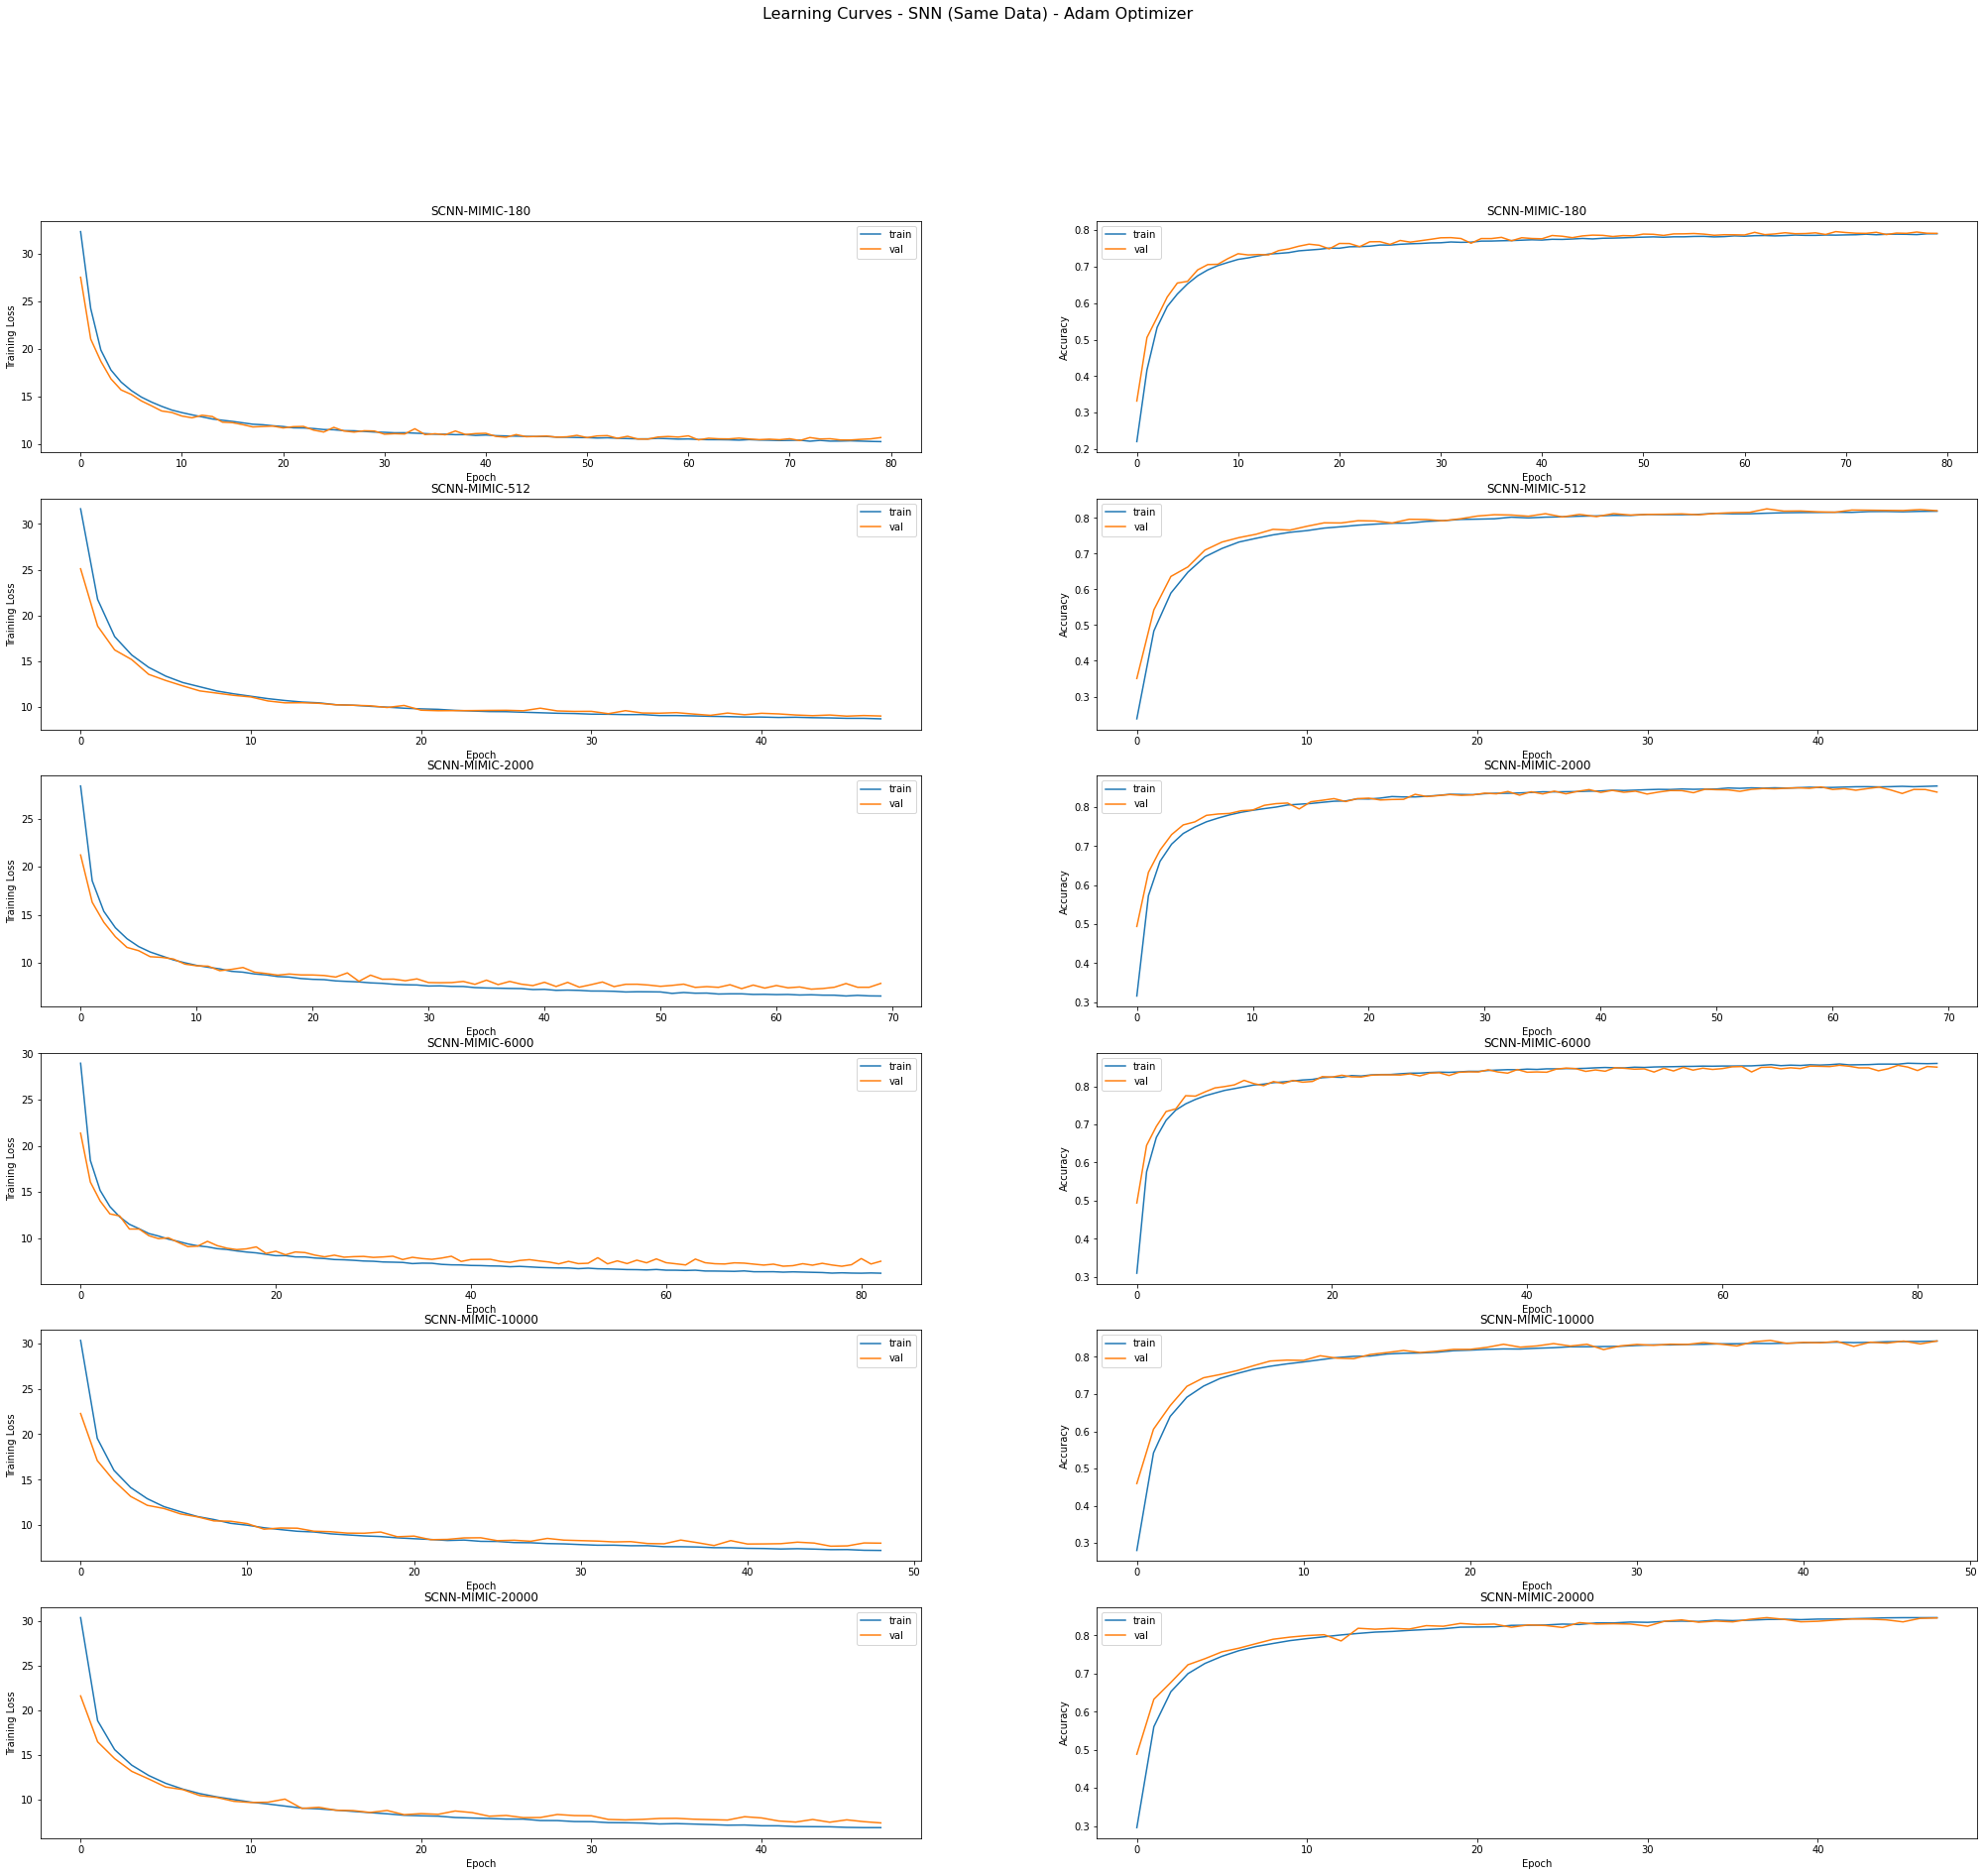

In [ ]:
fig = plt.figure()
fig.suptitle('Learning Curves - SNN (Same Data) - Adam Optimizer', fontsize=16)
fig.set_size_inches(35, 30)

plt.subplot(6, 2, 1)
plt.plot(loss_train_180, label='train');
plt.plot(loss_test_180, label='val');
plt.legend();
plt.title('SCNN-MIMIC-180')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(6, 2, 2)
plt.plot(acc_train_180, label='train');
plt.plot(acc_test_180, label='val');
plt.legend();
plt.title('SCNN-MIMIC-180')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(6, 2, 3)
plt.plot(loss_train_512, label='train');
plt.plot(loss_test_512, label='val');
plt.legend();
plt.title('SCNN-MIMIC-512')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(6, 2, 4)
plt.plot(acc_train_512, label='train');
plt.plot(acc_test_512, label='val');
plt.legend();
plt.title('SCNN-MIMIC-512')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(6, 2, 5)
plt.plot(loss_train_2000, label='train');
plt.plot(loss_test_2000, label='val');
plt.legend();
plt.title('SCNN-MIMIC-2000')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(6, 2, 6)
plt.plot(acc_train_2000, label='train');
plt.plot(acc_test_2000, label='val');
plt.legend();
plt.title('SCNN-MIMIC-2000')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(6, 2, 7)
plt.plot(loss_train_6000, label='train');
plt.plot(loss_test_6000, label='val');
plt.legend();
plt.title('SCNN-MIMIC-6000')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(6, 2, 8)
plt.plot(acc_train_6000, label='train');
plt.plot(acc_test_6000, label='val');
plt.legend();
plt.title('SCNN-MIMIC-6000')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(6, 2, 9)
plt.plot(loss_train_10000, label='train');
plt.plot(loss_test_10000, label='val');
plt.legend();
plt.title('SCNN-MIMIC-10000')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(6, 2, 10)
plt.plot(acc_train_10000, label='train');
plt.plot(acc_test_10000, label='val');
plt.legend();
plt.title('SCNN-MIMIC-10000')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(6, 2,11)
plt.plot(loss_train_20000, label='train');
plt.plot(loss_test_20000, label='val');
plt.legend();
plt.title('SCNN-MIMIC-20000')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(6, 2, 12)
plt.plot(acc_train_20000, label='train');
plt.plot(acc_test_20000, label='val');
plt.legend();
plt.title('SCNN-MIMIC-20000')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

#### Learning Curves for Same Data - RMSProp



In [ ]:
loss_train_180 = [32.40994685315992, 24.67341090884899, 20.647040339283503, 18.73396735570911, 17.48941296207326, 16.682148302981556, 16.115490322326213, 15.700228602169581, 15.31194189696698, 15.022394796520683, 14.771055694188226, 14.557436615854652, 14.345506846507085, 14.160662809560225, 13.958894313076394, 13.791833430757988, 13.635244954160207, 13.523137878100322, 13.395933845903409, 13.256404392589696, 13.16728319866687, 13.074269515708712, 12.9637618748587, 12.878826130438295, 12.77651755080147, 12.722629006890834, 12.643244767089355, 12.563957161891583, 12.492198244372627, 12.453284738682386, 12.405480030386249, 12.331424015710077, 12.282940696528845, 12.233303380034888, 12.169263544758781, 12.164700187264566, 12.085835071456644, 12.060714150679294, 11.985650261302174, 11.96176643208853, 11.924362334557417, 11.885275227839848, 11.880232857400754, 11.809616234184338, 11.775778490894332, 11.759584797560665, 11.735065488519954, 11.709319916337781, 11.671714720682482, 11.646984928958744, 11.598602491889265, 11.602268335817413, 11.556779849668603]
loss_test_180 = [28.097657667884338, 22.01939771424673, 18.81064581187605, 18.41197516545226, 16.4527546955268, 15.760321754072326, 15.403800237188566, 15.23748363512577, 16.16994417218149, 14.789843707666545, 14.746483450276976, 15.318423284717573, 13.332607963128783, 14.55990237080592, 13.93252257743625, 13.974954833172072, 14.475754113266321, 12.478412481855246, 13.140185282980847, 12.59614163345891, 14.302822457224236, 12.604148844698885, 13.363980062080152, 12.384085972583135, 13.155076757728354, 12.593749732096404, 13.906581439706363, 12.295609501258877, 12.140796381757456, 12.298120789211564, 12.698979626123677, 13.669201799601504, 11.584680943615346, 11.565063461201653, 11.478377408614225, 11.832167717071625, 12.022602793104884, 11.339204548682927, 13.484746013155018, 11.433463122653988, 12.20155518256085, 11.814873064277018, 11.077338109340559, 12.573673233450874, 11.83454746123451, 12.231145351856679, 12.018533276300953, 12.699990026748411, 11.072397989944262, 11.289158941389204, 11.146971480233924, 11.7723350381708, 11.851016009729351]
acc_train_180 =[0.2191792509395325, 0.40100674005246756, 0.510809657832236, 0.5688251856020028, 0.6065182152191899, 0.630236327969553, 0.6482211415784552, 0.6616329664358577, 0.6709837044539402, 0.676717003686936, 0.6862554389597887, 0.6918181042929129, 0.6959645081711613, 0.7013394761508606, 0.7032335124765583, 0.7096664107585257, 0.7115433836164312, 0.7144270966224078, 0.7176179506644262, 0.721679037641049, 0.7244944970677528, 0.7244433068433788, 0.7284361402915815, 0.7299035918792963, 0.7329238119512662, 0.7349031652823292, 0.7358245883111243, 0.7368995819754105, 0.7412336830962244, 0.7406194010912666, 0.7409777322987955, 0.7433154167773811, 0.7465233341570082, 0.7474788840054428, 0.7476495179826108, 0.7489463356460445, 0.7490145892151467, 0.7503625970185388, 0.7536728948591187, 0.7536387680394792, 0.7523248869184239, 0.7560617694634238, 0.754116542946915, 0.7569661291668148, 0.7577339817777692, 0.7560617695163108, 0.7585530245408865, 0.7612149133544744, 0.7587577852003913, 0.7599522225422091, 0.76254585787823, 0.7612319768029424, 0.7630577595859814]
acc_test_180 = [0.29101829098574683, 0.45788970789784394, 0.5410865410214527, 0.5804668305156467, 0.6310401309587707, 0.6436663936826658, 0.6609336608360284, 0.6803166802678641, 0.6536991536666096, 0.6921239422053026, 0.6949221948733787, 0.6897351896375572, 0.7220174720988325, 0.7029074527935483, 0.7069342068853907, 0.713554463440559, 0.7106197105871664, 0.7377149877312598, 0.735940485956758, 0.720515970597331, 0.717239967191151, 0.7376467377280981, 0.73252798243035, 0.7405132405946009, 0.7315042315367757, 0.7551870050731005, 0.7096642095503051, 0.7463827463502022, 0.755937755954028, 0.7446082445594283, 0.7463827463339301, 0.72454272442882, 0.767062517062517, 0.7631722630583586, 0.7700655200817922, 0.7570297569809408, 0.7581900080761036, 0.7742287742938626, 0.7373737374550978, 0.7702702703353586, 0.7574392573904412, 0.7620120119469237, 0.7798252798415519, 0.7433797434448317, 0.7654927655578538, 0.7558012556873512, 0.7594185093696931, 0.7451542451542451, 0.7723860224022945, 0.7727272727435448, 0.7635817636468519, 0.7721130219991176, 0.7634452633313589]

loss_train_512 = [31.93288518955923, 23.180111571768325, 19.6081406334502, 17.823629345847888, 16.664108137461564, 15.834963199402955, 15.231211295029011, 14.756137393706997, 14.34396752041056, 13.963811447323208, 13.672548547648253, 13.402265626148868, 13.167689717587894, 12.959341194820672, 12.804545824581238, 12.587673233715039, 12.484168743393585, 12.3227681255902, 12.21802260364122, 12.131126538873808, 12.011270806252595, 11.898909861861862, 11.827485502080476, 11.677961689851642, 11.6378017508529, 11.525087428412313, 11.493597433589626, 11.383301092030173, 11.324749788877124, 11.27949315938371, 11.211267859129642, 11.15975379375923, 11.088427570311449, 11.030308661368528, 10.961347773538678, 10.895421127581004, 10.881187240890895, 10.814679731686828, 10.801498363665088, 10.739594753341212, 10.70738838776093, 10.669490759548255, 10.601457220360174, 10.58540925277438, 10.536493596566048, 10.479443604575318, 10.437247067573443, 10.429315153489227, 10.392508494732944, 10.378378018380106, 10.34418562557213, 10.289601316550478, 10.276271582516314, 10.222899288932227, 10.175522560524499, 10.160532225159775, 10.148937871116246, 10.09876296916682, 10.10985780346059, 10.057402198162718, 10.020898438704195, 10.023623424230934, 9.993273040111454, 9.96389222296012, 9.94991067904741, 9.9003516458629, 9.912157494683546, 9.900025437124535, 9.86416076594739, 9.848652607999394, 9.800273324019184]
loss_test_512 = [26.39097216244509, 20.280138180811093, 18.739536621776917, 16.989097154696978, 16.562937116349552, 17.147558904299473, 16.425517009055064, 14.155391601731209, 15.662177940095802, 13.9950509200225, 13.148246903905054, 13.234941429692215, 13.054795639065162, 12.748902237548744, 13.074675580825826, 11.871327587401577, 14.12024119223788, 13.744768405657078, 13.39146230704401, 13.20871741023833, 10.848614406820012, 11.829221201893283, 12.208680857409227, 12.728962160673358, 10.806993337657781, 12.746903886308184, 10.951620450802197, 11.759850422866743, 11.548810822176797, 10.84415446856033, 11.940863283091218, 11.180665847222205, 10.91217378589777, 12.260042199924479, 11.842565396689276, 12.527907287687217, 10.458663052364415, 11.727817232349093, 10.637544222682543, 10.566876760571828, 10.941816423422907, 10.380578626350989, 11.143655478612601, 10.822436082242715, 10.562780948079677, 10.341454027390956, 11.347221567954257, 9.958739150263655, 11.234932919001599, 9.682405738143233, 9.995585167957985, 9.842695356749655, 10.293132227950496, 10.238485941625246, 10.693548948947699, 10.33039428014232, 10.100584502692696, 9.69994267576417, 10.894873983313925, 11.52418816665662, 9.548807020757552, 11.233101501641883, 10.614004930511316, 9.90115374670047, 9.82416424398503, 10.52241974178963, 9.709877153188845, 10.662685316701811, 10.517504043797798, 9.693539835018374, 9.762706572001273]
acc_train_512 = [0.23747120555599907, 0.4442624349061585, 0.5460796860661608, 0.5986690554945514, 0.6321986178714722, 0.6578448937458142, 0.6707106902639813, 0.6841395785769712, 0.6935073799540205, 0.7043426328323348, 0.7102977561417746, 0.7169866052547338, 0.7209282484205903, 0.7234536302912491, 0.7295623240042909, 0.7365583140953197, 0.7368142650300514, 0.7393055199651261, 0.7432812899770657, 0.7469669823892267, 0.7487245115573959, 0.7509256889771077, 0.7514887807841351, 0.7564883542644643, 0.7568808122336605, 0.7584165173731875, 0.7584847708751639, 0.7622216534781361, 0.7642351334772972, 0.7652589370056933, 0.7660950430891292, 0.767699001827253, 0.7697636720050206, 0.7722037369181156, 0.773790632253539, 0.7746949919376059, 0.7747803088636409, 0.7755822882362625, 0.7762477603811787, 0.778790205603685, 0.7784318743717465, 0.7793362341188711, 0.7822028837028232, 0.7824758980158459, 0.7844211244672631, 0.7831413701800862, 0.7840798566309057, 0.7860080197833624, 0.7872877740440958, 0.7872877740440958, 0.787031823251752, 0.7881921338247831, 0.7880044365100065, 0.7887552256338446, 0.7907857691414801, 0.7898131558252535, 0.7915194949256754, 0.7917754458288784, 0.7912294172557199, 0.7925944884760512, 0.7938571794184999, 0.7941643204545418, 0.7949833631840961, 0.7963825612240669, 0.7944202713363865, 0.796655575471998, 0.7974404914470045, 0.7959901032355466, 0.7972698574718706, 0.7977817592253895, 0.7995734152660853]
acc_test_512 =[0.32562107564548376, 0.5186322686322686, 0.5641550642689688, 0.6297433798410123, 0.6573846573521133, 0.6418918919244361, 0.6792929293254735, 0.7015424515099073, 0.6765629265303824, 0.692328692247332, 0.728228228179412, 0.7328009827521665, 0.7409227410041014, 0.7317089817903422, 0.7265902266064986, 0.7566202565714404, 0.715533715436083, 0.7243379742240698, 0.7302074801098477, 0.7403767402628358, 0.7725225224574341, 0.7569615070265953, 0.7542315041175996, 0.7332787331648287, 0.767949767949768, 0.7513650013650014, 0.7760032759381876, 0.7542997541858497, 0.763240513191697, 0.7734097732958688, 0.7592137592951196, 0.7562790062301901, 0.7794840295328458, 0.7511602511114349, 0.7570297569158524, 0.7536172535033491, 0.7891072892211937, 0.7658340159479204, 0.7890390391041274, 0.7856947856459694, 0.7781872781872782, 0.7904040403389521, 0.7873327872188828, 0.7650832649693605, 0.7712257711118666, 0.7983892983892984, 0.7667895168546052, 0.7980480481619526, 0.7869915370566253, 0.8045318044667162, 0.7971607970957089, 0.7992082992082992, 0.7916325417464463, 0.7901992901992902, 0.7832377833028715, 0.7806442805629202, 0.7929292929292929, 0.8082855583994629, 0.7768905267766223, 0.7837155337155337, 0.8119028119679003, 0.774911274927547, 0.7944307943657061, 0.8084220584871468, 0.8023478023478023, 0.7944307944470665, 0.8052143052143053, 0.7844662845313728, 0.7991400490912329, 0.8102648102648102, 0.8060333060821223]

loss_train_2000 = [32.17345724633891, 22.181250598875902, 18.82477362809882, 17.133536693051287, 16.101959391944533, 15.29884310190959, 14.713362288997804, 14.187397301716768, 13.745951875612278, 13.351769001432453, 13.02410523917689, 12.758733997991005, 12.481422678776013, 12.294453533020619, 12.115874264673735, 11.927504807439602, 11.805458584650316, 11.590699762631251, 11.488431588648, 11.349413816697584, 11.253867913659406, 11.12380230759366, 11.008755451993581, 10.93351037976034, 10.822412572648682, 10.7896350075102, 10.664317761715662, 10.61623877240635, 10.509206395604465, 10.439447366990954, 10.386180048531594, 10.29404771713844, 10.229873527401228, 10.185478286281013, 10.12890375495496, 10.07287196120389, 10.025382961367251, 9.9355290084434, 9.933143052403079, 9.86491269634889, 9.831515006735895, 9.776613320890176, 9.712375335149844, 9.694150924812801, 9.636704008136427, 9.595813510967353, 9.568938463017574, 9.525856801656191, 9.47112331245552, 9.438126126919048, 9.44419642133463, 9.35772022841764, 9.336960958395077, 9.308402628199293, 9.263567524966847, 9.230692852854414, 9.219436353897136, 9.200577718309855, 9.145448842230495, 9.128329509993522, 9.118985443889825]
loss_test_2000 = [24.487519833613966, 19.54703395561283, 17.960712835888312, 16.02784436132424, 15.791326373905033, 14.843540586866775, 13.021961220749864, 13.198504286517936, 13.102325551925771, 11.600038078291442, 12.05740253241245, 13.21899345797852, 12.993008166559726, 13.125774991730344, 11.074323738529289, 12.554497324115358, 12.532064108779577, 12.957010870841629, 11.482173345077893, 11.97064965545171, 11.275709662514243, 11.470296132834662, 10.229804285816439, 11.222530922667108, 13.474374495924675, 10.449693285374247, 10.766878853916895, 11.25194643261717, 11.36415659154402, 10.120983510924727, 10.039295969261943, 10.180438862320766, 10.322736460232456, 10.245016735107106, 10.188951110110855, 10.43476532418774, 10.122726012148428, 11.015765527542452, 11.606261283037215, 9.674006163211523, 10.396184200606578, 10.224626010016864, 9.926066826381158, 9.398737602275544, 9.705336184375376, 9.947821298974672, 9.382511805680942, 10.861354528734863, 11.16668136257179, 9.45604742910899, 9.226884847126012, 9.131730744593332, 10.432226724648066, 9.446792378635182, 9.322592701965299, 9.85299593862731, 9.385208253811006, 8.833573746739793, 10.73254665559086, 9.500010833563195, 9.70645173833307]
acc_train_2000 = [0.2521969115441188, 0.4753178056734087, 0.5697295452789504, 0.6159030798880805, 0.6473338452584405, 0.6655575463149584, 0.6805050763698601, 0.6955037965891294, 0.7067144441254747, 0.7118675881324699, 0.7201092056645925, 0.7254500468826245, 0.7347154679604332, 0.7367630747883874, 0.7404999573577967, 0.7463185734517358, 0.7490316525405507, 0.7550379660672453, 0.7557205016992776, 0.7576827915940774, 0.7616073713938477, 0.7645593379231588, 0.7661632966826408, 0.7690981998285756, 0.7697807354026357, 0.7722890538248265, 0.7742001536183162, 0.7744219776174638, 0.776350140815688, 0.7778858459074133, 0.7809060659865025, 0.7808548758292542, 0.7837897790189225, 0.7829366094676944, 0.7854961181071398, 0.78578619577201, 0.7867929358112559, 0.7914853681904517, 0.7903933111336358, 0.7902056138697119, 0.7921337770170832, 0.7936694821423713, 0.7952222506968034, 0.7922020305068549, 0.7958877228610437, 0.7968603361121787, 0.7961436737571272, 0.797525808329306, 0.7992492108273431, 0.7986519921213457, 0.8004948383142044, 0.8014162614325006, 0.8025083183611673, 0.8030884736431061, 0.8015186417103831, 0.803958706551267, 0.8056309188462882, 0.804487671755288, 0.8057674259966973, 0.8067229758044496, 0.8069447999673435]
acc_test_2000 =[0.38479388474506854, 0.5165165166304211, 0.6025798526123968, 0.6530166529841088, 0.6681681682007123, 0.6954681953705629, 0.7218809718321556, 0.7228364727225682, 0.7245427245589966, 0.7554600055250938, 0.7525252524113479, 0.7214032214357655, 0.7255664755176593, 0.7185367184879022, 0.7599645099156938, 0.7482937483588367, 0.7452224952387673, 0.7218809719460603, 0.7668577668089506, 0.7570297569321245, 0.7539585038934156, 0.7691782691782691, 0.7843297843786006, 0.783510783396879, 0.7442669942019059, 0.7856947857598741, 0.767676767741856, 0.7667895167895168, 0.768564018629107, 0.7870597869946987, 0.7929975430626314, 0.7828965328314446, 0.7684957684957685, 0.7760715260715261, 0.7928610428610429, 0.7977067978207023, 0.7936800436800436, 0.7806442806442806, 0.7745017743878699, 0.8030303030791193, 0.7934070434070434, 0.7826235326235326, 0.7921785420646376, 0.8106060607199652, 0.7966830465691421, 0.8056920558059603, 0.797979797979798, 0.7749795250446133, 0.7889707890846935, 0.808422058535963, 0.8242560743048906, 0.7972972972972973, 0.7871962871962872, 0.7975702976842022, 0.8073300573300574, 0.8007780507780508, 0.80166530173039, 0.8195468194817312, 0.8049413048762166, 0.8151105650454767, 0.8034398034398035]

loss_train_6000 = [34.71357087704135, 21.985540105791877, 18.64472199700288, 17.040271824352693, 16.000498867254596, 15.260785491392683, 14.668962953269872, 14.104389695410903, 13.624739418862958, 13.224811890397643, 12.921581868960196, 12.645914559176774, 12.372594432441888, 12.16911136102233, 11.90428925230991, 11.747097571052166, 11.582077124118602, 11.423477232621988, 11.272701741021583, 11.176857245508472, 11.022165471817301, 10.922829489768564, 10.78710871516575, 10.676108127457628, 10.623792189630711, 10.481416112051798, 10.408656347942133, 10.31739255359846, 10.2252853856031, 10.148597158310448, 10.067873958987635, 10.018646738966744, 9.93536038120069, 9.881024943796728, 9.844177722548494, 9.756840469344729, 9.714276433078496, 9.645515084215809, 9.588089667529276, 9.525097457752954, 9.47232360294701, 9.436927626497274, 9.39433429346344, 9.334808082147706, 9.288997143212566, 9.259555208987114, 9.215558038019461]
loss_test_6000 = [24.253251187436216, 19.925279599084835, 17.43487819074901, 16.012334095139728, 15.138647907651777, 14.943736166437239, 13.697054329512063, 14.172875631646384, 12.516844295915151, 14.387704185862832, 13.00409351956021, 13.379394473972264, 10.973641999328263, 11.732788609768438, 12.425724586957536, 11.367452227284991, 11.804770059088296, 13.022392392191053, 13.496453310992267, 11.523105540888706, 12.137849398724146, 10.213025644507006, 11.857254089763703, 10.68701199628667, 10.809628168481508, 9.958702723966281, 12.081143439353049, 10.256101781411344, 10.188521619510885, 10.11668666268905, 10.813034729849534, 10.088483996056743, 12.480724101960902, 9.340640719197925, 10.707015062009836, 9.692174317633034, 9.620049596906782, 10.350270764410512, 9.929881504380635, 10.315506734387197, 9.424738382791972, 9.193505774031172, 9.45823183536139, 9.84457125079264, 10.278158569804573, 9.756578449860577, 9.661044337662913]
acc_train_6000 = [0.2481358246132636, 0.4801808719260326, 0.5758553024404601, 0.6209538435205727, 0.6487159799028304, 0.6670420612809642, 0.6804026959811184, 0.6905895401650185, 0.7011005886452728, 0.7125671871163497, 0.7201262690937363, 0.7261325825990727, 0.73068850780345, 0.7353638767535019, 0.742581690978947, 0.7483320536217626, 0.7486221311879783, 0.753297500171593, 0.7551232829475126, 0.7586724682092646, 0.7621533998510616, 0.7643375138924824, 0.7673065438122892, 0.7693200239243437, 0.7720501663772108, 0.7744561044177792, 0.7744390410079595, 0.7777664022197109, 0.7785001280303498, 0.7786025083082323, 0.7833290674562148, 0.783909222817484, 0.7842846173361782, 0.7872024571373849, 0.7871000767486431, 0.7878338025328385, 0.7898984728814717, 0.7913488610085139, 0.7919119529528439, 0.7928333759745196, 0.794744475710037, 0.7951028069633336, 0.7962972442522643, 0.7970139066530835, 0.799965873242401, 0.7981059636641318, 0.8009896766314601]
acc_test_6000 =[0.43973518975959786, 0.5428610429749474, 0.5881108382247427, 0.6531531532670577, 0.6867321868135472, 0.6798389299365624, 0.6915779415453974, 0.6870051869075545, 0.7277504778155661, 0.6959459460273064, 0.7001774500798177, 0.7034534535185418, 0.7622850123501006, 0.7286377285889124, 0.7377832377995098, 0.7689735190386073, 0.7482254982905866, 0.7398307397819236, 0.7113704612728289, 0.7723860224999269, 0.7504095004095004, 0.7843980343980343, 0.7608517608517609, 0.7787332788471834, 0.7763445263445263, 0.7801665302804348, 0.750955500955501, 0.7871962871962872, 0.7867185367185368, 0.783988533988534, 0.7739557740208622, 0.8005050504887784, 0.7694512695326299, 0.803303303238215, 0.7884930385418547, 0.7927245426594544, 0.8185913187052232, 0.7815315314664432, 0.8022795523934568, 0.7884930385418547, 0.8003685504824549, 0.8107425607425608, 0.8058285559424604, 0.8022795522795523, 0.7947037947037947, 0.7920420419606816, 0.7982527982527983]

loss_train_10000 = [38.96227062219809, 22.324077405458464, 18.961470725127285, 17.222390191041, 16.156610373060975, 15.380950023871458, 14.756377007645781, 14.16598519474235, 13.757102938872455, 13.346465992998745, 12.999792768483113, 12.724233993313518, 12.44718171690788, 12.237402492370553, 12.040891168345548, 11.806893399790807, 11.665282288115135, 11.497546777496586, 11.319631641678574, 11.202597137547508, 11.097512613271611, 10.98182896382267, 10.838537732461097, 10.77341795972504, 10.675463847708818, 10.529361683080937, 10.4728841818393, 10.393759433995964, 10.291831950915164, 10.201923591591639, 10.15370086360411, 10.052401147833782, 10.004335768199823, 9.942760823515634, 9.885352549875527, 9.855462662171467, 9.747011050310633, 9.711617369432517, 9.657196885824876, 9.599506518430102, 9.548303335264837, 9.520368979536789]
loss_test_10000 = [24.981303021584317, 19.33990265390374, 18.77929740664154, 16.01945089636492, 16.537690873683687, 15.316971314919961, 15.793955558185333, 15.232563730865238, 12.536294028500603, 14.399372673607445, 13.002689652647309, 12.240598719724696, 14.934547051750764, 11.076164248990063, 11.961400264018291, 12.285133415449197, 10.729326757420095, 12.256398410833569, 10.496707507505008, 11.707739500149398, 10.707562223992126, 12.071690830935749, 11.098212160635867, 11.834374681379572, 10.377994958084527, 10.749769172803841, 10.342344501713017, 10.037462875487014, 10.889735957361003, 9.818316617429891, 10.351676943000795, 10.363678861894538, 9.55736848860857, 10.440184831163645, 9.67316074537964, 10.15209295109846, 10.742856343066533, 10.145647453799652, 10.26846045364684, 10.211959449899284, 11.226139046994188, 10.522610825005692]
acc_train_10000= [0.2418223700840902, 0.471154338339573, 0.567750191909239, 0.618223701041262, 0.6469584505973583, 0.6664619060305542, 0.6791741318989915, 0.6913744560749333, 0.7029604982164225, 0.7129425817143743, 0.7200921423249497, 0.728726217889326, 0.7331626994710928, 0.7378380683824965, 0.742428120450247, 0.7459431788608306, 0.7501919631593494, 0.7554645508367569, 0.7586042146544013, 0.7611125331030355, 0.7634672809843215, 0.765634331589479, 0.7688251855155529, 0.769371214064302, 0.7729886529002414, 0.7745755482163408, 0.7770156130043376, 0.7770156129534848, 0.779148536777651, 0.7816568552527287, 0.7840457299292448, 0.7846258851532114, 0.7866052384507116, 0.7856326252504294, 0.7876290419068965, 0.7891135569064652, 0.7922532207190243, 0.7902568039903461, 0.7941301936715163, 0.7931063902753377, 0.7935159116665583, 0.7950345533749072]
acc_test_10000 =[0.3813813813488372, 0.5333060332409449, 0.6044908544745824, 0.6468058968221689, 0.6286513785537462, 0.6818864318050715, 0.6715806714830391, 0.6567704068517672, 0.7240649741463345, 0.7044772044934766, 0.7143734644548247, 0.7481572480596157, 0.6844116843791402, 0.7704750204099321, 0.7446764946764947, 0.7354627355278238, 0.7616025115374233, 0.7279552278575955, 0.7827600328251211, 0.7609882608743564, 0.7780507780019618, 0.7598962599613482, 0.7710210210861094, 0.7754572754084592, 0.7736145235494353, 0.7710210210698373, 0.7804395303744421, 0.7975702975540255, 0.7591455091455092, 0.7904722904072021, 0.7906087907226952, 0.8023478022338978, 0.7902675401536357, 0.7840567840079679, 0.8015970517109562, 0.7893120393771277, 0.7781872781872782, 0.7871280371280371, 0.7804395305534351, 0.7968877970017014, 0.7796887797538681, 0.7794840294189411]

loss_train_20000 = [53.05933234816311, 22.45693905601505, 19.005532778233924, 17.268503886804513, 16.180398794811605, 15.380713691187438, 14.720792227358492, 14.146439054420952, 13.69276592920852, 13.280326021023756, 12.928295864752561, 12.690942493175426, 12.41511335181718, 12.199215060376376, 12.018743267503577, 11.80429368453184, 11.640853421296105, 11.501017071030956, 11.339074689391408, 11.175996811460507, 11.104642719828261, 10.926489531067327, 10.834829157870049, 10.737090571823101, 10.621666685943564, 10.557415664148213, 10.451609526062143, 10.363287263412483, 10.267970087503617, 10.227702817663825, 10.170534087110223, 10.080405204616078, 10.029532690872442, 9.926692748673895, 9.87244125257508, 9.82088703985111, 9.762482447282881, 9.69118025963364, 9.632901957222, 9.572183203129686, 9.531794160983331, 9.47837154140103, 9.451180489459306]
loss_test_20000 = [25.389792581090113, 20.836312110457236, 19.12150039225044, 15.639603321649258, 15.741366215882131, 14.548957902552683, 13.786721713550097, 13.483062253114209, 13.374508815810161, 13.044910102862984, 14.31046251114229, 11.440141680980686, 11.950937653577233, 13.394608706683368, 12.099709116628253, 11.265679529186418, 12.461092291261016, 11.694114817318095, 11.462090876269725, 10.469036727403312, 9.96992173977247, 12.863139251981835, 10.774407696860624, 9.682231784875752, 9.948818245840112, 9.949841821646059, 11.688378434802155, 9.852501833012544, 10.40441236253843, 9.668424890108392, 10.133623248659259, 10.24458443347203, 9.231946437761753, 9.545459455197996, 9.829285497194165, 11.016847981737508, 9.541870755313557, 10.177659290395992, 9.307189144204296, 10.424231043156137, 9.601584740164109, 11.31956300883875, 9.427639271827008]
acc_train_20000 = [0.2414811022909578, 0.46538691236626806, 0.5656855217192668, 0.614077297150809, 0.6444160054379097, 0.6658646873174374, 0.6807439638490045, 0.6937803941683887, 0.7048886613932885, 0.7123112361958568, 0.7223786366391676, 0.7258766316907844, 0.7342206296238535, 0.7385547308026397, 0.7432983534062095, 0.7477177715496789, 0.7510792594458013, 0.7540312259629077, 0.7563859739214901, 0.7628871256281375, 0.7612661035259616, 0.7658732189597982, 0.7678355089440991, 0.7699513693075927, 0.7727838921420821, 0.7752410203877005, 0.7753604641791426, 0.7772545004783967, 0.7818104257478657, 0.7807524955228942, 0.7833120040850432, 0.7849500895919537, 0.785820322456381, 0.7882603873745613, 0.7881750704414069, 0.7890794300654674, 0.7917413189899147, 0.7933623410870054, 0.7933111509612859, 0.7937206723525067, 0.7946079686582825, 0.7974404913890322, 0.7963654978071277]
acc_test_20000 =[0.3882746382990464, 0.47392847389592974, 0.567977067960796, 0.6587496587171146, 0.6489898990224432, 0.680180180147636, 0.7291154790666629, 0.7061834562648166, 0.7251569752220635, 0.7244062242923198, 0.6966966965827921, 0.7576440075301031, 0.7383974884137605, 0.725566475468843, 0.7520475019986858, 0.7487714987877708, 0.7424242423103379, 0.7513650014300897, 0.7565520064869182, 0.7754572753433708, 0.7895850396501279, 0.7628310127821966, 0.7650150149499266, 0.8003685504824549, 0.7986622987762032, 0.8025525524874643, 0.7450859950371789, 0.7972290473429519, 0.7839202838063793, 0.7940212940212941, 0.7834425333774451, 0.7794157793018748, 0.8081490581978744, 0.8080125581264626, 0.7861042861042861, 0.7824187824838708, 0.8076030577169622, 0.7868550369201252, 0.8054873054222171, 0.787674037739126, 0.7808490307351262, 0.7821457821945984, 0.7688370187719304]

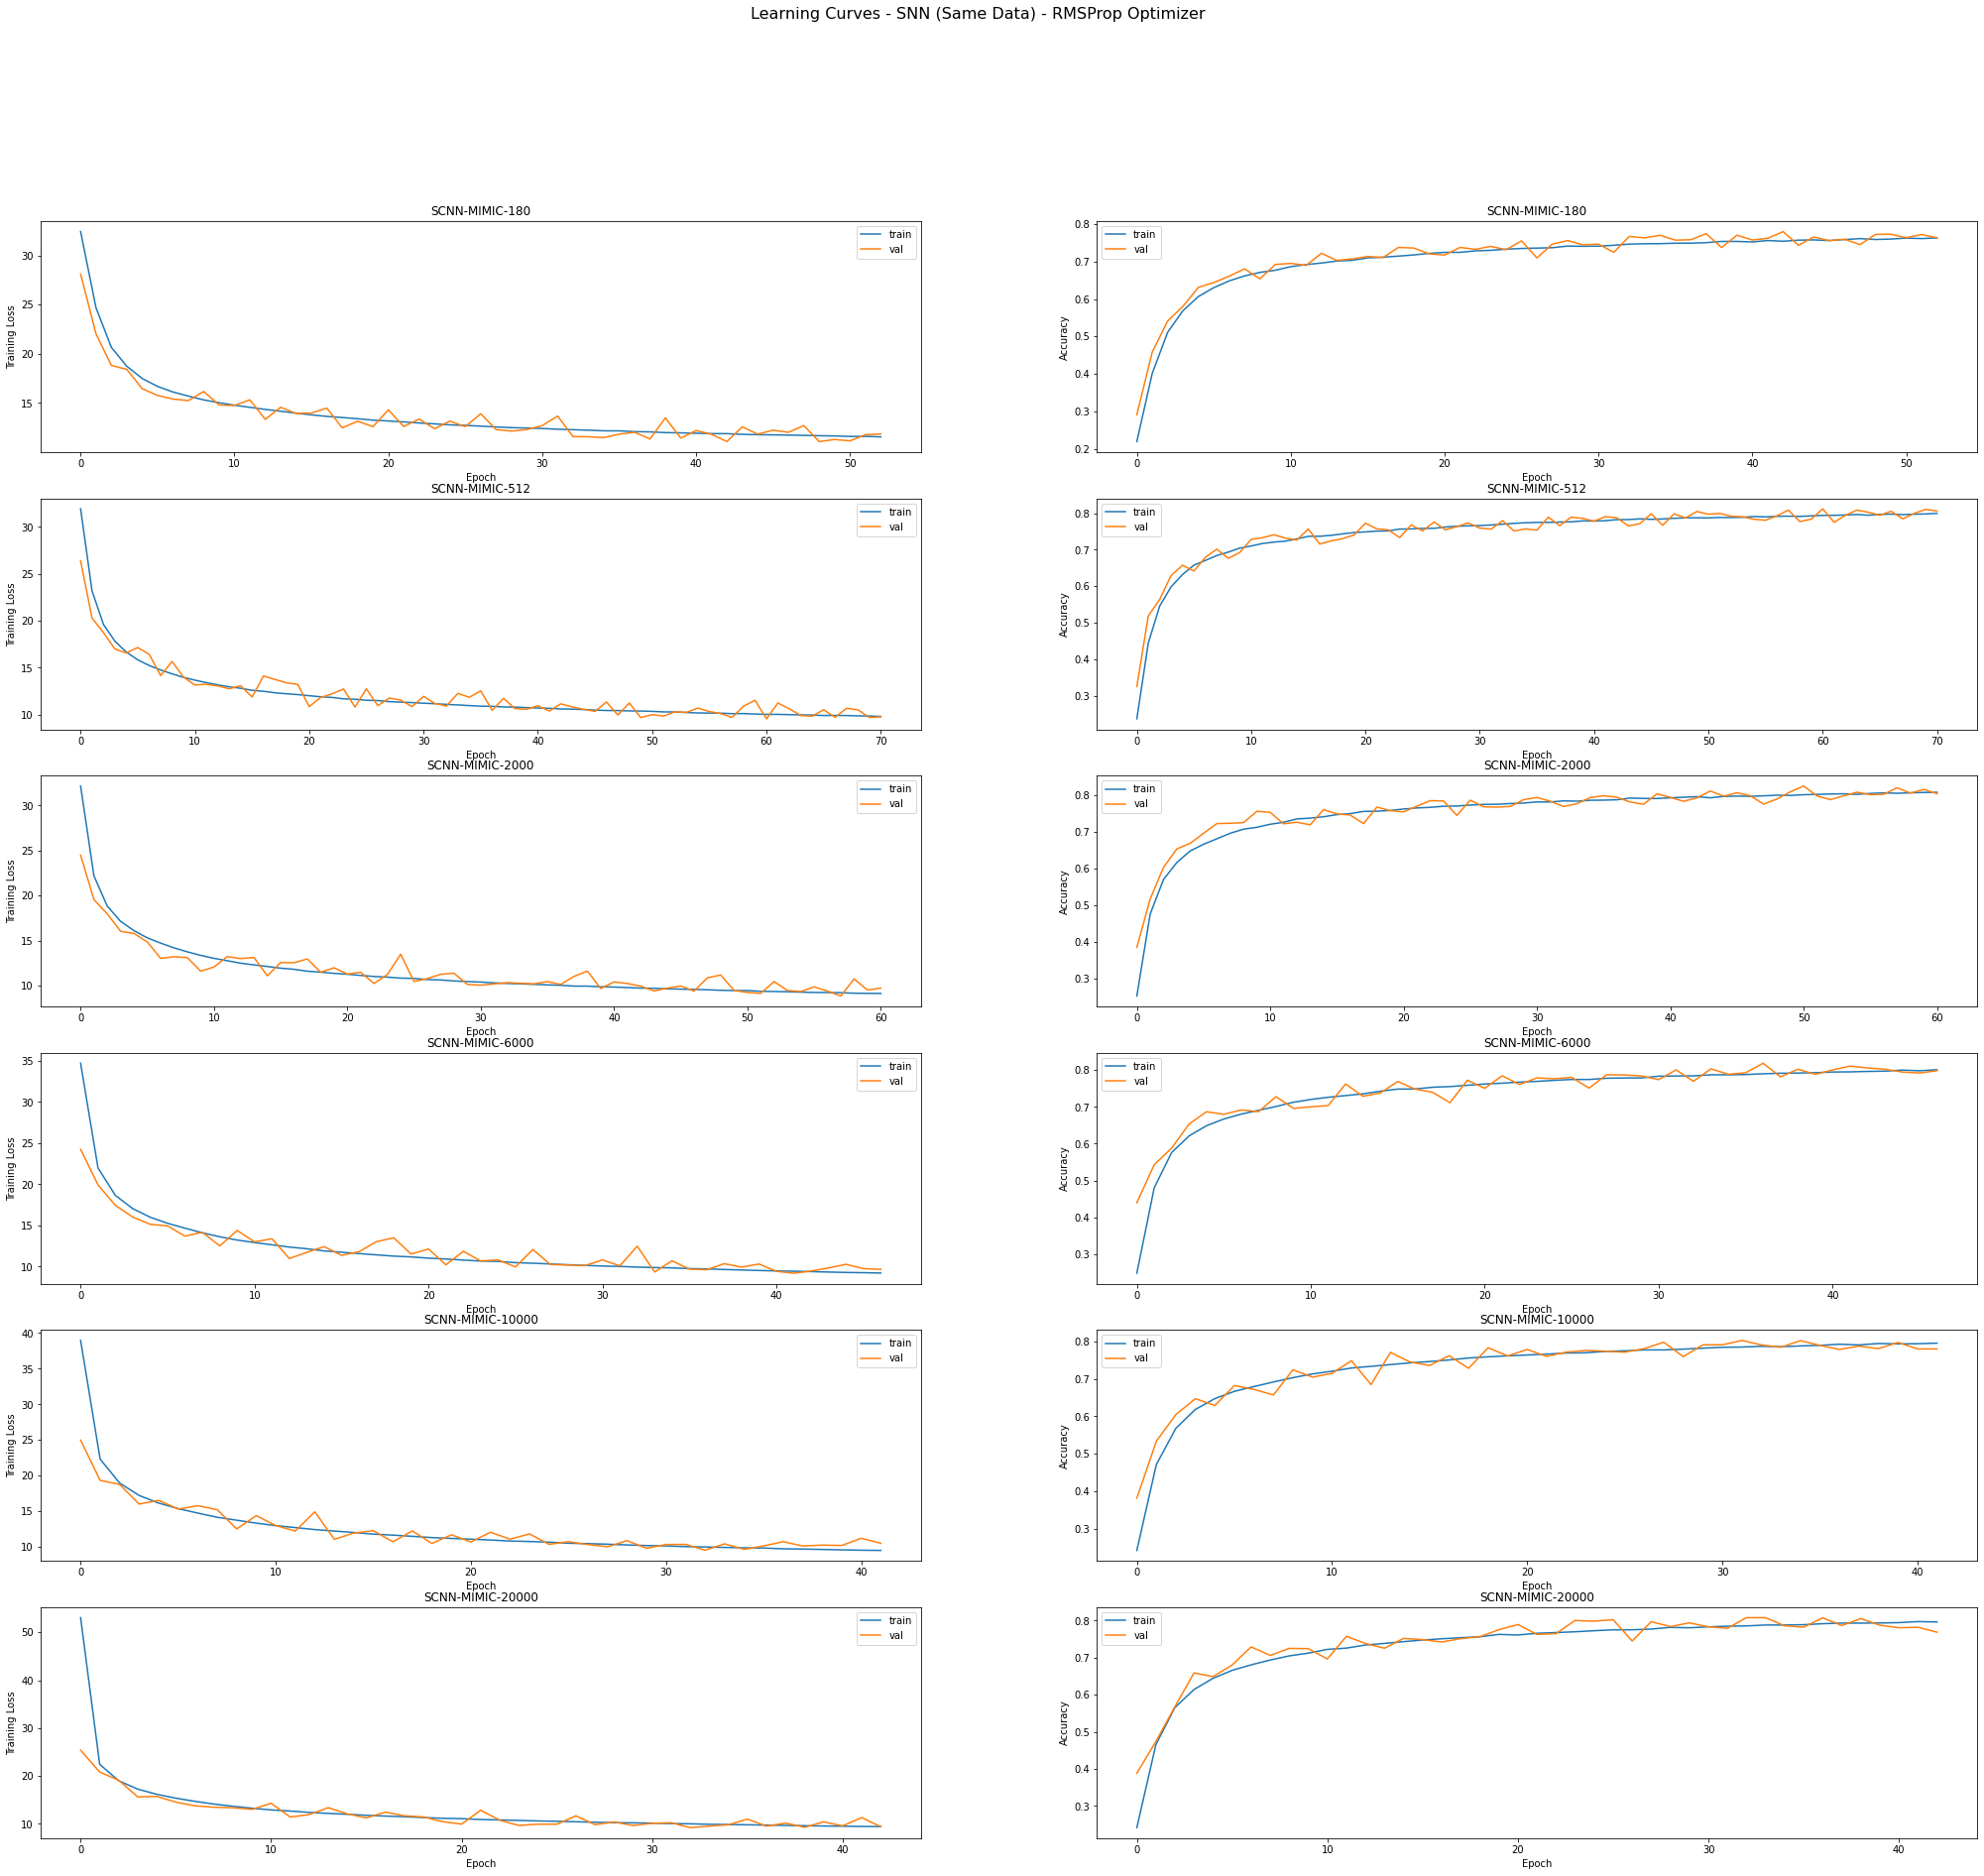

In [ ]:
fig = plt.figure()
fig.suptitle('Learning Curves - SNN (Same Data) - RMSProp Optimizer', fontsize=16)
fig.set_size_inches(35, 30)

plt.subplot(6, 2, 1)
plt.plot(loss_train_180, label='train');
plt.plot(loss_test_180, label='val');
plt.legend();
plt.title('SCNN-MIMIC-180')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(6, 2, 2)
plt.plot(acc_train_180, label='train');
plt.plot(acc_test_180, label='val');
plt.legend();
plt.title('SCNN-MIMIC-180')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(6, 2, 3)
plt.plot(loss_train_512, label='train');
plt.plot(loss_test_512, label='val');
plt.legend();
plt.title('SCNN-MIMIC-512')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(6, 2, 4)
plt.plot(acc_train_512, label='train');
plt.plot(acc_test_512, label='val');
plt.legend();
plt.title('SCNN-MIMIC-512')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(6, 2, 5)
plt.plot(loss_train_2000, label='train');
plt.plot(loss_test_2000, label='val');
plt.legend();
plt.title('SCNN-MIMIC-2000')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(6, 2, 6)
plt.plot(acc_train_2000, label='train');
plt.plot(acc_test_2000, label='val');
plt.legend();
plt.title('SCNN-MIMIC-2000')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(6, 2, 7)
plt.plot(loss_train_6000, label='train');
plt.plot(loss_test_6000, label='val');
plt.legend();
plt.title('SCNN-MIMIC-6000')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(6, 2, 8)
plt.plot(acc_train_6000, label='train');
plt.plot(acc_test_6000, label='val');
plt.legend();
plt.title('SCNN-MIMIC-6000')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(6, 2, 9)
plt.plot(loss_train_10000, label='train');
plt.plot(loss_test_10000, label='val');
plt.legend();
plt.title('SCNN-MIMIC-10000')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(6, 2, 10)
plt.plot(acc_train_10000, label='train');
plt.plot(acc_test_10000, label='val');
plt.legend();
plt.title('SCNN-MIMIC-10000')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(6, 2,11)
plt.plot(loss_train_20000, label='train');
plt.plot(loss_test_20000, label='val');
plt.legend();
plt.title('SCNN-MIMIC-20000')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(6, 2, 12)
plt.plot(acc_train_20000, label='train');
plt.plot(acc_test_20000, label='val');
plt.legend();
plt.title('SCNN-MIMIC-20000')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

#### Learning Curves for Extra Data - Adam


In [ ]:
loss_train_180 = [19.577032668893143, 12.56790239950593, 11.435943497398192, 10.929228197984461, 10.634141144772164, 10.428816896959706, 10.267572028131529, 10.15350637753188, 10.055494300553272, 9.970678298135299, 9.906052955333113, 9.849598037025636, 9.790466780250725, 9.745238647592373, 9.704311568684107, 9.66352096710096, 9.625120825973378, 9.602259177501574, 9.582466445438625, 9.558713170626637, 9.526130251045666, 9.506486920405644, 9.476437619999531, 9.451654384934011, 9.443974308609107, 9.421129148110985, 9.401024904283958, 9.38787843163294, 9.369706193533489, 9.357042486755212, 9.342382900694181, 9.329460636672053, 9.31075889976751, 9.289398768655914, 9.28455563200965, 9.265830020855343, 9.259191034240274, 9.234318078214006, 9.239182200686882, 9.222014041050475, 9.215564930375926, 9.209926160114948, 9.199228566886005, 9.176415382425331, 9.173377048252616, 9.170511452539822, 9.158445015073557, 9.154734597631572, 9.156589285820521]
loss_test_180 = [13.716550698250215, 11.761762422649285, 11.297882041393208, 10.64153737941141, 10.40400525737076, 10.433561030676449, 10.152550242480382, 10.04462218548327, 9.93215698977569, 10.17022806042256, 9.960597227204774, 9.883764419121862, 9.808428368022621, 10.083247338622247, 9.578362071358255, 9.68753330564827, 9.965047072067877, 9.776933042089624, 9.932672701190162, 9.66050197614749, 9.43996431663545, 9.503990807497757, 9.485817016264647, 9.97736630885995, 9.55077060802096, 9.545027171087394, 9.535618992274298, 9.408830481658182, 9.67453989005427, 9.390448886024165, 9.391771955237928, 9.466788924275571, 9.325959038651169, 9.623457139142582, 9.299887579670006, 9.282157200848639, 9.395270776917886, 9.253995585251038, 9.306850252556654, 9.360060328882973, 9.381685136109166, 9.290832808137425, 9.52473732188619, 9.260784563463922, 9.477189410699829, 9.328878120361242, 9.24674057240723, 9.121620101975036, 9.751367695187234]
acc_train_180 = [0.6367132, 0.8053537, 0.8289896, 0.8393896, 0.8457252, 0.8506345, 0.8541035, 0.8563582, 0.85878927, 0.8602108, 0.8619123, 0.8623995, 0.86372924, 0.8648683, 0.86495775, 0.8659132, 0.8664216, 0.86733, 0.8676572, 0.86764306, 0.86857975, 0.8686409, 0.86882216, 0.86969054, 0.86951405, 0.86960113, 0.8700554, 0.870479, 0.8707167, 0.87051195, 0.8707002, 0.8710862, 0.87126976, 0.87199694, 0.8721641, 0.8721617, 0.87229115, 0.8726042, 0.87239707, 0.87257123, 0.87299955, 0.8731572, 0.8729266, 0.87351966, 0.8734608, 0.87343496, 0.8737291, 0.8739998, 0.87395036]
acc_test_180 = [0.7853935360908508, 0.8195939064025879, 0.8319918513298035, 0.8454253673553467, 0.8470068573951721, 0.8486072421073914, 0.8531447052955627, 0.8540484309196472, 0.8570325970649719, 0.8548391461372375, 0.8598284721374512, 0.8612688183784485, 0.8633021712303162, 0.8564018607139587, 0.8608734011650085, 0.8648554682731628, 0.8619089126586914, 0.8609299063682556, 0.8611463904380798, 0.8660227656364441, 0.8681502938270569, 0.867990255355835, 0.8675195574760437, 0.8623325228691101, 0.8663240075111389, 0.8691952228546143, 0.8647236824035645, 0.8689504265785217, 0.8655238151550293, 0.8684892058372498, 0.8721134662628174, 0.8723205924034119, 0.8717275261878967, 0.8667664527893066, 0.8719346523284912, 0.8686586022377014, 0.8663334250450134, 0.8699954152107239, 0.874043345451355, 0.8691669702529907, 0.8684703707695007, 0.8730548620223999, 0.8633115887641907, 0.8707485198974609, 0.8672088980674744, 0.8670206069946289, 0.8718593120574951, 0.873111367225647, 0.8660133481025696]

loss_train_512 = [16.553508659178785, 10.432167879843343, 9.47390492585985, 9.003590221583508, 8.725814762201306, 8.532596420151409, 8.371478477100817, 8.240312198670303, 8.13634251987106, 8.042278714210786, 7.9524870318873395, 7.891362549088696, 7.799020351728947, 7.767718717347289, 7.7146548006029265, 7.674218341675919, 7.626469034885841, 7.593707437105692, 7.556541377692366, 7.533477581418403, 7.510182079435632, 7.475893610093369, 7.458695955044683, 7.417843340929614, 7.411012503072529, 7.3899553788706385, 7.360493196710399, 7.3439668349576195, 7.325470067815838, 7.311392048954674, 7.294932112531199, 7.280744840906975, 7.267718641063039, 7.246636856112427, 7.245112312472318, 7.221981143766474, 7.215397754274023, 7.192565824608751, 7.189760170028158, 7.173482677922324, 7.158372574394079, 7.146173003549741, 7.126507170339997, 7.125041996072799, 7.119705624584244, 7.1014207139123915, 7.092687750456102, 7.087077175354627, 7.073260137775497, 7.061279125489062, 7.059155168919909, 7.057931435729223, 7.035805892394896, 7.033024750645019]
loss_test_512 = [11.105045989228854, 10.518574829925356, 9.443084999154571, 8.751965337107242, 8.702189755684175, 8.378333554751826, 8.18416557620665, 8.124970489271119, 7.9839183430543, 8.133830049918712, 7.815124806905581, 8.162805984706287, 7.711126572399417, 7.570605140799945, 8.158678781527588, 7.935997785803651, 7.656392264269864, 7.8405087975995045, 7.581160968854243, 7.556909821968438, 7.47280274044213, 7.937979817773116, 7.624997879161621, 7.301668825341389, 7.752202028062321, 7.41157101060874, 7.275938703327322, 7.5857405975633965, 7.286503740869603, 7.583681162776773, 7.331111415280671, 7.3374077271210805, 7.392085731765121, 7.490142840319783, 7.231989638345529, 7.621240916849109, 7.2545327811495355, 7.54803176831475, 7.410087547114433, 7.419952900958438, 7.2006326236387475, 7.21523715627223, 7.287720859153433, 7.148891613975788, 7.260690542400246, 7.257510503582023, 7.206087718565264, 7.3723013332554075, 7.337693842218204, 7.174039707558927, 7.171920182896218, 7.330457047483264, 7.17875531645201, 7.2843965466312675]
acc_train_512 =[0.7040108, 0.84387064, 0.8637645, 0.87290305, 0.8784314, 0.8814085, 0.884461, 0.88636494, 0.8884454, 0.8898739, 0.89097303, 0.89234036, 0.89326763, 0.8937784, 0.89468914, 0.8946868, 0.8958447, 0.8959859, 0.8970191, 0.896892, 0.8968755, 0.8976357, 0.89774865, 0.8984877, 0.8985277, 0.8986171, 0.89907366, 0.8991631, 0.89917725, 0.899615, 0.89995855, 0.9000998, 0.9001704, 0.90044105, 0.900707, 0.90090466, 0.9009588, 0.90077996, 0.9009447, 0.9014577, 0.90151894, 0.9018837, 0.9019637, 0.9018178, 0.90218496, 0.9020673, 0.90246034, 0.9019567, 0.9023144, 0.9023921, 0.9025239, 0.9024909, 0.9028957, 0.9026533]
acc_test_512 =[0.8263153433799744, 0.8511018753051758, 0.8619654178619385, 0.8788819909095764, 0.8767545223236084, 0.8837866187095642, 0.8844738006591797, 0.8865260481834412, 0.8875991702079773, 0.8876933455467224, 0.8922590017318726, 0.8839749097824097, 0.892645001411438, 0.8955914974212646, 0.8839278221130371, 0.8934546113014221, 0.895243227481842, 0.89191073179245, 0.8973236680030823, 0.8954879641532898, 0.8973142504692078, 0.8934357762336731, 0.8945936560630798, 0.8991028666496277, 0.8924567103385925, 0.8989239931106567, 0.8986133337020874, 0.8970224261283875, 0.8953090906143188, 0.8964481949806213, 0.8994700312614441, 0.8989710807800293, 0.8982179760932922, 0.8963351845741272, 0.8970130085945129, 0.8971447944641113, 0.9015316367149353, 0.8920896053314209, 0.89756840467453, 0.8948854804039001, 0.9004207849502563, 0.899432361125946, 0.8998277187347412, 0.9015974998474121, 0.9013715982437134, 0.8973989486694336, 0.901258647441864, 0.8958551287651062, 0.9009479880332947, 0.9001760482788086, 0.8992629051208496, 0.8962033987045288, 0.8995264768600464, 0.8965046405792236]

loss_train_2000 =[14.86936355127782, 9.317619482385906, 8.358723090076667, 7.832157050214575, 7.476978561073929, 7.234732687606842, 7.032804130886162, 6.873911950399378, 6.738355301671388, 6.639151721610892, 6.543026861980087, 6.471911016312365, 6.37525346204494, 6.330688383893791, 6.268246489939561, 6.2275412751292745, 6.161093337784588, 6.127491572557126, 6.093013094196618, 6.041991344261431, 5.999831927196811, 5.976428140983534, 5.946644941091901, 5.917084943940037, 5.894475753186187, 5.865423571726105, 5.844892553722659, 5.817484713021766, 5.799194424961228, 5.7755307705138925, 5.74745143229939, 5.746051764538945, 5.7125157870833, 5.703918895245972, 5.6883192377588, 5.6719714660702705, 5.65996384525502, 5.641185263802026, 5.634430624914253, 5.615661914137669, 5.6059962995840635, 5.588093746344318, 5.581021869552696, 5.5675637750070965, 5.552126615827131]
loss_test_2000 =[10.057951131087362, 8.474488515644792, 7.920929429298283, 7.795917815788278, 7.1675615156252475, 7.06579025487467, 7.436262557070402, 7.253630736096217, 7.4954079888317136, 7.082799329286091, 6.731790718686691, 6.81778862346464, 6.600962061727917, 6.329076410351019, 6.365248998217161, 6.240202418076342, 6.29348557801163, 6.272630019708948, 6.02867025277617, 6.749358840529481, 6.260541010398074, 6.187486111625677, 6.222486698593918, 6.197336355719446, 6.085551571363232, 5.9774272642582975, 5.885146009955357, 6.031399812900991, 6.320248416577366, 6.11932708265727, 6.049392801010414, 5.88916372206742, 5.88861146327331, 6.203162462404948, 5.6541865714334065, 5.749615033086059, 5.855383206597978, 5.8756971618439175, 5.7580433232684145, 5.739166812792049, 5.90377742967411, 5.934284884753672, 5.74107728627104, 5.656274002904412, 5.951893981967099]
acc_train_2000 =[0.7417652, 0.8630867, 0.8806907, 0.88880074, 0.8937619, 0.8971156, 0.90044576, 0.90204376, 0.90378535, 0.9052021, 0.9064306, 0.9072708, 0.90901476, 0.9096078, 0.9106692, 0.91102225, 0.912039, 0.912705, 0.9130086, 0.9135875, 0.91402763, 0.9147831, 0.9150867, 0.9155833, 0.91583276, 0.9161293, 0.9166094, 0.91649646, 0.9175414, 0.91776025, 0.9180309, 0.91808265, 0.91842866, 0.91831565, 0.91884285, 0.9187275, 0.91887814, 0.9193206, 0.9198878, 0.91977483, 0.92020553, 0.9202243, 0.9202243, 0.9205185, 0.9205397]
acc_test_2000 =[0.8437967896461487, 0.8746364116668701, 0.8861023783683777, 0.887542724609375, 0.8986321687698364, 0.8977001905441284, 0.8916283249855042, 0.9015974998474121, 0.8922308087348938, 0.896118700504303, 0.9060314297676086, 0.9007785320281982, 0.905946671962738, 0.9079141616821289, 0.9090532660484314, 0.9111431241035461, 0.9062385559082031, 0.9119056463241577, 0.9122821688652039, 0.9075470566749573, 0.9127811193466187, 0.9077447056770325, 0.91146320104599, 0.9112749099731445, 0.9129223227500916, 0.914701521396637, 0.9134588837623596, 0.9120562672615051, 0.9075470566749573, 0.9132800698280334, 0.9158782362937927, 0.9166690111160278, 0.915614664554596, 0.9177045226097107, 0.91841059923172, 0.9171114563941956, 0.9164148569107056, 0.9144473671913147, 0.9175821542739868, 0.918212890625, 0.9164336919784546, 0.9179210662841797, 0.9177139401435852, 0.9171867966651917, 0.9176669120788574]

loss_train_6000 = [15.282039624216813, 9.222130048735778, 8.227465522849714, 7.700445645562006, 7.3565312082594705, 7.094168078283732, 6.920693939879015, 6.744868987299638, 6.617814077052647, 6.510327823335395, 6.425259714455353, 6.35133647789421, 6.279191914175365, 6.210501020468615, 6.168325925998718, 6.113449961743254, 6.061806598061675, 6.030119937017409, 5.966676776873705, 5.939016757179209, 5.920117009993007, 5.893539302016419, 5.852856829958568, 5.8213030575669, 5.798651702999294, 5.773642651706576, 5.753882946755395, 5.728266224110512, 5.717401621784445, 5.69609341272971, 5.662710734788914, 5.646194996989207, 5.628000993836191, 5.62017508250495, 5.583529719805795, 5.577759058234486, 5.5693671188866585, 5.550278523025167, 5.536909000086169]
loss_test_6000 = [10.092929700466675, 8.44202789529575, 8.386976077746557, 7.573192674891682, 7.204131739966875, 6.994792063786323, 6.7880599709477885, 6.92175393159003, 6.965599879390582, 6.878603784685642, 6.781124790849573, 6.199174428958655, 6.4374443572912865, 6.3454538120607085, 6.560610056379081, 6.556320672177648, 6.084163417749009, 5.948300692573829, 6.407620092718379, 6.371593870787112, 6.224907942681084, 6.1881916599492195, 5.884144980318481, 5.933324156733366, 5.852038765152918, 6.373913606914642, 5.940793976540502, 6.143064082201343, 5.701102373570312, 5.954318646634916, 5.891342032105759, 5.739931429553668, 5.7106758710275916, 5.989461630325542, 5.6826782185175295, 5.8554954168488536, 5.730842051566687, 5.687992127427576, 5.925247660255736]
acc_train_6000 =[0.7326761, 0.8645106, 0.8819216, 0.8899704, 0.8952681, 0.8987795, 0.9011118, 0.90379477, 0.9048891, 0.906673, 0.90800744, 0.9088806, 0.90923834, 0.91103166, 0.91150004, 0.9118295, 0.9124414, 0.9129333, 0.9142889, 0.9144819, 0.91475487, 0.914962, 0.91539264, 0.91606104, 0.91633874, 0.9168871, 0.9168259, 0.9171695, 0.91755784, 0.9178756, 0.9180121, 0.91836745, 0.9187087, 0.9188593, 0.91892284, 0.9191912, 0.9194806, 0.9194689, 0.9198031]
acc_test_6000 =[0.8524103760719299, 0.8749940991401672, 0.8834665417671204, 0.8907057642936707, 0.8986039161682129, 0.9011362195014954, 0.9011174440383911, 0.902887225151062, 0.9015693068504333, 0.9046664237976074, 0.9021623730659485, 0.9098252058029175, 0.9085166454315186, 0.9117738604545593, 0.9065868258476257, 0.9045628905296326, 0.912140965461731, 0.9111337065696716, 0.9088084697723389, 0.9114066958427429, 0.9120845198631287, 0.9121503829956055, 0.9130635261535645, 0.9133459329605103, 0.9146450757980347, 0.9114255309104919, 0.9146262407302856, 0.9134777188301086, 0.9176574945449829, 0.9143061637878418, 0.9163395166397095, 0.9161041975021362, 0.9166407585144043, 0.9162077307701111, 0.9170926213264465, 0.9169890880584717, 0.9174221158027649, 0.915416955947876, 0.9161794781684875]

loss_train_10000 =[14.5938138731422, 9.009454794470336, 8.026020991998156, 7.50562532436526, 7.154563638613768, 6.897831891294214, 6.693917088141145, 6.529526581786755, 6.4110084273281736, 6.285389754533961, 6.192076510581161, 6.102263641589048, 6.048053954560789, 5.968910904058867, 5.90433696135403, 5.8694620413091885, 5.812062745138022, 5.762333045207709, 5.724322876479462, 5.681054060530914, 5.6528089476469345, 5.604033727475117, 5.589741890838895, 5.562320594043519, 5.526575161400601, 5.499077364440163, 5.4812494884170135, 5.463043879958095, 5.431578413646025, 5.402885407815958, 5.385395710275225, 5.366405107372013, 5.35501339195287, 5.332483064335364, 5.307384222513034, 5.307733890532801, 5.271587473562445, 5.279218086047104, 5.270266432813589, 5.242360165883495, 5.232356291876819, 5.2116578095845325, 5.204576936189276, 5.204696798038194, 5.181305225977345, 5.1704741820504765, 5.168634959067851, 5.155409341306182, 5.150509676217669, 5.133993255881767, 5.113498690114276, 5.119460751847713, 5.099303838473345, 5.091314439060903, 5.0922997554590665, 5.069453919606978, 5.075281069031963, 5.062212084605245, 5.050860216964441, 5.047157362759682, 5.040303114265713, 5.033503915976605, 5.021111749541997, 5.010498683471863, 5.0118913886808025, 4.999944914638129, 4.995870734716408]
loss_test_10000 =[9.993853644730743, 8.4224930108438, 7.876003192042014, 7.520994750775605, 7.178096542793638, 7.25830131807616, 7.061301466748193, 6.790879469710488, 6.39449659307745, 6.288795393767707, 6.354364347200675, 5.9115196309392255, 6.198614359438396, 6.398993712174422, 5.931072028817793, 5.930615860088487, 5.945430131081417, 6.291665084432034, 6.046335509858816, 5.802659276152869, 5.756647287461047, 5.691896986880341, 5.827857978669832, 5.782126118613478, 5.784109001422176, 6.1084303847008075, 5.696636616893593, 5.648998915012899, 5.623063049182459, 5.440826998394644, 5.447220835524625, 6.032424025288831, 5.536760936015504, 5.592960567658947, 5.3988283515953945, 5.570980211898566, 5.614994153518847, 5.3522012005453625, 5.490309956860949, 5.402160173619375, 5.6795869234365135, 5.321141524912211, 5.295148074689205, 5.362888223749394, 5.214350005544707, 5.707065200202362, 5.649890789914778, 5.318517816437409, 5.369935447539675, 5.440623787012851, 5.464122031493564, 5.219670825538886, 5.198705842963668, 5.369743011047307, 5.362467785509672, 5.153411769155012, 5.344011341371735, 5.503124864714116, 5.368912053662364, 5.215508787728521, 5.41876181558999, 5.389612867617011, 5.187606103896502, 5.199242319667462, 5.473543558829338, 5.234491743222631, 5.637513182050053]
acc_train_10000=[0.7480655, 0.8684738, 0.884741, 0.892371, 0.8972097, 0.9007258, 0.9037077, 0.9059058, 0.9071602, 0.90886647, 0.91060334, 0.91129994, 0.91204834, 0.9133075, 0.9142041, 0.9149714, 0.91543734, 0.9160893, 0.9168377, 0.91748255, 0.91808504, 0.9186122, 0.9187228, 0.91954654, 0.9197089, 0.9202173, 0.92012316, 0.92063147, 0.92101276, 0.92118925, 0.9216341, 0.92176586, 0.9219047, 0.9223354, 0.92260134, 0.9222907, 0.92287904, 0.9228461, 0.9230132, 0.92341095, 0.9237145, 0.923884, 0.923771, 0.9241335, 0.92430997, 0.9243241, 0.9245477, 0.9248701, 0.9243147, 0.92461824, 0.9249407, 0.92499244, 0.9250913, 0.9255361, 0.9252608, 0.9255479, 0.92557377, 0.9255973, 0.9256797, 0.92603976, 0.9259762, 0.9262069, 0.9263904, 0.92652225, 0.92631274, 0.92674816, 0.9266705]
acc_test_10000 =[0.850857138633728, 0.8795127272605896, 0.888474702835083, 0.8936428427696228, 0.8933886885643005, 0.8960810303688049, 0.9006090760231018, 0.8981614708900452, 0.9070481061935425, 0.906878650188446, 0.9047793745994568, 0.9116044044494629, 0.9121503829956055, 0.9072363972663879, 0.9126304984092712, 0.9136942625045776, 0.9126587510108948, 0.9108983874320984, 0.9106253385543823, 0.9129223227500916, 0.9151722192764282, 0.917243242263794, 0.9142496585845947, 0.913986086845398, 0.9169608354568481, 0.914739191532135, 0.9182881712913513, 0.9181563854217529, 0.9188530445098877, 0.9183635115623474, 0.9189189076423645, 0.9141178727149963, 0.9200015068054199, 0.9166784286499023, 0.9195402264595032, 0.9171585440635681, 0.918194055557251, 0.9203215837478638, 0.9205663204193115, 0.9230045080184937, 0.9179681539535522, 0.9219595789909363, 0.923098623752594, 0.922618567943573, 0.9214136004447937, 0.9186270833015442, 0.9200485944747925, 0.9222702383995056, 0.9193990230560303, 0.923117458820343, 0.919879138469696, 0.923136293888092, 0.9235787391662598, 0.9209052324295044, 0.9227409362792969, 0.9230515956878662, 0.9251320362091064, 0.9225243926048279, 0.9196061491966248, 0.923315167427063, 0.923098623752594, 0.920575737953186, 0.9241153597831726, 0.9227879643440247, 0.9219784140586853, 0.923531711101532, 0.9197661876678467]

loss_train_20000 =[15.227193973582127, 9.233878682715622, 8.261195084170334, 7.771004428170081, 7.433279145675865, 7.200677288435288, 7.006346032096655, 6.865031255998885, 6.754323137766438, 6.642485947725929, 6.555940444725364, 6.478200346884034, 6.424492641880842, 6.365386067562941, 6.33327625015667, 6.2530851933686495, 6.2231721556647015, 6.188868315795849, 6.135822318254865, 6.120657348754911, 6.081880581084241, 6.046626362006872, 6.027542308923151, 5.992324996106341, 5.975817324192152, 5.93446438457028, 5.926798105792002, 5.907672787077145, 5.889517581570818, 5.865729550202242, 5.848493835067914, 5.824335476455845, 5.8130758304932435, 5.797589708379636, 5.789345832755614, 5.76098203239795, 5.755466430405789, 5.737938878271963, 5.72855465529704, 5.715538323252135, 5.7115414525466335, 5.691849760951489, 5.687987417919146, 5.675147015560085, 5.663501287560196, 5.657485866040283, 5.650544225979931, 5.633024915660321, 5.62029157125595, 5.62167294139035, 5.603188644240972, 5.599229119303554, 5.589881814538623, 5.580415335910486, 5.578194542335871, 5.560600962041025, 5.556375860586596, 5.550596467884789, 5.5329201619496216, 5.531456796894875, 5.525307444571964, 5.528272488955159]
loss_test_20000 =[10.413419858212178, 8.574879959165195, 8.045052283523512, 7.517793063369949, 7.638439329390939, 7.321951959365379, 7.215084186030268, 7.145566269386015, 6.94403299063968, 6.781566373394736, 7.026755470543522, 6.975780410085733, 6.517884983597564, 6.279038500377117, 6.240615777479088, 6.538114685676367, 6.334710735956774, 6.2510113393197555, 6.407128564467102, 6.374480964955077, 6.3184677036293335, 6.2132031651809605, 6.291959362580721, 6.2343878678969284, 6.1251032907740806, 6.199833366118931, 6.349428702636538, 6.162062909293455, 6.30716891443488, 6.151720871383505, 6.2575913988194, 5.903764080841703, 6.344388249873716, 5.9012016140327335, 5.804556500936738, 6.1289317460757555, 5.8731872372988745, 5.809178154402124, 5.846629029139438, 6.1046133350888105, 6.013321299838722, 5.954819871127206, 5.716490358129673, 5.9084436272138845, 5.734844855837023, 5.913876850389748, 5.893749497840337, 5.882075408764001, 5.909277788538558, 5.725105939997785, 5.828650969067081, 5.690736428004876, 5.840154465009721, 5.82171933882842, 5.889414424153425, 5.695931420617155, 5.693809667554224, 5.8886311109195715, 5.727409257542883, 5.960422801131123, 5.833798587222919, 5.610501700797788]
acc_train_20000 =[0.7351825, 0.86433405, 0.8820604, 0.88956565, 0.8943879, 0.89756745, 0.89997506, 0.90202963, 0.90377593, 0.9049832, 0.9062424, 0.9072849, 0.9083252, 0.9086476, 0.9093419, 0.9104527, 0.91065747, 0.91111875, 0.91181535, 0.9122343, 0.9124508, 0.91314507, 0.913637, 0.9135358, 0.9142912, 0.91469365, 0.91459244, 0.9151338, 0.91541857, 0.91569155, 0.91573393, 0.91555506, 0.9163623, 0.9163976, 0.91677415, 0.91685414, 0.9174849, 0.91700476, 0.9175084, 0.9176708, 0.91747314, 0.9178732, 0.918351, 0.91831094, 0.9184851, 0.9184828, 0.91869223, 0.9188593, 0.91864043, 0.9189511, 0.9194265, 0.9194359, 0.9197489, 0.919836, 0.91987133, 0.9196289, 0.9202149, 0.9201208, 0.9206103, 0.92024314, 0.9202667, 0.92066914]
acc_test_20000 =[0.8405019640922546, 0.8733184337615967, 0.8832688331604004, 0.8942264914512634, 0.8923531770706177, 0.8973142504692078, 0.8915529847145081, 0.8968812227249146, 0.9032261371612549, 0.9038286209106445, 0.9043463468551636, 0.9050617814064026, 0.9066150784492493, 0.9065585732460022, 0.908704936504364, 0.9042333960533142, 0.9085448980331421, 0.9088367223739624, 0.9114349484443665, 0.9103052616119385, 0.9096651673316956, 0.9143626093864441, 0.9097216129302979, 0.9111431241035461, 0.911500871181488, 0.9141272902488708, 0.9106912612915039, 0.9125552177429199, 0.9111431241035461, 0.912216305732727, 0.9079141616821289, 0.9152381420135498, 0.9118868112564087, 0.9133553504943848, 0.914739191532135, 0.9123669266700745, 0.9158029556274414, 0.914739191532135, 0.9134306907653809, 0.9108042120933533, 0.9126870036125183, 0.9148992300033569, 0.9162359833717346, 0.9163113236427307, 0.9150498509407043, 0.9169043898582458, 0.9167160987854004, 0.918212890625, 0.9179304838180542, 0.9177892804145813, 0.9158406257629395, 0.9194084405899048, 0.9180999398231506, 0.9186082482337952, 0.9164242744445801, 0.9169702529907227, 0.9175821542739868, 0.9167255163192749, 0.9184293746948242, 0.9176951050758362, 0.9186930060386658, 0.917497456073761]

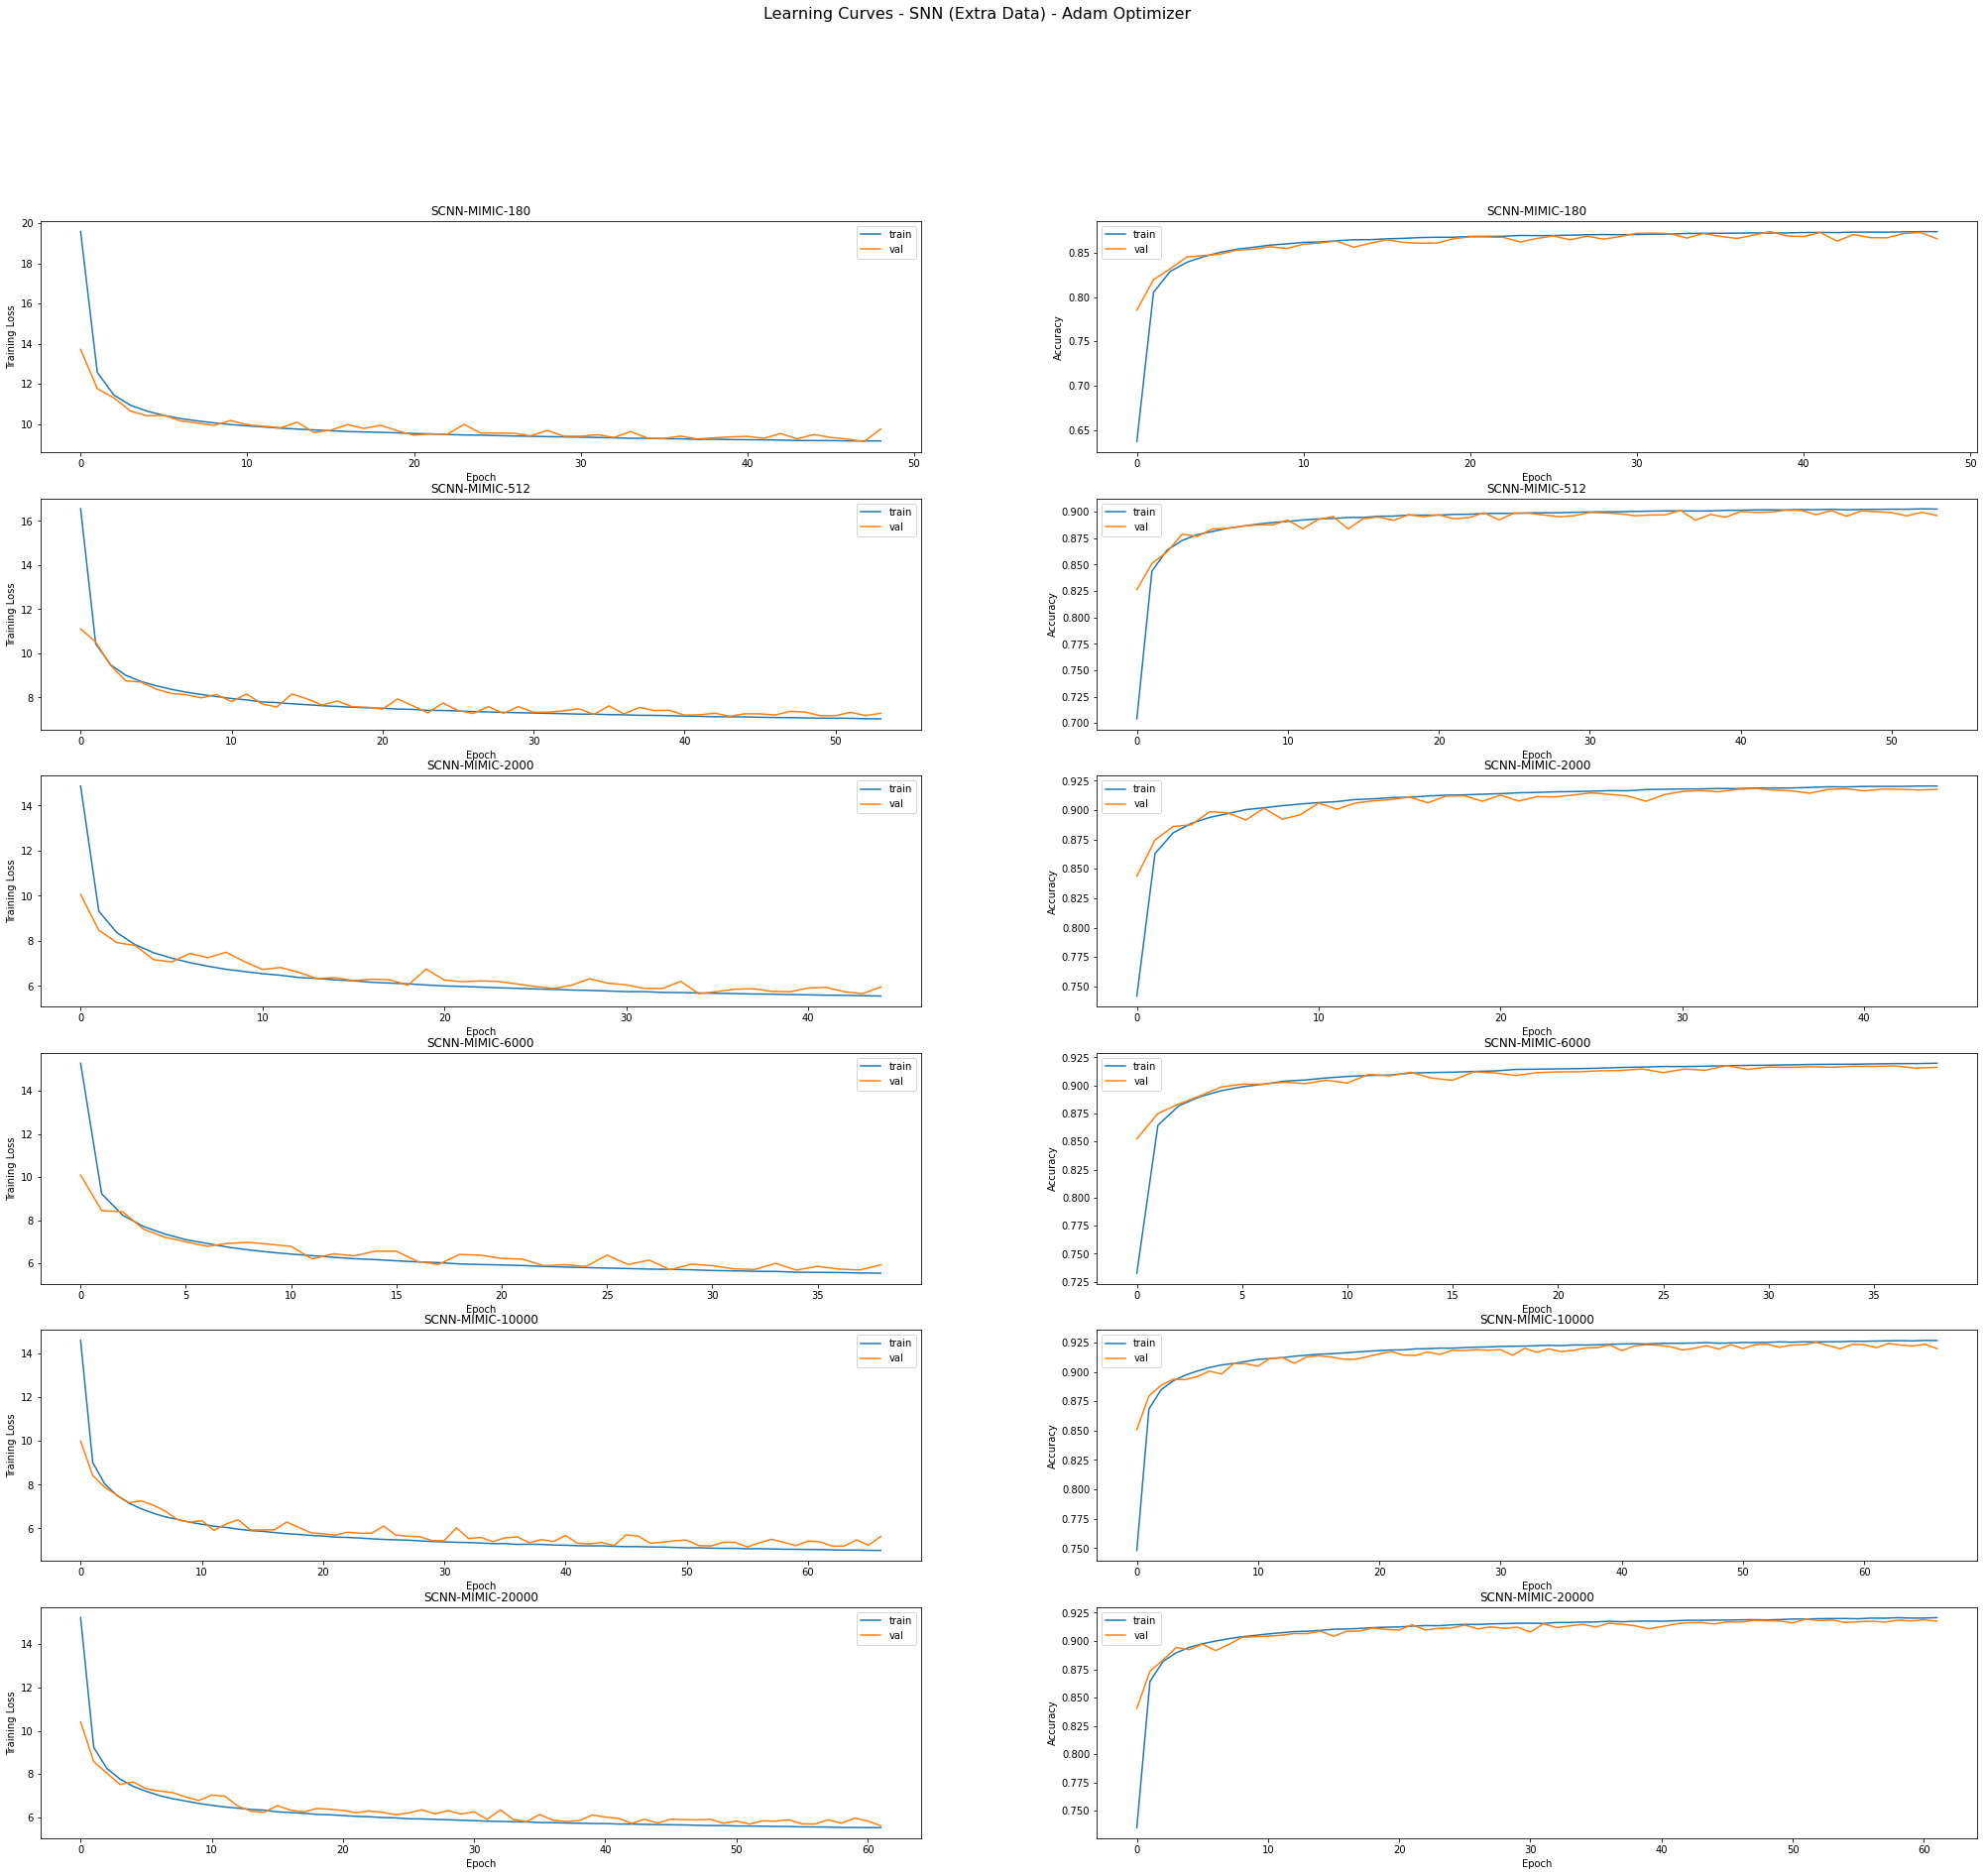

In [ ]:
fig = plt.figure()
fig.suptitle('Learning Curves - SNN (Extra Data) - Adam Optimizer', fontsize=16)
fig.set_size_inches(35, 30)

plt.subplot(6, 2, 1)
plt.plot(loss_train_180, label='train');
plt.plot(loss_test_180, label='val');
plt.legend();
plt.title('SCNN-MIMIC-180')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(6, 2, 2)
plt.plot(acc_train_180, label='train');
plt.plot(acc_test_180, label='val');
plt.legend();
plt.title('SCNN-MIMIC-180')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(6, 2, 3)
plt.plot(loss_train_512, label='train');
plt.plot(loss_test_512, label='val');
plt.legend();
plt.title('SCNN-MIMIC-512')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(6, 2, 4)
plt.plot(acc_train_512, label='train');
plt.plot(acc_test_512, label='val');
plt.legend();
plt.title('SCNN-MIMIC-512')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(6, 2, 5)
plt.plot(loss_train_2000, label='train');
plt.plot(loss_test_2000, label='val');
plt.legend();
plt.title('SCNN-MIMIC-2000')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(6, 2, 6)
plt.plot(acc_train_2000, label='train');
plt.plot(acc_test_2000, label='val');
plt.legend();
plt.title('SCNN-MIMIC-2000')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(6, 2, 7)
plt.plot(loss_train_6000, label='train');
plt.plot(loss_test_6000, label='val');
plt.legend();
plt.title('SCNN-MIMIC-6000')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(6, 2, 8)
plt.plot(acc_train_6000, label='train');
plt.plot(acc_test_6000, label='val');
plt.legend();
plt.title('SCNN-MIMIC-6000')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(6, 2, 9)
plt.plot(loss_train_10000, label='train');
plt.plot(loss_test_10000, label='val');
plt.legend();
plt.title('SCNN-MIMIC-10000')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(6, 2, 10)
plt.plot(acc_train_10000, label='train');
plt.plot(acc_test_10000, label='val');
plt.legend();
plt.title('SCNN-MIMIC-10000')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(6, 2,11)
plt.plot(loss_train_20000, label='train');
plt.plot(loss_test_20000, label='val');
plt.legend();
plt.title('SCNN-MIMIC-20000')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(6, 2, 12)
plt.plot(acc_train_20000, label='train');
plt.plot(acc_test_20000, label='val');
plt.legend();
plt.title('SCNN-MIMIC-20000')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

#### Learning Curves for Extra Data - RMSProp


In [ ]:
loss_train_180 = [20.89529981407209, 14.374894648713488, 13.110035641386009, 12.45446279823568, 12.044098081598262, 11.741197813502806, 11.500211710042237, 11.302877243000623, 11.140265646636752, 11.022560817974984, 10.89840027802661, 10.804098245804125, 10.708143988279236, 10.632802420693306, 10.566622685733423, 10.513795868497947, 10.452801281696653, 10.40150548710025, 10.356770042384385, 10.2995401048329, 10.265672899434067, 10.224719851417362, 10.182046829335532, 10.157965601901205, 10.123905138737525, 10.096481426163528, 10.061762458560377, 10.040295147925889, 10.016131531473334, 9.991948510002763, 9.96944431194469, 9.947307881697931, 9.925175523362014, 9.918976890462408, 9.891530727946472, 9.871768021730343, 9.858779404883514, 9.84164429070049, 9.827567507631596, 9.809138388800086]
loss_test_180 = [15.750916521031682, 14.434447907516736, 12.525821700613202, 12.829372686433349, 11.72911357136285, 11.406418119664663, 12.478627157402977, 11.455673552560912, 11.416827865483947, 11.297484780140765, 11.657460039841874, 10.733023182713113, 10.162550743880352, 10.772408380930106, 10.612603197230019, 11.13172071964275, 11.884105650143098, 10.0740024846629, 10.07441358345343, 10.56482500899208, 10.360942702768451, 10.225440928064426, 10.478483169818388, 10.218525248643006, 9.952206231804698, 10.112222152023058, 10.568247544339817, 10.682188730457936, 10.104770896792253, 10.076547056474974, 10.12054837967968, 10.13885134055836, 10.127359792971554, 9.956540383261693, 9.812687020913783, 10.278100751367813, 10.068562133968474, 9.986743181897602, 10.738160779774292, 9.868582538052536]
acc_train_180 = [0.6048072035139875, 0.7692231657021896, 0.7991734603603489, 0.8140073993161898, 0.822710541679785, 0.8290178487353528, 0.8335977067738743, 0.8376550938520058, 0.8410488016116582, 0.8438470807512359, 0.8457463332882796, 0.8483751623929888, 0.8499943516608285, 0.8514182026987818, 0.8533809990032497, 0.8538540470351668, 0.8552072938839758, 0.8559815864300567, 0.8569253290199842, 0.8576078361229831, 0.8582809293370887, 0.8593964754357913, 0.8601213450601324, 0.8605637979391184, 0.8607167736723514, 0.8614110481448837, 0.8618393801894075, 0.8621076760868337, 0.8627901831898327, 0.8639174966591908, 0.8637551070370645, 0.8636091917221846, 0.8641010675363773, 0.8648141697855739, 0.8653295803332219, 0.865800274884499, 0.8659391297821477, 0.8657955679400523, 0.8668216820729463, 0.8666051625790222]
acc_test_180 = [0.7278846244604762, 0.7541114782735369, 0.8128912611901286, 0.8061415647858209, 0.8170804032783221, 0.8284899319505521, 0.8212507177828032, 0.8353996629881143, 0.839522908468787, 0.8428648084050552, 0.8301467611829273, 0.8422623250013069, 0.8587458932303351, 0.8561382699010737, 0.8517137827174046, 0.850593540250396, 0.8304197614233834, 0.8623607934076205, 0.8612499646892628, 0.8525704387790186, 0.8614664821465985, 0.8573432366659258, 0.8597814115178938, 0.8645353817891054, 0.8627844145208968, 0.8651566927226998, 0.8604592052991359, 0.8589718244907492, 0.8619654137018959, 0.8665970045510444, 0.8618712756660625, 0.8634057254438301, 0.8556205107620637, 0.8601673774317621, 0.8628785525567303, 0.8524009903550301, 0.853332956793577, 0.8655050034483822, 0.8559217524426158, 0.8627655869158622]

loss_train_512 = [19.322385591619682, 13.016344597125375, 11.817594050597972, 11.160000328154604, 10.722387525125994, 10.380453914348365, 10.120150095234143, 9.913833784899508, 9.739673840544654, 9.599848102774057, 9.476347859913593, 9.361491857716898, 9.258455660415306, 9.163099328613267, 9.0848273713657, 8.99601666670977, 8.929436422760318, 8.865345500170148, 8.814581089570293, 8.756191178500083, 8.709475225907877, 8.665026146787445, 8.625665713494053, 8.587786630472449, 8.548633656832063, 8.513344859478984, 8.473854528428596, 8.453146018496774, 8.418031374798986, 8.392054895939632, 8.363484292815622, 8.338424482654956, 8.320469056197812, 8.293294421725978, 8.266235784543172, 8.244934053733267, 8.224837232533377, 8.213125045591353, 8.194797384254795, 8.175955263556936, 8.155315289694798, 8.136199430927121, 8.12052177059099, 8.106773658331418, 8.08696907187389, 8.077593418950023, 8.049021934755054, 8.044985585554493, 8.026923965021156, 8.014469005292472, 8.007495471745415, 7.990556751429556]
loss_test_512 =[14.292447856692029, 12.85283382852842, 11.616535231718931, 11.106246862119095, 11.111412378943708, 10.374197412152368, 9.928848474650822, 9.645173619287643, 11.221722474903011, 10.685721556008957, 9.220735838514978, 10.013421331145986, 10.277237419151689, 9.19426445223615, 9.79878752830882, 9.009861788655025, 8.80405018356935, 8.736750088084397, 9.065761331305433, 8.882899570670677, 9.538692615090708, 8.74754071158673, 8.688247249123899, 8.57599597904765, 9.505382288423288, 8.559708560559107, 8.723845067955622, 8.650658674528387, 8.419138322833593, 8.547840133580518, 9.021341667420204, 8.597680588441523, 8.850241287096637, 8.07341409420163, 8.69448144764893, 8.16541083692821, 8.036184170052946, 8.29672656332681, 8.372868708622807, 9.432526638688138, 8.593534988255296, 8.019764721201126, 8.884277740016774, 9.168432481230981, 8.57138827406679, 7.70564453131428, 7.843927588168316, 8.705149666491195, 8.378114152058119, 9.025264586597224, 7.889291633802317, 7.947818902287432]
acc_train_512 = [0.6485888577150827, 0.7973871745158362, 0.8224846082868675, 0.8359535330378329, 0.8452120949673338, 0.8519524410197276, 0.8559415773927213, 0.860071922130537, 0.8628913825262969, 0.8651836650183422, 0.8674406454186209, 0.8696199612170129, 0.8709449663946531, 0.8732113606815806, 0.8741339220186924, 0.8754589271907215, 0.8767533372232861, 0.8777300284310735, 0.8779465479283642, 0.8794857191282662, 0.8804859450560424, 0.881074313254397, 0.8815591286524808, 0.8823498955058083, 0.8831171276312916, 0.8835101575896599, 0.8837596256991995, 0.884555099508196, 0.8847739724726601, 0.8852093649377816, 0.8861978235094912, 0.886023666525687, 0.8860048387434115, 0.8863178506170087, 0.8867555965605258, 0.8869579952177433, 0.8875063543742735, 0.8877440551311132, 0.8875698981428201, 0.8881629732856214, 0.8889113776299513, 0.8887678157856116, 0.8890337582147423, 0.8890619998892777, 0.8898315854875454, 0.8898104042347299, 0.8897068514299701, 0.890288159207727, 0.8903846515885223, 0.8904034793741645, 0.8911542371935234, 0.891064805229959]
acc_test_512 =[0.7769964321823125, 0.7945249324475503, 0.8248185489475023, 0.8425070838774166, 0.8434861193178885, 0.8584634791654787, 0.8536906812572495, 0.8600073427463247, 0.8374612857607143, 0.8521185762475296, 0.8726312519539411, 0.8696564903158458, 0.8628126559290097, 0.8728477693798549, 0.8606098261394118, 0.8671524188995622, 0.8723488378784235, 0.8776676362793483, 0.8723864930778316, 0.8751164957865123, 0.8547167857636129, 0.8819979854692667, 0.8818191232214388, 0.8793903621613272, 0.8781477402290501, 0.8746834609133628, 0.8852080921169881, 0.8785242923404011, 0.8873261976833696, 0.8854905062031667, 0.8783642576762858, 0.8821580201013989, 0.8779688779385783, 0.8878157153817224, 0.8800399144918123, 0.8895666826605921, 0.8908846150348904, 0.8881828537124394, 0.8838713321163334, 0.8672465569247346, 0.8853681267272373, 0.8966552759886262, 0.8824686755631461, 0.8790326376224664, 0.8900467866215162, 0.8923060991931121, 0.8863754036397883, 0.8871285078305073, 0.891694202051374, 0.8875521289224616, 0.8965705517121046, 0.8940853078907557]

loss_train_2000 = [18.77681442516645, 12.55270602410284, 11.230285552706453, 10.492002161504445, 9.996345228816057, 9.649871864372356, 9.372776834970095, 9.134811271270088, 8.949467243827836, 8.785998482212449, 8.638912438084935, 8.522175530031863, 8.409608149563068, 8.317295504570671, 8.219806921353479, 8.147054327224888, 8.070270285120596, 8.001777177753606, 7.948797889168148, 7.883402428786729, 7.840679744626156, 7.778142531792153, 7.731259261608133, 7.6913963944915595, 7.652174677439518, 7.612046749112907, 7.565527528581071, 7.539857551216745, 7.505147264791689, 7.4777161438023905, 7.441042952434921, 7.415271838244211, 7.387475840613952, 7.363814476776942, 7.332477618087057, 7.317509827166647, 7.292521559727283, 7.268411639261342, 7.242712689449761, 7.216893068001926, 7.209922191493538]
loss_test_2000 = [13.625015270513941, 10.98799258378121, 11.504947820334133, 11.29966053546187, 13.624924503786326, 8.964313460997536, 9.817318652520015, 8.926752073602955, 8.662795736525153, 8.631810914122683, 9.52564287216642, 8.233639698877317, 7.906981125782163, 9.52213872950143, 8.806924163694251, 7.908015521406444, 7.78415105800436, 7.512361976056647, 8.365779773285862, 8.417363617498683, 8.224292072624117, 8.318551106917852, 7.158503957225534, 8.249041742091068, 8.497787033461062, 8.336918968993523, 8.810720437952924, 7.488963021037752, 7.638363697533171, 7.3636213416611165, 7.078063479293732, 7.320905571838923, 7.540534613363136, 7.489436371121957, 7.3966249635818455, 8.264539664456478, 7.452711434298647, 7.83283470108956, 8.681510595829273, 7.572189701797856, 8.436670260260737]
acc_train_2000 = [0.6622225255632034, 0.8050171332773818, 0.8312512944145203, 0.8443460169781707, 0.8533268691235965, 0.8598577561071529, 0.8640657654434885, 0.8684079227296593, 0.8720181499821136, 0.8740915595018393, 0.8770404609007434, 0.8785372695950144, 0.8809119236345151, 0.8826982094779056, 0.8835972360804397, 0.8853129177369303, 0.8861719353077401, 0.8873204300299139, 0.8885395289300096, 0.8889396193067313, 0.8901351834789827, 0.8901798994618871, 0.8911424698329677, 0.8919944269730797, 0.8924604145911323, 0.8929099278884717, 0.8939619302231167, 0.8945644192593002, 0.8945220567458135, 0.8949550957370285, 0.8957952855255626, 0.8955999472866986, 0.8967672697832922, 0.8966425357223502, 0.8969932031661096, 0.8970379191523807, 0.8978686950475327, 0.8986641688486736, 0.8986382806480449, 0.8988595070920267, 0.8992713648293038]
acc_test_2000 =[0.7913901361986448, 0.8316341419593308, 0.8319071422643142, 0.8530881978955843, 0.7837084733872123, 0.8612405509080676, 0.8611275852346555, 0.8671147636788321, 0.8785148785165618, 0.8720758376160843, 0.8723017688551763, 0.8820732958355385, 0.8856411270434428, 0.8668041081851019, 0.882308640952336, 0.8864036449934738, 0.8883711297734455, 0.8885123368005432, 0.8813766744492619, 0.8869214041425837, 0.8907245804027581, 0.8918354090997938, 0.8969753452635517, 0.8864130588386352, 0.8805859150484738, 0.8814425711207489, 0.8747117022777093, 0.8922966854012558, 0.8884935091523035, 0.8922966853905948, 0.8998088997780389, 0.8924096510101408, 0.8960151374174531, 0.8877498187641018, 0.8902633040362077, 0.8832217797639651, 0.8965893793710054, 0.8921648921340313, 0.8858199892480653, 0.8967870691700015, 0.883108814123097]

loss_train_6000 = [19.016394251195933, 12.388302264641712, 11.02445907259518, 10.258788614310957, 9.74864588216004, 9.38632828991834, 9.094094459000482, 8.860941889451547, 8.662228857232206, 8.502117292493127, 8.358695792480317, 8.236917588665582, 8.124787259289953, 8.01273840314449, 7.929056542218624, 7.8392303276755095, 7.774167204101607, 7.702302772656352, 7.634065759585304, 7.5820465017235446, 7.528830627849859, 7.47250700427882, 7.4288604563523695, 7.380545356027525, 7.340380698581054, 7.2948699524762946, 7.265406662538038, 7.229158685833702, 7.194118271289156, 7.162256976430661, 7.134292995371076, 7.106380867257353, 7.085743171113438, 7.045932283969424, 7.022065517999469, 7.009026557857436, 6.980086789628444, 6.960881843076348, 6.935426423813285, 6.914578847560316, 6.892888365024754, 6.870920628431011, 6.858244644449312, 6.839368309435195, 6.819354576254987, 6.812347299779314, 6.790598516362066, 6.772242851398096, 6.762542126616992, 6.749421575689658, 6.734866305426258, 6.718049197825136, 6.706222036307576, 6.694798432815333, 6.680279299595772, 6.670172178426334, 6.65868869325279, 6.643423463777851, 6.642742835415769, 6.622049579191582]
loss_test_6000 = [15.54422226549345, 10.938191219925127, 9.830037424894673, 9.47296865338772, 9.597701780405094, 11.201898606655053, 8.844418178887185, 9.33401716487931, 8.967596353483499, 8.741275952956201, 8.78395327755751, 8.45651529513719, 8.36316498446292, 8.649871329992258, 7.876427030119407, 7.711550312054267, 8.36650859368401, 8.047245632554333, 8.097432167409961, 7.380390169265289, 7.656397132222113, 7.552047700844342, 8.232361461899721, 8.498335556974656, 7.550596589961405, 7.496549517470928, 7.092978505479479, 7.8733903870487465, 9.296787085389454, 6.828521081066224, 8.356081644559344, 7.304777618286178, 8.342812704010012, 6.667143730076418, 6.648810815042217, 7.6713999876494405, 7.315537421401486, 7.21641366141773, 8.476034350473624, 7.96032927290287, 6.685638415183548, 6.559477860514137, 6.87089425449791, 7.2453131557259445, 6.866161843562311, 7.006860455221737, 7.205326949722896, 8.492660612264887, 7.072648349441172, 7.219069630733837, 7.24086378789302, 6.67626214407386, 6.524169534460239, 7.644854799940528, 6.97913521000299, 6.491321467264276, 6.508443012194635, 6.65077610203144, 6.926425592604428, 6.68959003184883]
acc_train_6000 = [0.6637711106463875, 0.8077424547640086, 0.8351086363037298, 0.8488011409602392, 0.8581844369562933, 0.8641975599205393, 0.8692269312586447, 0.8725570952497506, 0.8757884133794209, 0.8780030312740685, 0.8806506881543199, 0.8823145934129195, 0.884508030046896, 0.8860848568169603, 0.8874451640841226, 0.8885371754594696, 0.8894526763647616, 0.8907847419686106, 0.8913448684901852, 0.8924392333349502, 0.8935430120730974, 0.8941101990096586, 0.8944232108911115, 0.8953763673643211, 0.8960047446022557, 0.8969367198260164, 0.8969414267659742, 0.8975321484371133, 0.8976098130434886, 0.8982899666770698, 0.8991913467546329, 0.8993184342805037, 0.8993796245751436, 0.8999303372055806, 0.9003280741050288, 0.9004292734392486, 0.90097998607193, 0.9014553875732648, 0.9015707077318469, 0.9011682638935631, 0.9023332329218612, 0.9021896710831325, 0.9027545045480316, 0.9029686705714157, 0.9033452262113152, 0.9033169845446352, 0.9035029088912393, 0.9039971381748497, 0.9042042437854916, 0.9042371924044738, 0.9042207180938604, 0.9046937661167996, 0.9050303127328303, 0.9048396814384128, 0.9049644154914993, 0.9053739197593587, 0.905432756575603, 0.9056022066172049, 0.9055127746469073, 0.9058257865350935]
acc_test_6000 =[0.7446317791173432, 0.8245361348613237, 0.8524857145670244, 0.8591601005197722, 0.8568066498792374, 0.8408596684694418, 0.8601391360242103, 0.8719158029194248, 0.8689222137621443, 0.8656650380479703, 0.8764532557439618, 0.878110084986437, 0.8729136660075755, 0.8674254191293572, 0.8926167546655204, 0.888841819899308, 0.8822239166976976, 0.8784866370871269, 0.883890159753351, 0.8935863763573414, 0.8897926139535504, 0.8855375751618868, 0.887872198218148, 0.8755589444936009, 0.8924849614734841, 0.8890206821145916, 0.900213693329486, 0.8932851346442452, 0.8867048866953479, 0.8995829685608301, 0.8755871859118137, 0.8950172743399635, 0.8880322328289583, 0.9007879352824771, 0.9033108343144562, 0.8944430323970722, 0.8974272077950407, 0.9010703493260116, 0.8902915454330984, 0.8899714761688339, 0.9046099391157031, 0.9047888013635308, 0.9018140397248744, 0.8963163790980051, 0.9036309036213648, 0.9005902454296149, 0.9017387293159586, 0.8915153398142073, 0.9016069360588339, 0.9074058384414434, 0.8988016229300152, 0.9046005252593197, 0.9040074557113938, 0.8976907942655238, 0.899808899820683, 0.9056360435682003, 0.9065868376011206, 0.9030754892947301, 0.9045158010579863, 0.9018328673512309]


loss_train_10000 = [19.658798479260437, 12.379736615087367, 11.004895982445504, 10.24309886775585, 9.753232777633784, 9.381267636774794, 9.097904204783598, 8.865989636704237, 8.670200894396192, 8.49665018632937, 8.350306712476593, 8.222902786338269, 8.105443178374069, 8.007088038772908, 7.915433134560512, 7.833273538955017, 7.766606671883813, 7.695306934320204, 7.6308568607530205, 7.578937887007513, 7.513456034978602, 7.469231112326122, 7.424927236472149, 7.378147031112053, 7.336620096705794, 7.294080892172189, 7.260419718024669, 7.218924286535503, 7.1846961069777695, 7.153969700195101, 7.133095522016478, 7.099785572484229, 7.07835069783713, 7.047250417720088, 7.021850952976333, 6.998009064478859, 6.975935460681142, 6.95135590343006, 6.927749032780143, 6.905599866969089, 6.887744080157814, 6.869855687077479, 6.845651065942122, 6.833116136529034, 6.818058348545041, 6.803757473576433]
loss_test_10000 = [13.698362066427341, 10.95474303915272, 11.041869009105692, 10.616434320754012, 9.511169108161042, 9.524307519912593, 10.972984149717792, 8.655854296172311, 7.941542708632586, 8.455512111193064, 8.80111916944335, 8.19247053935987, 9.615688401075111, 8.860954046983316, 7.353532826438018, 8.300975973081565, 7.988240362628794, 7.108095595292748, 7.328801972896112, 9.045115342711584, 7.156127169114569, 7.275317785566561, 8.711230214973716, 6.810141621101749, 8.220329450180877, 7.365165283712125, 7.850857480584285, 7.04471949765567, 7.731280853977994, 7.318835060022813, 7.4184231284050135, 7.635494703309563, 7.17011889959619, 7.575173385523015, 8.10162099476294, 6.909160807330522, 7.699166463362662, 6.85396232448948, 7.35995792685647, 7.485124416215396, 6.75347480891803, 7.333470789882349, 7.673440913323974, 7.199290306676978, 7.169851892818876, 6.812211044443352]
acc_train_10000= [0.6601844181318777, 0.8077918776947264, 0.8351886543772785, 0.8487823131824526, 0.8575019298454388, 0.8638633667817821, 0.868716227664421, 0.8726724154116993, 0.8756636793297011, 0.8788408675886962, 0.881060192421057, 0.8833101124018602, 0.8848657579123755, 0.886150754051558, 0.8878264266796908, 0.8888737220687669, 0.8899586730134164, 0.8905046787016511, 0.8918579255571933, 0.8924439402782747, 0.8931311543313313, 0.8941831566670986, 0.8938936795134901, 0.8952492798395724, 0.8955646451926874, 0.8963083425948152, 0.897021444839523, 0.8969461337137875, 0.8979816617355747, 0.8983205618210232, 0.898261725005901, 0.89956084198179, 0.8994572891725413, 0.8996361531030366, 0.9004245664891909, 0.9005516540251618, 0.9007846478218436, 0.9013847833897316, 0.9014600945188337, 0.9017519251362488, 0.902123773844046, 0.9025827010358897, 0.9024932690678364, 0.9025073899045432, 0.9028768851361892, 0.9028698247167137]
acc_test_10000 =[0.7853653026195874, 0.8327826258883186, 0.8304950718867266, 0.846018432195029, 0.8671147636462879, 0.8545567510776144, 0.8462726048624337, 0.8743822192114887, 0.8774134636433656, 0.8823745375160905, 0.8758507723822967, 0.8827699172650202, 0.8766038765842379, 0.8824498479687727, 0.895111412365136, 0.8917318572395598, 0.8939441008204527, 0.8908657874298559, 0.8943018253593135, 0.88228039951224, 0.8974742767644218, 0.8985756916914843, 0.8795221554072297, 0.8984438984343597, 0.888691199048371, 0.899432347709332, 0.8769616011118765, 0.9004584521837123, 0.8885782333856198, 0.8972860007466209, 0.8915529950242762, 0.8944147909788595, 0.897436621586897, 0.8926355822918769, 0.891665960611278, 0.9029813512370135, 0.890837546011082, 0.897850828897656, 0.8959115855358971, 0.8862812655820717, 0.9010703493585558, 0.8958456889289373, 0.8958739303258282, 0.8978037598418646, 0.8989334161871398, 0.8990746231816934]


loss_train_20000 = [21.375563569952593, 12.417020718114484, 11.054101326226213, 10.2832597706652, 9.773127011146924, 9.393826849986295, 9.084431146611614, 8.854048342251664, 8.667532511755596, 8.501151890979413, 8.34802964533908, 8.225404909329376, 8.119514988368877, 8.0130736103747, 7.921427203125203, 7.8367632711003035, 7.776658694628701, 7.699068098168968, 7.639622637802387, 7.572630254877529, 7.5239450381525, 7.475361395849109, 7.4308451124597115, 7.386601835576245, 7.335523129227744, 7.301725524511415, 7.2641880883693455, 7.224818825728474, 7.187534559126092, 7.163412530409687, 7.138166277117675]
loss_test_20000 = [12.708886243486633, 12.234967106134487, 11.292273068920242, 9.921796286043378, 9.250151920138151, 9.006662827588837, 8.30555017134955, 11.511105629121774, 8.916136243160276, 7.9351488319872505, 8.79028933328824, 8.038533152533999, 7.597581586198825, 7.434959926734683, 9.41569988074913, 7.073151732585919, 7.8107185254421125, 8.237118676505833, 10.077427588037313, 7.942553185594718, 6.888133479716468, 7.75308235642336, 7.436489049589792, 7.284129064996378, 7.981046970242498, 7.869847162141072, 7.3082763614561355, 8.295965093990292, 7.488070797123232, 7.847674769732711, 6.959865166646357]
acc_train_20000 =[0.6583793044994783, 0.8065492440679083, 0.8335035678692301, 0.8475137913493946, 0.8565934893528891, 0.8630443582505523, 0.8684714664982058, 0.8728112703071035, 0.875393029957246, 0.8781465931172862, 0.8804200478248114, 0.8824958108229326, 0.8837196166708418, 0.8853646941404325, 0.8871345056776986, 0.8884030275118788, 0.8892314499263908, 0.8905023252344777, 0.8911189351051234, 0.8920462033788263, 0.8933406134102687, 0.8930982057145936, 0.8945785400926402, 0.894999811721055, 0.8952210381661592, 0.8960447536418356, 0.896696665599759, 0.8972591455974848, 0.8978239790657505, 0.8984288215724741, 0.8987912563812779]
acc_test_20000 =[0.8014064220657775, 0.8148305044873602, 0.8433166709264442, 0.8479765031612613, 0.8698353525844345, 0.8631138975657954, 0.8750223577933228, 0.8205729240015611, 0.8700518700316702, 0.8798610522439845, 0.8820450544498699, 0.8827134344173725, 0.8864318864116866, 0.892296685423139, 0.8758037033915936, 0.8914682708016209, 0.8886347162439284, 0.8773004979699534, 0.8640458640688694, 0.8829017104570566, 0.8970506556618065, 0.891279994751276, 0.887909853406895, 0.8950737571331838, 0.8856034718221516, 0.8904892353072827, 0.8877121635753548, 0.8758978414055439, 0.8958833441715506, 0.8836265732615458, 0.8935110659372034]


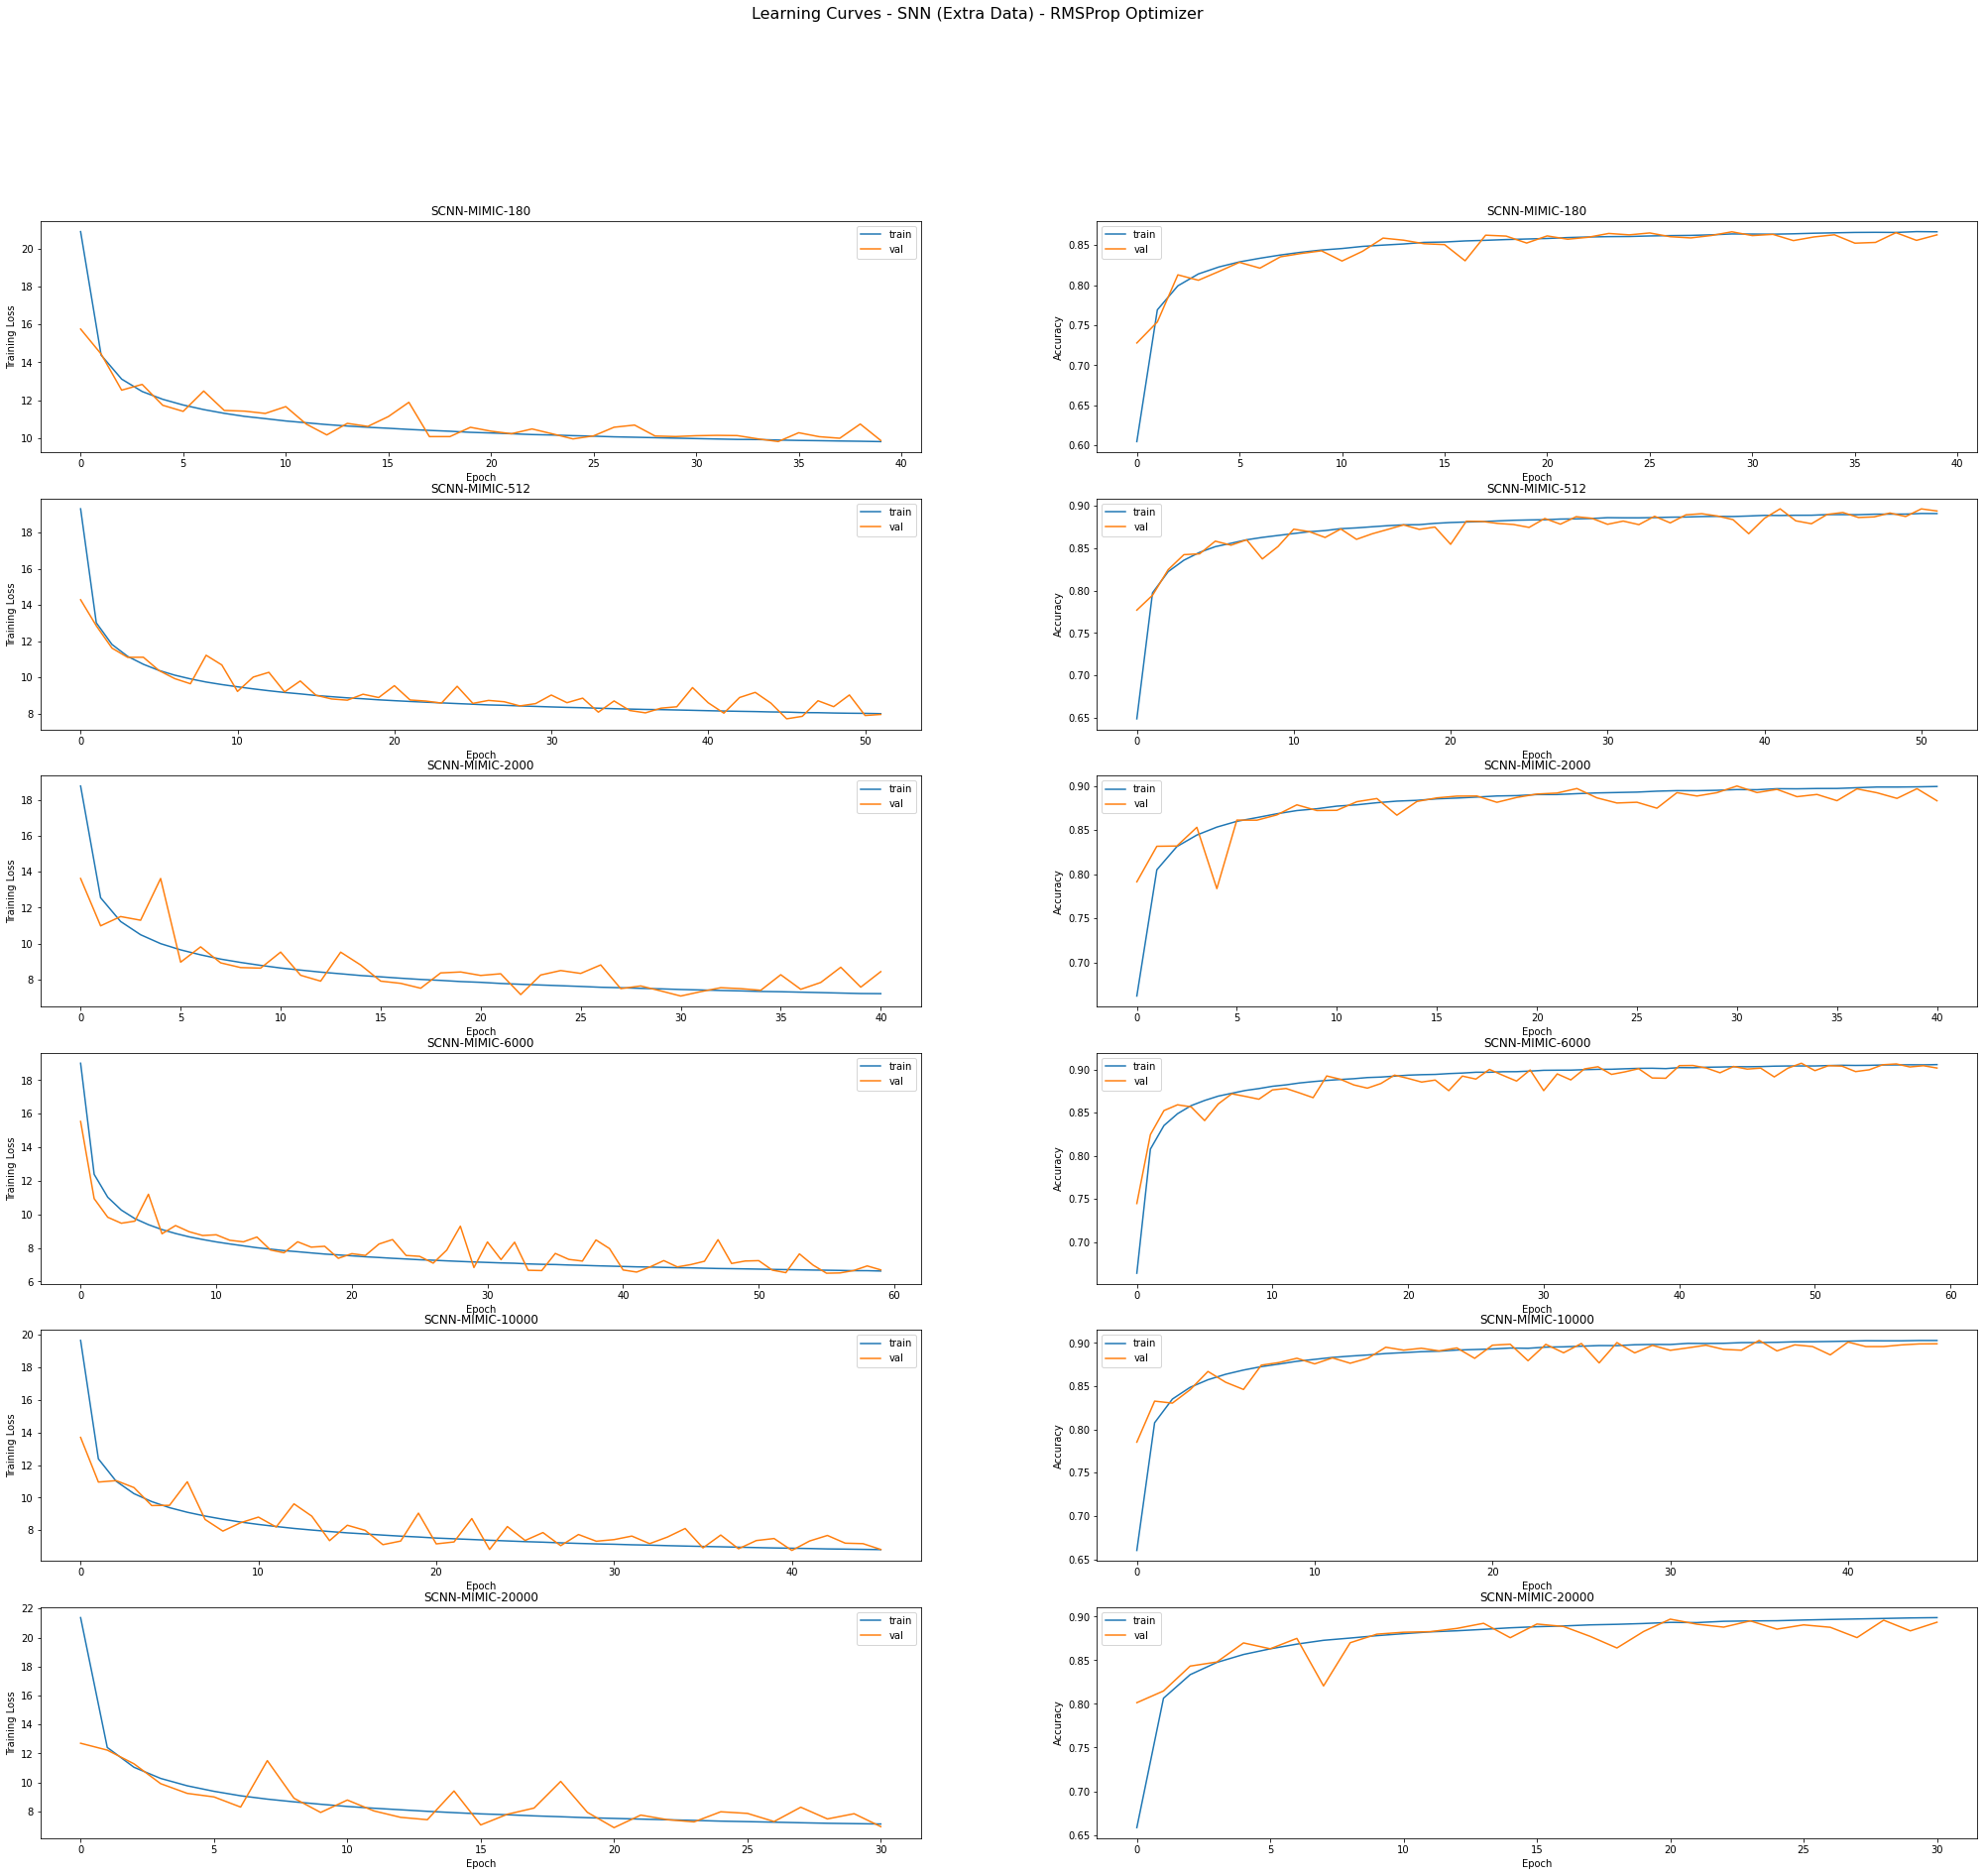

In [ ]:
fig = plt.figure()
fig.suptitle('Learning Curves - SNN (Extra Data) - RMSProp Optimizer', fontsize=16)
fig.set_size_inches(35, 30)

plt.subplot(6, 2, 1)
plt.plot(loss_train_180, label='train');
plt.plot(loss_test_180, label='val');
plt.legend();
plt.title('SCNN-MIMIC-180')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(6, 2, 2)
plt.plot(acc_train_180, label='train');
plt.plot(acc_test_180, label='val');
plt.legend();
plt.title('SCNN-MIMIC-180')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(6, 2, 3)
plt.plot(loss_train_512, label='train');
plt.plot(loss_test_512, label='val');
plt.legend();
plt.title('SCNN-MIMIC-512')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(6, 2, 4)
plt.plot(acc_train_512, label='train');
plt.plot(acc_test_512, label='val');
plt.legend();
plt.title('SCNN-MIMIC-512')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(6, 2, 5)
plt.plot(loss_train_2000, label='train');
plt.plot(loss_test_2000, label='val');
plt.legend();
plt.title('SCNN-MIMIC-2000')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(6, 2, 6)
plt.plot(acc_train_2000, label='train');
plt.plot(acc_test_2000, label='val');
plt.legend();
plt.title('SCNN-MIMIC-2000')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(6, 2, 7)
plt.plot(loss_train_6000, label='train');
plt.plot(loss_test_6000, label='val');
plt.legend();
plt.title('SCNN-MIMIC-6000')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(6, 2, 8)
plt.plot(acc_train_6000, label='train');
plt.plot(acc_test_6000, label='val');
plt.legend();
plt.title('SCNN-MIMIC-6000')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(6, 2, 9)
plt.plot(loss_train_10000, label='train');
plt.plot(loss_test_10000, label='val');
plt.legend();
plt.title('SCNN-MIMIC-10000')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(6, 2, 10)
plt.plot(acc_train_10000, label='train');
plt.plot(acc_test_10000, label='val');
plt.legend();
plt.title('SCNN-MIMIC-10000')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(6, 2,11)
plt.plot(loss_train_20000, label='train');
plt.plot(loss_test_20000, label='val');
plt.legend();
plt.title('SCNN-MIMIC-20000')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(6, 2, 12)
plt.plot(acc_train_20000, label='train');
plt.plot(acc_test_20000, label='val');
plt.legend();
plt.title('SCNN-MIMIC-20000')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

## CNN Model Distillation - Shallow CNNs

### Get the hard logits from the Teacher Model

In [ ]:
def get_logits(svhn_model, x_train, x_test):

  # Get the hard logits from the model
  svhn_model = Model(svhn_model.input, svhn_model.get_layer('logit').output)
  train_logits_hard = svhn_model.predict(x_train)
  test_logits_hard = svhn_model.predict(x_test)

  return train_logits_hard, test_logits_hard

### Adjust the Shallow Architecture to Export Logits

In [ ]:
def adjust_model(svhn_model, name):

  # Normal probabilities from logits before softmax activation
  logits = svhn_model.get_layer('logit').output
 
  # Now the model will output 10 dimensional logits
  output = logits
  svhn_model = Model(svhn_model.input, output, name=name)
  
  return svhn_model

### Training / Evaluation for 1 Layer

#### Load Data

In [ ]:
x_train_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/data/x_train_cnn.npy')
x_test_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/data/x_test_cnn.npy')

x_train_cnn_extra =np.load('/content/drive/My Drive/Colab Notebooks/SVHN/extra_data/x_train_cnn_extra.npy')
x_test_cnn_extra =np.load('/content/drive/My Drive/Colab Notebooks/SVHN/extra_data/x_test_cnn_extra.npy')

x_acc_test_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/data/x_acc_test_cnn.npy')
y_labels_acc_test=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/data/y_labels_acc_test.npy')

#### Training

In [ ]:
# Arrays with the results
scores_1_layer = []
channels_number = []

channels_to_test = [4,16,64,172,300,600]
channels_to_test = [172,300,600]

for channel in channels_to_test:
  # Set name
  name = 'SCNN-SVHN-h'+ str(channel)
  svhn_model = get_CNN_model()
  svhn_model = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/SVHN/CNN_SVHN.h5')
  train_logits, test_logits = get_logits(svhn_model, x_train_cnn, x_test_cnn)
  svhn_model = get_SCNN_model_layer1(channels=channel)
  svhn_model = adjust_model(svhn_model, name)
  opt = keras.optimizers.Adam(learning_rate=0.001)
  svhn_model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])

  #Save trained SCNN model
  svhn_model = train_scnn(svhn_model, x_train_cnn, train_logits, x_test_cnn, test_logits)

  # Learning Curves
  loss_train_cnn=svhn_model.history.history['loss']
  loss_val_cnn=svhn_model.history.history['val_loss']
  acc_train_cnn=svhn_model.history.history['accuracy']
  acc_val_cnn=svhn_model.history.history['val_accuracy']

  print ("")
  print (loss_train_cnn)
  print ("")
  print (loss_val_cnn)
  print ("")
  print (acc_train_cnn)
  print ("")
  print (acc_val_cnn)

  name_to_store = 'SCNN_MIMIC_SVHN_h'+str(channel)+'.h5'
  svhn_model.save(name_to_store)
  print ('Model: '+name_to_store+' was saved')

  svhn_model = get_SCNN_model_layer1(channels=channel)
  svhn_model = adjust_model(svhn_model, name)
  svhn_model = keras.models.load_model(name_to_store)

  output = svhn_model.layers[-1].output
  output = Activation('softmax')(output)
  svhn_model = Model(svhn_model.input, output, name=name)

  score = 0;
  preds = svhn_model.predict(x_acc_test_cnn)
  for i in range (len(x_acc_test_cnn)):
    if (np.argmax(preds[i], axis=0) == y_labels_acc_test[i]):
      score = score + 1

  score=score/26032.0
  print ("Test Accuracy: %.5f" % score)
  scores_1_layer.append(score)
  channels_number.append(channel)

  print ('----------------------------')

#### Results

##### Accuracy Results - Adam

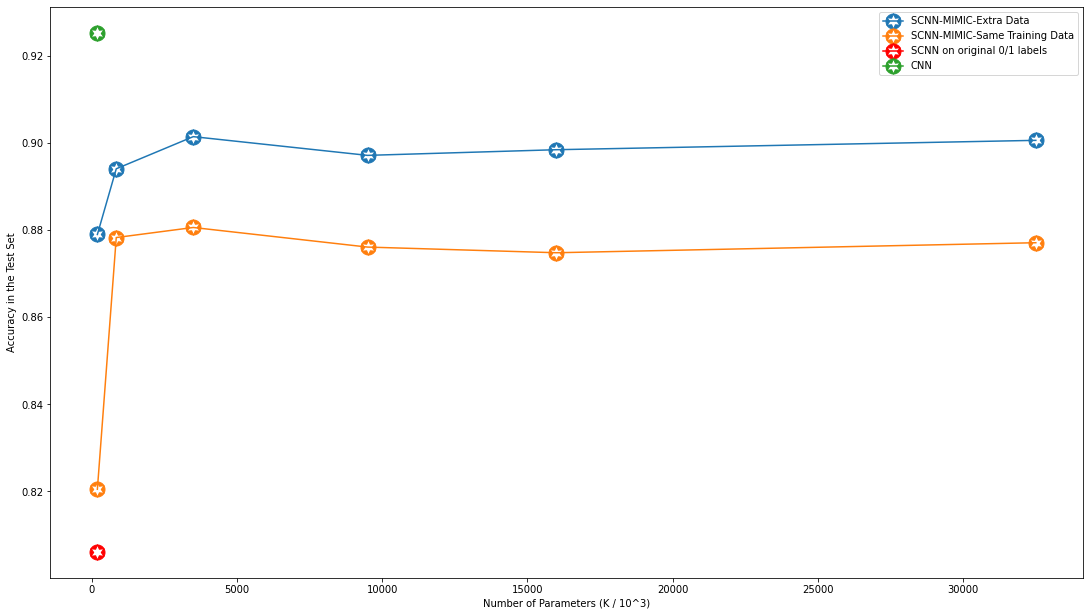

In [ ]:
import matplotlib.path as mpath
import numpy as np

star = mpath.Path.unit_regular_star(6)
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
verts = np.concatenate([circle.vertices, star.vertices[::-1, ...]])
codes = np.concatenate([circle.codes, star.codes])
cut_star = mpath.Path(verts, codes)

fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
plt.plot([200, 850, 3500, 9500, 16000, 32500], [0.87900, 0.89409, 0.90147, 0.89717, 0.89847, 0.90062], label='SCNN-MIMIC-Extra Data', marker=cut_star, markersize=15)
plt.plot([200, 850, 3500, 9500, 16000, 32500], [0.82049, 0.87830, 0.88061, 0.87611, 0.87481, 0.87711], label='SCNN-MIMIC-Same Training Data', marker=cut_star, markersize=15)
plt.plot(200, 0.80612, marker=cut_star, markersize=15, color="red" ,label='SCNN on original 0/1 labels')
plt.plot(200, 0.92528, marker=cut_star, markersize=15, label='CNN')

plt.xlabel('Number of Parameters (K / 10^3)');
plt.ylabel('Accuracy in the Test Set');
plt.legend()
plt.show()

##### Accuracy Results - SGD

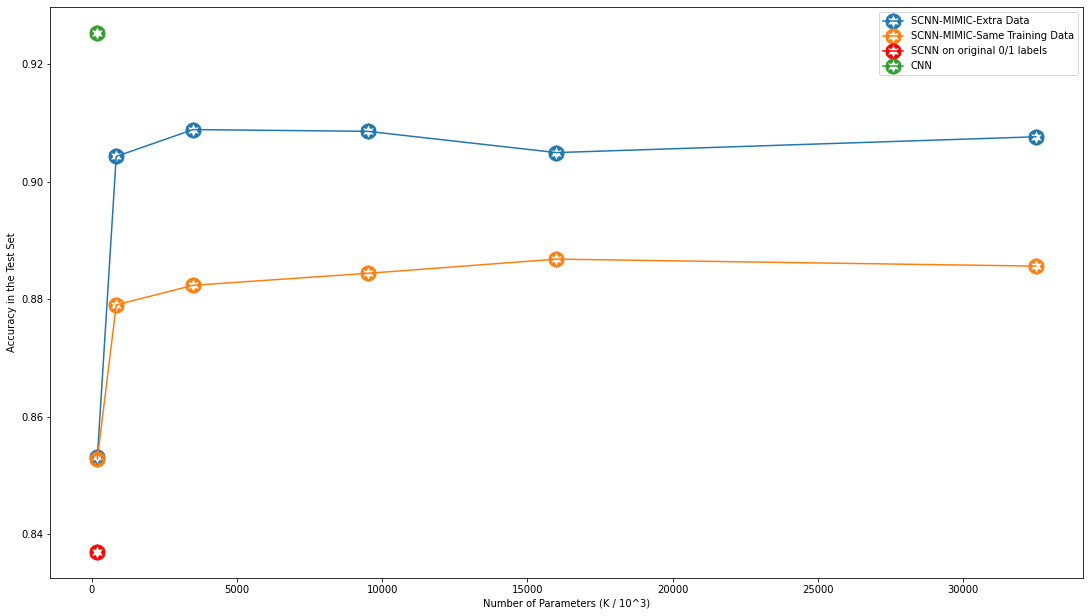

In [ ]:
import matplotlib.path as mpath
import numpy as np

star = mpath.Path.unit_regular_star(6)
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
verts = np.concatenate([circle.vertices, star.vertices[::-1, ...]])
codes = np.concatenate([circle.codes, star.codes])
cut_star = mpath.Path(verts, codes)

fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
plt.plot([200, 850, 3500, 9500, 16000, 32500], [0.85314, 0.90427, 0.90884, 0.90854, 0.90492, 0.90761], label='SCNN-MIMIC-Extra Data', marker=cut_star, markersize=15)
plt.plot([200, 850, 3500, 9500, 16000, 32500], [0.85276, 0.87900, 0.88234, 0.88437, 0.88679, 0.88560], label='SCNN-MIMIC-Same Training Data', marker=cut_star, markersize=15)
plt.plot(200, 0.83697, marker=cut_star, markersize=15, color="red" ,label='SCNN on original 0/1 labels')
plt.plot(200, 0.92528, marker=cut_star, markersize=15, label='CNN')

plt.xlabel('Number of Parameters (K / 10^3)');
plt.ylabel('Accuracy in the Test Set');
plt.legend()
plt.show()

##### Learning Curves for Same Data - Adam

In [ ]:
loss_train_4=[27.889558244986233, 17.645755859861886, 14.277930490112825, 12.662365713608509, 11.708041070014296, 10.939285785563417, 10.408413104068785, 9.949085576643503, 9.548415199545358, 9.20068505271467, 8.895268023814493, 8.653008186327964, 8.41085790091128, 8.194088248988486, 7.985556703939666, 7.819797974081945, 7.659482747370773, 7.502792086575628, 7.355375619996846, 7.220133137595134, 7.1204831201787515, 7.0033948975367695, 6.902180270214616, 6.810415349593699, 6.740675578675939, 6.653879163712937, 6.554980979906741, 6.517130597180224, 6.437450931190417, 6.35167629904902, 6.311900613121018, 6.260897206426145, 6.1681081285209, 6.13371473405459, 6.109517749561485, 6.00989203992918, 5.996438107223257, 5.937810255071326, 5.890247774372307, 5.862288538932231, 5.796268162142751, 5.770382068918158, 5.729533151265817, 5.710652699058408, 5.660504917007757, 5.63937348889853, 5.594819153096629, 5.549116827837285, 5.52673284539427, 5.490390472120824, 5.473820886204302, 5.473775918251235, 5.421699457035955, 5.3976586050247235, 5.382605686745905, 5.338770394243485, 5.314154937891574, 5.278492963465598, 5.289282566023691, 5.245563100851108, 5.197046925518946, 5.212325407284822, 5.167366131702062, 5.157903880233316, 5.127754337435116, 5.100111016575442, 5.100609381615266, 5.089891962349674, 5.049409669943306, 5.04473465278423, 5.009629943856769, 5.001894678718431, 4.965698008248041, 4.9566303924431665, 4.94809762582713, 4.920937842507481, 4.935673532786197, 4.888590079978733, 4.893490042961882, 4.858704101419949, 4.855006091613613, 4.843342566728165, 4.809303963354205, 4.816692684913351, 4.775803413208856, 4.775307934846236, 4.757238467090946, 4.743169873111251]
loss_test_4 = [20.1558527992034, 15.166296794900731, 13.092796757870152, 11.973661451628715, 11.182302283615874, 10.528328952846584, 10.023971469357402, 9.785304906294705, 9.44769039252987, 9.144265626839136, 8.930278916844507, 8.751966284299659, 8.448315503523709, 8.236754897380832, 8.212986407695231, 7.964791865873428, 8.215185329818413, 7.804496990082012, 7.830432359032575, 7.7365251028762305, 7.553671720605257, 7.3971351624316215, 7.425398451299769, 7.440240086996259, 7.233418819652435, 7.179197110929288, 7.304031784600194, 7.259685640285616, 7.128962789765154, 7.063944365006472, 7.0330472009415645, 7.072509098339367, 6.907147644713639, 6.996353328016459, 6.901747654215287, 6.907043095009919, 6.855116678983046, 6.739167788690666, 6.724057338421963, 6.792660065827199, 6.711563997765952, 6.765221833076238, 6.7789573359613104, 6.740658671420485, 6.645010352232337, 6.6486355855495525, 6.595729205766532, 6.775157744787509, 6.550192484203467, 6.6428519004750965, 6.58159797190969, 6.487584302830885, 6.5191886290285455, 6.510856168894308, 6.454085899512363, 6.511552028567486, 6.5264549772172495, 6.778286821296103, 6.469074741335407, 6.440355200797458, 6.433561871034215, 6.659782523442382, 6.389017645465914, 6.324387213066241, 6.438071007745499, 6.422883516577727, 6.501230863284258, 6.439772869503762, 6.3981820457202305, 6.396791750376517, 6.315468739591073, 6.268717101256183, 6.311097191813992, 6.37278634500152, 6.332111978283548, 6.2454209036102, 6.275360474129567, 6.293219284642891, 6.291570977958994, 6.2439509292069335, 6.252639029021475, 6.235153401968683, 6.257606330088439, 6.270457673001218, 6.218730341890227, 6.212090167067203, 6.338248154975793, 6.27750504631961]
acc_train_4 =[0.3133009, 0.58570087, 0.68209195, 0.7231977, 0.7456019, 0.76157326, 0.7745073, 0.7835509, 0.79196316, 0.79749167, 0.80450475, 0.80721784, 0.8115178, 0.81731933, 0.8197765, 0.823701, 0.82658476, 0.8289395, 0.8318232, 0.83354664, 0.83484346, 0.83782953, 0.83904105, 0.8408327, 0.84131044, 0.84485966, 0.844143, 0.8457811, 0.846839, 0.8488013, 0.8493985, 0.85124135, 0.8528453, 0.8524358, 0.8540227, 0.8548588, 0.8552342, 0.8556437, 0.85595083, 0.8569917, 0.85934645, 0.85953414, 0.8606092, 0.85893697, 0.8603361, 0.86103576, 0.86149645, 0.8639536, 0.86274207, 0.863254, 0.86402184, 0.86410713, 0.86617184, 0.8664278, 0.8655234, 0.8671103, 0.86704206, 0.8672127, 0.8674004, 0.86832184, 0.8684413, 0.8684924, 0.86956745, 0.8700964, 0.8696869, 0.8707789, 0.8713932, 0.8709325, 0.87170035, 0.8722464, 0.87323606, 0.87212694, 0.87318486, 0.8728777, 0.87357736, 0.87362856, 0.874294, 0.8749254, 0.87530077, 0.87584674, 0.87571025, 0.8757956, 0.876171, 0.8766487, 0.876973, 0.87642694, 0.8772289, 0.87758726]
acc_test_4 =[0.5161070227622986, 0.6595004200935364, 0.7102102041244507, 0.7446764707565308, 0.7615342736244202, 0.7782555222511292, 0.7870597839355469, 0.792792797088623, 0.8013240694999695, 0.8108108043670654, 0.806238055229187, 0.8093775510787964, 0.82111656665802, 0.8255528211593628, 0.8235735893249512, 0.8280780911445618, 0.8181135654449463, 0.828009843826294, 0.8283510804176331, 0.8379060626029968, 0.8397488594055176, 0.8398853540420532, 0.839271068572998, 0.8335380554199219, 0.8376330733299255, 0.8428201079368591, 0.8455501198768616, 0.8440486192703247, 0.8456866145133972, 0.8458231091499329, 0.8471198678016663, 0.8454818725585938, 0.8531941175460815, 0.8501911163330078, 0.8496450781822205, 0.8514196276664734, 0.8518973588943481, 0.8510783314704895, 0.8546956181526184, 0.8540130853652954, 0.851965606212616, 0.8534671068191528, 0.8553098440170288, 0.8507370948791504, 0.8562653660774231, 0.8542860746383667, 0.8557876348495483, 0.8481435775756836, 0.8553780913352966, 0.8539448380470276, 0.8605651259422302, 0.8578351140022278, 0.8559923768043518, 0.8613840937614441, 0.857084333896637, 0.8565383553504944, 0.8581763505935669, 0.851283073425293, 0.8575621247291565, 0.8594048619270325, 0.8586540818214417, 0.85776686668396, 0.8615888357162476, 0.8638411164283752, 0.8583810925483704, 0.8611793518066406, 0.8559923768043518, 0.8611111044883728, 0.8609063625335693, 0.8598143458366394, 0.8607698678970337, 0.8629538416862488, 0.8639776110649109, 0.8631585836410522, 0.8634316325187683, 0.8641823530197144, 0.8625443577766418, 0.8651378750801086, 0.8639776110649109, 0.8634316325187683, 0.8642506003379822, 0.8624078631401062, 0.8619983792304993, 0.8629538416862488, 0.8632951378822327, 0.8647283911705017, 0.8651378750801086, 0.8633633852005005]

loss_train_16 =[24.081057673564047, 11.383004294002374, 8.250353945283065, 6.865446813752775, 6.044109514526271, 5.49236222913918, 5.069514198277186, 4.745697275740571, 4.457012679542091, 4.235539663782829, 4.035807448675909, 3.872504937963044, 3.738175172523451, 3.6133755352175507, 3.5010838034901335, 3.402373060489736, 3.3205602420819575, 3.2553932306903, 3.1673764397245496, 3.102630515989921, 3.035264972895549, 2.989040192889736, 2.9490633663855745, 2.875031282974789, 2.846417412352271, 2.7934809853015383, 2.748970876168436, 2.7139260064354427, 2.6801353852055847, 2.646296294131546, 2.61311498279814, 2.589134943415083, 2.5576502763170317, 2.521298692629368, 2.4971428000228255, 2.4692789651785945, 2.4351999425021527, 2.419880727716359, 2.396057177781957, 2.3797405157609153, 2.3366636427705294, 2.3204803598648187, 2.299029820075815, 2.276433875631751, 2.259687516441342, 2.240168574559954, 2.216835159263191, 2.1998354119923365, 2.1717833788624175, 2.165759609059032, 2.14263563342046, 2.1229486939402817, 2.1051306450959917, 2.0952911510187637, 2.078522701782534, 2.0555347221803464, 2.0432060148129945, 2.0301381969704133, 2.0172674638502284, 2.005733680005021, 1.987972901020224, 1.975470320444731, 1.9637788694513687, 1.9484170217540888, 1.9403029889237016, 1.926297824043695, 1.915266799345001, 1.901617927598461, 1.8861567505552606, 1.881139217111786, 1.8696780133253479, 1.8528651033547456, 1.8538261845254032, 1.827992183048869]
loss_test_16 =[14.069339687369283, 9.139988516771888, 7.26201220389243, 6.363062299863256, 5.741022579532616, 5.438748519276778, 5.02124422741431, 4.798979288237101, 4.5590435068300765, 4.413718801295858, 4.360600366509094, 4.193909328816336, 4.064577352990877, 4.186804217196149, 3.9218234713208373, 3.846458594785373, 3.9377152753143143, 3.777585794910719, 3.7731920374308716, 3.697219938129276, 3.6556795140676996, 3.6473592082691946, 3.598874619903377, 3.5991569818970026, 3.5787695048449635, 3.5392072536630965, 3.563127040993214, 3.585390147504148, 3.5765082806210486, 3.536297430798163, 3.512014113388978, 3.50253223032044, 3.5010171232085523, 3.460332114807804, 3.4946695368634266, 3.442804674681763, 3.4209067456357114, 3.426241804594685, 3.4614006324833677, 3.4002111173541762, 3.4030541595200714, 3.454849663634721, 3.404074562269581, 3.4457485209779275, 3.3929749534262226, 3.426436586195154, 3.3792342033146707, 3.440805908503052, 3.4093465288903197, 3.383748586731728, 3.401741084523973, 3.386946557487844, 3.401137764259274, 3.535969069249442, 3.3872703047290775, 3.4187118151849845, 3.3533527875187423, 3.369024922735145, 3.385425350817702, 3.394445242010893, 3.3758200319484386, 3.4279731932865802, 3.3990583700330537, 3.365937249698894, 3.469860226151854, 3.3919265123784395, 3.369014306111379, 3.357207925014407, 3.38285042762496, 3.3952782640944013, 3.4049342818967054, 3.372998095522023, 3.4052922290887397, 3.3661144248390666]
acc_train_16 = [0.42248955, 0.75955975, 0.8198959, 0.84265846, 0.85644567, 0.8650627, 0.87381625, 0.8790035, 0.8853852, 0.8890538, 0.8932514, 0.896903, 0.90028155, 0.90256804, 0.9048375, 0.90724343, 0.90816486, 0.908745, 0.9114581, 0.91301084, 0.91449535, 0.91502434, 0.91693544, 0.91836876, 0.9186247, 0.9203481, 0.92135483, 0.9215255, 0.9228735, 0.9234024, 0.9241532, 0.9238632, 0.92502344, 0.9260814, 0.9262008, 0.9268663, 0.92712224, 0.92790717, 0.92951113, 0.92942584, 0.9298353, 0.9308421, 0.93094444, 0.9317806, 0.9316441, 0.93118334, 0.9317976, 0.9327532, 0.9334869, 0.9332651, 0.93314564, 0.9344083, 0.9349714, 0.9347837, 0.9350397, 0.93514204, 0.9356028, 0.9364218, 0.9373603, 0.93649006, 0.937565, 0.9373091, 0.93776983, 0.9381793, 0.93758214, 0.93840116, 0.938094, 0.9385718, 0.9400734, 0.93928844, 0.9391861, 0.9398174, 0.939698, 0.94055116]
acc_test_16 =[0.7065929770469666, 0.8112202882766724, 0.8426836133003235, 0.8574256300926208, 0.8673900961875916, 0.8735326528549194, 0.8843843936920166, 0.8896396160125732, 0.8909363746643066, 0.8914141654968262, 0.8977614045143127, 0.8987851738929749, 0.9028118848800659, 0.8998088836669922, 0.9036991596221924, 0.9058831334114075, 0.9069751501083374, 0.9064291715621948, 0.9086131453514099, 0.9073846340179443, 0.9097734093666077, 0.9092956781387329, 0.9097051620483398, 0.912912905216217, 0.9093639254570007, 0.9112749099731445, 0.9118891358375549, 0.9108654260635376, 0.9129811525344849, 0.9116843938827515, 0.9140731692314148, 0.9128446578979492, 0.9137319326400757, 0.9141414165496826, 0.9133906364440918, 0.9162571430206299, 0.9149604439735413, 0.9155064225196838, 0.914004921913147, 0.9164619445800781, 0.9161206483840942, 0.9163253903388977, 0.9170761704444885, 0.9149604439735413, 0.9157111644744873, 0.9152334332466125, 0.9155064225196838, 0.9176221489906311, 0.9167349338531494, 0.9156429171562195, 0.9180999398231506, 0.9175539016723633, 0.9161206483840942, 0.9144144058227539, 0.9182364344596863, 0.917280912399292, 0.9187824130058289, 0.9185094237327576, 0.9168714284896851, 0.9170761704444885, 0.9189189076423645, 0.9168031811714172, 0.9184411764144897, 0.9196014404296875, 0.917280912399292, 0.9167349338531494, 0.9176221489906311, 0.9170079231262207, 0.9196014404296875, 0.9180316925048828, 0.9183046817779541, 0.9178268909454346, 0.9185776710510254, 0.9186459183692932]

loss_train_64 =[21.92545546390184, 9.701856834535945, 7.027421442513051, 5.920063512795777, 5.299052859902656, 4.857999474533832, 4.507471939671437, 4.220053838090821, 3.9786476463966833, 3.795883174919348, 3.6400314043959745, 3.4925501642714547, 3.3767876907640244, 3.270173668912242, 3.1684435682627905, 3.0681095680679116, 2.9781731757234056, 2.909063885596596, 2.8297021153213, 2.7696718771906603, 2.727710497235898, 2.655937726379061, 2.5860855240777494, 2.5306408341798896, 2.5023244829717304, 2.446170648646918, 2.387014965632295, 2.3488501983009886, 2.3112456234208696, 2.2631524301574006, 2.2241429265372714, 2.181696463025844, 2.14503091936703, 2.114380862470597, 2.0800957811762575, 2.0491870648970165, 2.0297755733548084, 1.9923043201445882, 1.9589435680237415, 1.9253342989941178, 1.9010876124369571, 1.8665116176966483, 1.8533003045312273, 1.8160707910540324, 1.800538771515179, 1.7799544429343752, 1.7552554090034636, 1.737400520823228, 1.7074810141864545, 1.6748822250155477, 1.6664764499920606, 1.6492746466205506, 1.6404636732029352]
loss_test_64 = [11.914819573431824, 7.611466366509873, 6.312828236318761, 5.5281454900428635, 5.118202948095107, 4.802591305888158, 4.613455438366556, 4.36866954099992, 4.225897215443037, 4.117410633949969, 4.013479297420805, 3.941239600620275, 3.830101816243498, 3.855039177193461, 3.7188964811075653, 3.713098395629037, 3.6959067234536063, 3.62135333231229, 3.573423081397229, 3.554452462760015, 3.6450069484377443, 3.528702865296493, 3.6147329240362076, 3.5114153278938187, 3.6088366146592734, 3.5371162379142724, 3.48715491812964, 3.5280727301339065, 3.422255741453158, 3.417374002650368, 3.457757773309531, 3.468994779987736, 3.4478333731215733, 3.4160479379097297, 3.404298966483539, 3.4285973905703426, 3.4155402828558135, 3.434403176715131, 3.4679235696727515, 3.4867395045748832, 3.4153997033728687, 3.447042889716096, 3.402967779486029, 3.4294383107981266, 3.4092452427158255, 3.3800244069053864, 3.41595205296072, 3.4382527261817843, 3.4398624423810964, 3.431594775603698, 3.4029490717310673, 3.4825925830280786, 3.4450865485060906]
acc_train_64 =[0.4855217, 0.7922532, 0.83946764, 0.858425, 0.869721, 0.8774678, 0.8850781, 0.8905213, 0.8949236, 0.8992919, 0.90168077, 0.9048716, 0.9075164, 0.9094617, 0.911697, 0.9132327, 0.9161846, 0.91691834, 0.92051876, 0.9201945, 0.9215937, 0.9227199, 0.92488694, 0.92618376, 0.9256548, 0.92703694, 0.9277877, 0.9291016, 0.92951113, 0.93099564, 0.932702, 0.9320706, 0.93324804, 0.93471545, 0.93495435, 0.93473256, 0.9352103, 0.93643886, 0.93763334, 0.9380087, 0.9380087, 0.939169, 0.9398857, 0.9409095, 0.94092655, 0.94106305, 0.9416091, 0.9419845, 0.94278646, 0.9439809, 0.944015, 0.94473165, 0.94358844]
acc_test_64 =[0.7569615244865417, 0.8316953182220459, 0.8514196276664734, 0.8673900961875916, 0.8807671070098877, 0.8873191475868225, 0.8861588835716248, 0.8937346339225769, 0.8969423770904541, 0.899126410484314, 0.9008326530456543, 0.9026071429252625, 0.9044498801231384, 0.9077259302139282, 0.9092274308204651, 0.9077259302139282, 0.909636914730072, 0.9101146459579468, 0.9122304320335388, 0.9135271906852722, 0.9119573831558228, 0.9125716686248779, 0.9122304320335388, 0.9146873950958252, 0.9117526412010193, 0.9146191477775574, 0.9140731692314148, 0.9136636853218079, 0.9157111644744873, 0.917280912399292, 0.9155064225196838, 0.9143461585044861, 0.9153016805648804, 0.9182364344596863, 0.9189871549606323, 0.9164619445800781, 0.9167349338531494, 0.9176221489906311, 0.9181681871414185, 0.9163936376571655, 0.9186459183692932, 0.918714165687561, 0.9197379350662231, 0.9151651859283447, 0.9180999398231506, 0.9185776710510254, 0.9164619445800781, 0.9190554022789001, 0.9180316925048828, 0.9172126650810242, 0.9197379350662231, 0.9176903963088989, 0.9194649457931519]

loss_train_172 =[18.276324061942216, 7.973112320832837, 6.167232891496421, 5.35143804037574, 4.7847579000753075, 4.414874096696221, 4.090079799697989, 3.8619106070192464, 3.642951471977862, 3.4897587805719428, 3.355765983979253, 3.2325802658658094, 3.13762579514258, 3.03054221316558, 2.9619345056655697, 2.8603850354555167, 2.785134845654231, 2.7038480293220877, 2.6453170772990555, 2.5787930372723253, 2.5004201973738622, 2.4485633459629006, 2.400183646592068, 2.3310499531306785, 2.2709317802518374, 2.227824890047055, 2.1785165745979507, 2.130033567156994, 2.091279552943185, 2.0594160281333407, 2.000362214199177, 1.9633696122011242, 1.9346035337989194, 1.8988928721490324, 1.8630406670801856, 1.8220591810740014, 1.792559953291621, 1.7565689469815806, 1.7287208050552991, 1.696391572790355, 1.6667334028035237, 1.651563560729771, 1.6214032451830447, 1.596886932263042, 1.5639207464508937, 1.559983663505666, 1.525130595040905, 1.4891484231125443, 1.478240068747458, 1.4667746380565212, 1.4247647659758864, 1.422091535266456, 1.4014848568630487, 1.3753464324310996, 1.3641062715295416]
loss_test_172 =[9.421069471685737, 6.741947787204402, 5.682033430901896, 5.295381492517895, 4.8686523693948045, 4.752737090980099, 4.292474336387224, 4.169427810455976, 4.280766410056991, 4.015573822407328, 3.8390764229420653, 3.785660777494226, 3.7741806546163597, 3.9939254084604543, 3.675465426938377, 3.6203851052200147, 3.575833178009129, 3.5780886568855204, 3.5497435506757675, 3.5775609917241042, 3.5582305775813445, 3.470442557315373, 3.6492478765492358, 3.5941773390398954, 3.4656712145809263, 3.5360266735343506, 3.4377567585849578, 3.458425942256156, 3.483564483185398, 3.525334769768888, 3.5445202689596513, 3.4575871733280925, 3.4868985323706774, 3.5056280874340318, 3.4898897731300913, 3.442402072204061, 3.510112690268206, 3.537870250111423, 3.4873912122905044, 3.4896440329592053, 3.4384690746726023, 3.4630651032700097, 3.4706781229424797, 3.541852305048058, 3.460419972477277, 3.535820982217333, 3.579557423053984, 3.5223277866791545, 3.540513924552611, 3.5406319307493375, 3.4856333681836076, 3.5149906899412895, 3.5008949458257375, 3.539537067983504, 3.5644836100339563]
acc_train_172 =[0.58326083, 0.8243153, 0.8533743, 0.8681512, 0.87924236, 0.886136, 0.8933026, 0.89680064, 0.90224385, 0.9052811, 0.9076017, 0.9089839, 0.911714, 0.9141882, 0.9154168, 0.91773736, 0.9188636, 0.92111593, 0.9217644, 0.9234195, 0.9255866, 0.92655915, 0.927054, 0.92806077, 0.9302278, 0.9314393, 0.9314564, 0.93352103, 0.9340329, 0.93420357, 0.9358417, 0.9364559, 0.93840116, 0.9380258, 0.93882775, 0.9399539, 0.9408583, 0.9406706, 0.94244516, 0.9433837, 0.9433837, 0.9435202, 0.9446634, 0.9449023, 0.94636977, 0.9461309, 0.94645506, 0.94727415, 0.9474789, 0.9480249, 0.94927055, 0.94988483, 0.95037967, 0.950209, 0.9509598]
acc_test_172 =[0.7994130253791809, 0.8445945978164673, 0.8663663864135742, 0.8756483793258667, 0.8899809122085571, 0.8906633853912354, 0.8931204080581665, 0.9007644057273865, 0.8933933973312378, 0.9014468789100647, 0.9061561822891235, 0.9088178873062134, 0.9074528813362122, 0.8981708884239197, 0.9080671668052673, 0.9099099040031433, 0.9113431572914124, 0.9115478992462158, 0.9142096638679504, 0.9127764105796814, 0.9119573831558228, 0.9162571430206299, 0.9127764105796814, 0.9131176471710205, 0.9146191477775574, 0.9157794117927551, 0.9151651859283447, 0.916530191898346, 0.9163253903388977, 0.914755642414093, 0.9155064225196838, 0.9148238897323608, 0.9167349338531494, 0.9152334332466125, 0.9168714284896851, 0.9172126650810242, 0.9144144058227539, 0.9156429171562195, 0.9162571430206299, 0.9159841537475586, 0.9168031811714172, 0.9159841537475586, 0.9152334332466125, 0.9139366745948792, 0.9178268909454346, 0.9146873950958252, 0.9144144058227539, 0.9164619445800781, 0.9157794117927551, 0.9157111644744873, 0.9163936376571655, 0.9170761704444885, 0.9172126650810242, 0.9168714284896851, 0.9157111644744873]

loss_train_300 =[18.07979489865029, 7.859339157850117, 6.032667503872785, 5.1826070762577645, 4.616832751030096, 4.210143216686967, 3.921380475083875, 3.7037790037851144, 3.4925905942855846, 3.33688951577661, 3.2155329796511425, 3.0734110285769796, 2.9598063056821475, 2.870015869986003, 2.7951572484443665, 2.6693450581609426, 2.607120226263725, 2.5152850785014187, 2.443502142327443, 2.370329318328498, 2.3056555234412572, 2.2336119292203644, 2.181016258863487, 2.1218356043453785, 2.064820635818131, 2.013380898935845, 1.9869276741016604, 1.9173820225393678, 1.8743952432108784, 1.8275863577507734, 1.781349409825667, 1.7494008877183602, 1.7004917383275335, 1.6622196040984643, 1.6366715465264459, 1.6064255285340359, 1.5901299205923556, 1.5246160569466398, 1.5045959608229993, 1.4729519385219931, 1.4499063441314222, 1.4265797365445059, 1.4006966198744724, 1.3800291632560422, 1.350347478816294, 1.3199809196082595, 1.3122333578888075, 1.2962862375947906, 1.2709030933280863, 1.248744612172972, 1.2407430979001544, 1.2065401620135028, 1.20791121405268]
loss_test_300 =[9.629506485533135, 6.500500991179778, 5.488463718644459, 5.10834276965821, 4.555487759283192, 4.439179447417763, 4.176808917779529, 4.066503625862461, 3.937127743983184, 3.8227073892426238, 3.7002849932287094, 3.7423076191594165, 3.6671693972020796, 3.756029046496309, 3.569583806580219, 3.6290394178739898, 3.531022507019001, 3.5265508870300035, 3.5153023849053033, 3.528400235836082, 3.4769126063254956, 3.5125538717030893, 3.4703101619097696, 3.465208392699104, 3.4488124199783154, 3.47641267855897, 3.449638939086056, 3.469534561343119, 3.438396143711495, 3.4567114698278294, 3.5594160796318293, 3.478249614042823, 3.5170409264800133, 3.5121472424052302, 3.4975792227174103, 3.5138732492028772, 3.489741703541657, 3.4577975698159165, 3.469909182670108, 3.52625655646276, 3.5356971687089866, 3.516274088235491, 3.529370849131887, 3.517400667766974, 3.489506921317777, 3.5129757398078914, 3.570612512193285, 3.5289351482584017, 3.591037891420744, 3.547530592708291, 3.5875319747888357, 3.5842416826701706, 3.5521484463389963]
acc_train_300 =[0.5872366, 0.82366693, 0.8555243, 0.87018174, 0.8828086, 0.89087963, 0.8958792, 0.9009811, 0.9042061, 0.90843785, 0.91164577, 0.9135739, 0.91574097, 0.9175838, 0.9193755, 0.9219691, 0.9233342, 0.92437506, 0.9258937, 0.9276342, 0.9291016, 0.93114924, 0.9312516, 0.93333334, 0.9337087, 0.93524444, 0.9353639, 0.9378381, 0.9387595, 0.93901545, 0.9404317, 0.94077295, 0.94217217, 0.94311064, 0.94348603, 0.94440746, 0.94497055, 0.9473936, 0.9479396, 0.94773483, 0.9480078, 0.9495265, 0.9490146, 0.94993603, 0.95131814, 0.95184714, 0.9517788, 0.9528368, 0.95317805, 0.9541165, 0.9539288, 0.95536214, 0.9548673]
acc_test_300 =[0.8034397959709167, 0.859200119972229, 0.8737373948097229, 0.8809719085693359, 0.8908681273460388, 0.8886159062385559, 0.8981708884239197, 0.9026753902435303, 0.905678391456604, 0.9097051620483398, 0.9088178873062134, 0.9070433974266052, 0.9108654260635376, 0.9097051620483398, 0.9119573831558228, 0.9131176471710205, 0.9124351739883423, 0.9126399159431458, 0.9141414165496826, 0.914004921913147, 0.915847659111023, 0.9177586436271667, 0.9153016805648804, 0.915438175201416, 0.9167349338531494, 0.9180999398231506, 0.9170079231262207, 0.9160524010658264, 0.9171444177627563, 0.9170079231262207, 0.915847659111023, 0.917280912399292, 0.9155064225196838, 0.915847659111023, 0.919123649597168, 0.9175539016723633, 0.919396698474884, 0.9189871549606323, 0.9182364344596863, 0.9159159064292908, 0.917963445186615, 0.9177586436271667, 0.9197379350662231, 0.917963445186615, 0.917963445186615, 0.9194649457931519, 0.9164619445800781, 0.9184411764144897, 0.9178951382637024, 0.9185094237327576, 0.9168031811714172, 0.9177586436271667, 0.9180999398231506]

loss_train_600 =[17.159224074062415, 7.45678790386764, 5.734962411549665, 4.944131118410551, 4.411170489754899, 4.065928881221863, 3.7936548083972306, 3.582108779413669, 3.380891733504778, 3.268943197098052, 3.10879578496417, 3.0027065057740683, 2.8991176969534544, 2.8064148580729986, 2.6891043653220468, 2.632394002629327, 2.5287008899987815, 2.4568814330657953, 2.394580119384982, 2.3141134784608335, 2.2722909416601973, 2.1874844511665286, 2.1234950768684184, 2.063305976933744, 2.01784628957482, 1.978992174613721, 1.9182011178609566, 1.8705506159679322, 1.8234520230965752, 1.784505355788339, 1.7323635174322733, 1.7036850388226437, 1.6681555209474326, 1.634357684383355, 1.6045161545190192, 1.5777892090926224, 1.5239497965100823, 1.499928083233475, 1.4747651888906992, 1.455661339217125, 1.4309606938422739, 1.40738923338511, 1.362466664743875, 1.3363518341502358, 1.303400950573805, 1.3158405274277345, 1.2746575823762638, 1.2571176186670532, 1.2316292901849109]
loss_test_600 =[9.017905072830038, 6.178147902164569, 5.48250556597448, 4.762102819875456, 4.4341051442487105, 4.259451304632817, 4.278264274175395, 4.108741441841761, 3.8549648439692175, 3.831719438462774, 3.7927342499340617, 3.669397505000742, 3.809615749236244, 3.588818962379391, 3.5796007960343212, 3.543270237420447, 3.592016536357004, 3.561102487010576, 3.4255401001840937, 3.5716384690607828, 3.4743149984803905, 3.587553438318905, 3.44931452416866, 3.4345360535791656, 3.4147374711334786, 3.4324786565422913, 3.4238106773552466, 3.4391910718042538, 3.4138242080828025, 3.4283812448947835, 3.4632017037727256, 3.444297983774617, 3.438105023561395, 3.463319314818157, 3.6332303315864833, 3.4683544650743023, 3.518686972320519, 3.5403479786476346, 3.475807436040409, 3.489351403931272, 3.53593801254462, 3.487219589120405, 3.496520756373404, 3.4778242359843503, 3.507186805424129, 3.541827345753575, 3.5298819440393348, 3.557717526443923, 3.5147620596717752]
acc_train_600 =[0.61051106, 0.8311407, 0.8598584, 0.8759833, 0.8858118, 0.89347327, 0.89995736, 0.90352356, 0.9077894, 0.91063905, 0.91292554, 0.9147513, 0.9177715, 0.9194608, 0.92246395, 0.92289054, 0.92498934, 0.9252453, 0.9273953, 0.92956233, 0.9305008, 0.9314393, 0.9338111, 0.9348861, 0.9360464, 0.93753093, 0.9387424, 0.9395615, 0.94020987, 0.940244, 0.9427182, 0.9434178, 0.9437932, 0.9443904, 0.9451071, 0.9463868, 0.9467622, 0.9469499, 0.9476666, 0.94959474, 0.95027727, 0.9509086, 0.9519154, 0.9518983, 0.95304155, 0.9531098, 0.954236, 0.95500386, 0.9543896]
acc_test_600 =[0.8157930374145508, 0.8538083434104919, 0.8711438775062561, 0.8839749097824097, 0.8935298919677734, 0.8968058824539185, 0.897283673286438, 0.8989899158477783, 0.9047911763191223, 0.9060196280479431, 0.9085448980331421, 0.9101146459579468, 0.910046398639679, 0.9110701680183411, 0.9120939373970032, 0.9122986793518066, 0.91359543800354, 0.911479651927948, 0.9144826531410217, 0.9112749099731445, 0.9150969386100769, 0.9104558825492859, 0.9170761704444885, 0.9166666865348816, 0.9181681871414185, 0.917963445186615, 0.9170761704444885, 0.917280912399292, 0.9183046817779541, 0.9163253903388977, 0.9152334332466125, 0.914755642414093, 0.917963445186615, 0.9185776710510254, 0.9162571430206299, 0.9191918969154358, 0.9166666865348816, 0.9172126650810242, 0.920556902885437, 0.9195331931114197, 0.9164619445800781, 0.9189189076423645, 0.9184411764144897, 0.9183729290962219, 0.9176903963088989, 0.9186459183692932, 0.9185776710510254, 0.9161888957023621, 0.9184411764144897]


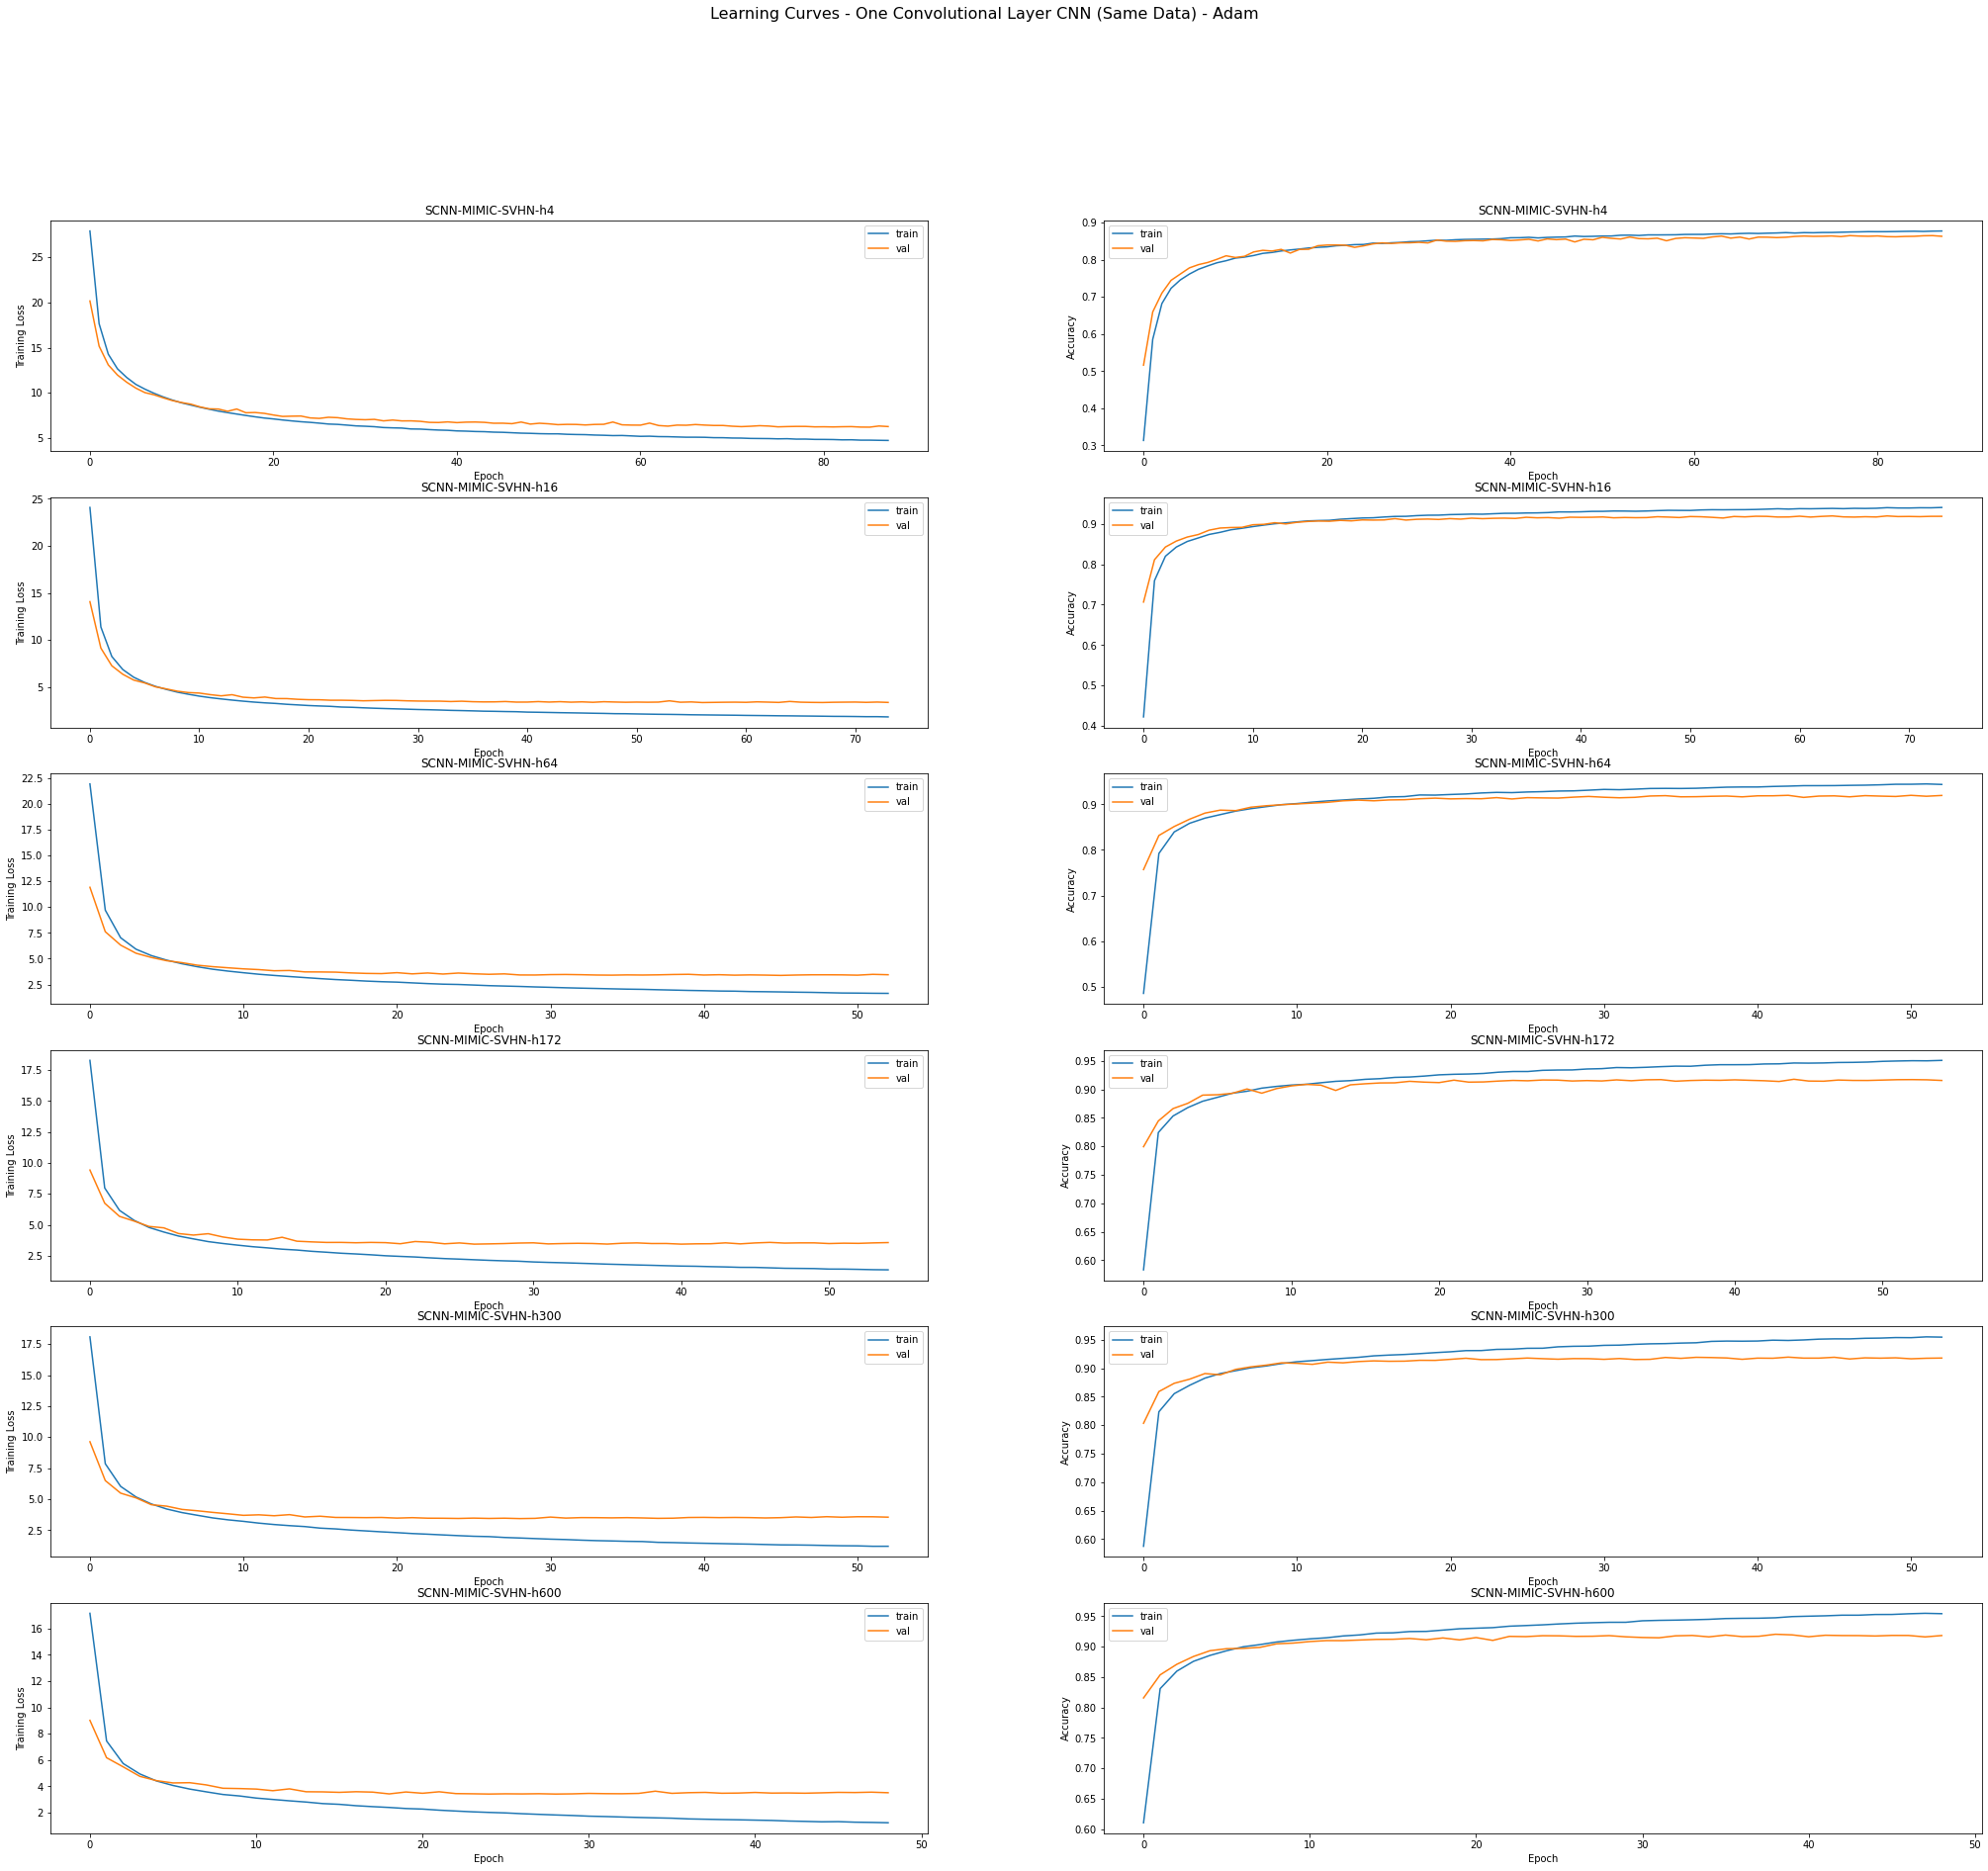

In [ ]:
fig = plt.figure()
fig.suptitle('Learning Curves - One Convolutional Layer CNN (Same Data) - Adam', fontsize=16)
fig.set_size_inches(35, 30)

plt.subplot(6, 2, 1)
plt.plot(loss_train_4, label='train');
plt.plot(loss_test_4, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h4')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(6, 2, 2)
plt.plot(acc_train_4, label='train');
plt.plot(acc_test_4, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h4')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(6, 2, 3)
plt.plot(loss_train_16, label='train');
plt.plot(loss_test_16, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h16')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(6, 2, 4)
plt.plot(acc_train_16, label='train');
plt.plot(acc_test_16, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h16')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(6, 2, 5)
plt.plot(loss_train_64, label='train');
plt.plot(loss_test_64, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(6, 2, 6)
plt.plot(acc_train_64, label='train');
plt.plot(acc_test_64, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(6, 2, 7)
plt.plot(loss_train_172, label='train');
plt.plot(loss_test_172, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h172')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(6, 2, 8)
plt.plot(acc_train_172, label='train');
plt.plot(acc_test_172, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h172')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(6, 2, 9)
plt.plot(loss_train_300, label='train');
plt.plot(loss_test_300, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h300')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(6, 2, 10)
plt.plot(acc_train_300, label='train');
plt.plot(acc_test_300, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h300')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(6, 2,11)
plt.plot(loss_train_600, label='train');
plt.plot(loss_test_600, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h600')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(6, 2, 12)
plt.plot(acc_train_600, label='train');
plt.plot(acc_test_600, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h600')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

##### Learning Curves for Same Data - SGD

In [ ]:
loss_train_4 = [34.29734111060442, 29.24236762361939, 20.543849255405853, 15.013178576191235, 12.630829656454658, 11.299241494754101, 10.426873138339209, 9.783952054773192, 9.270503326219439, 8.837149214193323, 8.455735622425859, 8.10762215388044, 7.807294481865081, 7.532199087249532, 7.295233412474844, 7.057897917950339, 6.861458329029147, 6.653546527131569, 6.471095814089372, 6.3299676813614285, 6.167350350812722, 6.01223993677296, 5.887592062271961, 5.775170371536712, 5.627654025835568, 5.543741441039479, 5.45157618802945, 5.337138050117749, 5.23793312645886, 5.140081130773803, 5.079752597511043, 4.985086041165643, 4.9282048412948205, 4.842656830005827, 4.773164885301006, 4.712069755385286, 4.642626438770631, 4.594212296867257, 4.529636819512555, 4.470737998235979, 4.4298723903636805, 4.390316014167403, 4.337676116324012, 4.2791229934031705, 4.244968749024276, 4.214396415038703, 4.159926789621172, 4.125939146327785, 4.098573200540549, 4.041131356763063, 4.004894633049465, 3.98020458367485, 3.957835642338084, 3.91957940333594, 3.904320595628745, 3.854573313582321, 3.826420550191375, 3.812696575620111, 3.7781279848232354, 3.7395732559713117, 3.7310637614536017, 3.7132168267532153, 3.6779177378452776, 3.6621764546988227, 3.6262928041985862, 3.6147195451445326, 3.5846771076325417, 3.561895615049072, 3.5650649139086, 3.522616733258601, 3.510072075927047, 3.4894640379844595, 3.470650883659081, 3.445332315807995, 3.4445936309468492, 3.4150426911693437, 3.4072247289734565, 3.378908031892577, 3.3809611061796905, 3.322256087614056, 3.338482527110003, 3.321245030548861, 3.3106065680514667, 3.288479260480523, 3.2673301899904033, 3.256047324696536, 3.2597440493329577, 3.2284347758583216, 3.2126884329126777, 3.1939589451649177, 3.190648434758339, 3.176638220044271, 3.168996049625334, 3.1443898156889163, 3.1383210240284254, 3.1290130396078863, 3.1376541292654165, 3.103256921118899, 3.100434086923052, 3.0852789553875057, 3.063652204903774, 3.070518787903302, 3.0586740331289337, 3.038460622140139, 3.026024974164433, 3.034729983474846, 3.003956042576056, 2.9960490387318615, 2.9840711143803813]
loss_test_4 = [32.58574358205668, 24.445337485590173, 16.69565043343959, 13.266544809114924, 11.885885079050858, 10.923765130164094, 10.794985493902884, 9.728951235465784, 9.035714242421243, 8.91992306299233, 8.368312341542703, 8.541344821241557, 7.957269090985197, 8.404677740576616, 7.4704947937651145, 7.277213572154044, 7.1894754569386645, 7.033681388504024, 6.76078382945601, 6.934893515407469, 6.850083363892568, 6.767660609497062, 6.720739604799988, 6.618697065686125, 6.284090151072134, 6.226214438034087, 6.641439927721037, 6.096388400919022, 6.0011086929960715, 5.913703045362077, 6.07407790925247, 5.882543044177489, 5.899989060290745, 5.7177040416166625, 5.620686492144069, 5.74283431326793, 5.537958489068375, 5.626377689294922, 5.64271410807475, 5.46012944443578, 5.475502402997883, 5.5888149844405755, 5.4008291757663285, 5.390438432742949, 5.32110658526388, 5.437346524955339, 5.285214210122848, 5.305363380287372, 5.3878585056239325, 5.207854472969257, 5.307933939762725, 5.168749776590792, 5.275546809541961, 5.31711015745554, 5.16684357286183, 5.083254664444774, 5.046402200271352, 5.1736212285724195, 5.056338158976404, 5.04264396570629, 5.209465051979567, 5.036221874694241, 5.011435833649006, 4.991320343965264, 5.1035776543155125, 5.0283490306459555, 5.083387216583094, 5.069225997961254, 5.133662403329552, 5.208003817377864, 5.030898237111234, 5.165123355020892, 4.915480191545541, 5.012629617539514, 4.925487729326936, 4.996416359432011, 4.866438472788418, 5.02521202221224, 4.949729724689289, 4.928843893316187, 5.085892503391092, 4.9815918269978825, 4.829854622975484, 4.941023674552765, 5.064933254326298, 4.928212391298519, 4.909966422337963, 5.179333944448252, 4.811643524180336, 4.9356167577441, 4.846745422164371, 5.307955630451091, 4.872486581575861, 4.9073811817976285, 4.917107446318014, 4.797547551409456, 4.849185890491433, 4.875118552678405, 4.845597524900694, 4.8581161810145685, 4.856718534463877, 5.001130981455726, 5.182086250347874, 4.91461062997604, 4.993021622792378, 4.89662292782739, 4.785959913793757, 4.8154341965596466, 4.792262104473379]
acc_train_4 = [0.19218496715348182, 0.28098285129102624, 0.5143929698678599, 0.6758979608953412, 0.7329067485221223, 0.7605665045807298, 0.7772545004926356, 0.7923214742789729, 0.8014845150087222, 0.8098114495635003, 0.8161078405913187, 0.823359781578431, 0.8299291869508011, 0.8352017746404132, 0.8392628615397396, 0.8424195888129713, 0.8449279071965139, 0.849842163639949, 0.853135398051385, 0.854568722833699, 0.8572306117103445, 0.8606944799880893, 0.8631857350197844, 0.8632881153047863, 0.8668714273546491, 0.867366265640376, 0.8685265761869636, 0.8705741830850947, 0.8714273526363228, 0.8750277280502378, 0.8747888405904175, 0.8770582714805769, 0.8777237436834654, 0.8793959560171348, 0.8798907943415099, 0.8802661888479993, 0.8815630066100877, 0.8830304581662736, 0.8838665643076818, 0.8844296561869203, 0.8862042487791482, 0.8866990871421714, 0.8881153485075461, 0.8881324119051612, 0.8883712993527769, 0.888644313600708, 0.8903165258621663, 0.8912208855655573, 0.8906066035005931, 0.8920740550638985, 0.8928930979114315, 0.8932855557962119, 0.8936609504644135, 0.894906577970599, 0.8940534084142856, 0.8973295793436908, 0.8961522054574603, 0.8967152973173746, 0.8970395017245881, 0.898524016762805, 0.8975684669072509, 0.8995990103447095, 0.8992406791178564, 0.8993771862540266, 0.8998720245661971, 0.9008958279959385, 0.9013736028840503, 0.9025851036743361, 0.9020220117879783, 0.9025851036672167, 0.9031993856670892, 0.903728350830428, 0.9037624775727712, 0.9040696185823696, 0.9044108864573751, 0.9053493729346381, 0.9052981827173834, 0.9056735773276128, 0.9058612746301847, 0.9069362682049699, 0.9065950003757319, 0.9072263458240725, 0.9064926200907301, 0.9074140431652926, 0.9071751557370011, 0.9081648323399837, 0.9083354662256166, 0.9090862554145464, 0.9095640303677498, 0.9094616500705432, 0.9094787133959472, 0.9098882348064921, 0.9105878337710478, 0.9104001365478063, 0.9108779114287986, 0.9112362426434469, 0.9117993344891225, 0.9111679890672254, 0.9118163979060617, 0.9121406022868316, 0.9118334613423249, 0.912686630874229, 0.9129084549049054, 0.9121917924969669, 0.913147342371845, 0.9136251172599568, 0.9140005119352778, 0.9135739271077938, 0.9135398003654506]
acc_test_4 = [0.19430794435676055, 0.4121621621865703, 0.6244881245369407, 0.720447720350088, 0.7544362545013428, 0.7749795250446133, 0.7809855309204426, 0.7985940485940486, 0.8120393121532167, 0.81367731372613, 0.8250068249905529, 0.8233688234176396, 0.8284193284681447, 0.8305350806489852, 0.8430930931419094, 0.8427518427355707, 0.8413185914324959, 0.8510101009450127, 0.8497815997653277, 0.8514878514715793, 0.8553781053618333, 0.8559923559760839, 0.8529893529730809, 0.8458230958719121, 0.8609746110234272, 0.859063609047337, 0.8514878515366677, 0.8633633633470913, 0.8635681134867531, 0.864114114097842, 0.8659568658755056, 0.8680726179912577, 0.8648648649136811, 0.8706661206498486, 0.8714168714005993, 0.8682773682610961, 0.8727136226322623, 0.8714851215339378, 0.8718946219434381, 0.8746928746766026, 0.8734643735131897, 0.8762626262951704, 0.8736691235877633, 0.8716898716735996, 0.8765356265193545, 0.8742833742671022, 0.8746928747905072, 0.8754436254924417, 0.8753071254047579, 0.8781053782192827, 0.8769451268637666, 0.877764127812944, 0.8752388751575149, 0.8822003823142868, 0.8783783784271947, 0.8819273819761981, 0.8798798799286961, 0.8798798799286961, 0.8802893802080198, 0.8815178814365211, 0.8801528800877918, 0.8800163799350196, 0.8849986349172746, 0.8823368823694265, 0.8845208844395241, 0.8830876331364493, 0.8845891347030391, 0.8803576304064467, 0.8802211302699465, 0.8810401311540357, 0.8836336335522732, 0.8822003823142868, 0.886977886961615, 0.8840431341570386, 0.8854763855252017, 0.8847256348395394, 0.8867731367568646, 0.8877286377123657, 0.8858858859997905, 0.884725634774451, 0.886431886350526, 0.8858858859347022, 0.886773136821953, 0.8860906361394524, 0.8856811356648636, 0.8867731366917764, 0.8877968877806157, 0.8875238875727037, 0.888138138121866, 0.8871826371663651, 0.8870461371600417, 0.8843843843681123, 0.8861588862077024, 0.8887523886710283, 0.8873191373028653, 0.8886158885996165, 0.8887523887361166, 0.8896396397372721, 0.8906633905820303, 0.8888888888726169, 0.8899808899646179, 0.8856811355997752, 0.8861588862077024, 0.8892301392138672, 0.8892301391487788, 0.8876603875790272, 0.8886841386027783, 0.8891618890805287, 0.8902538903515228]

loss_train_16 = [33.58781435305567, 23.588053628647963, 15.274943144949372, 11.904319305572887, 10.151287208503753, 8.998188634964704, 8.184722049707602, 7.590287626925695, 7.078245129319611, 6.637666349961849, 6.33647338126607, 6.009914768385954, 5.755317521093242, 5.530701509720941, 5.324017168114529, 5.136055237599459, 4.958804215067595, 4.820284743911526, 4.683255469165415, 4.556540246852357, 4.456311984908793, 4.3293992715508, 4.240045059761612, 4.1386550206351265, 4.0379165071033905, 3.951390930101251, 3.910175456399448, 3.8075248933349, 3.741188516243358, 3.67422384334174, 3.615466466180681, 3.5575399061954323, 3.5079357854112323, 3.4395770099380503, 3.3814127193397554, 3.3331802552698946, 3.286029942565969, 3.2553113380274605, 3.1850134395005076, 3.1480031595448974, 3.1180748619222465, 3.0511533409852887, 3.04804474616069, 3.003422182743973, 2.972295693079468, 2.92755549858174, 2.9153253086068283, 2.845082133781095, 2.846371042406017, 2.791903592006266, 2.7788856862968636, 2.737907149024653, 2.7147181484034295, 2.6905741252505364, 2.673527901063406, 2.6579230391565276, 2.597264911505806, 2.5949439926528246, 2.570163488953545, 2.5483834686707274, 2.5150895631350956, 2.5013206095207714, 2.513797306560858, 2.4633021740180703, 2.4350755322784017, 2.4232848710650092]
loss_test_16 = [30.530257264349977, 17.196965654463252, 13.030302311467434, 11.741886949656344, 9.168130303418542, 8.368302796468232, 7.732792069473912, 7.283991237888237, 7.5956943149030325, 7.15933462221571, 6.236028007493786, 6.01504226606985, 5.845496062466983, 5.7195746348654675, 5.50787905790166, 5.278855061355328, 5.291926587177957, 5.333022980295567, 5.270265753790553, 5.400852157156422, 4.9586258822375235, 4.799011496810226, 5.075624712887534, 4.640987534227509, 4.679675791909908, 4.535983158531262, 4.603671829068462, 4.510577821223879, 4.4333671763266755, 4.405442621875193, 4.603226447541499, 4.284396658821116, 4.8436248469736745, 4.398955969350962, 4.121095445681361, 4.361805806484113, 4.106656726058181, 4.202577639758636, 4.012436369680623, 4.080865597809529, 4.196182175929709, 3.9715011969896215, 3.996064298178308, 4.098965683629075, 3.9856968992172352, 3.89187630154284, 3.906697187402878, 3.858761908543946, 3.929209649416387, 3.8367234811150177, 4.171251218110005, 3.876824662882612, 4.487152576706887, 3.98809465019878, 4.099810453050943, 3.754500268880962, 3.9377672724342396, 3.7379374187760037, 3.9406842470754864, 3.9002705368877204, 3.8133821583106613, 4.037840393440273, 3.828441769771487, 3.869997098932102, 3.608308457690381, 3.6879090988795484]
acc_train_16 = [0.19517106047598903, 0.42950260217315295, 0.6587833802810495, 0.7451923897125831, 0.7829877996727445, 0.8079686033899656, 0.8223701049154422, 0.8332394847140846, 0.8415834826064714, 0.8503199385545043, 0.8562579984205614, 0.8616329664795912, 0.8655063561149937, 0.8691920484356196, 0.873270198802738, 0.8777408071319334, 0.8802320621514237, 0.8825526831866267, 0.8857435372042357, 0.8878764610284018, 0.8896851804789174, 0.8914938998928189, 0.8933026192324752, 0.8946847538819503, 0.8971077552601274, 0.8990700451864561, 0.8984898899624895, 0.9013224127390067, 0.9031652589247461, 0.9046668372761623, 0.9050592952840066, 0.9067997611532154, 0.9072434092867793, 0.9086084804542235, 0.9097176009279786, 0.9106560873787981, 0.9120552853465579, 0.9123794897853, 0.9133179762574778, 0.9142393993828933, 0.9147513011170881, 0.9161334357014717, 0.9162358160322411, 0.9170377953590951, 0.9170377954435108, 0.9189488951790283, 0.9190000853576348, 0.919580240646693, 0.9202798395848053, 0.920996501999863, 0.9224980804021321, 0.9220032420970812, 0.923334186536421, 0.9239825953366091, 0.9237778346242174, 0.9239655319847616, 0.9255694906069408, 0.9249552086335117, 0.9256889344441506, 0.925961948646314, 0.9265250404869042, 0.9263373432636627, 0.9277877314557965, 0.9276341608762436, 0.9280266189420603, 0.9289309785539162]
acc_test_16 =[0.21956046953606143, 0.5881790882116323, 0.7158067157578996, 0.7442669942019059, 0.8073300573300574, 0.8229593230732275, 0.8327873327222445, 0.8484848484685764, 0.8485530984717381, 0.8619983619170016, 0.8636363637339961, 0.8687551188527513, 0.8639776138962536, 0.8742833742508301, 0.8745563745401025, 0.8798798798636078, 0.8792656293795339, 0.8820638819825216, 0.8818591319079481, 0.8785831285668565, 0.8853398852585249, 0.8906633907122069, 0.8939393938580336, 0.8945536444722841, 0.895440895359535, 0.8970106470594633, 0.8963281463118743, 0.8961916462892787, 0.8966693965880362, 0.897078897062625, 0.899467649565282, 0.9009009008195404, 0.895782145830962, 0.8992628991815388, 0.9032214031400428, 0.9004231505207829, 0.9037674038650363, 0.9027436526622923, 0.9035626534812932, 0.9072481571667969, 0.9040404039590436, 0.9075894075080472, 0.9065656564842961, 0.9065656565493845, 0.9076576575762972, 0.9078624077810474, 0.9101146600332997, 0.9076576575762972, 0.9090226589412986, 0.9099781598967995, 0.9077259078235402, 0.9106606607582932, 0.9036309035495432, 0.9058149057335454, 0.9108654107840505, 0.9145509144695542, 0.908476658395298, 0.9138001638977963, 0.9092274091460488, 0.9102511601697998, 0.9103876604852928, 0.9092274092111371, 0.9129129128315525, 0.9125034124220521, 0.9139366639203919, 0.9140731639918036]

loss_train_64 = [33.81070936740172, 24.063804021209958, 15.677872012570981, 12.116496190332368, 10.001010828642254, 8.59425344400444, 7.640402639779751, 6.9179892464308965, 6.410604523705212, 5.963169022686967, 5.645716995286124, 5.357331354277765, 5.079421707314748, 4.876311834325726, 4.6722403988131544, 4.488273204433746, 4.32819531676448, 4.193208418005553, 4.053949775749501, 3.920720962297895, 3.808482780998431, 3.7011113716711637, 3.6303674558742536, 3.529341646547092, 3.4275082443000695, 3.367662146693356, 3.262013889125931, 3.228204335125729, 3.1503077054957402, 3.0791436144439306, 3.0252850779798717, 2.95800742235274, 2.906328678456562, 2.8525600652749215, 2.823740777020649, 2.7618568689848986, 2.732624470326144, 2.6806465720349273, 2.6479586872526855, 2.6081096855917334, 2.55854807737266, 2.5347239428092956, 2.5129731876310477, 2.4646133428221626, 2.4467246960987463, 2.403716089192353, 2.3880602602970478, 2.356134930792832, 2.3199270757023114, 2.309851119229639, 2.2692479870199556, 2.2484404692297124, 2.229468724142009, 2.2090645594235196, 2.180107503949899, 2.169346913788142, 2.1245752124307953, 2.127084421592812, 2.0979532648318764, 2.074340963619946, 2.0633164871879104, 2.0549964556788822, 2.0337440726130747, 2.002663933997898, 1.997627008293851, 1.970131215946675, 1.9587956673516602, 1.9520375612947418, 1.9230496893562907]
loss_test_64 = [30.914007366533458, 17.472189722574054, 13.519867394291374, 11.175133025356567, 9.77927922955179, 7.804707423800365, 7.44360283102587, 6.686563024096498, 6.28826791290504, 5.900953312373181, 5.76901529553221, 5.486099625232602, 5.963180631423563, 5.139434641187972, 4.773662946994207, 5.005888950359356, 4.670070000304051, 4.739822566427886, 4.563409967888518, 4.321278433639626, 4.220641762058884, 4.209726913815602, 4.210542407414642, 4.963300169018686, 3.94023378761681, 4.0003096614741835, 3.9385567911003836, 3.9530059603957444, 4.154712709481033, 4.0004537321002696, 3.974542751619473, 3.65911422835456, 3.7666887139610146, 3.7726951956976773, 3.5904434086552026, 3.7239219253257816, 3.5654539301718904, 3.5199721636682333, 3.4839028917698465, 3.584429684799615, 3.5662182370658915, 3.4250861944932285, 3.784736808128055, 3.499223486829774, 3.565356028265488, 3.411338580946697, 3.4758857790316644, 3.4687840998449384, 3.3874080032069536, 3.783770072274673, 3.553245764757615, 3.2733534714774035, 3.424518400289112, 3.4784283112737606, 3.414704759427507, 3.2795718597513126, 3.2665231209650023, 3.238232997412113, 3.2983271096724485, 3.2585365197517295, 3.256676919988163, 3.3043335150604913, 3.2578508325395057, 3.2023676320434493, 3.311622796604095, 3.4646326161914924, 3.5832422927790835, 3.363815682981628, 3.3901484282069476]
acc_train_64 = [0.19401074992558745, 0.4151864175523531, 0.6437334698638496, 0.7373773569092898, 0.7829877996320621, 0.812217387611188, 0.8308847368256792, 0.8433068850465363, 0.8528282569309275, 0.8618206637221568, 0.8676563432910074, 0.8720928248920983, 0.876205101948673, 0.8794300827065911, 0.8836276767878553, 0.8873645593328552, 0.8907260472991546, 0.8923470693118295, 0.8956403037110608, 0.8975002133259441, 0.8998037709848902, 0.9017489975786953, 0.9031993857708291, 0.9052640560014837, 0.9063390495833882, 0.908557290328504, 0.9104171998660909, 0.9106731507428504, 0.9127378209541809, 0.9146830474900137, 0.9148366180237991, 0.9161163722916519, 0.9172084293677919, 0.918812387970647, 0.9186246907789343, 0.9207576145522475, 0.9207746778776515, 0.9215937207251845, 0.9230952990043897, 0.9241702925984988, 0.9250234621954945, 0.9252623495973424, 0.9261496459031184, 0.926098455724512, 0.9271563859616884, 0.9274635270363784, 0.9283508233157108, 0.9292722464482457, 0.9290845490612579, 0.9299035918314946, 0.9300400989941083, 0.9308932685066883, 0.9307396980044317, 0.9316099309003879, 0.9325825442044099, 0.9328043682350863, 0.9339646787887933, 0.9341182492839305, 0.934391263558305, 0.9344765804914594, 0.9352444330830896, 0.9352444330759702, 0.9359269687151219, 0.9361999829894965, 0.9369337087614872, 0.9367289480490953, 0.9375138640576647, 0.9379233854295613, 0.9389642521460586]
acc_test_64 = [0.2158067158636681, 0.5850395849582246, 0.7007917008730612, 0.7493857492718448, 0.7937482938133821, 0.8359268359756522, 0.8462325962814125, 0.855173355157083, 0.8613841114817439, 0.8671853672829997, 0.8723723722910119, 0.882814632847177, 0.8671853672992718, 0.8839748838935235, 0.8884793884631164, 0.8885476384662782, 0.8932568931755328, 0.8914823915149357, 0.8973518972705369, 0.8965328965166245, 0.8973518973356253, 0.8985121484307881, 0.8998771499259661, 0.8974201475177799, 0.9052689053665378, 0.9051324052300377, 0.9037674038650363, 0.9052006552982877, 0.9043134042320439, 0.9004231505207829, 0.910046410030138, 0.9118209119185443, 0.9097051597377038, 0.9112749113725438, 0.9087496586682984, 0.9120939120125516, 0.9101146602122926, 0.9118209117395514, 0.9146191646517088, 0.9148921648758928, 0.9119574120550444, 0.9165301666277991, 0.9138001638977963, 0.9137319138295462, 0.9145509144695542, 0.9174856675833, 0.9181681682007123, 0.9171444170630567, 0.9180999181975507, 0.9153699154675479, 0.9160524159710556, 0.9194649195625519, 0.918441168538801, 0.9161206662182986, 0.9187141686978967, 0.918441168538801, 0.9203521704498029, 0.9216489216814658, 0.921853671886216, 0.9203521704498029, 0.9207616706803103, 0.9198744197930595, 0.9202156703133028, 0.9213759214735538, 0.9210346709533106, 0.9199426699263978, 0.9174856675833, 0.9204204204529646, 0.9208299207485604]

loss_train_172 = [34.05037760913967, 26.451690036352865, 15.081792864536284, 10.451596691555338, 8.446938609954858, 7.3513015065886, 6.6252976552769445, 6.071252978046379, 5.629338361020687, 5.308401868717834, 5.023545662240663, 4.751247777858292, 4.547760633311269, 4.351961386532276, 4.20646505132896, 4.058999513768161, 3.892854265714707, 3.77774983048795, 3.662637297727378, 3.554864162862143, 3.4545705149904187, 3.385321220555471, 3.2947265541926756, 3.2135135073678485, 3.136880085564099, 3.075825785703702, 2.999557148670847, 2.9252302479188645, 2.88630674767541, 2.8452242934289886, 2.7875238387213055, 2.7324433607591745, 2.6911389658001745, 2.6663150160520743, 2.6041599586853934, 2.5578247045211526, 2.5374270682346696, 2.491953616992126, 2.465242576688622, 2.421899243160255, 2.414352712439205, 2.355542318630357, 2.338000821664506, 2.3187115825633224, 2.2934330513855468, 2.2718559189915157, 2.2421777365425526, 2.2062820551857363, 2.1847302205590458, 2.1623858326501115, 2.138052860692381, 2.1384142458983, 2.1099288927248625, 2.073553125146977, 2.0572741126639884, 2.0461602359163447, 2.0197773299377104, 2.0059347044556084, 1.9762511730722963, 1.9792307847555703, 1.9697554514215074, 1.9347200038235561, 1.9268716059307953, 1.9051526746513108, 1.8954334616569537]
loss_test_172 = [32.42087413872196, 18.591270356174377, 11.640228770842098, 8.681493630801073, 7.783675112946907, 7.376257135019971, 6.311703022600945, 6.214168441578758, 5.348870773638268, 6.156208382517205, 5.355551566057051, 4.840908308677455, 5.090727322354787, 4.477344918309617, 4.397496991036467, 4.481066982765, 4.164924744338635, 4.727296262564569, 4.592434857993577, 4.219051443420731, 3.8938176607844803, 3.7694408468558365, 3.724651341942077, 3.7228612610137173, 3.793591254856819, 3.8013364587232386, 3.606120488176963, 3.5783443014835874, 3.670197647580546, 3.5946139201029643, 3.4990146087877676, 3.8037829217512424, 3.3775642204571055, 3.4061286692862756, 3.517604641467862, 3.45787712162777, 3.3837068259895027, 3.3787058102052914, 3.296314392524634, 3.28618668754863, 3.521331028634982, 3.295992086013744, 3.295031664900659, 3.2618567354523544, 3.405514132478606, 3.2467458267014044, 3.1775126602361348, 3.3004308962737348, 3.2645303513097073, 3.152545258935735, 3.4320711282443193, 3.1837857877365265, 3.2553858319625415, 3.1854729075071235, 3.1555924764461865, 3.202054563520256, 3.3210294337146373, 3.0957184858475753, 3.2543452962838395, 3.2700227291701824, 3.106655758780402, 3.116080780352135, 3.1158328611538963, 3.0854438852814745, 3.174937194792456]
acc_train_172 = [0.19249210818952367, 0.34058527430010455, 0.6567357734530953, 0.7742172169701637, 0.8170633904590774, 0.8361402610332606, 0.8484429655735347, 0.8585444928313998, 0.8666496032324376, 0.8719904444962371, 0.8767170036899872, 0.8806586468487243, 0.8849927480346299, 0.8889685180852177, 0.8920911185388098, 0.8955891135060109, 0.8975343400876113, 0.899428376393985, 0.9023462162267205, 0.9044791399542661, 0.9066461906316348, 0.9080965788430926, 0.9103489463498757, 0.9112362426292082, 0.9128913915723819, 0.9141370190785674, 0.9155362170605659, 0.9177373943694185, 0.9175838239007248, 0.9190854022572262, 0.9202286494733246, 0.9222421295446968, 0.922242129479605, 0.9231806160026357, 0.9243579899010709, 0.9245798140426065, 0.9253306032437411, 0.9264055967798779, 0.9274635270557025, 0.9278047948656163, 0.928333759886567, 0.9293916901623915, 0.9296988311262223, 0.9303301766396546, 0.9314734238221899, 0.931217472918987, 0.9323607200821983, 0.9328384949967536, 0.9334357136834269, 0.9344083269223572, 0.9346813411509641, 0.9341011858934347, 0.9355857008665599, 0.935398003636199, 0.9359269686764737, 0.9369166453516673, 0.9374968005827533, 0.9377698148306843, 0.9385206040775864, 0.9385035406148797, 0.938384096972945, 0.9397321047305695, 0.9394590905019625, 0.9403805136416168, 0.9405682108526536]
acc_test_172 =[0.19417144422026042, 0.5754163255139579, 0.7590090090740973, 0.8180453180941343, 0.8408408409384733, 0.8478023479162524, 0.8529211028397425, 0.8537401036587433, 0.8778323778161058, 0.8684138685115009, 0.8824051323237719, 0.8897078896916176, 0.8906633905820303, 0.8901856402832727, 0.892437892356532, 0.8974201474526916, 0.90042315034179, 0.8869096369421811, 0.8938711437897835, 0.9006961506798786, 0.9036309036797199, 0.907111657095385, 0.9099099099424541, 0.9069069068906348, 0.9067704067541347, 0.9092956592793872, 0.9118891619379781, 0.9108654107840505, 0.9098416597602994, 0.9129811630299792, 0.9125716624903022, 0.9103194104170428, 0.9158476659452983, 0.9152334153310477, 0.9131859132835457, 0.9157111656948936, 0.9153016653342094, 0.9179634179959621, 0.9186459186133745, 0.91584766588021, 0.9123669123994566, 0.9189871690848015, 0.9197379196565593, 0.9203521704498029, 0.9183729184054625, 0.9194649195625519, 0.9181681682007123, 0.9191236690423087, 0.9213759214084656, 0.9193966693641252, 0.9182364182689624, 0.9204886704723984, 0.9204886704561264, 0.9206251706577148, 0.9226726726401285, 0.9203521703847145, 0.9183046683372125, 0.921853671886216, 0.9212394211580608, 0.9212394213370537, 0.9213076714053038, 0.9209664208850605, 0.9216489217465541, 0.9221949222274664, 0.9211029210215607]

loss_train_300 = [34.03265222842839, 26.305938131688613, 15.172805972604172, 10.543047028199751, 8.512548658447292, 7.395039227142868, 6.63305183773856, 6.11507322845804, 5.66714582154393, 5.3204959124654705, 5.029723302338191, 4.792394305483777, 4.584591133250138, 4.38803742409322, 4.203907431568386, 4.046598131991665, 3.929666730594985, 3.7951947334957716, 3.6752417415983083, 3.560622572888694, 3.4514221060612678, 3.3795561932854334, 3.294800291137884, 3.2168383285196027, 3.1345636797199457, 3.068014095460338, 2.9847106612895233, 2.94149662210575, 2.9034392572936216, 2.8323408031390396, 2.783531314184942, 2.7254431679106217, 2.6823596150789046, 2.643324750401992, 2.6004487305917734, 2.5541181451681787, 2.518501902301913, 2.4917415839028374, 2.442271287591168, 2.410655361022897, 2.385940312033332, 2.3519582027807626, 2.3219682841768403, 2.301491751633003, 2.2691633270824436, 2.2431060520234283, 2.2296889899645778, 2.1865355085100027, 2.1652001692506095, 2.1429375546304614, 2.126715000850859, 2.1143399633123305, 2.0968410547596736, 2.0557484782298427, 2.045552025759915, 2.0204440401800765, 2.0047617241238056, 1.9957063050006052, 1.9630243349498413, 1.9560222407105778, 1.934333525732428, 1.9293838941321704, 1.9129581317896729, 1.90091488871718, 1.8807864162602752, 1.8544575746551064, 1.8464346017521016, 1.834926217054509, 1.815118734792438, 1.7914114933210818, 1.7963070707245499, 1.7904191594859784, 1.76178850231597, 1.747399954215708, 1.7383112877752276]
loss_test_300 = [32.290416292632635, 19.565318390088365, 11.936095598581675, 8.951155959860145, 7.995636055712293, 7.143533652121013, 6.248114200032802, 5.922141502243946, 5.45829044871079, 5.263451169691156, 4.912435034992198, 5.322814345197082, 4.8224929306567645, 4.551946392028084, 4.8185288986156065, 4.323911106329358, 4.326479277192911, 4.304308952869953, 4.073127986302377, 3.9389450108129536, 3.941319052131001, 3.952042812927479, 3.838521236609215, 4.186735313966435, 3.747016642024014, 3.667525559541732, 3.5801399140093713, 3.9546553099249806, 3.670664950729295, 3.9460980249108624, 3.56842756753016, 3.468273250906317, 3.677979270389358, 3.4617328083388244, 3.3977035697027858, 3.4156655693132305, 3.350753573749093, 3.3070586407864773, 3.378187739064776, 3.325613837472539, 3.2111817243936898, 3.243056203509952, 3.2822775586914763, 3.441840052962661, 3.2851604094050995, 3.2601911441048994, 3.2506958391703513, 3.2533733376771936, 3.2123958698687187, 3.2637273449081556, 3.184417942915658, 3.220825795036439, 3.260988875226899, 3.187656691254666, 3.2309003041606115, 3.2227771726098506, 3.197468929722958, 3.3709328971923194, 3.220335918536383, 3.0949223557684937, 3.1586047113185822, 3.212808955083478, 3.0682694483024644, 3.4986689968119546, 3.1563321031444946, 3.1969234648539726, 3.1292827116346347, 3.142800302086324, 3.090980943226274, 3.0554119675594897, 3.060855747994067, 3.264900259004406, 3.149457910755375, 3.2028566832884784, 3.1197116052782214]
acc_train_300 = [0.19237266445020576, 0.348076102708389, 0.6586980632899229, 0.7762648237960837, 0.8164832352473156, 0.8371981912826416, 0.8497397832776508, 0.859209964976316, 0.8668373005543336, 0.8717174302096579, 0.8753007422330772, 0.8815118163999524, 0.8854193328163463, 0.8894292295563904, 0.8917669141000677, 0.8947871341527134, 0.8985069533723092, 0.9003839262810678, 0.903148195599342, 0.9045815203887755, 0.905963654992483, 0.9072775360413271, 0.9095640303219822, 0.9109632284270447, 0.9129596450306249, 0.9136933708870312, 0.914819554679071, 0.9168671614999058, 0.9173790632727488, 0.9196314307724125, 0.920006825351113, 0.9216619742485191, 0.9226857776711412, 0.9234024400261927, 0.923794898014713, 0.9253476665498209, 0.925228222797027, 0.926712737854568, 0.9267127378088004, 0.9279071751699423, 0.9290504223524777, 0.9300742257557757, 0.9302277962315887, 0.9305178738700155, 0.9313027898521413, 0.9325484174234185, 0.9322242130040004, 0.9332821431425222, 0.9340670591002387, 0.9335722208145119, 0.9344765804578965, 0.935227369659031, 0.9352103063407464, 0.935619827712643, 0.9365241873051747, 0.9373091033259489, 0.9378210050601437, 0.9375650541376166, 0.9381793362676726, 0.9385717942683977, 0.9397832949285, 0.9395955976330475, 0.9400733725476027, 0.9406023377180608, 0.9402440064718837, 0.9411824929684708, 0.94099479563437, 0.9421551061880771, 0.9418479651784787, 0.9432812900258843, 0.9421551062460494, 0.943127719439212, 0.9434348605596696, 0.9438955720572858, 0.9432471631991254]
acc_test_300 = [0.19417144422026042, 0.5672945674084718, 0.7468604968604968, 0.8150423150911313, 0.8228228227414625, 0.8505323506462551, 0.865410865329505, 0.8711438712415036, 0.8782418782256062, 0.8806306305492702, 0.8838383837570234, 0.8797433797759239, 0.8869778870755195, 0.8926426425612822, 0.88745563755327, 0.8989898990875315, 0.9003549004525329, 0.8915506415180974, 0.9015151515476957, 0.9026754027730352, 0.9051324050510448, 0.9017881518206959, 0.9054054055030379, 0.9009009008683567, 0.9066339066664508, 0.9096369096043655, 0.9095004095329536, 0.9069751570077011, 0.9125034125359567, 0.9103194103519545, 0.9127081628057953, 0.9159841660817984, 0.9076576577552902, 0.9116844117820442, 0.9152334152659594, 0.9157111658087982, 0.9161206662182986, 0.916461916559549, 0.9167349168325493, 0.918509418607051, 0.9186459187435512, 0.9170079171055495, 0.9170761671087112, 0.9148921649897974, 0.9161206661532103, 0.9176904176578735, 0.9202156703133028, 0.9192601692276251, 0.9214441714116273, 0.9189189190165514, 0.9224679224353783, 0.9180999180185577, 0.9198744199069641, 0.9203521703847145, 0.920215670183126, 0.9219219219544661, 0.9203521703196261, 0.9223314222337898, 0.9241059241384683, 0.9222631721655398, 0.9213076712751271, 0.9203521702545379, 0.9229456729782172, 0.9161206660881219, 0.9262216762542204, 0.9242424242098801, 0.9253344252367929, 0.9223996724322165, 0.9223314223639665, 0.9243106743432185, 0.9239011739337181, 0.921102921070377, 0.9250614249637925, 0.921171171138627, 0.9232869233194675]

loss_train_600 = [34.03504966141553, 26.91930623877507, 15.536747035031514, 10.759867072872268, 8.612312833242333, 7.4022478889538235, 6.63709252166032, 6.106757293216565, 5.668416416286028, 5.349543544922904, 5.0450517675492375, 4.822317627621291, 4.60893080402342, 4.387088194374297, 4.226539865344389, 4.072193116220676, 3.922902188326716, 3.807784321344547, 3.681892245068667, 3.598204816330538, 3.4882954925738567, 3.3890127630529117, 3.2978554165492477, 3.2355415855574026, 3.152303249646185, 3.082992078098316, 3.0315222455193878, 2.972575417570608, 2.9133986185866507, 2.8517093692132205, 2.785506899553541, 2.7470782946384906, 2.6832429323960425, 2.6640727421131043, 2.6088007856845326, 2.5885727068698707, 2.535662698591135, 2.5144785701959025, 2.470783007139843, 2.43344187792246, 2.404131831615088, 2.369328074320603, 2.346678754248195, 2.309027337633336, 2.2846763213089063, 2.2536721612902473, 2.2435869734804537, 2.2146003632382336, 2.1997571141287975, 2.172867408688489, 2.135214416969149, 2.114396563756894, 2.0963805987295685, 2.07801757719663, 2.047316143531236, 2.0470914560600653, 2.024854694203238, 2.008317248063144, 1.987267825115501, 1.9620811235273101, 1.9566992664508023, 1.9299127934217228, 1.9142606532692696, 1.899791926640352, 1.8932306262049574, 1.8807276811527316, 1.8402787509931557, 1.8538433758698474, 1.837657411539273, 1.8099710327703669, 1.8031695430427879, 1.7893318524286208, 1.7708673598406086, 1.755671056028255, 1.7542769559118672, 1.7331256663979304, 1.7330437308966367, 1.7285044178662878, 1.7036573890186946, 1.6889778737921772, 1.6844474574667472, 1.664484544478121]
loss_test_600 = [32.455593501223, 18.846861555248932, 12.736474197808427, 9.25115492146685, 8.814354203745149, 7.2174646884992155, 6.298673359123436, 6.112368478236093, 5.733276248075843, 5.125673333641092, 4.939078061658113, 5.090341688016058, 4.594374707576326, 4.951987309629007, 4.478361976364744, 4.396999137960689, 4.321904548165449, 4.445475025382681, 4.104401401245884, 4.140994403910969, 3.9846067287998057, 3.8726913089346047, 3.9373384553683834, 3.944806336900949, 3.760287123627263, 3.710012904809467, 3.7147555411789477, 3.6243193148264883, 3.5680144211974523, 3.6107777827364678, 3.3917106068788447, 3.4736847207092567, 3.3864675828286477, 3.439033878327978, 3.580631821200459, 3.422733078945409, 3.6089523967224295, 3.3762091328269173, 3.4779389106996264, 3.551023923729145, 3.2842387640830957, 3.263313650661826, 3.630444150006156, 3.4755849631275924, 3.1694882623556366, 3.247225553911955, 3.4701339171422885, 3.283725441917838, 3.172611819177972, 3.321974045716769, 3.223448816948239, 3.30566217305066, 3.273397643221814, 3.344952210356816, 3.2169288357456884, 3.3114984176082753, 3.1250310869058104, 3.2466248674468203, 3.092303576900306, 3.352580891780244, 3.1005979954399048, 3.1059940351412787, 3.103457337547904, 3.1444678975687697, 3.314622373357029, 3.208599369284432, 3.3238962380052297, 3.1634652664711527, 3.0710823051011076, 3.345680795990311, 3.2361028309633846, 3.0383564820551268, 3.135578794099254, 3.1418104112522545, 3.2147413810159287, 3.2414922045776176, 3.055496059217773, 3.121961508557473, 3.1617550053233305, 3.210075723581421, 3.1253394298855475, 3.3219508160146702]
acc_train_600 =[0.19262861530382716, 0.33036430341962886, 0.6452521115793179, 0.7699854961079081, 0.8142308676296732, 0.8359184369832601, 0.8493985155328285, 0.8594829792242471, 0.8645849330089024, 0.8717515569835299, 0.8771606518621993, 0.881255865542517, 0.8849586212922868, 0.887671700368897, 0.8911014418900598, 0.8951113386372231, 0.89750021330662, 0.8983192560310891, 0.9023974063331158, 0.9026704205617229, 0.904547393607784, 0.9071410288980375, 0.9077211842399827, 0.910536643657533, 0.9116969541797112, 0.9142393994093369, 0.9148707447661423, 0.9155362170870094, 0.9164917669018812, 0.918436993437714, 0.9196655575605233, 0.9210988823163938, 0.9219861786943808, 0.9228393481733977, 0.9236754543005673, 0.9243921167013863, 0.9246821943011648, 0.9251429059482884, 0.9272417028877233, 0.9276512242931828, 0.9281289992392668, 0.9289821687447273, 0.9295793874507247, 0.9298524016600076, 0.9301424793177584, 0.9311492193834477, 0.9322924665659831, 0.9326849245209405, 0.9336575377598709, 0.9333845235383833, 0.9342718197983917, 0.9344083269223572, 0.9349543554639869, 0.9358075250080956, 0.9358075249887715, 0.9365071239990949, 0.9370702158661286, 0.9372408497904096, 0.9386912379367758, 0.9377527514859563, 0.9386059210229455, 0.9394590905090819, 0.9397491681281845, 0.9402781332528751, 0.9402951966169273, 0.9408070983582415, 0.9406535278173368, 0.9411313027512161, 0.9412848733572126, 0.9420868526189748, 0.9412848732921208, 0.9430082757515098, 0.9423428035679454, 0.9424963740824066, 0.9428547052370486, 0.9431618462202035, 0.9442368398865237, 0.9433324801200751, 0.9446122345038724, 0.944799931799325, 0.9455336575519916, 0.9452265165159497]
acc_test_600 = [0.1944444444932607, 0.5374692874530154, 0.7226317226479947, 0.8159295659132938, 0.8041905543044587, 0.8295795795633075, 0.8593366094505139, 0.863499863418503, 0.8720311221450266, 0.8830876331364493, 0.8836336336173616, 0.890799890848707, 0.8925061425549587, 0.8892301392138672, 0.8966693966531246, 0.8933251434227758, 0.8968741469717794, 0.8999453998640395, 0.9035626535463814, 0.9054054053891333, 0.9053371553208832, 0.9053371553208832, 0.9071799071636351, 0.9105241605078884, 0.909090909074637, 0.9107971607808887, 0.9068386567572965, 0.9115479114665511, 0.909432159350799, 0.9133224132410529, 0.915506415604048, 0.9142096643072967, 0.9146874146711426, 0.9122304123280447, 0.9119574120550444, 0.9162571662897104, 0.9107971607808887, 0.9139366639203919, 0.9144826644663924, 0.9165984166960491, 0.9198061697248093, 0.9185776684963082, 0.9126399127375452, 0.9159841659678939, 0.9200791701768026, 0.9191919192895517, 0.9161206660393058, 0.9171444170630567, 0.9194649194486474, 0.9173491672678069, 0.9219219219544661, 0.9184411684248963, 0.9219901720227162, 0.9171444171932334, 0.9228774229750554, 0.921512421610054, 0.9226726727703052, 0.9211029212005536, 0.9234916734754014, 0.9154381654707096, 0.9233551734528058, 0.9238329237515635, 0.9229456729782172, 0.9203521704498029, 0.9215806715643995, 0.9221266720453117, 0.9219901719738999, 0.9213076712913992, 0.9243106744083068, 0.921512421431061, 0.9211711712688037, 0.9249249250225574, 0.9231504230690627, 0.9230139229325626, 0.9226044225230622, 0.9229456729782172, 0.9249249250225574, 0.9245836746813071, 0.9221949221786501, 0.9223314224290549, 0.9233551732738129, 0.9227409226595623]

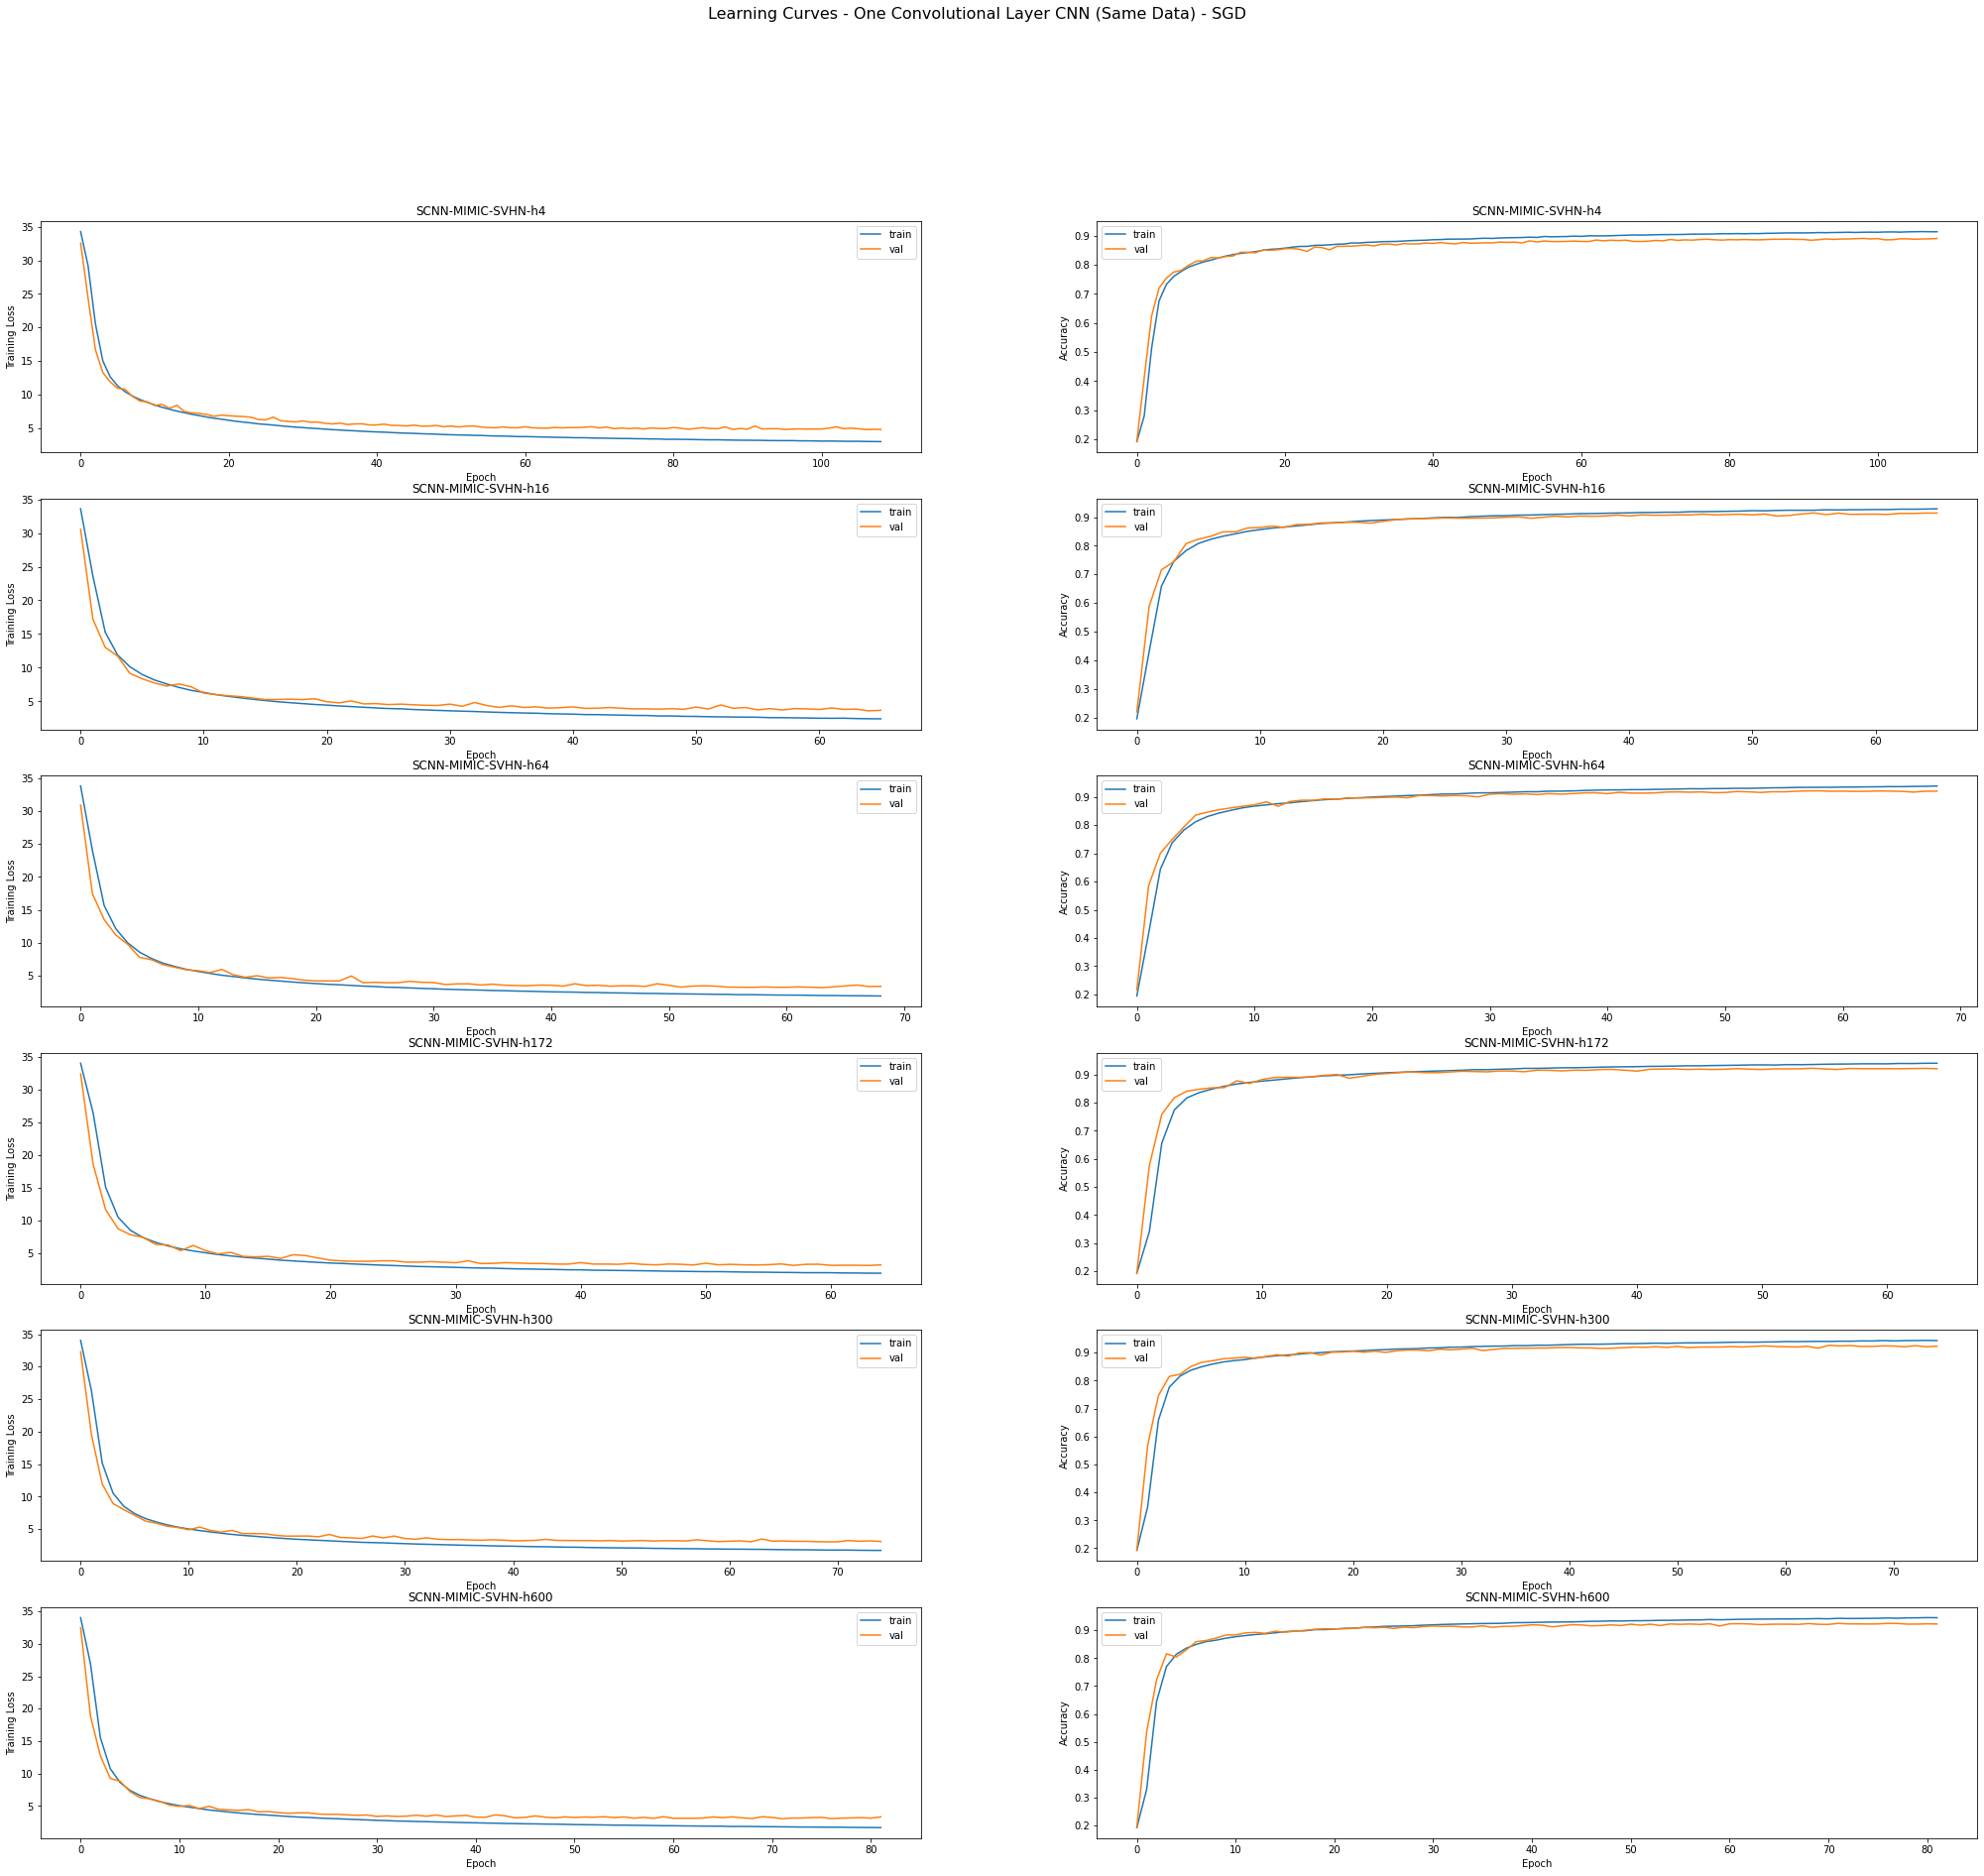

In [ ]:
fig = plt.figure()
fig.suptitle('Learning Curves - One Convolutional Layer CNN (Same Data) - SGD', fontsize=16)
fig.set_size_inches(35, 30)

plt.subplot(6, 2, 1)
plt.plot(loss_train_4, label='train');
plt.plot(loss_test_4, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h4')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(6, 2, 2)
plt.plot(acc_train_4, label='train');
plt.plot(acc_test_4, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h4')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(6, 2, 3)
plt.plot(loss_train_16, label='train');
plt.plot(loss_test_16, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h16')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(6, 2, 4)
plt.plot(acc_train_16, label='train');
plt.plot(acc_test_16, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h16')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(6, 2, 5)
plt.plot(loss_train_64, label='train');
plt.plot(loss_test_64, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(6, 2, 6)
plt.plot(acc_train_64, label='train');
plt.plot(acc_test_64, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(6, 2, 7)
plt.plot(loss_train_172, label='train');
plt.plot(loss_test_172, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h172')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(6, 2, 8)
plt.plot(acc_train_172, label='train');
plt.plot(acc_test_172, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h172')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(6, 2, 9)
plt.plot(loss_train_300, label='train');
plt.plot(loss_test_300, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h300')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(6, 2, 10)
plt.plot(acc_train_300, label='train');
plt.plot(acc_test_300, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h300')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(6, 2,11)
plt.plot(loss_train_600, label='train');
plt.plot(loss_test_600, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h600')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(6, 2, 12)
plt.plot(acc_train_600, label='train');
plt.plot(acc_test_600, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h600')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

##### Learning Curves for Extra Data - Adam


In [ ]:
loss_train_4=[13.461167723467328, 7.282489433623985, 5.703236628096754, 5.044376851124708, 4.67703362784101, 4.4293054875034175, 4.250925729888516, 4.105508995144135, 3.9891189606042987, 3.897045122772035, 3.814635282643461, 3.7406313882281585, 3.6813439631002884, 3.6212742257135733, 3.5738395896473363, 3.5324598923576636, 3.4879237309331383, 3.457692431435759, 3.4237780551771424, 3.39325454665876, 3.3686097348669826, 3.338757833377734, 3.3191835866633306, 3.2958310954265033, 3.2785739480316805, 3.2538776250155164, 3.2346019938389228, 3.219913169646522, 3.203482062393811, 3.1836366889737717, 3.174732124148052, 3.158820049442174, 3.1427961648842606, 3.131566883657463, 3.121630008400273, 3.107437646757321, 3.0984294975991014, 3.086825221716923, 3.077964620540114, 3.070129504832331, 3.058581250008324, 3.0498076258037328, 3.041760296031818, 3.0308022939085775, 3.0256383051620963, 3.0139817456068076, 3.0088974374689923, 3.001236207671982, 2.9941118599396073, 2.9885802693317, 2.9822800153573894, 2.9772155122204107, 2.966551989111012, 2.9646609183312846, 2.9542654334523597, 2.9527883836613595, 2.9478200022247285, 2.937908562373521, 2.9359420089844854, 2.9301694174270554, 2.9268378304265377, 2.917704676211777, 2.912917566908132]
loss_test_4 = [8.585293364241819, 6.265402034074451, 5.4037658819302585, 5.021291113380536, 4.676776297134386, 4.527628246677865, 4.401207262632054, 4.126882256849897, 4.064114549214835, 3.982227941466898, 3.9720056095468212, 3.884057080714163, 3.7965940032746466, 3.806624709779346, 3.7200343039602584, 3.7101551254252567, 3.705965006890245, 3.6038413717751516, 3.6491488956532683, 3.6370875795759705, 3.576640687022093, 3.54563635459255, 3.5435714331822994, 3.580645579564195, 3.5107152989916917, 3.463746779350611, 3.473361158170769, 3.4124448970917602, 3.447647785942259, 3.419636013556614, 3.4782455377083976, 3.381829355926698, 3.396152404509469, 3.338612300586288, 3.362336981545334, 3.3520594866332996, 3.402069245259463, 3.332690601790939, 3.304645110636859, 3.3280916599963097, 3.2867490240687403, 3.3104023999172307, 3.364963258946829, 3.336043260140305, 3.2664265072465697, 3.2743833662656114, 3.2592624828190098, 3.3074480582344283, 3.257924540668825, 3.2738653979399803, 3.270728766028829, 3.2388429424665253, 3.2066389100138877, 3.218935432769579, 3.2948026571546993, 3.281968886106644, 3.239191150679199, 3.247675442961133, 3.3183177904608816, 3.2793556664827124, 3.199186875821574, 3.206118866411714, 3.3163880488432778]
acc_train_4 =[0.7724498, 0.8916602, 0.9135358, 0.9224343, 0.92677873, 0.93055373, 0.93309075, 0.93489355, 0.9370846, 0.9382378, 0.9395322, 0.9403795, 0.9411632, 0.9421022, 0.94266236, 0.94323426, 0.9439003, 0.94425327, 0.9450111, 0.94518054, 0.9454159, 0.9459266, 0.9461573, 0.9462985, 0.9467221, 0.9472445, 0.9472846, 0.9476611, 0.94763285, 0.9480118, 0.9482236, 0.9482401, 0.94816476, 0.9486119, 0.94872016, 0.9486731, 0.94882846, 0.9490285, 0.9490826, 0.949365, 0.9496027, 0.949365, 0.94971335, 0.9497675, 0.949831, 0.95005226, 0.94990635, 0.9498334, 0.95042175, 0.95049703, 0.9503841, 0.95051116, 0.95061475, 0.9506359, 0.95040053, 0.95075595, 0.95104307, 0.9509677, 0.9510407, 0.95107603, 0.9510031, 0.95103836, 0.9513043]
acc_test_4 =[0.8732337355613708, 0.9063138365745544, 0.9153981804847717, 0.923136293888092, 0.9273160099983215, 0.9306014776229858, 0.9323618412017822, 0.934075117111206, 0.9351765513420105, 0.9360708594322205, 0.9371252059936523, 0.9382925033569336, 0.9383395910263062, 0.9401187896728516, 0.9399964213371277, 0.9404953718185425, 0.9406930208206177, 0.9427170157432556, 0.9410130977630615, 0.9429711699485779, 0.9430559277534485, 0.9431406259536743, 0.9438466429710388, 0.9426887631416321, 0.944496214389801, 0.9452775716781616, 0.9440349340438843, 0.9446091651916504, 0.9451269507408142, 0.9452681541442871, 0.9438466429710388, 0.9455788135528564, 0.9451552033424377, 0.946360170841217, 0.9449763298034668, 0.9458329677581787, 0.9451740384101868, 0.9459835886955261, 0.9458612203598022, 0.946520209312439, 0.9473297595977783, 0.9464919567108154, 0.9455505609512329, 0.9459083080291748, 0.9478098750114441, 0.947075605392456, 0.9471226930618286, 0.9464448690414429, 0.947019100189209, 0.9460777640342712, 0.9480734467506409, 0.9472638964653015, 0.948148787021637, 0.9473203420639038, 0.9476592540740967, 0.9455788135528564, 0.9474239349365234, 0.9468590617179871, 0.9463319182395935, 0.946341335773468, 0.9468308687210083, 0.9476969242095947, 0.947019100189209]

loss_train_16 =[10.97389080301212, 5.055771265015004, 4.145831666915563, 3.698947078091364, 3.4269512279551724, 3.242206289083528, 3.104179040512965, 2.9995079665605706, 2.9064363009007685, 2.833605433839986, 2.77207318397399, 2.717347628314397, 2.673423042016897, 2.6345256003173927, 2.6026469266419356, 2.5732435149420003, 2.5447988565928776, 2.523377101418169, 2.4998175467449726, 2.4826052787960964, 2.46106677037134, 2.4426076000838766, 2.428471210426516, 2.4144672898987833, 2.399921358916629, 2.3834018167530884, 2.375315198945359, 2.3611216259431824, 2.348174727261779, 2.3404474390979866, 2.3300310625424956, 2.3206495064818062, 2.311279825998785, 2.302145739867373, 2.292749036297281, 2.284025621452789, 2.2758071612457083, 2.267677124888824, 2.2599435462618227, 2.2537389769110727, 2.246793641441299, 2.239304345178341, 2.2362471869401555, 2.2283534052375886, 2.22136273148966, 2.216611088818159, 2.211540319150504, 2.20592117101959, 2.1988259730928803, 2.1955973999942833]
loss_test_16 =[5.823093235677311, 4.5211533649888835, 4.303282496936508, 3.5603264845997535, 3.3881098320080905, 3.2539595961318244, 3.249819943708871, 3.0924707673818226, 3.0254771762612576, 2.9413628008124424, 2.9034989641197244, 2.836367098927162, 2.819412858120312, 2.7858213976717003, 2.801583209926977, 2.747876815330315, 2.747606970021439, 2.711352898041288, 2.7135021718537016, 2.719712998860369, 2.6801697864772356, 2.729244499102761, 2.65278890152049, 2.6492610880340295, 2.650595953065741, 2.6523915823955377, 2.6275253021270544, 2.6075981086171756, 2.616808896083746, 2.6541565945081875, 2.599645091785122, 2.6417247891516986, 2.6053620034526785, 2.5856161525343366, 2.588645338416251, 2.594100954338997, 2.568430847385337, 2.6085880661488354, 2.593567112702867, 2.5695569729548455, 2.5663362781252776, 2.5976519893264256, 2.611484774856239, 2.5828670512522627, 2.6140163697865764, 2.5557537601224993, 2.5568249770383393, 2.5652059213941447, 2.591362831895041, 2.5354621468949374]
acc_train_16 =[0.8142945, 0.92339915, 0.93596905, 0.94214225, 0.94612193, 0.9487461, 0.9504829, 0.9517538, 0.9534883, 0.9540343, 0.9550675, 0.95558524, 0.95606774, 0.9564725, 0.9567385, 0.9574351, 0.95766103, 0.9577881, 0.95808464, 0.9582023, 0.9587342, 0.9588707, 0.9590425, 0.9591908, 0.95932966, 0.95972973, 0.95973444, 0.9595156, 0.9597156, 0.9597603, 0.9598874, 0.9599439, 0.96026397, 0.9603322, 0.96040285, 0.9605958, 0.96081704, 0.9606499, 0.96095353, 0.9607041, 0.96101236, 0.96082646, 0.9611324, 0.9612665, 0.9613489, 0.9610406, 0.9612689, 0.96116537, 0.96109, 0.9614925]
acc_test_16 =[0.9101734757423401, 0.9291611313819885, 0.9353083372116089, 0.9437336921691895, 0.9466614127159119, 0.9469532370567322, 0.9500315189361572, 0.9519801735877991, 0.9521119594573975, 0.952394425868988, 0.9535899758338928, 0.9542959928512573, 0.9549643397331238, 0.9550114274024963, 0.9555856585502625, 0.9554821252822876, 0.9564988017082214, 0.9555386304855347, 0.9558210372924805, 0.9558022022247314, 0.9562258124351501, 0.954879641532898, 0.9569130539894104, 0.956329345703125, 0.9562823176383972, 0.9567906260490417, 0.9569883346557617, 0.9563105702400208, 0.9558587074279785, 0.9565929770469666, 0.9562634825706482, 0.9566965103149414, 0.9569600820541382, 0.9568377137184143, 0.9575437307357788, 0.9573460817337036, 0.9570824503898621, 0.9569789171218872, 0.9571577906608582, 0.9580803513526917, 0.9576096534729004, 0.9568659663200378, 0.9562163949012756, 0.9565741419792175, 0.9578543901443481, 0.9575625658035278, 0.9572519063949585, 0.9570542573928833, 0.956508219242096, 0.9573178291320801]

loss_train_64 =[8.25723913527818, 3.88687996448378, 3.35604159275782, 3.0962626115187635, 2.917456953872041, 2.7888961408452184, 2.688862368156139, 2.6111511110534504, 2.540097906277395, 2.482290556867451, 2.429135730283494, 2.3857260996438048, 2.3415386236517697, 2.3086137659788117, 2.2737965085130134, 2.2392509320548375, 2.211136107811685, 2.1817846280935536, 2.1569194426599494, 2.129487717436462, 2.104705778927112, 2.0812785839061743, 2.0621145668501657, 2.0407801122609563, 2.0209515716558553, 2.0016776444316595, 1.986474098901668, 1.9720153149893578, 1.9547446142100269, 1.9379160760623435, 1.9268839456782205, 1.9104536888283512, 1.8967256285215819, 1.8822983039594128, 1.869059693884473, 1.8595409352730954, 1.8468733087484765, 1.8375794761023272, 1.8259479887701464, 1.8135442835280966, 1.8013393393171202, 1.7935109835479202]
loss_test_64 = [4.451070305480263, 3.551380360012142, 3.270472921052949, 3.060510336932484, 2.9498754975123025, 2.9592129217881107, 2.7949680717480687, 2.767064021040769, 2.7756120678023484, 2.642344451529011, 2.6802436630955713, 2.586307883827107, 2.5936144950125537, 2.6489072512512872, 2.5536439770067747, 2.5321811415061557, 2.506657590298429, 2.6304813835627545, 2.5084328412913135, 2.4939146289138465, 2.4651031507337846, 2.464551640314154, 2.421718415270253, 2.476451020637284, 2.416606590609509, 2.4475947689801116, 2.4319673400449666, 2.4214125019977435, 2.422005428249767, 2.4604756930787746, 2.431226887413815, 2.376029739595168, 2.4380410703827677, 2.387596120616821, 2.4170649704569613, 2.385113514937438, 2.3790508871213065, 2.3482417719509177, 2.374014430504079, 2.394701001936516, 2.398482049876228, 2.3849257398248915]
acc_train_64 =[0.8634868, 0.93988055, 0.94711745, 0.9504806, 0.9526999, 0.9542438, 0.9555735, 0.9567573, 0.95761865, 0.9581976, 0.958866, 0.95935786, 0.9601275, 0.96030396, 0.96066874, 0.96110886, 0.96149015, 0.96170664, 0.9621656, 0.9620526, 0.9625374, 0.9629187, 0.9631564, 0.9632576, 0.96344113, 0.96373534, 0.96393776, 0.9639872, 0.96430254, 0.96434253, 0.9645708, 0.96491206, 0.9650462, 0.9648509, 0.9649968, 0.96516156, 0.9651192, 0.9655334, 0.96543455, 0.9658723, 0.9657758, 0.9658723]
acc_test_64 =[0.9308085441589355, 0.9437054395675659, 0.9475557208061218, 0.9508882164955139, 0.9516883492469788, 0.9528557062149048, 0.9548513889312744, 0.9544937014579773, 0.9558963179588318, 0.9567247629165649, 0.9567247629165649, 0.9570260047912598, 0.9582215547561646, 0.9557927846908569, 0.9571672081947327, 0.9582968354225159, 0.9588428735733032, 0.9559528231620789, 0.9587675333023071, 0.9585886597633362, 0.9585886597633362, 0.9589369893074036, 0.959087610244751, 0.9590593576431274, 0.959285318851471, 0.9582498073577881, 0.9594736099243164, 0.9592476487159729, 0.9588052034378052, 0.9585698843002319, 0.959322988986969, 0.9603772759437561, 0.9590499401092529, 0.9595112204551697, 0.9596806764602661, 0.9592570662498474, 0.9596806764602661, 0.9594453573226929, 0.9595018029212952, 0.9592099785804749, 0.9590970277786255, 0.9592288136482239]

loss_train_172 =[7.189187864402308, 3.6663966752305246, 3.2208551384020865, 2.9762111630591574, 2.8076169046683126, 2.677423703826042, 2.5777176387869387, 2.4915144080091176, 2.4234099046024014, 2.360195293155923, 2.3047340153197915, 2.2542487368008115, 2.21259621049604, 2.1669007804526506, 2.1314786047132244, 2.0927442241248757, 2.06007315425583, 2.026040936973901, 1.9997853306168327, 1.9655219179571304, 1.9428625928615628, 1.916332612369747, 1.890528421783713, 1.8712834822959412, 1.848356498941234, 1.8298382630105896, 1.8092987677235497, 1.7895565071653243, 1.770727978339743, 1.7531287435770389, 1.7363966818667247, 1.7203717242097387, 1.7068788734172842, 1.6903093522726158, 1.6743242350950294, 1.662551997498545, 1.6455910956092212]
loss_test_172 =[4.095194795294247, 3.456393208687272, 3.183435355004242, 2.9374071502480854, 2.8802707404462433, 2.765581976351013, 2.758630363245443, 2.682375681581312, 2.645105431432621, 2.6026484226829676, 2.538751915746016, 2.564939660493264, 2.548452423045015, 2.537571022436844, 2.563894530343306, 2.4970970416181926, 2.4904736027415986, 2.49759752708628, 2.4600282777140956, 2.4559580944347705, 2.413766276129738, 2.420127709488915, 2.4512529947652077, 2.4202702911788885, 2.4386209124291187, 2.4241543408780197, 2.395350417956873, 2.3938135133421685, 2.4408983477809794, 2.437002141393958, 2.3889444867135827, 2.43132168081121, 2.4151670054840326, 2.41426269658877, 2.376365153947775, 2.4065403238436724, 2.38218165681097]
acc_train_172 =[0.8827547, 0.94278944, 0.9490473, 0.95207155, 0.9541026, 0.95575, 0.956569, 0.95785874, 0.95889896, 0.9593108, 0.9602781, 0.96044046, 0.96120065, 0.9616431, 0.96165484, 0.96218675, 0.96265036, 0.9630952, 0.96341056, 0.9636059, 0.9639448, 0.9644602, 0.9647332, 0.9646579, 0.9650321, 0.96513563, 0.96548164, 0.96570754, 0.965797, 0.9661571, 0.96618766, 0.96633595, 0.966583, 0.9669549, 0.9669573, 0.9672726, 0.9671573]
acc_test_172 =[0.9373229146003723, 0.9453528523445129, 0.9486383199691772, 0.9529686570167542, 0.9534958004951477, 0.9544277787208557, 0.955651581287384, 0.9555009603500366, 0.956348180770874, 0.9569977521896362, 0.957496702671051, 0.957261323928833, 0.9578449726104736, 0.9575248956680298, 0.9586640000343323, 0.9587581157684326, 0.9585039615631104, 0.9583062529563904, 0.9579861760139465, 0.9589558243751526, 0.9599348306655884, 0.9584757089614868, 0.9587392807006836, 0.959322988986969, 0.9592005610466003, 0.9591911435127258, 0.9601325392723083, 0.9599630832672119, 0.9591346979141235, 0.9593511819839478, 0.9596524238586426, 0.9585886597633362, 0.9594829678535461, 0.9595206379890442, 0.9598878026008606, 0.960038423538208, 0.9597089290618896]

loss_train_300 =[7.1961791841468425, 3.6931428707840235, 3.258015017646551, 3.0160983766884697, 2.8423544626676054, 2.7135129437809207, 2.6093543471325464, 2.524692188637888, 2.4468546109097806, 2.3841548237626338, 2.3238197451577074, 2.2664173027707455, 2.2190836743495264, 2.1740239399705334, 2.126830856891159, 2.0919628809507174, 2.0537380685786166, 2.0170345012373985, 1.9869351199837084, 1.956101171096784, 1.9298183250366197, 1.905179253457291, 1.8762567688380827, 1.8544110180152718, 1.83101273131775, 1.8110919110312145, 1.7857488493122773, 1.7678810277920745, 1.748651854071196, 1.729189231678387, 1.7153463546233187, 1.6973436164853264, 1.678637665558321, 1.663037576921945, 1.6500944933642523, 1.634482898143954, 1.6206878699219054, 1.6070510164690757, 1.5932681712600056, 1.58197436480073, 1.570171185908279, 1.5581186890339511]
loss_test_300 =[4.171503902113434, 3.57244472213817, 3.174359640107383, 3.0114504593844127, 2.950412395101973, 2.928638969538797, 2.796417833906393, 2.6799855447770944, 2.6444245678923766, 2.639134956561844, 2.5939178934602465, 2.6826300067355406, 2.5426557381328374, 2.5369016380642773, 2.534338468913994, 2.5431264990097224, 2.467352946776634, 2.4751219382801346, 2.493982679344944, 2.464179415034744, 2.516725839731327, 2.467137784370385, 2.4613605349815777, 2.4413603491592233, 2.404014739204057, 2.457154181173092, 2.447703736164188, 2.411335095239554, 2.439165329369142, 2.4330879942304966, 2.425015242935788, 2.4250450474981124, 2.406466510578733, 2.5241604830359172, 2.4172652916090978, 2.4724755785634853, 2.4215552359562706, 2.462882723529486, 2.3941573641577545, 2.43759367344931, 2.4859160750017772, 2.451258510770608]
acc_train_300 =[0.8826206, 0.9431354, 0.9487555, 0.9516314, 0.95398724, 0.9553782, 0.95638543, 0.95757157, 0.95851535, 0.9590049, 0.95973676, 0.9605511, 0.9609371, 0.9614501, 0.9619255, 0.96213734, 0.9624833, 0.96331173, 0.9634435, 0.9637095, 0.9640813, 0.9644296, 0.96491677, 0.96515214, 0.96525335, 0.96552867, 0.96566045, 0.96608883, 0.9663218, 0.9663383, 0.96657366, 0.9667807, 0.9668584, 0.9671455, 0.96735734, 0.9675621, 0.9678751, 0.9680069, 0.9678539, 0.9680775, 0.9682658, 0.96838343]
acc_test_300 =[0.9355248808860779, 0.9435266256332397, 0.9487512707710266, 0.9511517882347107, 0.9521119594573975, 0.9535899758338928, 0.9546537399291992, 0.9557927846908569, 0.9562069773674011, 0.9566588401794434, 0.9560375213623047, 0.9560751914978027, 0.9570636749267578, 0.9579014778137207, 0.9588522911071777, 0.9578449726104736, 0.9582686424255371, 0.9584945440292358, 0.9587957859039307, 0.9588428735733032, 0.9585604667663574, 0.9583439230918884, 0.9588146209716797, 0.9587205052375793, 0.9593794345855713, 0.9591629505157471, 0.9592570662498474, 0.95930415391922, 0.9594736099243164, 0.9589840769767761, 0.9590123295783997, 0.960038423538208, 0.9592099785804749, 0.9592664837837219, 0.9597936272621155, 0.9598312973976135, 0.9595206379890442, 0.9596148133277893, 0.96000075340271, 0.9595771431922913, 0.9594641923904419, 0.9596806764602661]

loss_train_600 =[6.982691134649308, 3.686398861680395, 3.2716602405081394, 3.026010775551288, 2.8480471704760015, 2.7121078295701686, 2.6091994014598, 2.5175495236360717, 2.4402279952352006, 2.375801457006351, 2.3151284083832038, 2.2668946815363453, 2.2151902861594523, 2.165053049581159, 2.1251822794944646, 2.08848742097619, 2.0503795885769054, 2.017544921849557, 1.985447552132624, 1.9567790474980633, 1.9313021740372838, 1.900123804718446, 1.8800893931132718, 1.8519187610007042, 1.8316310066451682, 1.8098579060927424, 1.789968551478954, 1.770574043929322, 1.7521367130000691, 1.7304728184790814, 1.7132654613478318, 1.6985447395501678, 1.679210852531197, 1.6661447506584042, 1.6505584394606574, 1.6362611325268843, 1.6235308498640733, 1.606597597908808, 1.5947081328443866, 1.5813466376487828, 1.568774597263654, 1.5579411217639938, 1.5478261674963003, 1.5354065074151797, 1.5229812910674716, 1.5139420606451093]
loss_test_600 =[4.3112871271052065, 3.471560852672631, 3.1948520252956376, 3.0489484661084014, 2.9373163826025004, 2.8822659462368, 2.7767758579928015, 2.749207426051398, 2.7492813682271557, 2.708040941211237, 2.6267462554381917, 2.585149129938765, 2.5396100260146257, 2.5736208470151603, 2.5293467299931716, 2.504812270087847, 2.511676528396437, 2.4944333945267196, 2.4792490593308183, 2.4852506574985194, 2.4606712256258336, 2.4406118949000732, 2.4612726713374444, 2.4361191279504784, 2.4355714105783854, 2.445555236337392, 2.4081074249400234, 2.4516323067819705, 2.480068671603125, 2.430920959482963, 2.4188881917069707, 2.4522458591016068, 2.4683959249670107, 2.4324357867666224, 2.416811208741046, 2.403013984033476, 2.4540418572151887, 2.4042672933225866, 2.4305567624594144, 2.4312717877593166, 2.430578438725103, 2.438238094473962, 2.480708336445669, 2.4677083696005546, 2.4327771937193896, 2.4291497786141787]
acc_train_600 =[0.8863885, 0.94298947, 0.9485884, 0.95163846, 0.9537778, 0.9556535, 0.95663726, 0.95803756, 0.95845884, 0.9594756, 0.9602875, 0.9608359, 0.9614619, 0.96199846, 0.9623397, 0.9629187, 0.9632929, 0.9634341, 0.9637565, 0.9639401, 0.96455437, 0.9649309, 0.96515447, 0.9653145, 0.9654369, 0.9658158, 0.9659735, 0.9662088, 0.96657366, 0.9667125, 0.9667713, 0.96712905, 0.9671055, 0.9674232, 0.9675668, 0.9673832, 0.96787983, 0.96820927, 0.9681881, 0.9685623, 0.96854115, 0.9684635, 0.968607, 0.9686941, 0.9688918, 0.969073]
acc_test_600 =[0.9371063709259033, 0.9445433020591736, 0.9485912322998047, 0.9511612057685852, 0.9526109099388123, 0.9539288282394409, 0.9545501470565796, 0.9552562236785889, 0.9553315043449402, 0.9553220868110657, 0.9565176367759705, 0.9570636749267578, 0.9582686424255371, 0.9574025273323059, 0.9583533406257629, 0.9582215547561646, 0.9583345055580139, 0.958193302154541, 0.9585792422294617, 0.9591629505157471, 0.9592947363853455, 0.9583815932273865, 0.9593888521194458, 0.9590217471122742, 0.9593888521194458, 0.959144115447998, 0.9595677256584167, 0.9590123295783997, 0.9594359397888184, 0.960019588470459, 0.9590781927108765, 0.9589840769767761, 0.9590781927108765, 0.9590499401092529, 0.9601984620094299, 0.9604055285453796, 0.9589746594429016, 0.9595959782600403, 0.9596712589263916, 0.9600101709365845, 0.9599066376686096, 0.9595959782600403, 0.9589464068412781, 0.9596712589263916, 0.9597747921943665, 0.959840714931488]


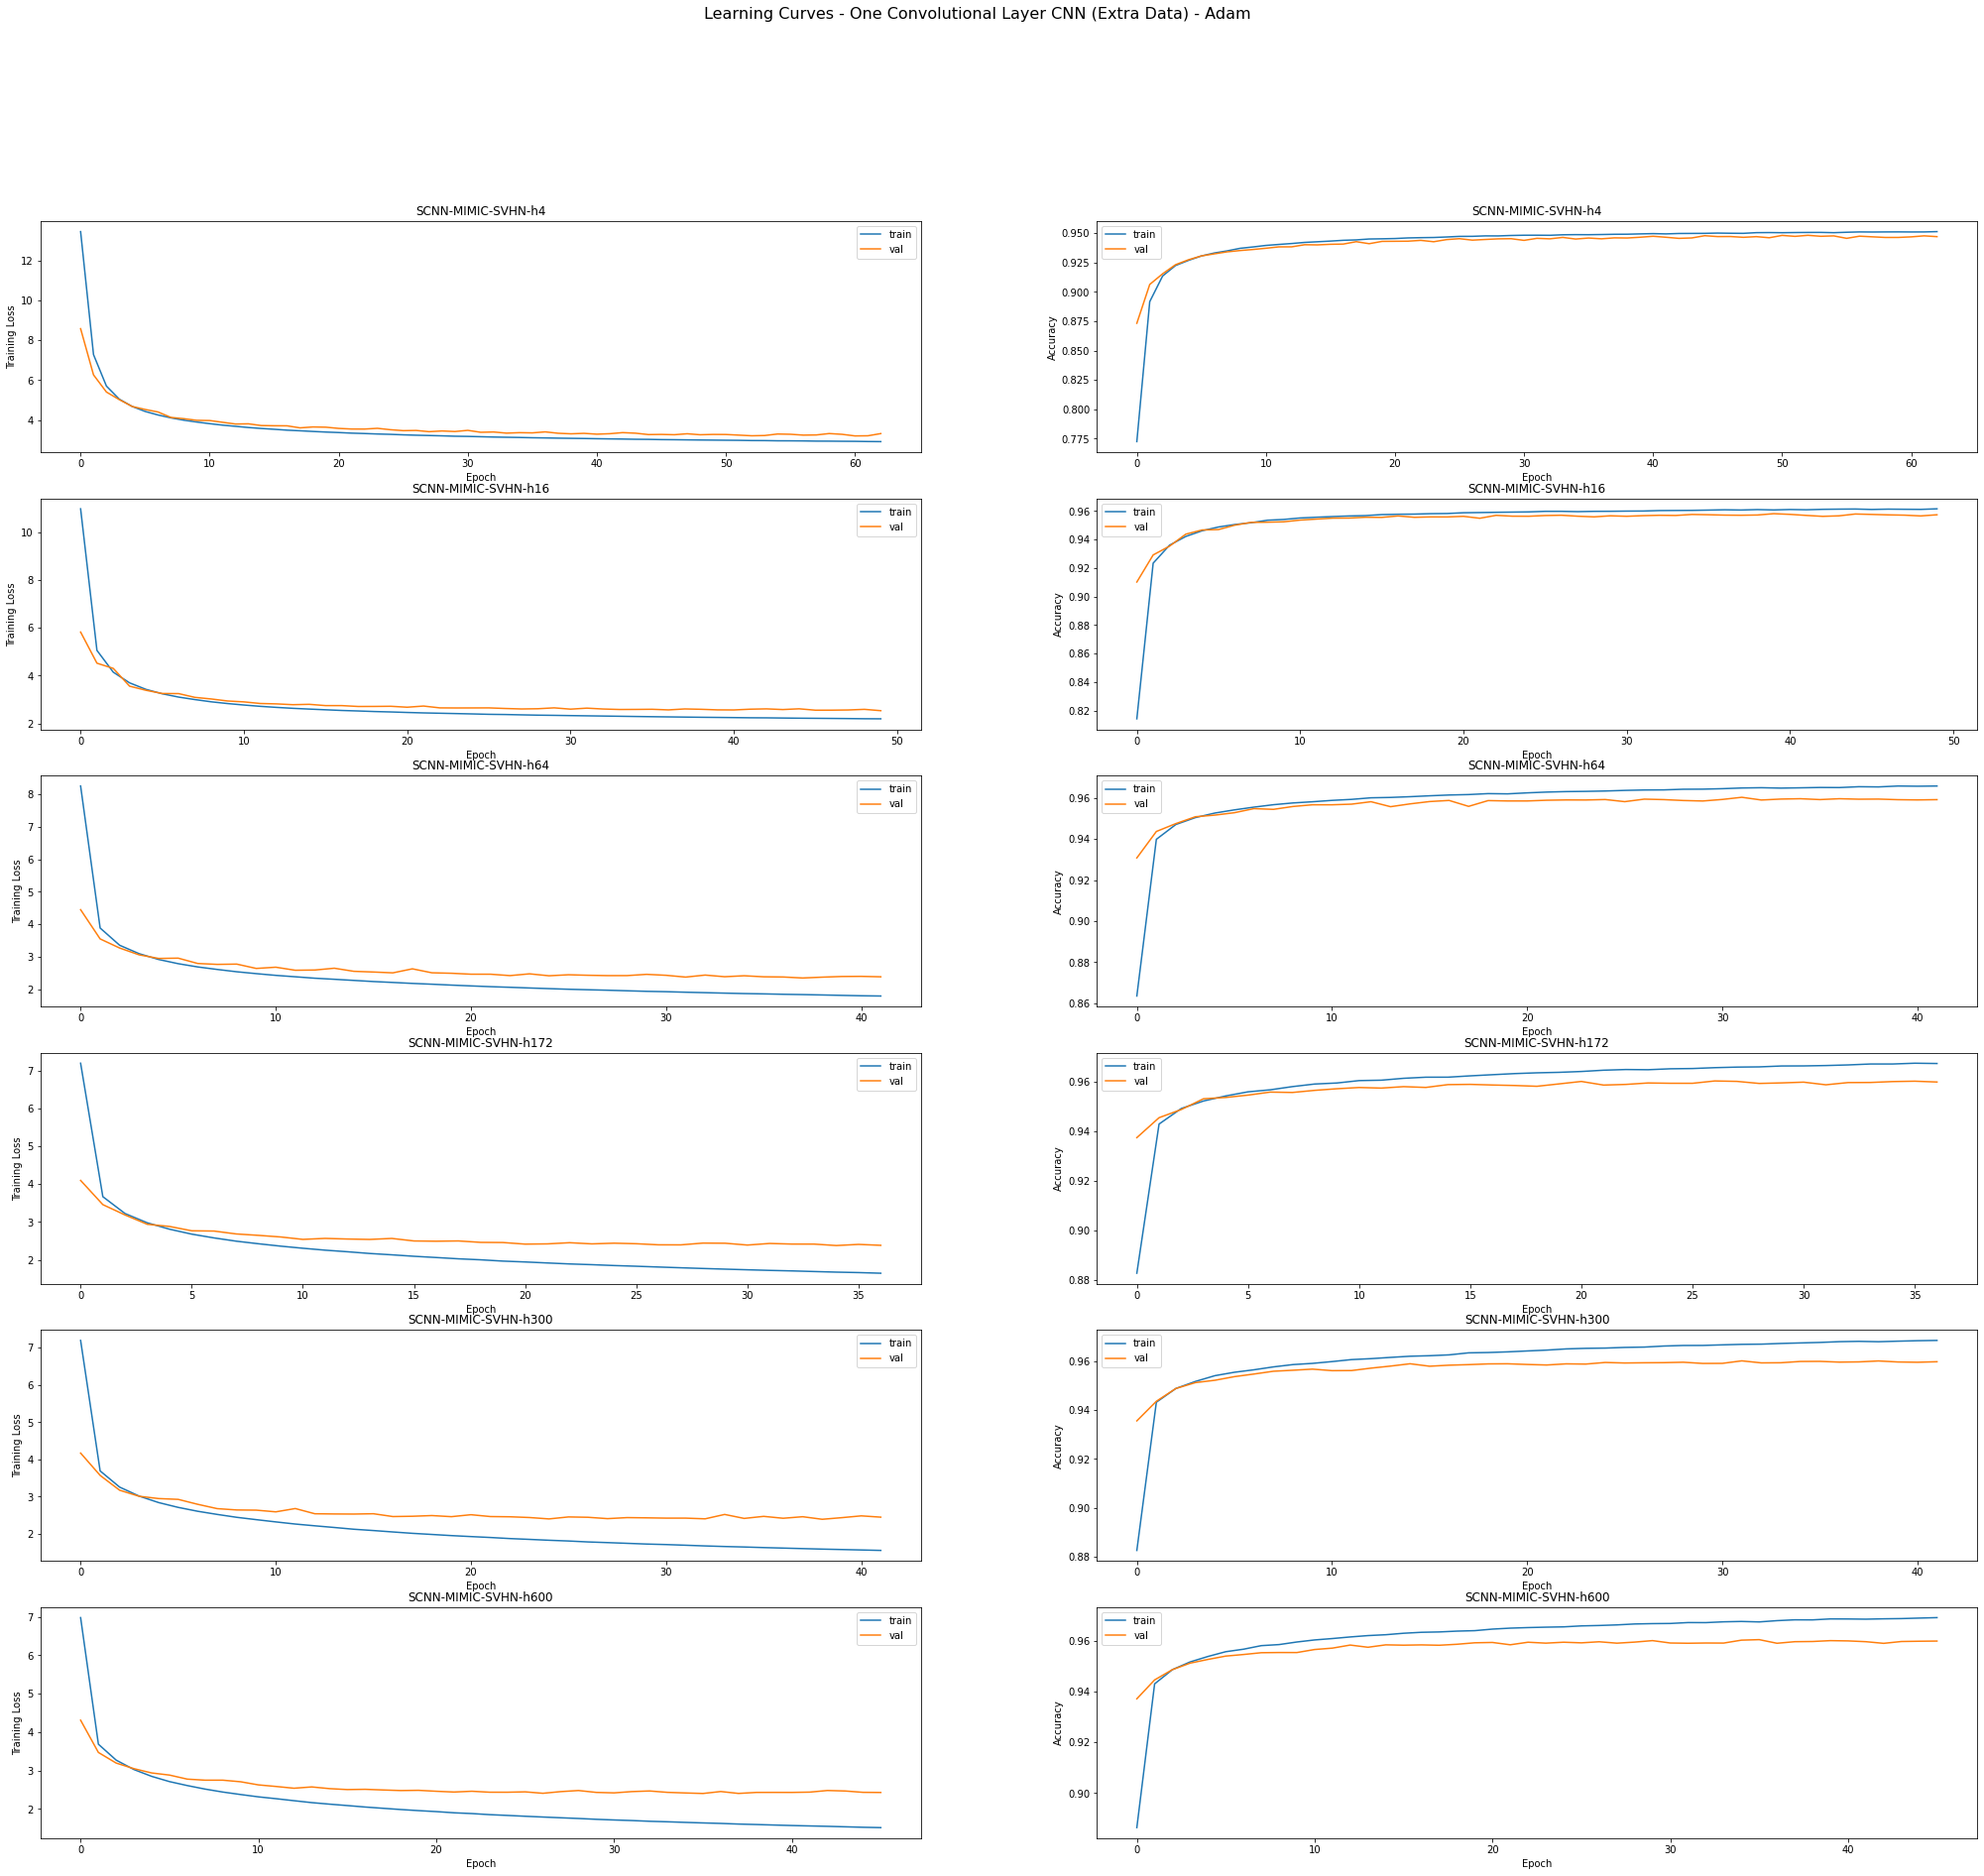

In [ ]:
fig = plt.figure()
fig.suptitle('Learning Curves - One Convolutional Layer CNN (Extra Data) - Adam', fontsize=16)
fig.set_size_inches(35, 30)

plt.subplot(6, 2, 1)
plt.plot(loss_train_4, label='train');
plt.plot(loss_test_4, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h4')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(6, 2, 2)
plt.plot(acc_train_4, label='train');
plt.plot(acc_test_4, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h4')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(6, 2, 3)
plt.plot(loss_train_16, label='train');
plt.plot(loss_test_16, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h16')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(6, 2, 4)
plt.plot(acc_train_16, label='train');
plt.plot(acc_test_16, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h16')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(6, 2, 5)
plt.plot(loss_train_64, label='train');
plt.plot(loss_test_64, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(6, 2, 6)
plt.plot(acc_train_64, label='train');
plt.plot(acc_test_64, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(6, 2, 7)
plt.plot(loss_train_172, label='train');
plt.plot(loss_test_172, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h172')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(6, 2, 8)
plt.plot(acc_train_172, label='train');
plt.plot(acc_test_172, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h172')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(6, 2, 9)
plt.plot(loss_train_300, label='train');
plt.plot(loss_test_300, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h300')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(6, 2, 10)
plt.plot(acc_train_300, label='train');
plt.plot(acc_test_300, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h300')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(6, 2,11)
plt.plot(loss_train_600, label='train');
plt.plot(loss_test_600, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h600')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(6, 2, 12)
plt.plot(acc_train_600, label='train');
plt.plot(acc_test_600, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h600')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

##### Learning Curves for Extra Data - SGD


In [ ]:
loss_train_4 = [16.68673224931534, 9.41103127454613, 8.269247571599617, 7.674801592785276, 7.270337777000127, 6.9612544863013905, 6.718476281115711, 6.526633587280004, 6.350704412424595, 6.215478874264217, 6.080104846599544, 5.9732597172434225, 5.8794381951889845, 5.78555751908486, 5.706065212257513, 5.632739754048859, 5.560588890482772, 5.497251133768564, 5.444256059200482, 5.3888534871127725, 5.339097233826629, 5.2993190894858495, 5.257905257625104, 5.213979317212602, 5.179638640445566, 5.141982802009191, 5.116333701561951, 5.087421805830826, 5.061363415059738, 5.028532907868667, 5.005937526431321, 4.979911711440732, 4.955619404312492, 4.935007627189946, 4.917887294465048, 4.893804678831552, 4.8837274430604465, 4.862340499925045, 4.844017396933739, 4.827685644273207, 4.812954754730921, 4.797831815931085, 4.784839782179229, 4.767067578642724, 4.757182706359182, 4.737289102646721, 4.726757816335311, 4.720223073040205, 4.7076033454199635, 4.691797580109941, 4.683153721702354, 4.66870432349991, 4.666157124211428, 4.650904569503218, 4.641284424940868, 4.62897574399947, 4.623975686127583, 4.613211941804793, 4.604925804841324, 4.598723373386512, 4.590058703518878, 4.579659557579543, 4.573936224338388, 4.564559662440603, 4.5531501565685115, 4.552167070306306, 4.5394584138264165, 4.532834203947159, 4.527175841651899, 4.526872941712516, 4.509299050950709, 4.504975100802354, 4.497663455370098, 4.493624419701685, 4.490238187578508, 4.4801681546493555, 4.475735322727, 4.474687879949608, 4.462907208165149, 4.4555874644555225, 4.45584352851428, 4.4504137854996, 4.437691396463279, 4.43665036699439]
loss_test_4 = [12.144419705477125, 9.535144953591395, 8.917744432032578, 7.584649447503649, 7.872547409715287, 7.083777165493029, 7.59879661515601, 6.787615456527654, 6.19324962476956, 6.747002905419983, 7.372930947778629, 6.073775434587835, 6.155350174508357, 5.932270269787055, 5.917424310824454, 6.128284689767974, 5.841213295096532, 6.310763265095732, 5.561955856509547, 5.470177405930488, 5.534023465745466, 5.697159479940735, 5.759451636895312, 5.412166351777228, 5.481338050722379, 5.625005890454116, 5.323474026182385, 5.495905927750031, 5.354667665468514, 5.299597214721927, 5.252998529176346, 5.210633595640862, 5.1213418363204, 5.291238857576755, 5.468216833455615, 5.201455425746816, 5.1146218627830144, 5.583571740667863, 5.253826329592893, 5.307980138319801, 5.053058648493906, 5.273804319881538, 4.970497330639167, 5.112043940497005, 5.064829388014207, 4.9789345632228805, 4.962810954056289, 5.004336454044456, 5.155028884232897, 5.191272542207031, 5.029816133513384, 4.888191227866803, 5.100541327147729, 5.08141738125229, 4.950355820254205, 4.890971551638182, 5.044879485627881, 5.130952079672255, 4.8839757878858, 5.038193518798512, 4.871988133514126, 5.066725023969322, 4.792017700346102, 5.207291334013193, 4.865634545108587, 5.1690683432829365, 5.285095237126406, 4.750271775108496, 4.8380827563268225, 4.8437469460821525, 5.01398969074331, 4.784018820556928, 4.784360250339991, 4.992386417643344, 4.825655118908738, 4.858992409654269, 4.769852744823415, 5.356051869190262, 4.803451226685377, 4.736210276878156, 4.793288566679994, 4.735453318015272, 4.75976511231039, 4.859685767919805]
acc_train_4 = [0.7062630617761981, 0.8617828968403365, 0.8803329693306648, 0.8888054713535293, 0.8946044282955135, 0.8981958277589589, 0.9017448647246288, 0.9037806186842923, 0.9061482123065618, 0.9076685557208216, 0.9091371227405571, 0.910713949503888, 0.9116459247231598, 0.9130368271454976, 0.9136040140865478, 0.9148513546623014, 0.9153408769980984, 0.9157974507205243, 0.9165670363232808, 0.9174166399917306, 0.9179885338761054, 0.9182685971441871, 0.918995820227846, 0.919290004325901, 0.9196736203897649, 0.9201913844023418, 0.9201043059171731, 0.9208527102637475, 0.9210574623903827, 0.9214198972003088, 0.921659951425444, 0.9223707002074673, 0.9224695460610471, 0.9226460565165135, 0.9225448571946381, 0.923309735842848, 0.9228978781044487, 0.9231002767706439, 0.9236203942582497, 0.9239263457168604, 0.9241522790985556, 0.9238722158439404, 0.9240652006055312, 0.9243687985958463, 0.9244864722339461, 0.924484118762284, 0.9249595202669854, 0.9250418918121964, 0.9251948675510406, 0.9255831905593511, 0.9253996196832869, 0.9255784836059266, 0.9258373656189485, 0.9258514864522884, 0.9257338128175553, 0.9263998456076964, 0.9262751115512433, 0.9262327490400012, 0.9264445615973341, 0.9266022442750139, 0.9263810178276654, 0.9270564645179221, 0.9270188089567377, 0.9269670325509911, 0.9270046881132977, 0.9271176548148065, 0.9272518027646418, 0.927461261842457, 0.9274965639274902, 0.9274471410046281, 0.9277319112126677, 0.9279272494537762, 0.9278284035889742, 0.9279366633359363, 0.9281602432583137, 0.9283720558033022, 0.9283649953894378, 0.9281367085282248, 0.9283179259270157, 0.9284473669324044, 0.9284920829130643, 0.9285156176498864, 0.9287721461833904, 0.9285603336283019]
acc_test_4 = [0.8259576190633118, 0.8588588588498811, 0.8757001515639038, 0.8927956169026872, 0.8902538902443514, 0.8921272369452844, 0.8919577884999739, 0.8928803411247813, 0.9055795607530968, 0.9008726594838103, 0.8984344846099592, 0.9065209409941608, 0.9096274958355146, 0.9100699445644864, 0.9098063580507982, 0.9087802535764179, 0.9102676344173487, 0.905363043305861, 0.9152004669470492, 0.9160759505272872, 0.914823914835698, 0.9119621188704539, 0.9149557080277344, 0.9166125372707705, 0.9147203630080083, 0.9141084658011818, 0.9193048848120263, 0.9168855375437708, 0.9146732939522169, 0.9179869524382891, 0.9184388149591172, 0.9182599527112895, 0.9205475067229814, 0.9177704349910534, 0.9178175040468448, 0.9203215755164336, 0.9173374000645989, 0.9130352923680815, 0.9179681248545767, 0.9159629848970802, 0.9206981275632574, 0.9197096783421512, 0.9205098515129123, 0.9185517805999852, 0.9200203337820153, 0.9203780582776708, 0.9215265421954365, 0.9202933340550156, 0.9174691933430456, 0.9193048848013653, 0.9201521270279178, 0.9210935072796429, 0.9211311624790509, 0.9206134033512632, 0.9210558520589129, 0.921771301050224, 0.9191730915986679, 0.9203498169239853, 0.9222796464400217, 0.9208958174161196, 0.9234281302932601, 0.9181658147399832, 0.9228821298011257, 0.9214606455671547, 0.9221290255890847, 0.9190977811353247, 0.9145885697834278, 0.9235787511767413, 0.922778577973436, 0.9220819565332933, 0.9225620605048782, 0.924510717582744, 0.9229950953774666, 0.9252638218379902, 0.9234375441496435, 0.9235693373310189, 0.922449094831466, 0.9194743332898809, 0.9218560252728792, 0.9238423376040191, 0.9237199581712948, 0.9230421644439191, 0.9236164063974713, 0.9226750261350852]

loss_train_16 = [15.110804915268806, 6.307473098951388, 4.909288527648495, 4.232938780484838, 3.7965538113629806, 3.488575351677489, 3.2701222515424013, 3.1030942269553776, 2.9614857207258005, 2.856087028498821, 2.769191324781546, 2.68968622971723, 2.625898597505876, 2.570954840240671, 2.5219522818644964, 2.4808066031229554, 2.4405258788230797, 2.4047714934734117, 2.3726935615950375, 2.343758876902812, 2.3175946050256475, 2.289803791766161, 2.268747552473234, 2.244429342483641, 2.2266943002890454, 2.2053954586833604, 2.1852208637027255, 2.1675492816586983, 2.149824368593022, 2.1350793011736644, 2.119263475877143, 2.1055453993579123, 2.0903424897918508, 2.0774356256446955, 2.0643867226336288, 2.0535405836343616, 2.038991883970278, 2.0314239412049573, 2.018119853578869, 2.0084398613879597, 1.9985445400431094, 1.9875235084067708, 1.9776858373997523, 1.9675827089481024, 1.9587363493053573, 1.951302590949784, 1.9412223492116154, 1.9356269592970665, 1.926234694286114, 1.9169186542576093, 1.9090142112386683, 1.901208841703954, 1.8956795221145983]
loss_test_16 = [7.741179493225552, 5.297529256500839, 4.452499157583826, 4.316869066371758, 3.707238108429458, 3.3976196407361674, 3.3201616359066524, 3.216255481500771, 3.3580616881855976, 2.98800438203885, 2.954507929850968, 2.9086238488024567, 2.909110560047698, 2.815179841408672, 2.714890235028803, 2.6495548927458636, 2.6820356495815125, 2.6822863177946497, 2.6268421928865564, 2.644417680803398, 2.568357659213077, 2.8589423600447255, 2.6253424493671758, 2.5659250027321336, 2.6111859361764966, 2.454242297788713, 2.4806568809729304, 2.578082224544065, 2.450942954167171, 2.552079605544709, 2.425300895012437, 2.4003419623870106, 2.612369343327427, 2.366240368623601, 2.404445216879882, 2.407015283245992, 2.366236627438001, 2.459258807036864, 2.397092244452428, 2.3685329562777597, 2.3061711394056386, 2.403658497618232, 2.328339560812704, 2.3466038831356935, 2.3443482856952844, 2.419733643645143, 2.317967344277755, 2.28835482294219, 2.290876700578804, 2.3482829985984477, 2.3539723208640373, 2.35622030611568, 2.329323777005385]
acc_train_16 = [0.7335892342785838, 0.9069907555566583, 0.9259267975870017, 0.9351641782591982, 0.9410313859096866, 0.944909909058445, 0.9479058799152824, 0.9502828874253231, 0.9521115357788336, 0.9534224201197671, 0.9549686517402668, 0.9558723852917365, 0.95648193473954, 0.9572020974194344, 0.9577386892064313, 0.9584706192502479, 0.9588989512880384, 0.9593625854344288, 0.9597414945459903, 0.9601957147967541, 0.9602851467591962, 0.9606452280952156, 0.9609747142839151, 0.9612759588003235, 0.961497185242061, 0.9616054449923896, 0.9616736957031384, 0.9621208555321822, 0.9622479430625419, 0.962532713268337, 0.9626621542726035, 0.9627115771988324, 0.962909268916092, 0.9628975015499254, 0.9633328940150468, 0.9633729030535046, 0.9637023892422041, 0.9634811628083222, 0.9640083407030592, 0.9637800538519462, 0.9641848511697478, 0.9644649144254851, 0.9645425790273716, 0.9646061227936737, 0.9644178449709185, 0.964610829735876, 0.9646390714092893, 0.9647991075608757, 0.9648838325788711, 0.9650297478915064, 0.9649403159290644, 0.9650697569310864, 0.965105059022853]
acc_test_16 =[0.8880793018522055, 0.9183917459790751, 0.93093093091017, 0.9355813493750139, 0.9402600092367486, 0.9451081174899275, 0.9461248081617907, 0.948534741660073, 0.9515471584117271, 0.9513871237689339, 0.9524979524766305, 0.9529121597767285, 0.9549361273179374, 0.9551997138316256, 0.9567812326219796, 0.956649439376077, 0.9564046805106285, 0.9563387838930077, 0.9577037852580091, 0.9580615098075309, 0.9583815790392511, 0.9576002334409804, 0.9588710967808093, 0.9582403720014924, 0.9586357517072169, 0.959577131958942, 0.9590499590718422, 0.9573272331679801, 0.9596053733664938, 0.9576096472867028, 0.9596806837866317, 0.959577131958942, 0.9581744753945327, 0.9598501322426033, 0.9604149603829774, 0.9600854772948736, 0.9597277527992181, 0.9606691330509431, 0.9599348564545975, 0.9605561674746024, 0.9608668229038054, 0.9599254427059465, 0.9614975477263275, 0.960396132831809, 0.9602549257508451, 0.9600195806772528, 0.9610550989541504, 0.960810340142568, 0.9611774784407409, 0.9608009263400509, 0.9603490637653566, 0.9602643395533623, 0.9610174437979476]

loss_train_64 = [15.74272191845237, 6.342002096867976, 4.699770079073293, 3.9114649273766418, 3.439267482256249, 3.1365555543208066, 2.929491840838946, 2.7808936359387992, 2.660885926692426, 2.565647142728379, 2.488903749544157, 2.423907463469723, 2.363876311512786, 2.3130710068140097, 2.2661339200133512, 2.2287581925777027, 2.19076176742612, 2.1610116264455734, 2.127029467582469, 2.099692323392663, 2.0725420154467713, 2.046466383180695, 2.0232970593099644, 2.002844549575662, 1.9833027815851556, 1.9609865453003414, 1.9425013878366453, 1.925996162705862, 1.9083982178019008, 1.8928706532374135, 1.8765177686278234, 1.861764348159478, 1.8467231630176968, 1.8323528114665246, 1.8183564051977044, 1.8052482405269614, 1.7931250133154935, 1.7789594253006005, 1.769078551370652, 1.756622703496512, 1.745128221228412, 1.7344348173352637, 1.7246559049715386, 1.7136354029617409, 1.70296043801397, 1.6943737275899438, 1.683365337010991, 1.6745924675464405, 1.6644221344375338, 1.6559272528686748, 1.6491738025926608, 1.6386542926431589, 1.6299299845044517, 1.6212674599057628, 1.613761294961611, 1.6068853269045218, 1.5978549582484238, 1.5895076744091332, 1.581912687209811, 1.5744583543247022, 1.567452645024854, 1.558730680047944, 1.5544559214503118, 1.5464248836759842, 1.5388967111635754, 1.5329828771998024, 1.5251153160263315, 1.5193216112138386, 1.5132115207430294, 1.5074652274421236, 1.500495491085649, 1.4940502185314108, 1.488097344545411, 1.4834666196114845, 1.4762874036562197, 1.4705924470223595, 1.4650363557531243, 1.4603260387135484, 1.454693895517672, 1.447450098566655, 1.442916261591617]
loss_test_64 = [8.350670764625072, 6.3955983543361885, 4.982301578156156, 3.6752129439277335, 3.4955903649430016, 3.26800617502898, 3.040540823266322, 2.855988436790154, 2.7717056358400463, 2.7316423691376075, 2.6841521030869417, 2.586456580398027, 2.5270472353464695, 2.6275357690498895, 2.4740409008359805, 2.418624498962944, 2.4031188233264307, 2.4247117492144805, 2.479276529666017, 2.4855631009088337, 2.4667272658536032, 2.3485609646267793, 2.2950384724741335, 2.292950513792086, 2.341592332952241, 2.285301646138851, 2.379704606515432, 2.2587811336654515, 2.2358942485795392, 2.281344736808697, 2.2882988185039204, 2.228307877353879, 2.2260759351878066, 2.204235198659887, 2.2900071156672785, 2.1513013228766638, 2.2220355521009094, 2.1780546860483594, 2.1682840460121793, 2.111104154254168, 2.1331173668607795, 2.163584318424237, 2.1252630317921626, 2.2011544718105807, 2.121178729811089, 2.0790629921972874, 2.1146307177101353, 2.161745280982112, 2.0973197003249946, 2.0905501590651805, 2.1268827948027593, 2.2230410031167094, 2.1362557398400623, 2.0859763013685537, 2.1414497683549136, 2.1087785942803356, 2.095161602349799, 2.0644983691510763, 2.0508766579008753, 2.140678655281226, 2.0431766485612863, 2.0765423655226027, 2.0464347835827232, 2.0679133080187806, 2.104375884608947, 2.063418567139673, 2.0526607661303946, 2.0220663487028605, 2.065778754423106, 2.191145807186226, 2.0308497002960455, 2.0764475136220146, 2.055276293097724, 2.051889371592293, 2.0496208382870207, 2.004718086148464, 2.0068416107969784, 2.111902804522243, 2.003148080687064, 2.121333875255902, 2.024112342101461]
acc_train_64 = [0.7179810027721729, 0.9067836499572386, 0.9284214787306533, 0.9383037109603753, 0.9447592868058519, 0.9491838156372338, 0.9520856475793269, 0.9540437369348593, 0.9558394366772432, 0.9571409071180611, 0.9580728823429441, 0.9588942443435917, 0.9599203584764856, 0.9605887447562446, 0.961014723323495, 0.961603091518483, 0.962033777044769, 0.9625044715949238, 0.9626150848180369, 0.9631728578679494, 0.9633776099979513, 0.9638294767725639, 0.9638082955197483, 0.964267222711592, 0.9644649144232407, 0.9647849867219246, 0.9649591437090954, 0.9651591889036285, 0.965283922952226, 0.9654180709031837, 0.9658416960055052, 0.9658252217016252, 0.9659852578431116, 0.9661452939924535, 0.966171182196449, 0.9665524447830396, 0.9665477378397151, 0.9667689642803303, 0.9668795775045658, 0.9669619490475323, 0.9672114171660496, 0.9672231845288496, 0.9672255380005118, 0.9674726526428782, 0.9676515165744957, 0.9676656374123245, 0.967752715906471, 0.9680445465306194, 0.967950407620364, 0.9680633743117727, 0.9682587125540035, 0.9685011202508009, 0.9682516521367724, 0.9684822924696477, 0.968618793890023, 0.9687011654374784, 0.9687929508749493, 0.9687458814271162, 0.9690565398301734, 0.9689906425899646, 0.9690377120467757, 0.9690894884457889, 0.9691553856848755, 0.9694236815800573, 0.9693883794972684, 0.9694519232534705, 0.9695766573121681, 0.9696307871884547, 0.969640201077348, 0.9697955302822433, 0.9697743490260612, 0.970028524087903, 0.9698590740496676, 0.9700214636706719, 0.970167378982185, 0.9701603185638317, 0.9703721311200424, 0.9704003727889668, 0.9704003727867224, 0.9705274603170821, 0.9703368290226647]
acc_test_64 =[0.875370668465139, 0.9106818416849025, 0.926271098686014, 0.9397140086907481, 0.9457388422698055, 0.9494572942961026, 0.9514436066059205, 0.9530345392526579, 0.9545501614579353, 0.9543430578132168, 0.9568565430640007, 0.9576378886729325, 0.9573460607948978, 0.9576378886622715, 0.9592099936826524, 0.9593323731153767, 0.959530062989561, 0.9596900976216932, 0.9596242009934114, 0.9605373398482457, 0.9603490637979007, 0.9607820987136944, 0.9617140651629021, 0.9611021679992808, 0.9611586508143843, 0.9617423065704539, 0.9610833403942464, 0.9620153068434542, 0.9621659276730692, 0.9620341344484886, 0.9625330659819029, 0.9621847552887647, 0.9628154800574205, 0.9636062394582086, 0.9629566870951792, 0.9632391011706968, 0.962796652452386, 0.9632014459606277, 0.9633144115801737, 0.963097894132938, 0.963474446222967, 0.9629566870951792, 0.9638509983343181, 0.9637662741116628, 0.9640957571997666, 0.9639639639645251, 0.9636533084814558, 0.9633897220109727, 0.9641428262230138, 0.9644064126828359, 0.9639168949519388, 0.9640110329877724, 0.963700377504703, 0.9638509983343181, 0.9639639639751861, 0.9639357225676344, 0.964302860855146, 0.9644440678929048, 0.9645476197312557, 0.9637945155085536, 0.9644346540903876, 0.9642934470632899, 0.9642463780507036, 0.9642840332607726, 0.9646417577457671, 0.9640769296160541, 0.9645287921262211, 0.9645005507080083, 0.9651406892791814, 0.9640298605821458, 0.9652913101194575, 0.9645852749413246, 0.9645946887438419, 0.9647264819790834, 0.9650183098571182, 0.9647264819790834, 0.9649147580294284, 0.9647735509484645, 0.9649900684495665, 0.9647641371891524, 0.9651877583024286]

loss_train_172 = [16.13183951153873, 6.051777359609439, 4.496419100168611, 3.7708985259841628, 3.343311347898222, 3.067771964715721, 2.8719659117725116, 2.7278909611719473, 2.615506556505736, 2.5251830490487506, 2.4449933449258205, 2.379120615011526, 2.318755651991335, 2.268021429013517, 2.2225607889524936, 2.1821294212831495, 2.1448510278901414, 2.1120077754477427, 2.078414680185121, 2.049264827104172, 2.0196872971393796, 1.994812594969608, 1.9733691213315578, 1.948883667123353, 1.925956880826564, 1.9062612363817355, 1.8868355376731247, 1.8681913700437374, 1.850542124677898, 1.8332341754878425, 1.8161609279679145, 1.7985208503514931, 1.7831434152522816, 1.76954974469743, 1.7537830437035238, 1.7401312044850874, 1.7258666307976946, 1.7163753422167625, 1.7011743987903662, 1.6869614173092364, 1.6766269952718098, 1.662943221690809, 1.6524862501290998, 1.641136963314538, 1.6298589749379606, 1.6191553259296283, 1.6082685935042336, 1.5966736447406453, 1.5869465756267738, 1.57855986600325, 1.5667760616806539, 1.5585884415360227, 1.549260581746991, 1.5405186733721816, 1.5299473716402296, 1.5213180307775211, 1.5118395286694222, 1.5048530667219542, 1.4964223441008742, 1.4871938149625104, 1.4768821878609013, 1.4698479983456163, 1.4625954775024417, 1.4550271944408688, 1.448487535520532]
loss_test_172 = [7.887437974123845, 5.240799857472867, 4.080234311355457, 3.8373763574513333, 3.2953465921335416, 3.0596213873855205, 2.980161274035069, 2.8588376228215053, 2.7201701918444368, 2.7058430187371822, 2.6011180402585574, 2.5114678653816083, 2.4913615875357618, 2.486838663307899, 2.4211220882356557, 2.4054578543932563, 2.4331662118885475, 2.359124696117708, 2.329778584026077, 2.321402479769201, 2.5591203234347364, 2.331308688586131, 2.4148796486473225, 2.239895597111059, 2.2501698181291103, 2.3143088924969746, 2.293823595215419, 2.199134765860916, 2.1813001673763415, 2.197435271773963, 2.1303404368155006, 2.167155652551783, 2.172264948348829, 2.201206473255514, 2.1356615344159255, 2.1242285751711325, 2.206128502223816, 2.143320073989579, 2.082652092426621, 2.214609094884665, 2.2243452613139856, 2.2182917291014466, 2.1883284979233677, 2.137857083692896, 2.0523315451418025, 2.0747757423501643, 2.0764200998306257, 2.1257301635992305, 2.0936968866914025, 2.085692514517161, 2.0438422980124447, 2.040302635099934, 2.0516318558706192, 2.092469529695669, 2.0391165643524474, 2.033591013614932, 2.0282652011994045, 2.0345496701270855, 2.0347898687465213, 2.0108216484889345, 2.1555357059989877, 2.0688197413188143, 2.0272902631920795, 2.1112764600483036, 2.0430471674388464]
acc_train_172 =[0.7052557754244575, 0.9105798015596637, 0.9314103891657708, 0.9405842260795206, 0.9464632010972981, 0.9501110839131811, 0.9529752602929678, 0.9548368572699493, 0.9564701673756177, 0.9574986349835406, 0.9585553442704878, 0.9596473556334905, 0.9601204036631631, 0.960857040644693, 0.9616525144525674, 0.9616901700182406, 0.9624221000553239, 0.9629328036428142, 0.9631799182863027, 0.9635494135123377, 0.9638247698303617, 0.964406077605874, 0.9644625609527007, 0.9647967540903357, 0.9648273492410223, 0.9650462222043642, 0.9654980889767324, 0.9655380980163123, 0.9658981793523317, 0.9659617231163894, 0.9662394329038312, 0.9664677197627998, 0.9665547982569462, 0.9666465836966617, 0.9667218948280082, 0.9670796226912431, 0.9672420123111252, 0.9672984956601962, 0.9675079547368892, 0.967406755406036, 0.9678374409267109, 0.9680068909671906, 0.9679103985807841, 0.9679386402564418, 0.9682351778261592, 0.9682492986617436, 0.96841168828387, 0.9684681716318188, 0.9686235008378363, 0.9688306064406227, 0.968854141168467, 0.968943573135398, 0.9690494794084534, 0.9693648447626907, 0.9693154218364619, 0.9694142676900417, 0.9695178204959238, 0.969633140660117, 0.9696472614957014, 0.9697225726270479, 0.9699885150483231, 0.9699696872682919, 0.9700379379801629, 0.9701132491092651, 0.9703180012403891]
acc_test_172 = [0.8842196428633379, 0.9226561984868455, 0.9354872113498415, 0.9415873554029031, 0.947969913487716, 0.9501633294955575, 0.9519331243688006, 0.9530062978019009, 0.9558680938103504, 0.9561410940940117, 0.9568471292721444, 0.9579956131899101, 0.9585321999120714, 0.9593982697436584, 0.9596524424222852, 0.9592194075064917, 0.9595488905945955, 0.9611398232200109, 0.9608291677369416, 0.9605844088714931, 0.9602831671802801, 0.9614787201212929, 0.9598783736720382, 0.9614693063081147, 0.9616481685452813, 0.9627213420429089, 0.9605467536614241, 0.9622129966963164, 0.9623353761290406, 0.9629284456982885, 0.9636062394795306, 0.9634650324524329, 0.962909618093254, 0.9637945155405366, 0.963587411874496, 0.9639263087757781, 0.9641710676305656, 0.9637474465172893, 0.9642463780507036, 0.9627213420429089, 0.9641616538387093, 0.9632296873895015, 0.9635779980287736, 0.9632579287970533, 0.9637851017380193, 0.9637380327147721, 0.9643781712966062, 0.9646982405821927, 0.96470765438471, 0.9646888267796754, 0.9642840332714336, 0.9648017923560163, 0.9647829648048479, 0.9643311022840199, 0.9652724825250839, 0.9646323439539108, 0.9644534817167442, 0.9645005507293304, 0.9648017924098824, 0.9652254135231587, 0.9649712408551929, 0.9646135163595374, 0.9651877583130897, 0.9650653788803655, 0.9651406892898424]

loss_train_300 = [16.392090355807014, 5.937905795801371, 4.399800549965134, 3.6790920990416067, 3.270431002884115, 3.00613336064125, 2.8237038376375634, 2.68495472083554, 2.574660170321351, 2.486618524278862, 2.411263371206103, 2.34764349072537, 2.2914543203859297, 2.2431023588981898, 2.197188207614923, 2.1548866067759445, 2.1205696515487724, 2.085214417518468, 2.0551196312124635, 2.0279930067136895, 1.9983820024356445, 1.9736958232405468, 1.947225107142143, 1.9249687532927646, 1.9039205295828199, 1.883125860218435, 1.86244670787865, 1.8450832843102696, 1.8253871829634571, 1.8099657820023112, 1.7928534617720369, 1.7785642580601504, 1.7618487246719334, 1.7480790716665437, 1.7311159519610295, 1.7190364999749392, 1.703272718557104, 1.6908732253332255, 1.678960371443452, 1.6652370035449713, 1.6525004871473377, 1.6399467598480018, 1.6292584165107316, 1.6191670236708187, 1.6063629875629661, 1.5949491035095922, 1.58455337584664, 1.5747923505301082, 1.5639725471888228, 1.5543963679789177, 1.5430931411016537, 1.5327004945094347, 1.524461937698533, 1.5130083319845156, 1.5047345664081793, 1.4964561881058958, 1.488109718426124, 1.478817889572476, 1.4718178019513655, 1.4599644890852856, 1.4539090736466298, 1.4454424956664864, 1.4371662389744368, 1.4279539652850923, 1.4221016330710734, 1.4137053700663034, 1.405808827817926, 1.3964508764893688, 1.3895144054028843, 1.381916557488102, 1.3752485198948394, 1.3674320612320388, 1.3610858384494495, 1.353517741762229, 1.3461667290562178]
loss_test_300 = [7.63855105967144, 5.201818922648788, 4.025469449364397, 3.806644738437022, 3.2343402902414313, 3.1520068009160243, 2.87002055357725, 3.013992725377055, 2.853423196389827, 2.6165184670236545, 2.731454656444776, 2.488583784258618, 2.493915839749939, 2.7048459238294424, 2.4962725783076265, 2.3517273991027166, 2.3431594391165045, 2.37235379110425, 2.3407934799990837, 2.2912087611381273, 2.284661514184244, 2.2368883823337784, 2.381347367765023, 2.259980177699106, 2.2680981230111605, 2.207346725254238, 2.216145244036995, 2.22195650960305, 2.214697470102929, 2.1734972014172174, 2.130953421874567, 2.1815299759961344, 2.2239814063835155, 2.2072427201962563, 2.1176850170852926, 2.080944413187247, 2.155022894234026, 2.1386405064659324, 2.2374990305330087, 2.0595418974524757, 2.051953041032903, 2.0798302538840874, 2.1312633344640446, 2.0284461898899413, 2.084906972218735, 2.0584219606863092, 2.027504289126784, 2.040595214885173, 2.139641872708267, 2.0236189267911566, 2.05399663388834, 2.0563451173909777, 1.9859412966942804, 2.032256004203822, 2.086447282446017, 2.0077322511144997, 2.036695970383304, 2.038429081835552, 2.087875428240123, 1.9719923388742848, 2.049060852521985, 2.050675725780229, 2.01857157399351, 2.0033677863108705, 1.9687437841872424, 1.9908182166865158, 2.0531332028434304, 1.9554776188430076, 2.110492749755393, 1.9754491433011256, 2.0236482568033924, 1.9707853164177462, 1.9995617087767825, 2.1609208690217554, 2.0027868753681353]
acc_train_300 = [0.6984165835095061, 0.9128179541765447, 0.9326506693254154, 0.9417868506734921, 0.9475269707936208, 0.9511913279201172, 0.9537895618741398, 0.955679400521168, 0.9572185717289254, 0.9581081844335885, 0.9590378061834426, 0.9599321258404079, 0.9606334607391489, 0.9611253365443637, 0.9619184568749647, 0.9620196562024512, 0.9625115320155215, 0.9627139306805945, 0.9635352926745088, 0.9637988816274884, 0.9639565643062904, 0.96419426505303, 0.9645920019569671, 0.9648485304915934, 0.9651003520772841, 0.9654274847943214, 0.965542804960759, 0.9657899196053696, 0.9660723363372581, 0.9660911641195337, 0.9665242031118707, 0.9666795323167661, 0.9667171878779505, 0.9670796226878765, 0.967364392895916, 0.9671737615992542, 0.9675479637753469, 0.9674044019332516, 0.9677550693781333, 0.967903338163553, 0.968091615985186, 0.9681222111313837, 0.9683928605015945, 0.9684681716295743, 0.9685646640204697, 0.9687223466925384, 0.9687764765677027, 0.968922391880338, 0.9688753224246492, 0.9692942405802797, 0.9693271891981396, 0.9694731045118972, 0.9695719503688437, 0.9698120045917344, 0.9697508142982167, 0.9700779470174985, 0.970117956054834, 0.9701509046704494, 0.9703627172232936, 0.9703791915327846, 0.9704403818251801, 0.9706192457556754, 0.9705698228294466, 0.9708545930341195, 0.9707722214877862, 0.9709840340372636, 0.9711628979711256, 0.9709746201494925, 0.9711040611526368, 0.971266450773641, 0.9712052604823678, 0.9713935383017563, 0.9714617890136273, 0.9715794626517272, 0.9718289307691224]
acc_test_300 = [0.8868460937117846, 0.924849614484026, 0.9355719355837188, 0.941022527251307, 0.9487041901053835, 0.9509070198730982, 0.9535146431703767, 0.9534016775401697, 0.9558398523814766, 0.9568188878752537, 0.9558586799971721, 0.9578638199333466, 0.9580050269924274, 0.9571860261521045, 0.9577131991143926, 0.959803063219356, 0.9594359249750495, 0.9599254426520804, 0.9610833404049074, 0.9603490638085618, 0.9605467536720851, 0.9613845820961204, 0.9607632710761156, 0.9617611341861494, 0.9619399964446382, 0.9613751682829421, 0.9618364446169484, 0.9621941691126039, 0.9619399964339772, 0.9627778248686735, 0.9626742730303227, 0.9625895488076674, 0.9618646860138391, 0.9628060662762252, 0.9633708944272603, 0.9633708944272603, 0.9631920321794325, 0.9634650324524329, 0.9633897220216338, 0.9635968256876744, 0.9635779980719789, 0.9637003775153641, 0.9638886535657091, 0.9646229301620547, 0.96347444625495, 0.9634932738599846, 0.9643122746789854, 0.9646511715696064, 0.9636815498996686, 0.9639827915802206, 0.9644064126502917, 0.9642275504563301, 0.9649900684495665, 0.9645099645318477, 0.9644534817060831, 0.9642934470200847, 0.965121861695469, 0.9643405160865371, 0.9650371374728137, 0.9648676890275032, 0.9651971721049459, 0.9642369642588474, 0.9653289653508484, 0.9649241718319457, 0.9653666205609175, 0.9646511715696064, 0.9644158265066751, 0.9646511715157402, 0.9645946887545029, 0.9652630686793615, 0.9649618269988095, 0.9646888267690144, 0.965121861695469, 0.9639733777344982, 0.9649429994476412]

loss_train_600 = [16.508855168049536, 5.894837395597626, 4.3715133821051, 3.6641873397844744, 3.2550312474956646, 2.9955694036361846, 2.8137300770784557, 2.6782461773181425, 2.5718550330407988, 2.482616722825049, 2.403381181540272, 2.342193956185511, 2.2842051148259745, 2.232877892402682, 2.1912059143056277, 2.1518401125115574, 2.1161528355683004, 2.081373354613544, 2.0499752413592924, 2.022794399767283, 1.9951589975844908, 1.9687218307616101, 1.9450981182987692, 1.9215569867947355, 1.9019134112743725, 1.8781467656680924, 1.8599915003943985, 1.842176777151226, 1.8218481374074664, 1.8044360374786237, 1.7881181724837352, 1.7731282123186056, 1.7545661412605493, 1.7412630021151279, 1.72642518419005, 1.7120250144617197, 1.6975720033714221, 1.6822863035384454, 1.670010012986262, 1.6570528770183046, 1.64370712659953, 1.6303004694135812, 1.6200315072163756, 1.606602265358851, 1.5973420114308747, 1.5842378398033647, 1.5733520089766375, 1.5611928588437762, 1.5520225342666751, 1.5422661130619046, 1.53074559277188, 1.520513862156539, 1.5105693621193998, 1.4997901494547956, 1.4900297709585815, 1.4826516441913473, 1.470517474400686, 1.4628504934944386, 1.454080941505932, 1.4433265888767035]
loss_test_600 = [7.73875781404754, 5.250935709773745, 4.569347760235343, 3.6344224301312096, 3.587565163751673, 3.2438113169546345, 2.860734902025958, 2.838797085531647, 2.722219831529842, 2.602984526372687, 2.6471172471159434, 2.5544597843024226, 2.441973739599676, 2.445609711727178, 2.3844442039822713, 2.462353320498245, 2.3576917846722636, 2.3668952050570353, 2.4155665495483034, 2.353773979093123, 2.295617305548015, 2.3693370348952003, 2.3277431966081767, 2.215011873702384, 2.257830443712149, 2.199382092236824, 2.2025562867575403, 2.2036921875202142, 2.1643730121922173, 2.1379354772331007, 2.153794940584728, 2.1333500910228596, 2.3644370634262, 2.099415028164935, 2.141446637493674, 2.132098400090165, 2.2145991872883557, 2.0991070454917877, 2.1267167407748326, 2.1308237682927227, 2.114927035471446, 2.4239321402207397, 2.185036508511845, 2.103703510082659, 2.054834003578753, 2.066715685206924, 2.144902516566358, 2.0219928554278974, 2.0853944797928485, 1.9921171612559874, 2.0800400601800475, 2.0595261553241544, 2.0339768303940255, 2.020262714391894, 2.031955049529171, 2.054110719491321, 2.028272217064536, 2.0293554178205757, 1.992506273908722, 1.9915700096676323]
acc_train_600 = [0.6946980965157008, 0.9130603618744643, 0.9326035998674822, 0.9421940014663226, 0.9477223090425849, 0.9513372432406081, 0.9539590119224751, 0.9557664790164366, 0.9571856231054544, 0.9583388247664637, 0.9595155611575619, 0.9600450925363054, 0.9608593941174774, 0.9615065991421765, 0.9619655263306535, 0.9624879972865549, 0.9628268973686366, 0.9634129120908401, 0.9633964377824712, 0.9638106489914106, 0.9642319206198254, 0.9645684672280005, 0.9646390714092893, 0.9651027055489463, 0.9653615875574793, 0.9654015965948147, 0.9656910737461787, 0.9659287744985294, 0.9659499557547117, 0.9664135898932464, 0.9665383239508218, 0.9667124809413593, 0.9667877920648503, 0.9670913900517988, 0.9673738067881761, 0.967397341513776, 0.9675950332355246, 0.9677715436887465, 0.9678939242712931, 0.9683269632703635, 0.9682469451900814, 0.9681857548954415, 0.9685434827609208, 0.96838815355827, 0.9687270536369851, 0.9687811835188828, 0.9688800293679737, 0.9691106697030933, 0.9693177753070019, 0.969423681583424, 0.9694589836751906, 0.9694566302012839, 0.9697131587370323, 0.9697743490260612, 0.9696943309536347, 0.9701038352147606, 0.9701791463528405, 0.9703227081837136, 0.9704215540429045, 0.9704474422424112]
acc_test_600 = [0.8877874740173759, 0.923682302993209, 0.9368616265386821, 0.9422180801283537, 0.9472262230888532, 0.9505398815855864, 0.9537405743982466, 0.9542489197341781, 0.9550114377812806, 0.9570354052792843, 0.9576378886942546, 0.9575060954051469, 0.959078200479394, 0.9590028900053897, 0.959793649470705, 0.9593606145010453, 0.9604996846488378, 0.9592853041347734, 0.9603584775678738, 0.9609892023903959, 0.9615446167282526, 0.9607538573168035, 0.9606032364765276, 0.9616199271590516, 0.9608762367495278, 0.9622883071377765, 0.9626460315795657, 0.961855272221983, 0.96272134205357, 0.9628531352781505, 0.9622883071377765, 0.962683686822179, 0.962495410782495, 0.9632955840071223, 0.963286170193944, 0.9632014459712888, 0.9636156532388426, 0.9633144115582906, 0.9630225837341221, 0.9636344808870824, 0.9633049978096395, 0.9629378595114668, 0.9630131698777386, 0.9638698259606746, 0.9642087228512957, 0.9640581020003586, 0.9642369642588474, 0.9640581020110196, 0.963361480614082, 0.9645852749519856, 0.9638227569480884, 0.9638509983449791, 0.9644911369268132, 0.9641616538387093, 0.9641616538387093, 0.9642463780613646, 0.964406412704158, 0.9634273772423638, 0.9645476197419166, 0.964406412704158] 

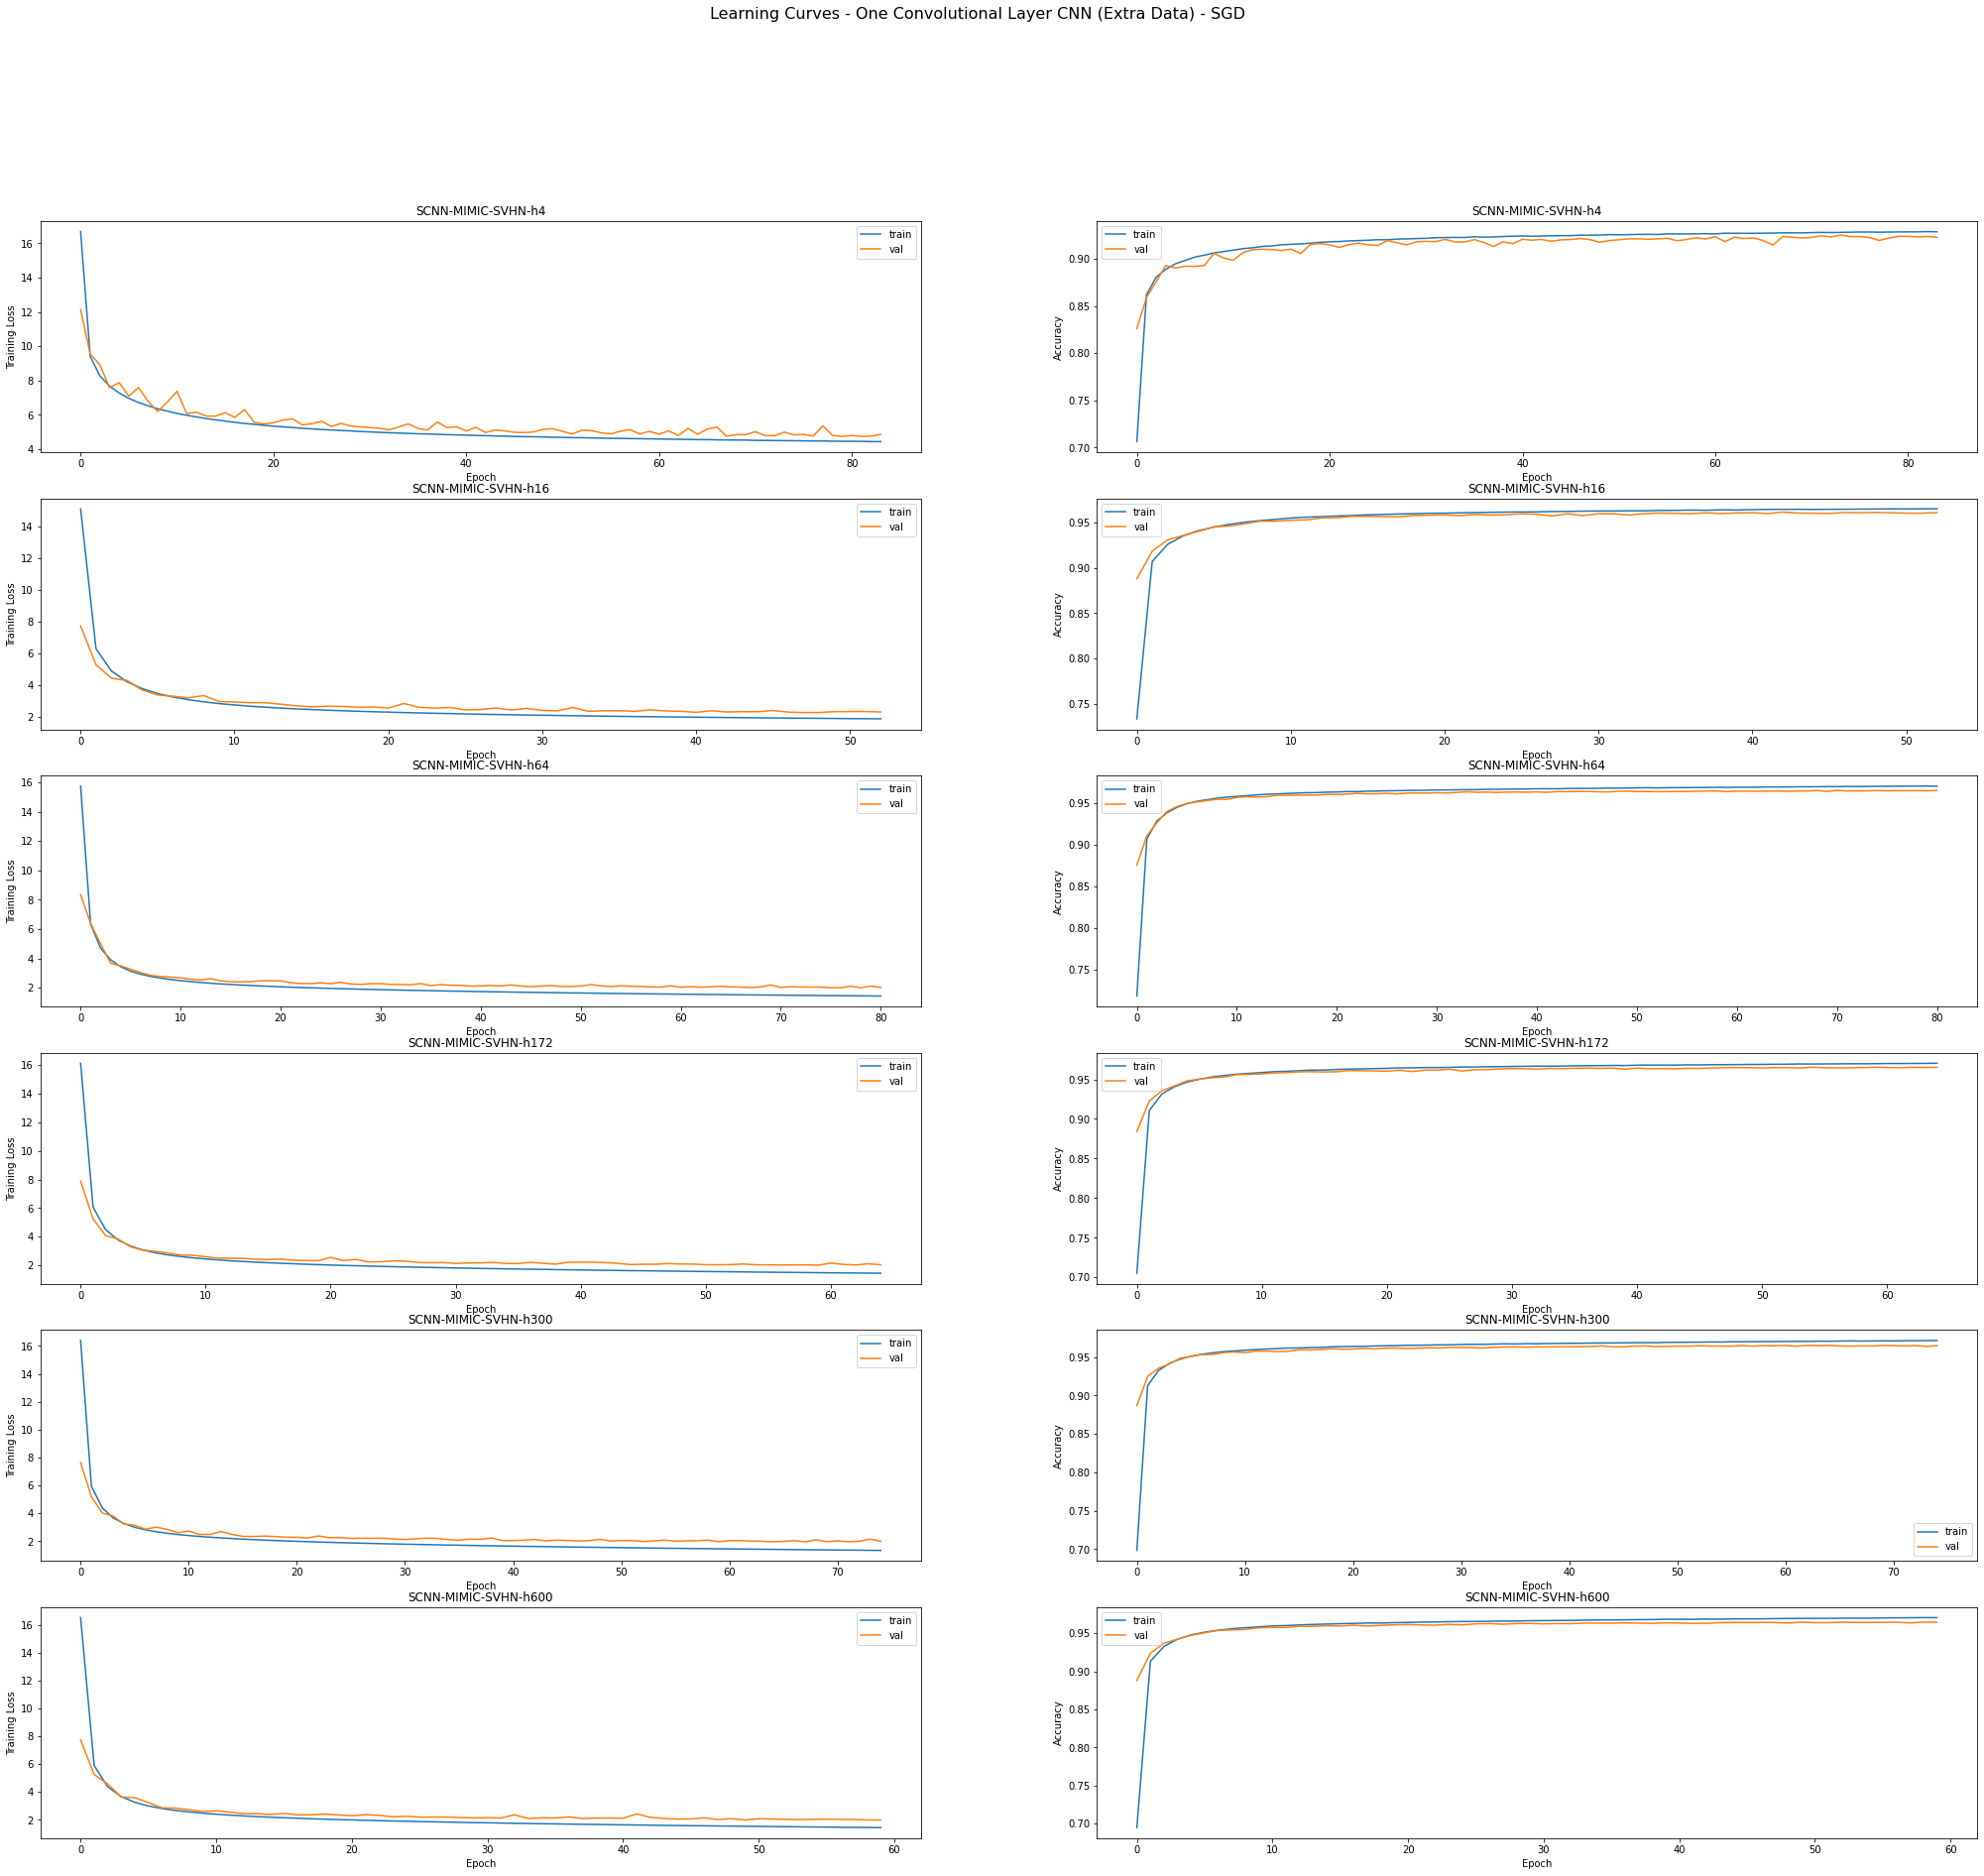

In [ ]:
fig = plt.figure()
fig.suptitle('Learning Curves - One Convolutional Layer CNN (Extra Data) - SGD', fontsize=16)
fig.set_size_inches(35, 30)

plt.subplot(6, 2, 1)
plt.plot(loss_train_4, label='train');
plt.plot(loss_test_4, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h4')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(6, 2, 2)
plt.plot(acc_train_4, label='train');
plt.plot(acc_test_4, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h4')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(6, 2, 3)
plt.plot(loss_train_16, label='train');
plt.plot(loss_test_16, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h16')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(6, 2, 4)
plt.plot(acc_train_16, label='train');
plt.plot(acc_test_16, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h16')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(6, 2, 5)
plt.plot(loss_train_64, label='train');
plt.plot(loss_test_64, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(6, 2, 6)
plt.plot(acc_train_64, label='train');
plt.plot(acc_test_64, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(6, 2, 7)
plt.plot(loss_train_172, label='train');
plt.plot(loss_test_172, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h172')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(6, 2, 8)
plt.plot(acc_train_172, label='train');
plt.plot(acc_test_172, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h172')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(6, 2, 9)
plt.plot(loss_train_300, label='train');
plt.plot(loss_test_300, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h300')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(6, 2, 10)
plt.plot(acc_train_300, label='train');
plt.plot(acc_test_300, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h300')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(6, 2,11)
plt.plot(loss_train_600, label='train');
plt.plot(loss_test_600, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h600')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(6, 2, 12)
plt.plot(acc_train_600, label='train');
plt.plot(acc_test_600, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h600')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

### Training / Evaluation for 2 Layers


#### Load Data

In [ ]:
x_train_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/data/x_train_cnn.npy')
x_test_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/data/x_test_cnn.npy')

x_acc_test_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/data/x_acc_test_cnn.npy')
y_labels_acc_test=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/data/y_labels_acc_test.npy')

x_train_cnn_extra =np.load('/content/drive/My Drive/Colab Notebooks/SVHN/extra_data/x_train_cnn_extra.npy')
x_test_cnn_extra =np.load('/content/drive/My Drive/Colab Notebooks/SVHN/extra_data/x_test_cnn_extra.npy')

y_labels_train_extra =np.load('/content/drive/My Drive/Colab Notebooks/SVHN/extra_data/y_labels_train_extra.npy')
y_labels_test_extra =np.load('/content/drive/My Drive/Colab Notebooks/SVHN/extra_data/y_labels_test_extra.npy')

x_train_cnn_extra_teacher_correct =np.load('/content/drive/My Drive/Colab Notebooks/SVHN/extra_data/x_train_cnn_extra_teacher_correct.npy')
x_test_cnn_extra_teacher_correct =np.load('/content/drive/My Drive/Colab Notebooks/SVHN/extra_data/x_test_cnn_extra_teacher_correct.npy')

y_labels_train_extra_teacher_correct =np.load('/content/drive/My Drive/Colab Notebooks/SVHN/extra_data/y_labels_train_extra_teacher_correct.npy')
y_labels_test_extra_teacher_correct =np.load('/content/drive/My Drive/Colab Notebooks/SVHN/extra_data/y_labels_test_extra_teacher_correct.npy')

#### Training

In [ ]:
# Arrays with the results
scores_2_layer = []
channels_number = []

attack_accuracies_2_layer = []

channels_to_test = [32, 64, 64, 350] 
channels_to_test2 = [32, 128, 512, 1024] 

index_for_two = 0;

for channel in channels_to_test:
  # Set name
  name = 'SCNN-SVHN-h'+ str(index_for_two)
  svhn_model = get_CNN_model()
  svhn_model = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/SVHN/CNN_SVHN.h5')
  train_logits, test_logits = get_logits(svhn_model, x_train_cnn, x_test_cnn)
  svhn_model = get_SCNN_model_layer2(channels_l1=channel, channels_l2=channels_to_test2[index_for_two])
  svhn_model = adjust_model(svhn_model, name)
  svhn_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

  #Save trained SNN model
  svhn_model = train_scnn(svhn_model, x_train_cnn, train_logits, x_test_cnn, test_logits)

  # Learning Curves Data
  loss_train_cnn=svhn_model.history.history['loss']
  loss_val_cnn=svhn_model.history.history['val_loss']
  acc_train_cnn=svhn_model.history.history['accuracy']
  acc_val_cnn=svhn_model.history.history['val_accuracy']

  print ("")
  print (loss_train_cnn)
  print ("")
  print (loss_val_cnn)
  print ("")
  print (acc_train_cnn)
  print ("")
  print (acc_val_cnn)

  name_to_store = 'SCNN_MIMIC_SVHN_h'+str(channel)+str('_')+str(channels_to_test2[index_for_two])+'.h5'
  svhn_model.save(name_to_store)
  print ('Model: '+name_to_store+' was saved')

  svhn_model = get_SCNN_model_layer2(channels_l1=channel, channels_l2=channels_to_test2[index_for_two])
  svhn_model = adjust_model(svhn_model, name)
  svhn_model = keras.models.load_model(name_to_store)

  output = svhn_model.layers[-1].output
  output = Activation('softmax')(output)
  svhn_model = Model(svhn_model.input, output, name=name)

  score = 0;
  preds = svhn_model.predict(x_acc_test_cnn)
  for i in range (len(x_acc_test_cnn)):
    if (np.argmax(preds[i], axis=0) == y_labels_acc_test[i]):
      score = score + 1

  score=score/26032.0
  print ("Test Accuracy: %.5f" % score)
  scores_2_layer.append(score)
  channels_number.append(channel)

  index_for_two = index_for_two + 1

  print ('----------------------------')

#### Results

##### Accuracy Results - Adam

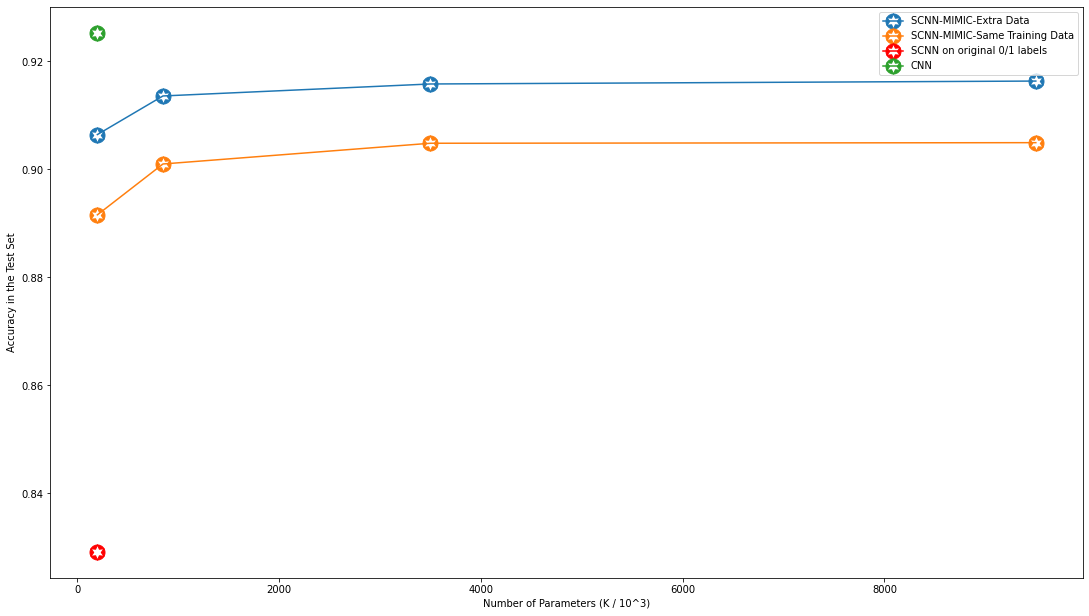

In [ ]:
import matplotlib.path as mpath
import numpy as np

star = mpath.Path.unit_regular_star(6)
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
verts = np.concatenate([circle.vertices, star.vertices[::-1, ...]])
codes = np.concatenate([circle.codes, star.codes])
cut_star = mpath.Path(verts, codes)

fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
plt.plot([200, 850, 3500, 9500 ], [0.90646, 0.91361, 0.91583, 0.91637], label='SCNN-MIMIC-Extra Data', marker=cut_star, markersize=15)
plt.plot([200, 850, 3500, 9500 ], [0.89159, 0.90101, 0.90485, 0.90496], label='SCNN-MIMIC-Same Training Data', marker=cut_star, markersize=15)
plt.plot(200, 0.82916, marker=cut_star, markersize=15, color="red" ,label='SCNN on original 0/1 labels')
plt.plot(200, 0.92528, marker=cut_star, markersize=15, label='CNN')

plt.xlabel('Number of Parameters (K / 10^3)');
plt.ylabel('Accuracy in the Test Set');
plt.legend()
plt.show()

##### Accuracy Results - SGD

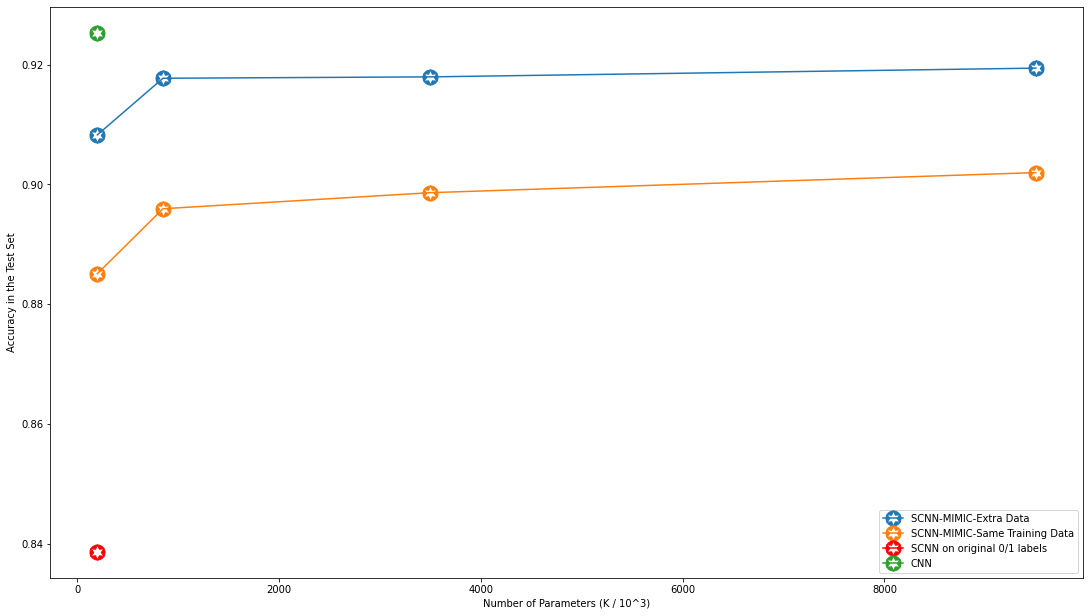

In [ ]:
import matplotlib.path as mpath
import numpy as np

star = mpath.Path.unit_regular_star(6)
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
verts = np.concatenate([circle.vertices, star.vertices[::-1, ...]])
codes = np.concatenate([circle.codes, star.codes])
cut_star = mpath.Path(verts, codes)

fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
plt.plot([200, 850, 3500, 9500 ], [0.90827, 0.91772, 0.91795, 0.91941], label='SCNN-MIMIC-Extra Data', marker=cut_star, markersize=15)
plt.plot([200, 850, 3500, 9500 ], [0.88510, 0.89594, 0.89862, 0.90197], label='SCNN-MIMIC-Same Training Data', marker=cut_star, markersize=15)
plt.plot(200, 0.83866, marker=cut_star, markersize=15, color="red" ,label='SCNN on original 0/1 labels')
plt.plot(200, 0.92528, marker=cut_star, markersize=15, label='CNN')

plt.xlabel('Number of Parameters (K / 10^3)');
plt.ylabel('Accuracy in the Test Set');
plt.legend()
plt.show()

##### Accuracy Results for Teacher Results - SGD

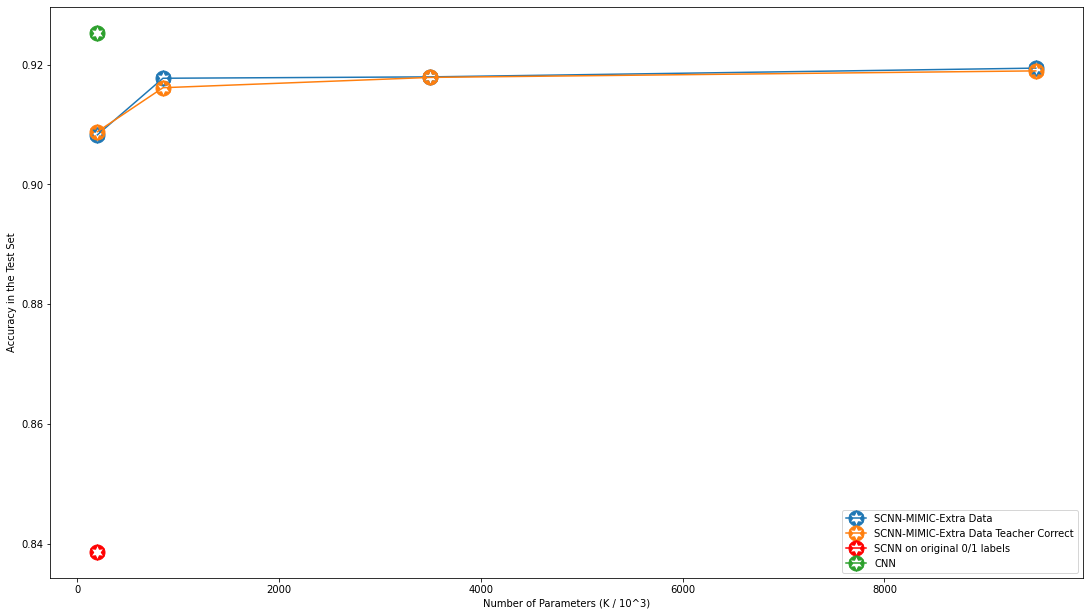

In [ ]:
import matplotlib.path as mpath
import numpy as np

star = mpath.Path.unit_regular_star(6)
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
verts = np.concatenate([circle.vertices, star.vertices[::-1, ...]])
codes = np.concatenate([circle.codes, star.codes])
cut_star = mpath.Path(verts, codes)

fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
plt.plot([200, 850, 3500, 9500], [0.90827, 0.91772, 0.91795, 0.91941], label='SCNN-MIMIC-Extra Data', marker=cut_star, markersize=15)
plt.plot([200, 850, 3500, 9500], [0.90880, 0.91614, 0.91786, 0.91895], label='SCNN-MIMIC-Extra Data Teacher Correct', marker=cut_star, markersize=15)
plt.plot(200, 0.83866, marker=cut_star, markersize=15, color="red" ,label='SCNN on original 0/1 labels')
plt.plot(200, 0.92528, marker=cut_star, markersize=15, label='CNN')

plt.xlabel('Number of Parameters (K / 10^3)');
plt.ylabel('Accuracy in the Test Set');
plt.legend()
plt.show()

##### Learning Curves for Same Data - Adam

In [ ]:
loss_train_32_32 =[23.765450826410078, 9.743887332909425, 7.128627581735101, 6.003618453157385, 5.357728379464945, 4.884058595800062, 4.52686507486461, 4.280849038866048, 4.001782042145597, 3.802319834702414, 3.634973721300393, 3.481102939689844, 3.3414102365677496, 3.2248235961945633, 3.1256799192479847, 3.019185693377308, 2.9523307775029264, 2.877627990534867, 2.8095388321428616, 2.7536339104963785, 2.6938308778674456, 2.64439710681018, 2.5953975467854375, 2.555609240567315, 2.514772217518416, 2.481821731483252, 2.439227230529941, 2.406161930947344, 2.3817796680465735, 2.3432518450354016, 2.3175517515318047, 2.288763340153534, 2.258059374283894, 2.2388842166115954, 2.2093193469565433, 2.189947320348868, 2.1699018558578356, 2.149660185341257, 2.134989195770701, 2.10657206181322, 2.085809375421859, 2.0769750506771514, 2.0499378671459794, 2.044237512639435, 2.0215518560947365, 2.0084958353848927, 1.999169630447393, 1.983182347649733, 1.9643838981304262, 1.9502201980336638, 1.9444393447108383, 1.9275692260852193, 1.9169305290747458, 1.9054533063587338, 1.895640491888025, 1.878327479251425, 1.8721006699973697, 1.8700620525435125, 1.8420916278699326, 1.8494751918662704, 1.8391314430475214, 1.8261900886009703, 1.8144907060494124, 1.805604773521342, 1.807330129439692, 1.8003671298121828, 1.7854826836829685, 1.7777690128970498, 1.7636455371837325, 1.7631372501251894, 1.7550555305649382, 1.74609885363436, 1.7406244246791465, 1.7334017270376796, 1.731660013542211]
loss_test_32_32 =[12.25346598363528, 7.716324437422861, 6.236216202479974, 5.483107450065019, 4.984686722236027, 4.642766733036775, 4.377016006452022, 4.209599479833588, 3.9676623002056735, 3.9545244908287263, 3.8372541502333717, 3.559530603537428, 3.5263251645168645, 3.4339814577277097, 3.3594769561287485, 3.3496310964751497, 3.361663156215721, 3.205910964250369, 3.16247184147055, 3.143897349867637, 3.0745468886211667, 3.140485662077087, 3.0349919188715804, 3.0319793187885247, 2.9847414098474583, 2.9562131492876143, 2.9640885251420395, 2.983347962015221, 2.9452562923806305, 2.868298217633888, 2.8412305151475703, 2.8067905282570695, 2.818111081999441, 2.8686787532126354, 2.8165842338627622, 2.8160366563565282, 2.778464424977887, 2.7712511292514077, 2.8419854712557866, 2.797757149198294, 2.7518313174491174, 2.78025194110032, 2.716282718337171, 2.7166325757648657, 2.68980857579395, 2.7178393434117862, 2.722662207210061, 2.6881978258616672, 2.6868837675109707, 2.6930151589086657, 2.7030282361631737, 2.6767141337997433, 2.7058278383077443, 2.7757304236109777, 2.664121904172697, 2.6582801459169505, 2.6456277691989265, 2.653273009290599, 2.6720111813338248, 2.655096957763622, 2.6421685330762976, 2.705135052951997, 2.6474498779500992, 2.6486674277404276, 2.6564613123458165, 2.664602878605965, 2.673388750280411, 2.6310601875556157, 2.629361094980659, 2.6410614853832133, 2.6281575637862162, 2.6122705422884906, 2.6418968663331492, 2.6769490203602277, 2.6372338096984187]
acc_train_32_32 =[0.4548076, 0.7916901, 0.8355601, 0.8537497, 0.8644655, 0.87352616, 0.8809829, 0.88572645, 0.8906748, 0.8949748, 0.89813155, 0.90147597, 0.9043085, 0.9071752, 0.908472, 0.9108438, 0.9123283, 0.9143759, 0.91625285, 0.91797626, 0.9185735, 0.91896594, 0.92051876, 0.9212866, 0.92299294, 0.923283, 0.92389727, 0.924631, 0.92517704, 0.92655915, 0.9274465, 0.92809486, 0.9277024, 0.92903334, 0.9298695, 0.9306032, 0.9304667, 0.93118334, 0.93200237, 0.9323266, 0.93295795, 0.9327873, 0.9341694, 0.93338454, 0.9345619, 0.9352103, 0.9344083, 0.9351762, 0.93567103, 0.9358417, 0.9365071, 0.93701905, 0.9368825, 0.9378893, 0.9383329, 0.9377869, 0.93891305, 0.9377016, 0.938896, 0.93821347, 0.9389813, 0.9392202, 0.93933964, 0.9401928, 0.9408071, 0.9400734, 0.9400392, 0.9402781, 0.94138724, 0.9411825, 0.94111425, 0.9414726, 0.9416432, 0.9417115, 0.9417968]
acc_test_32_32 =[0.7523205280303955, 0.8357220888137817, 0.8630220890045166, 0.8749658465385437, 0.8839066624641418, 0.8886841535568237, 0.8933933973312378, 0.8969423770904541, 0.9020611643791199, 0.9027436375617981, 0.9045864343643188, 0.9099099040031433, 0.9093639254570007, 0.9104558825492859, 0.9144144058227539, 0.914004921913147, 0.9159841537475586, 0.915438175201416, 0.917963445186615, 0.9198744297027588, 0.9225361943244934, 0.9232186675071716, 0.9202839136123657, 0.9213759303092957, 0.9248566627502441, 0.9223313927650452, 0.9243106842041016, 0.9247884154319763, 0.9256756901741028, 0.926358163356781, 0.9269042015075684, 0.9273819327354431, 0.9275184273719788, 0.9291564226150513, 0.927040696144104, 0.9287469387054443, 0.9260169267654419, 0.9273819327354431, 0.9274501800537109, 0.9274501800537109, 0.9279279112815857, 0.9297024011611938, 0.9292246699333191, 0.9279961585998535, 0.9307944178581238, 0.9306579232215881, 0.9306579232215881, 0.929634153842926, 0.9299072027206421, 0.930726170539856, 0.9288151860237122, 0.9306579232215881, 0.9314769506454468, 0.9274501800537109, 0.9310674071311951, 0.9314769506454468, 0.9314769506454468, 0.9312039017677307, 0.9320911765098572, 0.9304531812667847, 0.9322276711463928, 0.9299072027206421, 0.930726170539856, 0.9310674071311951, 0.9334561824798584, 0.9316134452819824, 0.9287469387054443, 0.9318181872367859, 0.9327054619789124, 0.9305214285850525, 0.9325006604194641, 0.9318181872367859, 0.9318864345550537, 0.9327737092971802, 0.9323641657829285]

loss_train_64_128 =[20.225714355714796, 7.425986870278393, 5.4653407497990205, 4.5740119981436225, 3.9896332954080953, 3.617650558687947, 3.309633957270764, 3.078467761297578, 2.8743981933585614, 2.7196912780514695, 2.585838648085199, 2.4549704498972527, 2.3632358849470694, 2.2662973168746325, 2.1818607376252577, 2.1145178427540414, 2.0480442470092943, 1.980192742515735, 1.9338327426184627, 1.8777482763389182, 1.8182322060936762, 1.785741970388772, 1.735677058364576, 1.69347622526169, 1.6597229393520572, 1.6409150388498943, 1.5832325552380662, 1.5610983085005816, 1.5294679471854717, 1.5041076542747152, 1.4847598188922793, 1.445231625692255, 1.4316087899359813, 1.403579318699358, 1.3865147281756895, 1.3617871822426826, 1.3390795874296628, 1.3217140652622625, 1.307143161653018, 1.2873448615228344, 1.2657949480787904, 1.251437482767957, 1.23462279853881, 1.2265582341788195, 1.2123321606695687, 1.1952695373361524, 1.1754282609013484]
loss_test_64_128 =[9.537695060165534, 5.934888995412982, 4.85271056037505, 4.2529248782529425, 4.011264668505536, 3.7139172897682533, 3.3845339815960926, 3.1551479409374306, 3.0011022631145066, 2.9135317801778315, 2.847812024159995, 2.755419297066016, 2.6624715739574842, 2.6145180565003256, 2.6016460578688303, 2.5444715830136153, 2.521738857120365, 2.521929756006256, 2.4229232332858106, 2.411415716809651, 2.417849614780977, 2.3954804123277844, 2.3839525039359386, 2.3601239233956846, 2.3175742734887708, 2.336083190349357, 2.2931072417094414, 2.302348143345601, 2.306674578070738, 2.2636998087013156, 2.275481201214052, 2.3529420272593873, 2.2878465425307524, 2.271733593817067, 2.286443624605808, 2.2792180318048736, 2.2664476250027037, 2.252300795850095, 2.2501544445354433, 2.2485333973678645, 2.2575242954168755, 2.282964475617655, 2.2600065396842886, 2.286468095867939, 2.2568910349726905, 2.2683884185616057, 2.2586287415291224]
acc_train_64_128 = [0.5435543, 0.8304411, 0.861906, 0.8782186, 0.89082843, 0.8994966, 0.90495694, 0.9095982, 0.91377866, 0.91802746, 0.9210136, 0.92432386, 0.92526233, 0.92823136, 0.93075675, 0.93137103, 0.9333504, 0.93538094, 0.93715554, 0.9376845, 0.93968093, 0.94079006, 0.94092655, 0.942667, 0.94382733, 0.94382733, 0.9450388, 0.9467281, 0.94664276, 0.9477007, 0.9480932, 0.94903165, 0.9490487, 0.9500555, 0.9505332, 0.9514888, 0.951284, 0.9520689, 0.95188123, 0.9522225, 0.95331454, 0.95341694, 0.95437247, 0.9544408, 0.95481616, 0.95505506, 0.95580584]
acc_test_64_128 =[0.8005732893943787, 0.8654108643531799, 0.8774228692054749, 0.8927108645439148, 0.9007644057273865, 0.9040403962135315, 0.9112749099731445, 0.9178268909454346, 0.920556902885437, 0.923082172870636, 0.9245836734771729, 0.9243789315223694, 0.9286786913871765, 0.9294294118881226, 0.929634153842926, 0.9301119446754456, 0.9311356544494629, 0.9330466985702515, 0.9344117045402527, 0.934002161026001, 0.9345481991767883, 0.9359814524650574, 0.9368004202842712, 0.9369369149208069, 0.9368686676025391, 0.9364591836929321, 0.9377559423446655, 0.9376194477081299, 0.9383019208908081, 0.9389162063598633, 0.938643217086792, 0.9371417164802551, 0.9388479590415955, 0.9380289316177368, 0.9384384155273438, 0.9380289316177368, 0.9400764107704163, 0.9383701682090759, 0.9400764107704163, 0.938643217086792, 0.9387797117233276, 0.9378241896629333, 0.939393937587738, 0.9355719089508057, 0.9383701682090759, 0.9382336735725403, 0.938643217086792]

loss_train_64_512 =[17.280950543791164, 6.1973100670937455, 4.605129666308496, 3.7946851183861434, 3.2622095634217008, 2.8896581726669806, 2.6158687673690286, 2.397302948733908, 2.218367187936765, 2.066717254671055, 1.9384302561808524, 1.8278381279838867, 1.7390903051594562, 1.6312946662592833, 1.5659986255905467, 1.502452400810594, 1.4262775081201335, 1.3655171866750933, 1.3155701946107694, 1.256845023041953, 1.2168725177601187, 1.1630074450611896, 1.1279339962064199, 1.0926106791947443, 1.0514499545738096, 1.0159898836654808, 0.9876030436026726, 0.9562872628803171, 0.932875621067604, 0.9049000725131039, 0.8814302216403243, 0.8497482960271546, 0.827337256492725, 0.8108445777664025, 0.7847172894409498, 0.7687157719902756, 0.7580324865915132, 0.7321808818236684, 0.7134055443799046, 0.6981498765229426, 0.6848344899965079]
loss_test_64_512 =[7.6534687489263025, 4.9678826332092285, 4.128717029091441, 3.5866126732327657, 3.2221839064104194, 2.9130155397118878, 2.8034274770105077, 2.5915779424371075, 2.5356422087679524, 2.3960951595009594, 2.3650909596182044, 2.3445230267785333, 2.2260765051080202, 2.2476697973693422, 2.143482596829326, 2.1743647975411338, 2.1410321667648033, 2.101193842912612, 2.1293045139494993, 2.1075319311445018, 2.1305265888437495, 2.071619409340638, 2.058809059518236, 2.0437349740709725, 2.0361345192138334, 2.0346138123244883, 2.0407041374399726, 2.0524736633725156, 2.044877249980409, 2.0729359857963794, 2.059938808591386, 2.0610122194779628, 2.0768588903072, 2.1045990617360504, 2.052239743080941, 2.066309859672596, 2.0490605645319038, 2.0661293513912207, 2.0634929043915373, 2.091157836957021, 2.049812480526611]
acc_train_64_512 =[0.6082928, 0.84980804, 0.878321, 0.89441174, 0.9052129, 0.91411996, 0.91980207, 0.9245969, 0.92956233, 0.932975, 0.93596107, 0.9388448, 0.94058526, 0.94350314, 0.94515824, 0.94684756, 0.9483833, 0.9499531, 0.95113045, 0.95336574, 0.95389473, 0.955584, 0.95633477, 0.95766574, 0.9591673, 0.95995224, 0.9607542, 0.961505, 0.9620169, 0.96321136, 0.9645764, 0.9642863, 0.9654125, 0.9657538, 0.9666752, 0.96711886, 0.9678014, 0.9682621, 0.96901286, 0.96945655, 0.9699514]
acc_test_64_512 =[0.8362680673599243, 0.877764105796814, 0.8990581631660461, 0.912162184715271, 0.9177586436271667, 0.9232186675071716, 0.9246519207954407, 0.9311356544494629, 0.9316134452819824, 0.9338656663894653, 0.9355036616325378, 0.9346164464950562, 0.9356401562690735, 0.9369369149208069, 0.9402812123298645, 0.9410319328308105, 0.9389162063598633, 0.9405542016029358, 0.9411001801490784, 0.9408954381942749, 0.940485954284668, 0.9411001801490784, 0.9419874548912048, 0.9425334334373474, 0.9406906962394714, 0.9424651861190796, 0.9413731694221497, 0.9411684274673462, 0.9441031813621521, 0.9411684274673462, 0.9441714286804199, 0.9415779709815979, 0.9413049221038818, 0.9402812123298645, 0.9420557022094727, 0.941919207572937, 0.9415779709815979, 0.9415096640586853, 0.9426016807556152, 0.9415096640586853, 0.9420557022094727]

loss_train_350_1024 =[19.64832778761751, 6.417012374338645, 4.616439513994986, 3.7456121730617307, 3.218629844867474, 2.8472794865882496, 2.576399409694686, 2.354533218462794, 2.169826676554469, 2.0271019136689037, 1.898140537204845, 1.796187032716346, 1.7110886913407288, 1.62149963956188, 1.5481231859667839, 1.471638355339746, 1.4141785375433829, 1.3666181663697556, 1.3143392569334695, 1.2694837548913591, 1.2240699317937174, 1.183003672488811, 1.136706246095818, 1.1170138893370722, 1.0704015830832225, 1.048445301492836, 1.016261983383598, 0.9949383787099498, 0.9610172308505308, 0.9450461890762367, 0.9123630160368421, 0.9039702029838852, 0.8873238386640816, 0.8563238796088569, 0.8429994973791773, 0.8347819353622662, 0.8110197699127949, 0.7974099758104419]
loss_test_350_1024 =[8.367122933931634, 5.1610350895214365, 4.038591516886843, 3.445752376225227, 3.04095368446498, 2.9776622389887906, 2.7444010200703564, 2.5988479084959453, 2.4994362591069934, 2.409589791473651, 2.364544174432299, 2.351275709330824, 2.221257901406503, 2.1956893524900996, 2.181459550092105, 2.1396224024905686, 2.1007784591683136, 2.2068507470884122, 2.107684627504841, 2.173908925075984, 2.0929220193987366, 2.0644333090835536, 2.116159983453222, 2.087008162336274, 2.144771343464738, 2.1072394259471303, 2.116627639608568, 2.08038694797368, 2.14158346572926, 2.077686222140463, 2.1221834464441582, 2.139942667701028, 2.0734858771604556, 2.112865295854059, 2.1091820569497917, 2.1153536906113497, 2.146245373587383, 2.136452419003469]
acc_train_350_1024 =[0.5562324, 0.84608823, 0.87796265, 0.8953502, 0.905793, 0.9142906, 0.92082584, 0.9253818, 0.92990357, 0.93415236, 0.9363365, 0.93915194, 0.94036347, 0.94363964, 0.9452948, 0.9469499, 0.94875866, 0.9505503, 0.9510622, 0.95288795, 0.95389473, 0.9547308, 0.95638597, 0.9559764, 0.95788753, 0.95857006, 0.95891136, 0.9594915, 0.96085656, 0.96138555, 0.9625971, 0.96252877, 0.96310896, 0.9632284, 0.96420103, 0.9650883, 0.9647982, 0.965549]
acc_test_350_1024 =[0.8225498199462891, 0.8767403960227966, 0.8964646458625793, 0.9122304320335388, 0.9189189076423645, 0.9221948981285095, 0.924515426158905, 0.9293611645698547, 0.9323641657829285, 0.9333196878433228, 0.9348211884498596, 0.9357767105102539, 0.9387114644050598, 0.9370051622390747, 0.9383019208908081, 0.9388479590415955, 0.9395986795425415, 0.9362544417381287, 0.9404177069664001, 0.9391209483146667, 0.9399399161338806, 0.9413731694221497, 0.9402812123298645, 0.9402812123298645, 0.9402129650115967, 0.9389162063598633, 0.939393937587738, 0.9420557022094727, 0.9399399161338806, 0.9399399161338806, 0.9406906962394714, 0.9410319328308105, 0.9410319328308105, 0.9411001801490784, 0.9391209483146667, 0.9408954381942749, 0.9399399161338806, 0.9405542016029358]


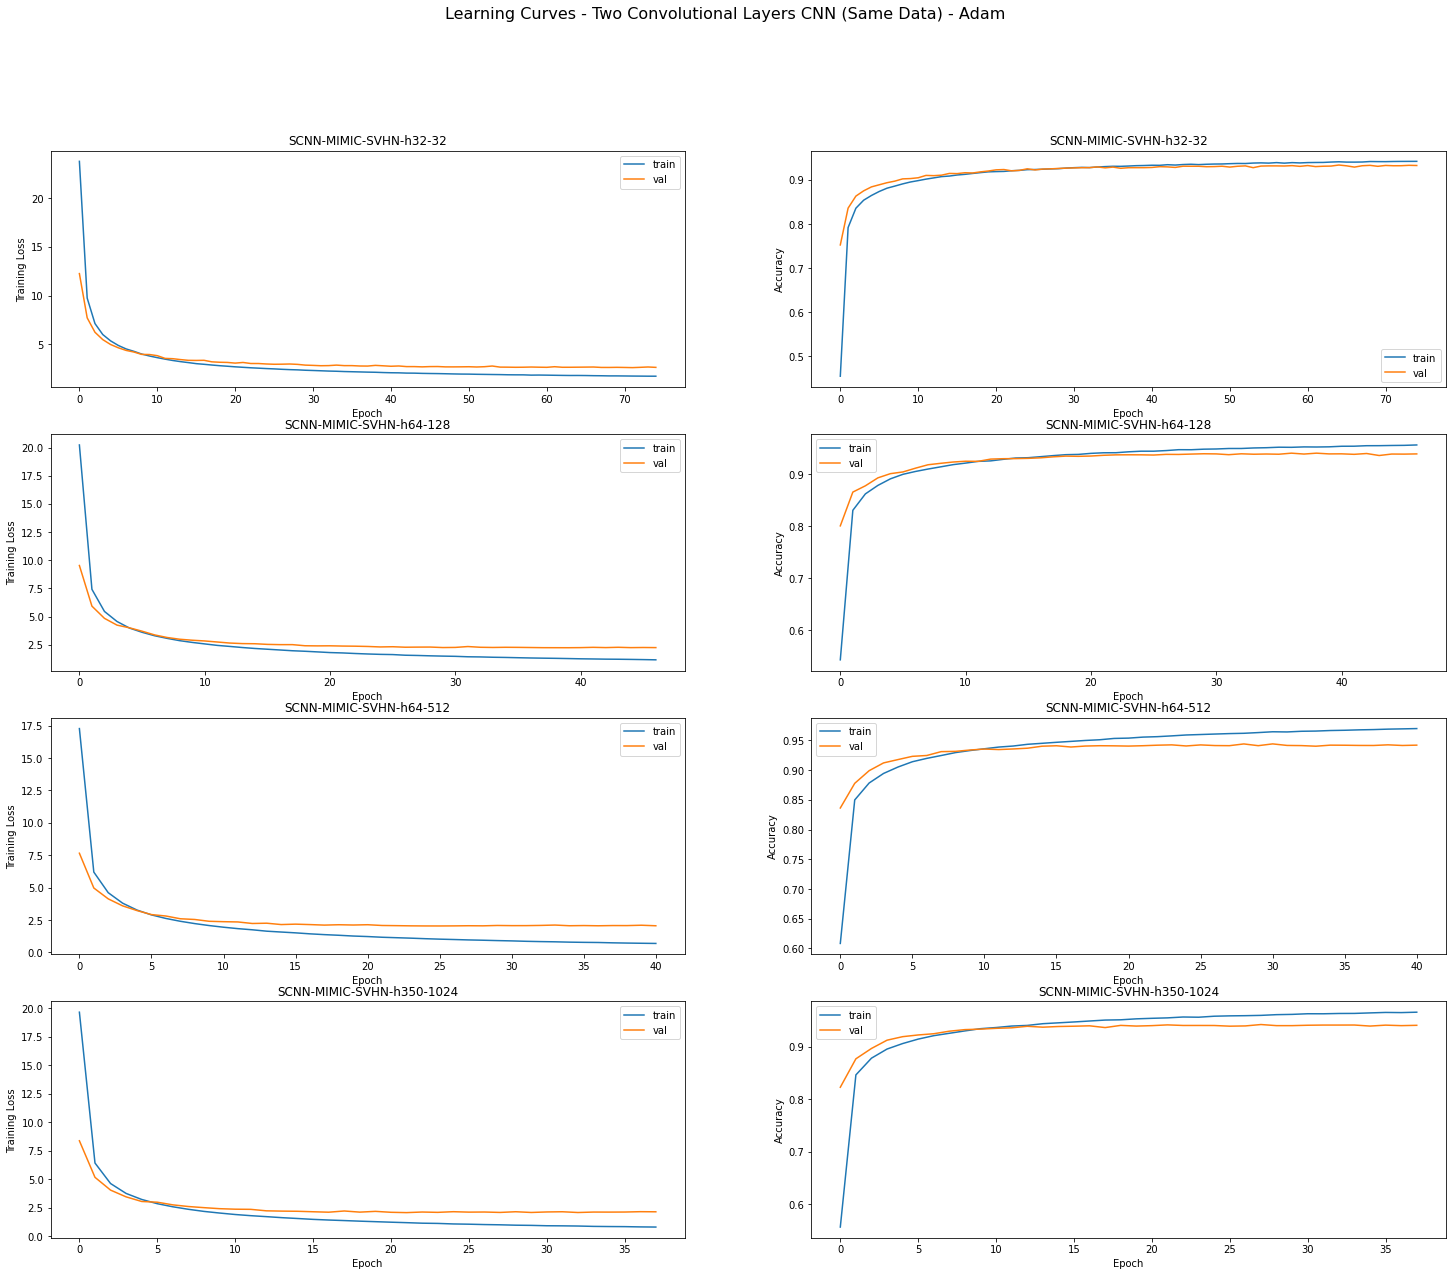

In [ ]:
fig = plt.figure()
fig.suptitle('Learning Curves - Two Convolutional Layers CNN (Same Data) - Adam', fontsize=16)
fig.set_size_inches(25, 20)

plt.subplot(4, 2, 1)
plt.plot(loss_train_32_32, label='train');
plt.plot(loss_test_32_32, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h32-32')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 2)
plt.plot(acc_train_32_32, label='train');
plt.plot(acc_test_32_32, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h32-32')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 3)
plt.plot(loss_train_64_128, label='train');
plt.plot(loss_test_64_128, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-128')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 4)
plt.plot(acc_train_64_128, label='train');
plt.plot(acc_test_64_128, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-128')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 5)
plt.plot(loss_train_64_512, label='train');
plt.plot(loss_test_64_512, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-512')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 6)
plt.plot(acc_train_64_512, label='train');
plt.plot(acc_test_64_512, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-512')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 7)
plt.plot(loss_train_350_1024, label='train');
plt.plot(loss_test_350_1024, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h350-1024')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 8)
plt.plot(acc_train_350_1024, label='train');
plt.plot(acc_test_350_1024, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h350-1024')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

##### Learning Curves for Same Data - SGD

In [ ]:
# Curves for Same Data
loss_train_32_32 = [33.408360814873284, 18.895979557520658, 10.8651216794175, 8.600280705479548, 7.350874507078365, 6.582899980152053, 5.981131118552777, 5.550085189600628, 5.175174495997094, 4.9258792339295985, 4.671210075932023, 4.458351598901865, 4.294478744533361, 4.128855554037011, 3.996419843623748, 3.8769617400573346, 3.759534956121107, 3.6676661888941413, 3.582328647684801, 3.4972302202702017, 3.4163462809761294, 3.3340430635283522, 3.291961508909495, 3.212989260094451, 3.171321212398183, 3.1081253876387893, 3.05256184047933, 3.0084203062219412, 2.9466526757998532, 2.913511918085588, 2.8734668562491796, 2.829617355106003, 2.8078947833633783, 2.735094931353258, 2.721662982162503, 2.702698240055585, 2.6667863678214148, 2.63056504086274, 2.605802055898659, 2.572659970965262, 2.5515550034982475, 2.531697542648472, 2.4985827676286347, 2.47601798705381, 2.4659690221191397, 2.4337959735103256, 2.415171823976756, 2.3907195065617715, 2.368403969790665, 2.341736229978805, 2.3261727116761093, 2.3039636957534557, 2.2933450444344112, 2.273713003312674, 2.260330566466134, 2.2414106803505445, 2.2229602846917453, 2.2110254636977213, 2.1942440848679645, 2.185125392460292, 2.1689782992004076, 2.15954338004896, 2.140145190825347, 2.127032742717142, 2.111347870175398, 2.091420154727753, 2.0865199139313266, 2.0742981987005207, 2.06096545495166, 2.0480753276018793, 2.037494364096823, 2.0331940426821187, 2.0177410040950523, 2.0048298952471892, 1.9981440120747793, 1.9880871488824048, 1.9841220322937578, 1.9686552074803558, 1.9511083569261016, 1.9486676137283203, 1.9403648270182352, 1.937071598582011, 1.922972381120045, 1.9051853431409236, 1.8989988160228966, 1.902942365811207, 1.882851509713911, 1.8893998289177436, 1.867994980850314, 1.8693679443327968, 1.855829908290258, 1.8559453618718682, 1.8367822270254646, 1.8328157278104362, 1.8289734992524502, 1.8123523232005438, 1.8041228361803459, 1.8081477655484484, 1.7974937334716468, 1.7868537388404435, 1.7870866441551752, 1.7856402113132332, 1.7694623790008197, 1.7603998230724305, 1.751944673845522, 1.7484024511894138, 1.7453629132637687, 1.7347481990367029, 1.7389819332137775, 1.724221178269124, 1.719157210855636, 1.7167004765386966, 1.7142259306350713, 1.7017240726360943, 1.6957412089110335, 1.6878822344906166, 1.686918842207703]
loss_test_32_32 = [31.25742976860111, 12.450627380598123, 9.469752934341576, 7.366226893385154, 6.803689696572044, 6.058412625039174, 5.948521007841935, 5.216716263094399, 5.625378637733012, 5.185171107141952, 4.779314594388562, 4.70564979033297, 4.208189347842792, 4.396550352443869, 4.359669179041594, 4.107876530833951, 4.206465614971293, 3.9036892887805936, 3.959971799376621, 3.6902544255664105, 3.7959019158858274, 3.9802935389004017, 4.3250253203785425, 3.6563521342755276, 3.7038105998636754, 3.645897251382214, 3.5069180906974258, 3.4313211334946048, 3.589114386040169, 3.367560664650003, 3.4771638934546534, 3.292902030744352, 3.273856275172107, 3.5273938478422466, 3.382691977878688, 3.411986736205963, 3.288637051255593, 3.2395061127904525, 3.212450931217382, 3.1430560150922338, 3.168610445762507, 3.2234965391312667, 3.353754992111439, 3.250637425186528, 3.1472444464657237, 3.385497070094324, 3.219257752556245, 3.1395713445302604, 3.103474576519449, 3.07287907984424, 3.101574203794262, 3.0202361118458283, 3.0317249406793225, 3.0147729281874063, 3.0766055271529837, 3.0664829855696802, 2.982604934516384, 3.2206824610150644, 3.019858170232583, 2.987153493085586, 2.966513231547192, 3.117339737129576, 2.9459139374543692, 2.941557533715613, 2.9395501996987248, 2.942515076427163, 2.9657056992932027, 2.954231450051972, 2.920900597586646, 2.9156249899243254, 2.9422190872789113, 2.9598174287164403, 2.904987813344003, 2.92544423222314, 2.903116746252103, 2.871514864512034, 3.0148229390716343, 2.899991235282621, 2.9470851026920877, 2.995942129191889, 2.844726075118531, 2.869722819217658, 2.8727440049080064, 2.856348221399014, 2.8999022954544538, 2.835061801511539, 2.924353786612221, 3.016154950673288, 2.853956475142016, 2.873450066331889, 2.868203117520048, 2.9106893103987734, 2.834872854820145, 2.842598898893102, 2.955472969468617, 2.8209710408845234, 2.8478106422044203, 2.838747601739507, 2.809471237506497, 2.8440199732747913, 2.8711474247718165, 2.85898973952868, 2.873075481128927, 2.8097215870381573, 2.8520945114351313, 2.8774961900619935, 2.7960918116302658, 2.948662314817224, 2.8704859023858313, 2.844443830218824, 2.8657979516751317, 2.9319004256836614, 2.8325396796051283, 2.896275958694658, 2.8599498151528713, 2.920086433221628, 2.8233985071002605]
acc_train_32_32 = [0.20081904273006293, 0.5928675027311016, 0.7681597133706367, 0.8088047094591627, 0.8287859397682656, 0.8426414128243237, 0.8537838068444537, 0.8620766146182404, 0.8683047521034002, 0.8729289309999436, 0.8779967579893687, 0.8815800699426111, 0.8855217131979687, 0.8889855813841783, 0.8916986605187608, 0.8942411056954994, 0.8959474447257445, 0.8981144952993733, 0.9004351164525548, 0.9018172511091493, 0.9033017660293875, 0.904803344438776, 0.9069703950124047, 0.9084037198069234, 0.9082842761263406, 0.9105707703805521, 0.9109120382362336, 0.9123112362111127, 0.9138810681173921, 0.9145806671734831, 0.9149731251284405, 0.9158604214342164, 0.9156897876136753, 0.9176179507396884, 0.9177544578443299, 0.9188294513682621, 0.9198532548752999, 0.9195119870002945, 0.920894121676213, 0.9212353894861268, 0.9218326080883844, 0.9220032420126654, 0.9228393481398349, 0.9227199044134844, 0.9243579899081902, 0.924136165843951, 0.9244262434437295, 0.9251429058903161, 0.9251940961004513, 0.9261155191872187, 0.9262861530657321, 0.926354406627715, 0.9278559849791311, 0.9274635269977302, 0.927890111733679, 0.9285043938108479, 0.9282313795435928, 0.9289992321809906, 0.9297158945553662, 0.9294258168589671, 0.9312345363552502, 0.93026192301258, 0.9303643034013218, 0.9305690640415025, 0.9311662827474999, 0.9310127122330387, 0.9314222336120547, 0.9316099308424156, 0.9322924664815674, 0.9326507977084204, 0.9331797628331109, 0.9329238119756755, 0.9343400733410504, 0.9342888832082115, 0.9341182493032545, 0.9345960242706968, 0.9344083269416813, 0.935449193788362, 0.9356880811830905, 0.9353297500477727, 0.9358928418954824, 0.9358928418761583, 0.9359952222913435, 0.9363876802076527, 0.9365583141248144, 0.9362852998575592, 0.9366606944677884, 0.936677757819636, 0.9371384693630197, 0.9373261666584722, 0.9373773569143751, 0.9381110826863658, 0.9381793362869967, 0.9379745755095132, 0.9385547307863668, 0.9389471888470982, 0.9392202030156988, 0.9391860762875943, 0.9388618718681762, 0.9389130619867763, 0.9396126610815154, 0.9399027386812939, 0.9400563091957552, 0.9403634501789101, 0.9400733725862509, 0.9415749509498718, 0.9407729716423419, 0.9410459858709488, 0.9411654295779751, 0.9411995563660859, 0.9414384438716737, 0.9422916133456055, 0.9418820919330266, 0.9417285214256848, 0.9415237607712652, 0.9426328811941674, 0.9422574866154669]
acc_test_32_32 = [0.2553917553917554, 0.7530030029379147, 0.7957957957795238, 0.8348348347534744, 0.844389844308484, 0.8660251161227486, 0.8562653562979005, 0.879879879912424, 0.8680726181702506, 0.8714851214525773, 0.8912093913070237, 0.8858176357850917, 0.8956456456131014, 0.8950996451972776, 0.8979661479986921, 0.9002184001207677, 0.9013786513461072, 0.9009009008032683, 0.9057466557141116, 0.910182910150366, 0.9027436527111086, 0.9064291564617006, 0.9052689053014494, 0.9062244061267737, 0.9090909091234533, 0.911479661382029, 0.9127764126787803, 0.9138001637025313, 0.9122304121327798, 0.9182364183177787, 0.9145509145183703, 0.9172809173622777, 0.9178951677975354, 0.9173491672515348, 0.9162571661595338, 0.9158476659290262, 0.9150969149992826, 0.9159159158182834, 0.9169396668420344, 0.9189189190002793, 0.9208299207322883, 0.9190554191367795, 0.9154381653405329, 0.9189871690685294, 0.9195331696145299, 0.9177586676610352, 0.9204204205017809, 0.9200791701605305, 0.9208981708656268, 0.9233551734365337, 0.9194649194323753, 0.9221266720290396, 0.9236964237777842, 0.9222631723445327, 0.9241059241872845, 0.9206934207747811, 0.9233551732575408, 0.9243789242812919, 0.9213759214572818, 0.9233551734365337, 0.9235599234622911, 0.9208299209112812, 0.9255391754415431, 0.9251296752110355, 0.9254026754840359, 0.9233551732575408, 0.9259486760300364, 0.9259486758510435, 0.926631176712537, 0.9257439256462933, 0.9255391754415431, 0.9249249250062853, 0.9251296752110355, 0.926631176712537, 0.9270406769430445, 0.9272454271477948, 0.9247884246907923, 0.9263581764395368, 0.9258121758935363, 0.9246519246193805, 0.927518427599788, 0.9263581762605438, 0.9282009281032957, 0.9266994267807871, 0.927586677668038, 0.9277914278727882, 0.9284739285552889, 0.9257439258252862, 0.9277914276937953, 0.9274501775315379, 0.927518427599788, 0.9256074255097931, 0.9288834289647893, 0.929429429331797, 0.9249931750745354, 0.9293611794425398, 0.9288151788965392, 0.929497679400047, 0.9297024297837901, 0.928610428691789, 0.9290881791695396, 0.9286786785810461, 0.9291564292377896, 0.92949767957904, 0.9284739285552889, 0.9272454271477948, 0.9307944308757912, 0.9262899263712867, 0.929429429331797, 0.9289516788540464, 0.9299754300567904, 0.9299071799885403, 0.92956592964729, 0.9288151788965392, 0.9291564292377896, 0.9288834289647893, 0.9293611792635469]

loss_train_64_128 = [33.88572536133609, 20.91957217568719, 10.56265487791318, 7.929339591424098, 6.6786845384751885, 5.848679158557611, 5.266309355338801, 4.800630779142684, 4.456193818379645, 4.174708395416791, 3.9310903023497743, 3.716143279343719, 3.5522906730854618, 3.4264503419811168, 3.2688504841575625, 3.1689597946884955, 3.0455141420789915, 2.985699333716208, 2.8883739425993427, 2.803184568466012, 2.733513448767446, 2.66647249909658, 2.6138893128621192, 2.5521002246784112, 2.492832819083762, 2.444839901338715, 2.4000152506648087, 2.351785560122489, 2.318544458836462, 2.2654378576517087, 2.2343535024104146, 2.193579395026256, 2.160625386114017, 2.1418793757288705, 2.096809869054214, 2.0651676270164594, 2.0428089796993354, 2.0096366792701126, 1.9818659520741158, 1.9598083308853496, 1.9302750844656835, 1.917609994487341, 1.8889613833934737, 1.8612804098652447, 1.8352277246598405, 1.8209030959622647, 1.8003764444544357, 1.7783694838472686, 1.768024712340761, 1.742272987045146, 1.7349113228886357, 1.7053243268849185, 1.69496562102988, 1.6695525782047893, 1.6515644925882076, 1.6400628342053638, 1.631836360776885, 1.6115655837312473, 1.5918330546786645, 1.5734702220112378, 1.5704771699356999, 1.5473923174047945, 1.5388304247179594, 1.5215651607891774, 1.517563437699519, 1.4963538496092148, 1.4881534154215177, 1.4664483755381987, 1.4578901990751043, 1.446282230515029, 1.4307537528823926, 1.4222387503727376, 1.4151453938157512, 1.4051709132637549, 1.3952339714902342, 1.3850637087530269, 1.3759458082729756, 1.3642308452676337, 1.349006654174547, 1.3349325070984484, 1.3277372559125225, 1.3178526804437207, 1.3168539197440237, 1.3000938340000667, 1.2960795830118097, 1.28796616041582, 1.2722966999458825, 1.266524083682899, 1.2595447161714124, 1.251230484102277, 1.239435113793438, 1.2315685092604474, 1.2260500314058516, 1.2174809837898657, 1.2055102541975353, 1.199470408724982]
loss_test_64_128 = [30.759968551169187, 11.887245580208226, 8.297799693473921, 7.3936037518696285, 5.986421895684553, 5.437090167900333, 4.944511119244758, 4.592909538514816, 4.7512320719746794, 4.250564321025355, 5.29111532210783, 3.7642577523713943, 3.705866276095091, 3.666300104317234, 3.6950470477611095, 3.402783310026085, 3.31833432907294, 3.4833058623580246, 3.2498533507041714, 3.153711100923797, 3.115077446107815, 3.2104441933445744, 3.170968287569755, 3.113496244783581, 2.9476396781058054, 2.91729531019983, 3.020646837152746, 2.8793566182699157, 2.8435873935172506, 2.8236761133494417, 2.8251359167236987, 2.804411773176555, 2.778040659092438, 2.837443300260731, 2.7180004193422866, 2.7528156148518432, 2.7550481605685997, 2.6932686387337266, 2.6588744950561356, 2.6817129472549777, 2.8179037820892585, 2.74108664071075, 2.6294375633627154, 2.628124148410232, 2.626379573211753, 2.5973840218048556, 2.6156670574669367, 2.6378387408994635, 2.59761068979118, 2.564052401817857, 2.615746562154834, 2.5657173797077344, 2.5295961958900555, 2.6106652801491803, 2.5600215651902416, 2.565874331706279, 2.6509686887117803, 2.5548144198492384, 2.535397704364236, 2.5673955111044076, 2.5040070569941557, 2.5210472564374427, 2.493870203006212, 2.569154654049073, 2.602304197028137, 2.494104622883319, 2.582029212344516, 2.53297595186309, 2.482783658238275, 2.5093881895787526, 2.58898971225927, 2.460053439743038, 2.535632497262603, 2.487226108954052, 2.6305177349097866, 2.4709933031265963, 2.5336155827631885, 2.4540877354590904, 2.47834457844748, 2.4640312111511147, 2.4545993861558495, 2.611750466231925, 2.49152817063536, 2.4518336685439976, 2.4583584049702862, 2.4847101423215125, 2.461296832336938, 2.463931207021598, 2.465295293049314, 2.497462787427702, 2.4460777038763757, 2.438694309739184, 2.472633412129691, 2.473088968265522, 2.44325993310354, 2.486266204056569]
acc_train_64_128 = [0.1928333759994375, 0.5338964252166399, 0.7768961692586631, 0.821687569322058, 0.8405255524293014, 0.8545345959804965, 0.8669055541671692, 0.8744305093564451, 0.883030458101182, 0.8877228905403841, 0.8930637317319726, 0.8961863321926842, 0.899991468338315, 0.9029434348747456, 0.9060830986801852, 0.9089838751102204, 0.9108267212257828, 0.912106475590256, 0.9153997099101568, 0.9161504991184108, 0.9171231123308976, 0.9188977049231255, 0.9202798396183681, 0.9215425305150493, 0.9226004606728953, 0.9239314051386786, 0.9247845747478789, 0.9259619486727575, 0.9260643289770835, 0.9276512243511551, 0.9281972527890449, 0.9294258169047347, 0.9301595427346976, 0.9312515997264219, 0.9314392969567828, 0.9324631004058483, 0.9330091289210346, 0.9338111083007756, 0.9338964251688383, 0.9344936439399273, 0.9355345106757488, 0.9358928418690389, 0.9372579131737858, 0.9366095043034208, 0.9376844979626217, 0.9382817165842032, 0.9390836959375007, 0.9396809145855258, 0.9401074994130099, 0.940056309157107, 0.940073372605575, 0.9413701902445993, 0.9408582885754961, 0.941813838443255, 0.9425475641623585, 0.9431959730469625, 0.9432812899729974, 0.9428035151113291, 0.9443050934363018, 0.9452606433355892, 0.9445269174863022, 0.9444245371626522, 0.9452606433040605, 0.945482467373385, 0.94609674943123, 0.9467622217063295, 0.9467451582700662, 0.9471034894440323, 0.9472229331724168, 0.947666581311066, 0.9483149902414374, 0.948536814291438, 0.9486733213696359, 0.9487074482228384, 0.9491169695031998, 0.9497653784335712, 0.9492876034539243, 0.9499530757025804, 0.9502943434474025, 0.9498165685399667, 0.9507550550365538, 0.9507038648386232, 0.9510451326749805, 0.951284020103272, 0.9513693371137227, 0.9520177459790025, 0.9517447316659797, 0.9524443306956272, 0.9524272673051315, 0.9529391689742347, 0.953041549336533, 0.9532121832872574, 0.9531439297252746, 0.9544919375744343, 0.9537582117831196, 0.9545090009913735]
acc_test_64_128 = [0.19423969428851048, 0.7596915096752376, 0.8174310675287, 0.8365410865736307, 0.8640458640784082, 0.8710073709097385, 0.8809718808742485, 0.8899126398800957, 0.8967376468190071, 0.8968058967082643, 0.8878651378976821, 0.9037674037999479, 0.9080671580997023, 0.9068386568061126, 0.9110019110995435, 0.910865410897955, 0.9156429156754599, 0.9084084084409526, 0.9173491674467998, 0.9186459186133745, 0.9174856675182117, 0.9187824188149629, 0.9196014196990521, 0.9219219219544661, 0.9234916734591293, 0.9221949222274664, 0.9187824187498747, 0.9242424241447917, 0.9249249248923808, 0.9243789244114685, 0.9251979252304694, 0.9248566748892191, 0.9279279280255605, 0.9262899263875588, 0.9268359267382943, 0.926426426345066, 0.9266311765986325, 0.9279279278953838, 0.9281326781652223, 0.9288151787826346, 0.9260169259843819, 0.929156429123885, 0.928815178847723, 0.9297024297349739, 0.9297024296698856, 0.9297706797381357, 0.9297706798683123, 0.9301801800825477, 0.9300436800111359, 0.9303166802841362, 0.9297706798032239, 0.9305896805571364, 0.9315451815126373, 0.9309309308332985, 0.9319546818570494, 0.9318864317887994, 0.9306579305602981, 0.9317499317824759, 0.9323641823316382, 0.9315451815126373, 0.9322959323284765, 0.9333196833522275, 0.9335244334918894, 0.9319546819221378, 0.9312721811745488, 0.9325689326014768, 0.9329784329458888, 0.9327736826760503, 0.9324324324649766, 0.9344799343823019, 0.9337291836966396, 0.9344799345124787, 0.9338656837680513, 0.9322276821300497, 0.9319546819221378, 0.9344799343823019, 0.934548184450552, 0.9354354354028913, 0.9344116844442286, 0.9359131858806418, 0.9350941850616409, 0.9346164346489788, 0.9339339339013898, 0.9350941851267293, 0.9345481845807287, 0.9365956866282308, 0.9357084356758916, 0.9354354354028913, 0.9344116844442286, 0.9363909364234806, 0.9350259349933908, 0.936117936085392, 0.9364591864917307, 0.9345481845156404, 0.9359814360139801, 0.9352306852632294]

loss_train_64_512 = [33.959530016005154, 20.96557747911099, 10.312841856580333, 7.645291032507175, 6.381953376523973, 5.566601037462461, 4.951725087248418, 4.526257228241084, 4.172572699724921, 3.9133194553151327, 3.679187180965226, 3.468310974372673, 3.307834964115438, 3.130535793275966, 3.0219495919975095, 2.9145278190531103, 2.7863207576360507, 2.704187728618052, 2.6137943697834105, 2.53772121500556, 2.458063865739243, 2.3853163112075384, 2.334503641129354, 2.255692747507615, 2.210686460841934, 2.157694379893416, 2.106296965587913, 2.0573087532826837, 2.015146597252904, 1.9725018437512243, 1.9446620057379973, 1.88841540440186, 1.857113312153409, 1.8292576774884872, 1.7967708997724, 1.7498168877861258, 1.7212267276380526, 1.7042368279739346, 1.6684899634341008, 1.639617075129648, 1.6260241431289235, 1.5868337209106111, 1.5681320180401501, 1.539467276551294, 1.5223324994444491, 1.4871671948779943, 1.4714982894325142, 1.4484817886238628, 1.4351277359048007, 1.4085512695271003, 1.3832193959848575, 1.377977761700743, 1.3546690550388283, 1.337654567535761, 1.3250137671971929, 1.2916092718982948, 1.2833889165069858, 1.2708156437284355, 1.2614658231082685, 1.2436092394588851, 1.2199630282151193, 1.213476992924764, 1.1968693132093768, 1.187675395606677, 1.1623147067209223, 1.1513067611746084, 1.1530306313166225, 1.11667903640268, 1.1132608580575056, 1.0986281969148382, 1.0911381675383203, 1.0780782480165012, 1.068440309806383, 1.0576746366789047, 1.0408325453828131, 1.035773240843585]
loss_test_64_512 = [31.09758031794584, 17.912769227544693, 8.446087202868304, 7.994950637510166, 6.063996747839884, 5.025572234999115, 4.896094731480054, 4.447544117622157, 4.1230147801362005, 3.836476879109459, 3.6207416836694066, 3.594117784773493, 3.5898079221898858, 3.477485454638994, 3.1418256721241438, 3.3292483579191456, 3.230956344568043, 3.0868028704012933, 3.1281778719332127, 3.09434386865708, 3.1310234622424202, 2.8448312478478153, 2.8061063766088963, 2.744425872554878, 2.785089955966459, 2.7148676633249043, 2.677725569459216, 2.724626093395024, 2.7051000037285724, 2.6126784205013633, 2.6010841165381704, 2.5638803203282317, 2.4944675768655147, 2.657078528384709, 2.499825384295966, 2.574514053572796, 2.490218559022227, 2.459095834741949, 2.4441681110302413, 2.487621606421412, 2.3765934665704926, 2.491812576012243, 2.4102563733713502, 2.376326568947442, 2.4866276129067284, 2.505424326572007, 2.401509790644436, 2.3642581448085056, 2.436216163238215, 2.3960146036689607, 2.3493882015107466, 2.380343753393966, 2.3724816251315284, 2.33600635425074, 2.2995677222783795, 2.3693287210519154, 2.301086116676737, 2.4313244111154564, 2.299926096449906, 2.3612641850488942, 2.40342692098037, 2.398651246063832, 2.2586374013371198, 2.267570066738415, 2.2928656429792733, 2.286217729836385, 2.2851426992590818, 2.250103165762951, 2.279986602180225, 2.360129977131749, 2.327101750416799, 2.2690028742692068, 2.2862998760368147, 2.2293644694399384, 2.351049567518617, 2.3290962556851484]
acc_train_64_512 = [0.1938059892493012, 0.5317976282243181, 0.7782953672915145, 0.8232574012863098, 0.8466854364368942, 0.8607797969283632, 0.874072178090944, 0.8815459431280568, 0.886699087064875, 0.8931661121400385, 0.897977988252704, 0.9014077297301334, 0.9057759576705868, 0.9097005375496876, 0.9118846514680444, 0.9141540823846473, 0.9168671614612576, 0.9189659585501999, 0.9203139664186836, 0.9217643545457257, 0.923692517691063, 0.9251940960424792, 0.925825441548792, 0.9284873303939087, 0.9293063732292371, 0.9307396980308752, 0.9320023889275564, 0.9330261922922062, 0.9340329323507761, 0.9353809402263792, 0.9364900605363881, 0.9366948212223364, 0.9377527514595128, 0.9376162443548713, 0.939237266471286, 0.939646787778091, 0.9411654296237427, 0.9416261411478023, 0.9421892330077166, 0.9425475641694779, 0.9437420015885921, 0.9439126354091333, 0.9450046924852733, 0.9453118334684282, 0.9457213548596488, 0.9458919887188382, 0.9473935671089025, 0.9480419759935064, 0.9476324546022857, 0.9482296732696349, 0.9489804623670296, 0.9491852231495983, 0.9495094275110442, 0.9503796604070004, 0.9512498933344853, 0.9516252879325099, 0.9517276683141322, 0.9527173449049101, 0.9524784575223861, 0.9526661547913953, 0.9537070215465407, 0.9539970992765027, 0.9547649518030412, 0.9548332054107916, 0.9549867758794852, 0.9557546284253479, 0.9554816141774168, 0.9558058186232784, 0.9561812132335077, 0.9565566077857648, 0.9568466854435156, 0.9574609675471281, 0.9581946933384429, 0.9586554048360589, 0.95903079940764, 0.9586042146838959]
acc_test_64_512 = [0.19758394757581155, 0.6071526070712467, 0.8221403221240501, 0.8146328146165426, 0.8564018563042239, 0.8775593775268334, 0.8794703794378353, 0.8918918919244361, 0.8922331421355097, 0.9010374010048569, 0.9058149057823617, 0.9071799070822747, 0.9112066611090287, 0.9114114113137789, 0.9176904175927851, 0.9148921648596208, 0.9219219218242894, 0.9209664208687884, 0.9196696696371255, 0.9192601691625367, 0.9256756755780432, 0.9273136772811331, 0.9249249248272924, 0.9266994266017942, 0.9279279278302954, 0.9291564290587967, 0.9300436799460475, 0.9303849303523862, 0.9296341795365471, 0.9308626807650484, 0.9318864317887994, 0.9322959321982998, 0.9343434342458018, 0.9307944306967982, 0.9346846845870522, 0.9350941849965526, 0.9363226864040467, 0.9373464372488048, 0.9349576848600525, 0.9347529347692068, 0.9365956864980541, 0.9352306851330527, 0.9374146874960478, 0.9372781871805548, 0.9360496859520535, 0.9346164345188022, 0.9371416872230476, 0.9376194375218051, 0.9368004368817973, 0.9373464374277978, 0.9382336881360557, 0.9383701882725559, 0.9386431886594607, 0.9382336881360557, 0.938506688588049, 0.937551187453555, 0.938438438340806, 0.9392574391598068, 0.9396669395693071, 0.9396669395693071, 0.9388479388153946, 0.9383701884515487, 0.9406224405248081, 0.9400764399788075, 0.9398716897740573, 0.9406224407038011, 0.9404176904990509, 0.9397351896375572, 0.9393939394752998, 0.9394621895435499, 0.9391209390233066, 0.940485940567301, 0.9401446902260505, 0.9403494402518079, 0.9387114386138062, 0.9394621893645569]

loss_train_350_1024 = [33.997804307445364, 21.236365193306064, 10.440142529418205, 7.701631757560296, 6.4198774448505755, 5.58927731952939, 5.024635646087136, 4.5282729899697145, 4.176473271469443, 3.887093329618799, 3.6208483446153923, 3.445417387364881, 3.2426710294442476, 3.1126718760574144, 2.953926354469206, 2.8294415267760127, 2.7344307151856597, 2.6482428869710075, 2.553449887942967, 2.4614425572851863, 2.396435597325112, 2.3207700438491723, 2.258148209876386, 2.199577774447026, 2.136515671136324, 2.0893728455975644, 2.039515900622048, 1.9968292442831446, 1.9447924484257486, 1.9037647841499685, 1.8517945025075204, 1.823930384703702, 1.7869490359344333, 1.7576452605991415, 1.72040490291904, 1.6813613631641708, 1.6561068027847996, 1.6185694577964274, 1.5979442451830337, 1.5601930589991597, 1.543146075771974, 1.5148628080962165, 1.4933765520100382, 1.454653337300612, 1.4473723639055442, 1.415004211639282, 1.402518545455386, 1.373984624600921, 1.35338495532336, 1.3365596323877398, 1.3038387443128172, 1.2875642759239965, 1.2639398355938023, 1.2539581166081801, 1.2444548403033928, 1.217223695103356, 1.1945173661829456, 1.1912408782011739, 1.1691270243479788, 1.1535627883486084, 1.1498234351272623, 1.1271443555322729, 1.1066301317123837, 1.090476614607549, 1.073288578641729, 1.0675910680491956, 1.0538788472962313, 1.0409670912612268]
loss_test_350_1024 = [31.262741341409935, 13.007998632597136, 8.096334880471654, 6.979742851147976, 5.542550148158135, 5.860329151413918, 4.6596192242244605, 4.458077380607078, 4.466291537221064, 3.8305679215064896, 3.6511350622471324, 3.726901245091152, 3.565792742889825, 3.430119636115434, 3.100920239465991, 3.2235462712421463, 3.1321807561140713, 2.9523834076989974, 2.972717687597439, 3.0237364187092197, 2.9244188979906753, 2.7252974681375197, 2.8923298370763315, 2.724374757384525, 2.927603505199931, 2.5848333435959416, 2.6050730400517637, 2.936958958664586, 2.7113267650963535, 2.479411110473141, 2.4653980772969764, 2.471446347373319, 2.4653270849919924, 2.545264734975829, 2.5544063672647104, 2.4212470795331744, 2.5247198891646216, 2.6494557871832862, 2.377278888612831, 2.334093304823371, 2.5741677101993377, 2.508512854738832, 2.2982648819025964, 2.345797753939367, 2.297576362078482, 2.3858635417431584, 2.2847306910610383, 2.2439933536874768, 2.260629143898454, 2.3669048855938026, 2.2622974839914765, 2.223888716507635, 2.2671655655688285, 2.3011354995886877, 2.251310790558184, 2.295398987481869, 2.226778062874588, 2.2161335177737898, 2.202397536652159, 2.1923041641142667, 2.2326015511269848, 2.279442106346403, 2.1850197365008643, 2.2018138405211207, 2.2466516766169344, 2.1699691854016625, 2.3866730875374027, 2.196945701275502]
acc_train_350_1024 = [0.19319170720238968, 0.5249552085582495, 0.7750362596681892, 0.8220117737872438, 0.8434945823826712, 0.860165514882723, 0.8701987884484219, 0.8811364218212518, 0.888354235942957, 0.8937974575039632, 0.8995307567756072, 0.9027898643409603, 0.9066973808224459, 0.9092910160933753, 0.912174729067823, 0.9153997099294809, 0.9174131899886485, 0.9202457127722851, 0.921508403753382, 0.9232147427378595, 0.9241873559767898, 0.9259960753886572, 0.927941301885842, 0.9295111338765373, 0.9310468390404736, 0.931968262146565, 0.9331797627680193, 0.9342718198177158, 0.9352444330566461, 0.9366436310701733, 0.9362682364670635, 0.9380257656881197, 0.9386912379245711, 0.939817421774583, 0.9409777322825226, 0.9421892329883925, 0.942615817789433, 0.9429229587675025, 0.9435372408182281, 0.9453288968202757, 0.945243579952213, 0.9462161931911433, 0.9457213548403247, 0.9469157921750232, 0.9477177715476448, 0.9485197508358506, 0.9488439553468039, 0.9493217301891481, 0.9502943434931701, 0.9509427523777739, 0.9503625970093853, 0.9517447316395363, 0.9517788584927387, 0.9525296476745492, 0.9534681341253687, 0.9539800358402395, 0.9545090009913735, 0.9545431277001538, 0.9548161419674089, 0.956215339995175, 0.9557375650806198, 0.9570002559122093, 0.9570002560037444, 0.95771691837812, 0.9579899326331704, 0.9579899325609593, 0.9585530244666413, 0.959389130581606]
acc_test_350_1024 = [0.20884520882893676, 0.7405814905814906, 0.8215943215129612, 0.8475293474968033, 0.8666393666068225, 0.8733278732302409, 0.8843161342185019, 0.8888888887912564, 0.8940758939782616, 0.9037674036697713, 0.9078624077647753, 0.9049276548300225, 0.911547911629272, 0.9168031668845272, 0.9186459187272791, 0.9177586676610352, 0.919123669091125, 0.9226726725750402, 0.9200109199132875, 0.9201474200497877, 0.9260169259843819, 0.9279279278953838, 0.9262899262573822, 0.9287469287143846, 0.9243789243463802, 0.9320229319903879, 0.9299071798746358, 0.9258121757796316, 0.9320229319252995, 0.9350941849965526, 0.9335926834950511, 0.9367321866345543, 0.9355719354743031, 0.9359131858806418, 0.9353671854485458, 0.9361179360203036, 0.9342751841775517, 0.9329784328808005, 0.9371416870440546, 0.936459186361554, 0.9368004367028043, 0.9376194375218051, 0.9388479387503064, 0.9359814358838034, 0.9388479387503064, 0.9391891890915567, 0.9385749384773061, 0.9380289379313055, 0.9391891890915567, 0.9394621893645569, 0.9388479388153946, 0.9378924377948054, 0.9370734369758046, 0.9376194375218051, 0.9395986895661455, 0.939120939088395, 0.9378924377948054, 0.9408954408628968, 0.9402811901835578, 0.9379606878630554, 0.9392574392248951, 0.9373464373138932, 0.9387796887471446, 0.9389161888185564, 0.9378924378598937, 0.9394621894296453, 0.9404859404533963, 0.938506688409056]


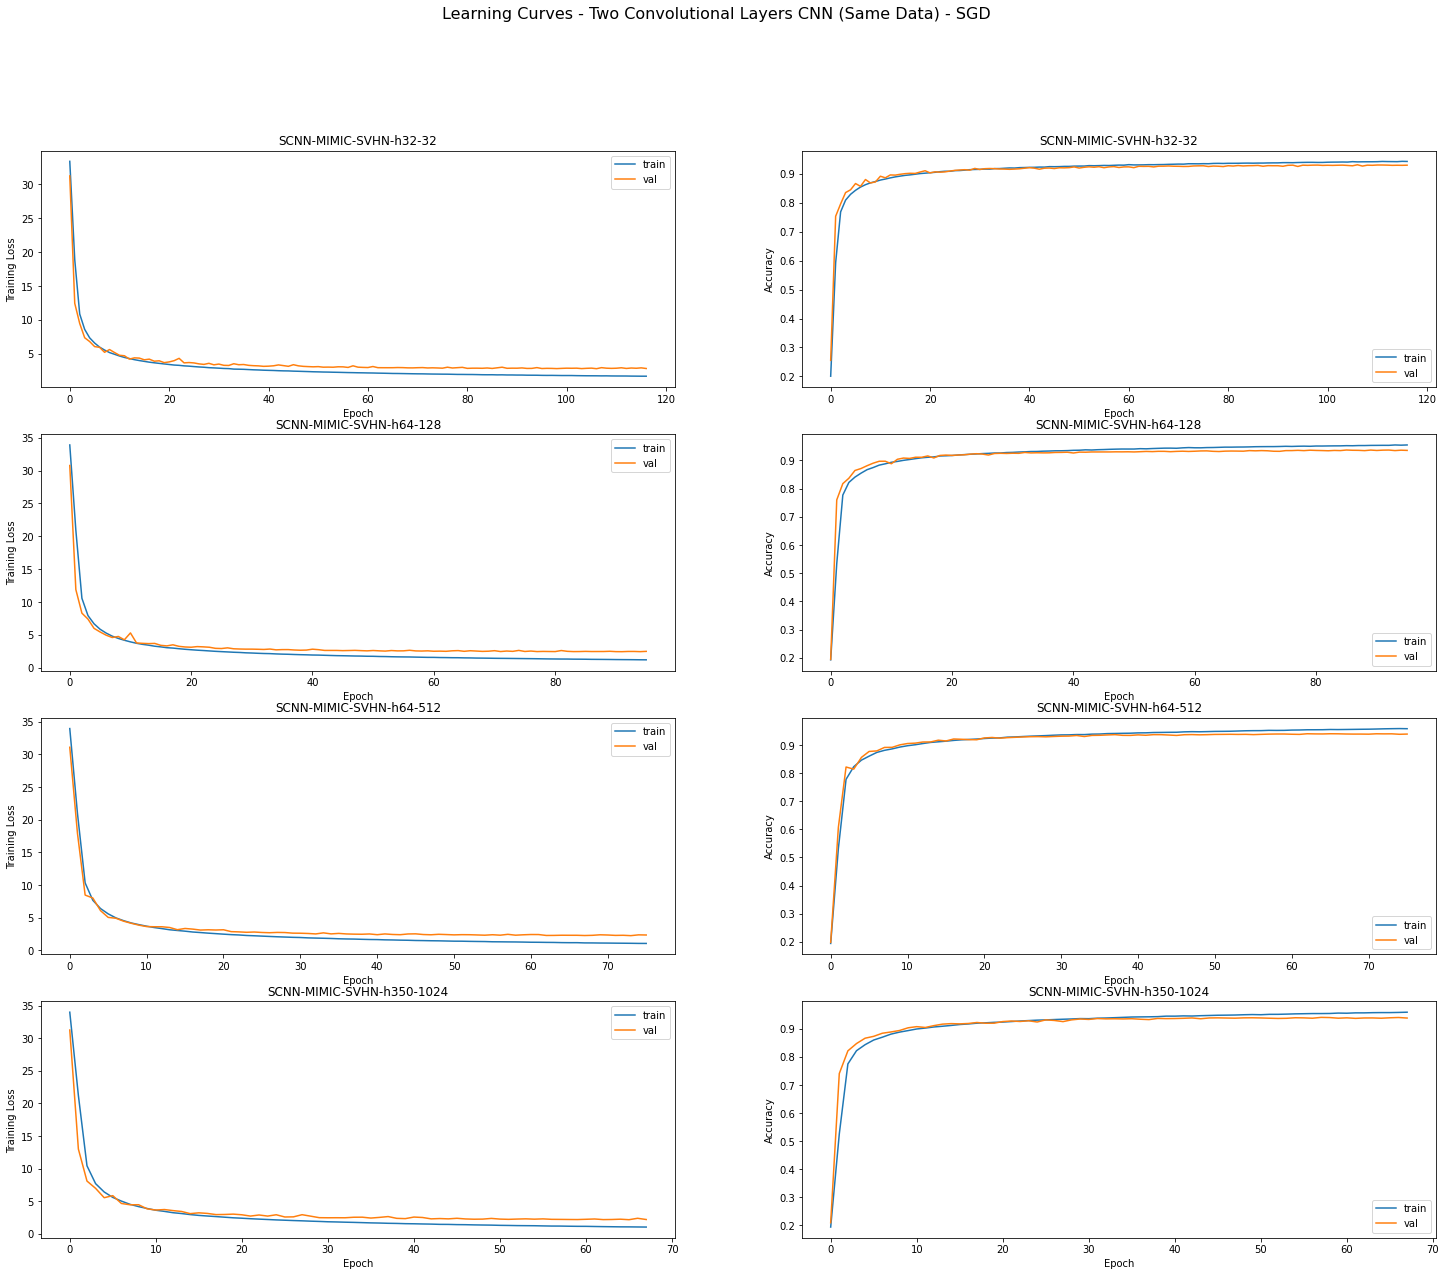

In [ ]:
fig = plt.figure()
fig.suptitle('Learning Curves - Two Convolutional Layers CNN (Same Data) - SGD', fontsize=16)
fig.set_size_inches(25, 20)

plt.subplot(4, 2, 1)
plt.plot(loss_train_32_32, label='train');
plt.plot(loss_test_32_32, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h32-32')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 2)
plt.plot(acc_train_32_32, label='train');
plt.plot(acc_test_32_32, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h32-32')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 3)
plt.plot(loss_train_64_128, label='train');
plt.plot(loss_test_64_128, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-128')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 4)
plt.plot(acc_train_64_128, label='train');
plt.plot(acc_test_64_128, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-128')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 5)
plt.plot(loss_train_64_512, label='train');
plt.plot(loss_test_64_512, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-512')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 6)
plt.plot(acc_train_64_512, label='train');
plt.plot(acc_test_64_512, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-512')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 7)
plt.plot(loss_train_350_1024, label='train');
plt.plot(loss_test_350_1024, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h350-1024')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 8)
plt.plot(acc_train_350_1024, label='train');
plt.plot(acc_test_350_1024, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h350-1024')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

##### Learning Curves for Extra Data - Adam

In [ ]:
loss_train_32_32 =[9.142107123447714, 3.8335116452104034, 3.1168758756859036, 2.7741554253897633, 2.566862860910661, 2.417867912093497, 2.303134514751179, 2.220681324250759, 2.1609739639052825, 2.111134790205748, 2.0752757895550125, 2.0442422804344873, 2.016258041467197, 1.9936975400938437, 1.9747656291042848, 1.9600960593275374, 1.9414731699896122, 1.9286436146322323, 1.9148453041001283, 1.9048862039202332, 1.8914842625499062, 1.881740469095198, 1.8751490622870526, 1.8674205367194776, 1.857090077171633, 1.8534367600299435, 1.8412942711577487, 1.838941232366226, 1.8306864100915847, 1.8255533199000749, 1.8188804650309844, 1.8156424275658916, 1.8097534082076518, 1.8046616282152532, 1.8016609985876475, 1.797517588635815, 1.795600240564938, 1.7896587861815787]
loss_test_32_32 =[4.518008193983912, 3.3790319335860506, 2.896956652601229, 2.646918185416398, 2.616074105311981, 2.402593149217249, 2.3252663351855265, 2.238533341508784, 2.1948496192783207, 2.142891995467618, 2.1627278901100815, 2.1353126532639117, 2.0832582250281932, 2.084923062616793, 2.103635831198234, 2.063646626420627, 2.0472397909052478, 2.0394670365641754, 2.0489167101012185, 2.0120883988361373, 2.02868411211885, 2.084503623334915, 2.045289832455096, 1.9987681166445888, 1.9873108366757668, 1.983545947479111, 1.9686252350348294, 1.9882278121856418, 1.9827115934031818, 1.9704001699542597, 1.9985805560160685, 1.9982244752253695, 1.9523478351002537, 1.9662775205082517, 1.948403755206554, 1.9726938915258072, 1.9940889295981838, 1.9520403715627064]
acc_train_32_32 =[0.8441672, 0.93752235, 0.9480965, 0.95338005, 0.9563313, 0.9585012, 0.9600286, 0.9613254, 0.96218675, 0.96317995, 0.96345764, 0.96421075, 0.9644202, 0.9646179, 0.96487445, 0.96519685, 0.9652133, 0.9655499, 0.9656087, 0.9657899, 0.9661994, 0.96637356, 0.9664442, 0.96650773, 0.96661836, 0.96669835, 0.96702784, 0.96680194, 0.96664894, 0.9669125, 0.9669666, 0.9670396, 0.9670608, 0.9672891, 0.96735024, 0.9674444, 0.9672491, 0.9675291]
acc_test_32_32 =[0.9263840913772583, 0.9422839879989624, 0.9510576128959656, 0.9538723826408386, 0.9559434056282043, 0.958174467086792, 0.95980304479599, 0.9612810015678406, 0.9616010785102844, 0.9626083970069885, 0.9625330567359924, 0.9629566669464111, 0.9638133645057678, 0.9644817113876343, 0.9630602598190308, 0.964208722114563, 0.9640204310417175, 0.9643216729164124, 0.9648677110671997, 0.964227557182312, 0.9645476341247559, 0.9634367823600769, 0.9645476341247559, 0.9642369747161865, 0.9647923707962036, 0.9653195738792419, 0.9652913212776184, 0.9657337665557861, 0.965178370475769, 0.9641522169113159, 0.9648771286010742, 0.964246392250061, 0.9654796123504639, 0.964029848575592, 0.9646511673927307, 0.9648112058639526, 0.9639451503753662, 0.9648677110671997]

loss_train_64_128 =[7.076371817027425, 2.8271768954482828, 2.2801402149455767, 2.0285973824282753, 1.8820504612118527, 1.782266298219857, 1.7124053707497715, 1.6604109715183653, 1.615260313855543, 1.580036939325028, 1.5499768706681312, 1.5240033736480412, 1.5012778788656314, 1.4811016701279274, 1.4651413370785347, 1.4490757117760622, 1.4354541417495847, 1.42091777474022, 1.4105969127510631, 1.3985291859198332, 1.389945392398742, 1.3792799563834612, 1.3718985421417003, 1.3645533164852481, 1.3547773145110742, 1.3492401747088305, 1.3433542301570738, 1.3365968654226341, 1.3318507531257848, 1.326436552551078, 1.318655165015272, 1.3157868010223035]
loss_test_64_128 =[3.370589165854232, 2.46514507158883, 2.2188785079934434, 2.0240690733724405, 1.9859620943841272, 1.8468677474952209, 1.8082158425244652, 1.7564126735140855, 1.723860211752671, 1.7196551996291571, 1.6802439609139912, 1.7037939001018716, 1.6688895262299812, 1.6663579738820056, 1.6535097732400033, 1.6496985201517957, 1.6657043575866843, 1.6401856016017229, 1.6275840018980552, 1.638968062050463, 1.6097693520820793, 1.6190476913783964, 1.6179745624735742, 1.591445033667444, 1.592177427882145, 1.5961236897164608, 1.6095263982295644, 1.597820416499815, 1.6046646796476558, 1.597826838285738, 1.59743063656257, 1.5939778792050916]
acc_train_64_128 = [0.87793475, 0.95235866, 0.96042633, 0.9643096, 0.96626765, 0.96746796, 0.96848935, 0.9691907, 0.97004026, 0.9700756, 0.97059333, 0.9710523, 0.97127116, 0.97150886, 0.9715818, 0.971763, 0.97188073, 0.9721937, 0.9721843, 0.9724597, 0.972575, 0.9725656, 0.9726856, 0.9727939, 0.97314453, 0.972808, 0.9731163, 0.9732763, 0.97314686, 0.97325045, 0.9733257, 0.97327864]
acc_test_64_128 =[0.943583071231842, 0.9558963179588318, 0.9602078795433044, 0.9633520841598511, 0.9638603925704956, 0.9662420749664307, 0.9670140147209167, 0.9678518772125244, 0.9680024981498718, 0.9683225750923157, 0.9688308835029602, 0.969113290309906, 0.9688968062400818, 0.969113290309906, 0.9692357182502747, 0.9694710373878479, 0.968435525894165, 0.9697911143302917, 0.9690191745758057, 0.9698287844657898, 0.9698852300643921, 0.9702147245407104, 0.9689438939094543, 0.9701300263404846, 0.9699888229370117, 0.9698758125305176, 0.9701206088066101, 0.9699794054031372, 0.9696969985961914, 0.9702053070068359, 0.9694992899894714, 0.9697346091270447]

loss_train_64_512 =[5.962161001604201, 2.3124057146609296, 1.867648094832463, 1.6623763171954014, 1.5372848363753382, 1.4482478165719446, 1.3820481702424159, 1.3318122090701339, 1.2868560700393852, 1.254264201167711, 1.2217753761298973, 1.1941250238839098, 1.1710420262978984, 1.1500479596018434, 1.132371532053584, 1.1137187992099216, 1.0986405360804863, 1.0855379192798562, 1.0720427820988803, 1.060002610126953, 1.0475970292211223, 1.038163088968661, 1.0268132657728963, 1.017689646438409, 1.010074816679682, 1.0008158058990269, 0.9937430597861239, 0.9849081589060004, 0.9786654594888878, 0.9715527773504954]
loss_test_64_512 =[2.7328372943565964, 2.038587671629481, 1.8044952564092627, 1.7070946463153585, 1.697461711270377, 1.576347873373336, 1.54637486460729, 1.502830492288338, 1.476345985711232, 1.4800626779177846, 1.4735388009683998, 1.4767455576254556, 1.4500989120917596, 1.444711019925114, 1.4760549218277548, 1.4568521026248558, 1.4129870606937502, 1.4285508026166787, 1.4243978610529344, 1.4295406363076775, 1.4685237223910772, 1.4396700872962818, 1.4172221369283104, 1.4129873954756125, 1.4331533715318412, 1.449365200980643, 1.450777542371478, 1.4405018706870119, 1.4255916522838354, 1.4643208127577645]
acc_train_64_512 =[0.89842176, 0.9595697, 0.9661994, 0.9691742, 0.9709087, 0.97168064, 0.9725562, 0.9730951, 0.9737329, 0.97412825, 0.97451895, 0.9748202, 0.97507435, 0.97535914, 0.9754792, 0.9757192, 0.9756204, 0.9758934, 0.9762793, 0.97617346, 0.9763429, 0.9766018, 0.97671944, 0.9765641, 0.97686064, 0.97675943, 0.97686774, 0.97701836, 0.9771807, 0.9773502]
acc_test_64_512 =[0.9527803659439087, 0.963276743888855, 0.966769278049469, 0.967701256275177, 0.9682095646858215, 0.9699888229370117, 0.9698946475982666, 0.9712314009666443, 0.9715138077735901, 0.9708266258239746, 0.9715985655784607, 0.971852719783783, 0.9710431694984436, 0.9717962741851807, 0.9708737134933472, 0.9714573621749878, 0.971871554851532, 0.9713349938392639, 0.9717020988464355, 0.9721727967262268, 0.9712502360343933, 0.9710996150970459, 0.9717020988464355, 0.9716832637786865, 0.9718433022499084, 0.9714856147766113, 0.9719186425209045, 0.9712125658988953, 0.97190922498703, 0.9717115163803101]

loss_train_350_1024 =[5.372854131891236, 2.1108527609573557, 1.7590579557523864, 1.5780565399182993, 1.4598165907704577, 1.3802542593856537, 1.3181411704721182, 1.2670341936247769, 1.2219007345431248, 1.1875371260996102, 1.153324719919688, 1.1293710616672166, 1.1054735530527702, 1.0826623523484231, 1.064287320162916, 1.0473004046196235, 1.0298419610868614, 1.0156150088764877, 1.0011248274047717, 0.9884661473720301, 0.9763620015787643, 0.965112730239279, 0.9571252093657537, 0.9455778434851024, 0.9368380474128067, 0.9289239541389398, 0.9205014850649206, 0.9139433532665412]
loss_test_350_1024 =[2.4536436045080166, 1.9203207827674198, 1.7208710167948829, 1.6643697024199717, 1.5533648858614466, 1.5601005636333967, 1.4776513286280917, 1.517567642082267, 1.4698588127126013, 1.4225627759362418, 1.435212856897714, 1.4523629464417882, 1.4006464588670962, 1.4592383498398205, 1.424238367478266, 1.4195926117118443, 1.4351885002269675, 1.4182163800601337, 1.3966582170921134, 1.3928313670315542, 1.3930012915060297, 1.4166493372436555, 1.4226229029048232, 1.4025656574825762, 1.3983133373813794, 1.4050473013661893, 1.4195019700413691, 1.4298971908415943]
acc_train_350_1024 =[0.90716493, 0.9628175, 0.96820456, 0.97028977, 0.97153, 0.9726503, 0.9736034, 0.97406, 0.9743636, 0.97526264, 0.97523206, 0.9755757, 0.9759687, 0.9759687, 0.97616166, 0.9767571, 0.97677594, 0.9768889, 0.97696424, 0.9771619, 0.97733843, 0.97739726, 0.9775314, 0.97775024, 0.97781384, 0.97810566, 0.97817624, 0.9781433]
acc_test_350_1024 =[0.9575625658035278, 0.9644817113876343, 0.9673623442649841, 0.9683414101600647, 0.9693580865859985, 0.9711467027664185, 0.9708360433578491, 0.9703182578086853, 0.9711184501647949, 0.9718244671821594, 0.9720504283905029, 0.9714479446411133, 0.9723705053329468, 0.970958411693573, 0.9722763299942017, 0.9720410108566284, 0.9718244671821594, 0.9724646210670471, 0.9719562530517578, 0.9720410108566284, 0.9715514779090881, 0.9715138077735901, 0.9720786809921265, 0.9718998074531555, 0.97190922498703, 0.9720504283905029, 0.9717209339141846, 0.9720975160598755]


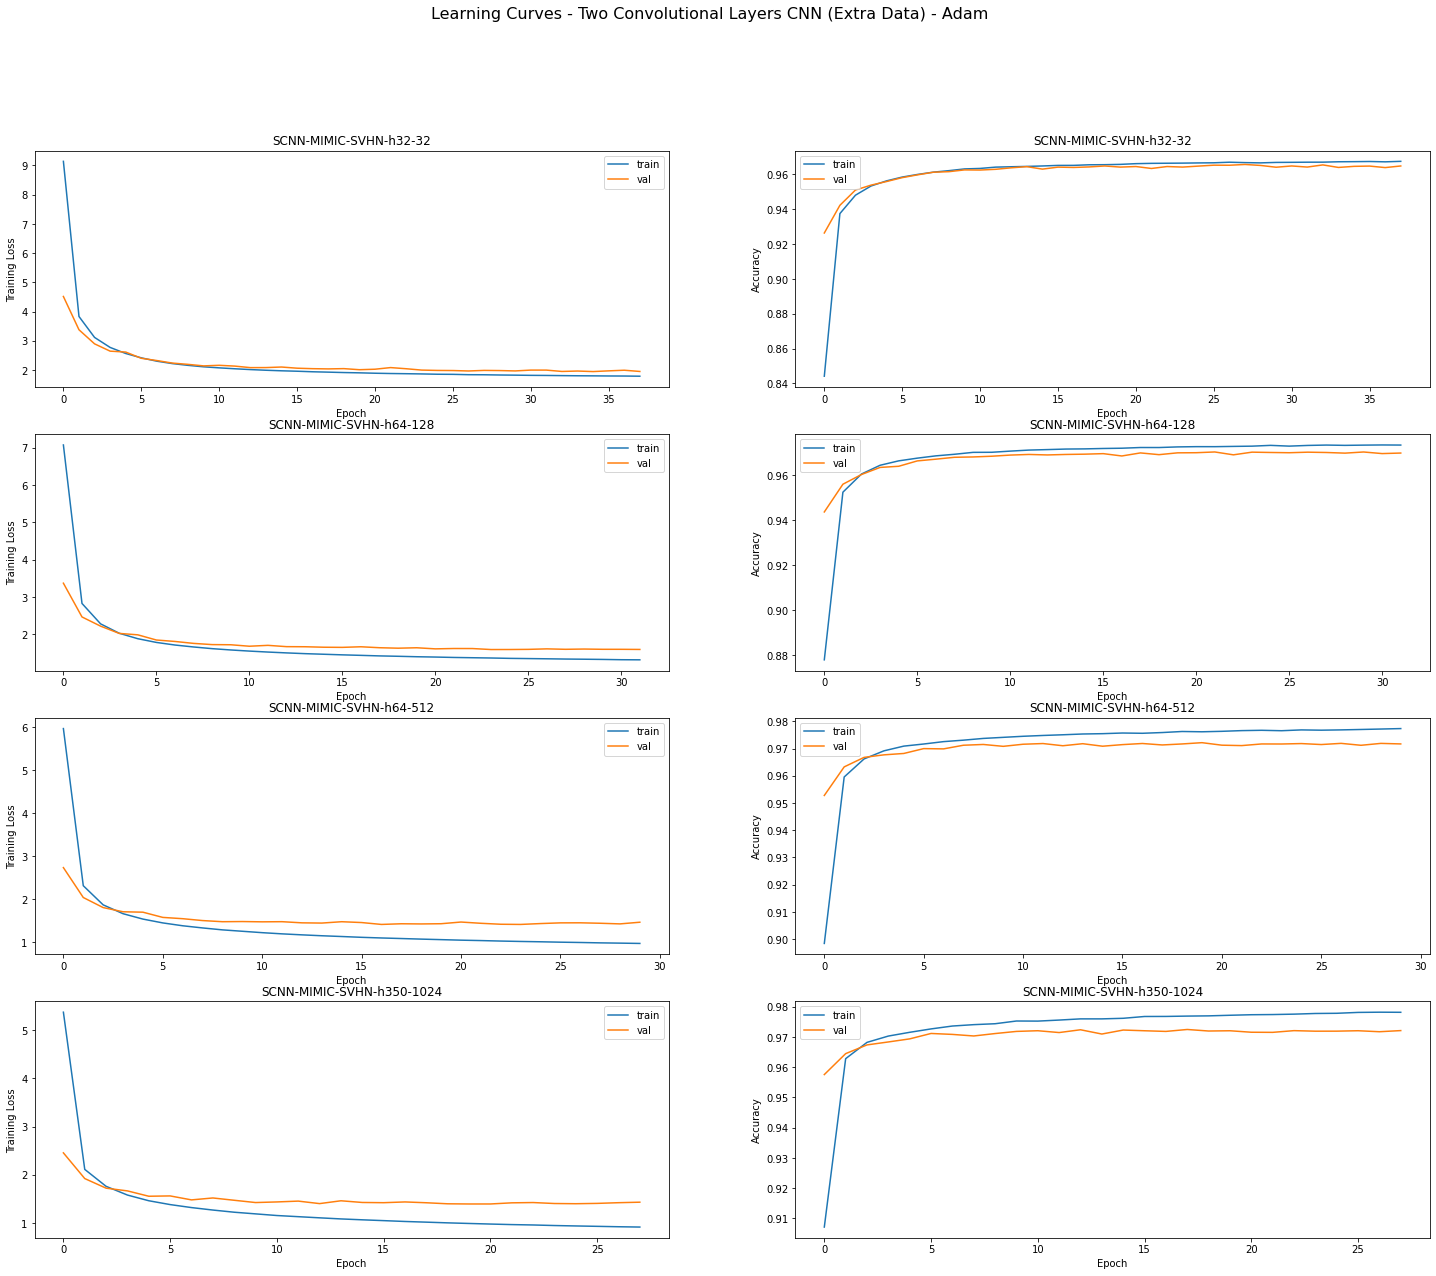

In [ ]:
fig = plt.figure()
fig.suptitle('Learning Curves - Two Convolutional Layers CNN (Extra Data) - Adam', fontsize=16)
fig.set_size_inches(25, 20)

plt.subplot(4, 2, 1)
plt.plot(loss_train_32_32, label='train');
plt.plot(loss_test_32_32, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h32-32')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 2)
plt.plot(acc_train_32_32, label='train');
plt.plot(acc_test_32_32, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h32-32')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 3)
plt.plot(loss_train_64_128, label='train');
plt.plot(loss_test_64_128, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-128')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 4)
plt.plot(acc_train_64_128, label='train');
plt.plot(acc_test_64_128, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-128')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 5)
plt.plot(loss_train_64_512, label='train');
plt.plot(loss_test_64_512, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-512')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 6)
plt.plot(acc_train_64_512, label='train');
plt.plot(acc_test_64_512, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-512')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 7)
plt.plot(loss_train_350_1024, label='train');
plt.plot(loss_test_350_1024, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h350-1024')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 8)
plt.plot(acc_train_350_1024, label='train');
plt.plot(acc_test_350_1024, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h350-1024')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

##### Learning Curves for Extra Data - SGD

In [ ]:
# Curves for Extra Data
loss_train_32_32 = [12.465173800228218, 4.861571797137183, 3.863957956761827, 3.372888623086909, 3.076901814211872, 2.8691518915695418, 2.7181161996405363, 2.6009908773547465, 2.5042096850648177, 2.4233951284815696, 2.3554753624178444, 2.2990142636856383, 2.2475739248102413, 2.204507625031399, 2.164600199433713, 2.1274327920596563, 2.0978145482698904, 2.066923546480894, 2.0396614700593396, 2.016443843140208, 1.9941368862548057, 1.9727779846510298, 1.9519474234575698, 1.9342985695299417, 1.9173240763698522, 1.900751814592103, 1.8871395845830496, 1.8735858168964783, 1.8606493048313915, 1.846460208395812, 1.8344353413071461, 1.8229255579017662, 1.8101054267352894, 1.8012491893281715, 1.7906020551854287, 1.7809216410587685, 1.7723561886678298, 1.7620470345580284, 1.75339563915753, 1.745357729900115, 1.7354606126164698, 1.728201774475483, 1.721824646238494, 1.7136230107910329, 1.7067632180943768, 1.7007319649757093, 1.6938324683876929, 1.688404062488578, 1.6821552417216927, 1.6759081685729125, 1.6696402166104893, 1.6648810040941124, 1.6600328436582472, 1.654099493728976, 1.6499277014442648, 1.6442063302129932, 1.639397866131637, 1.635151736495648, 1.6308728499882343, 1.6266001427159924, 1.620790928573602, 1.6194435906410667, 1.6134924647332836, 1.6097635789638727, 1.6060519600270071, 1.6028010466568638, 1.5972087758743727, 1.5961254587005218, 1.5906322418800611, 1.5877857862126565, 1.585859534718587, 1.580641126829304, 1.5774785034528098, 1.5751175855384105, 1.5707535501111152, 1.5691194055022641, 1.5664119222102073, 1.563623232476365, 1.5600271819574365, 1.5566535951381388, 1.5539647411317492, 1.5518569559122033, 1.5490143475134726, 1.5465268608747778, 1.5435851337168447, 1.540190671421396, 1.5388705098963196, 1.5367256480761877, 1.534037650088245, 1.531797843059513, 1.528771263466354, 1.5264792582195685, 1.5248814550899699, 1.522793411604801, 1.5203981875987247, 1.5179845082583219, 1.5154138546986704, 1.51392887697257, 1.5120608731398704, 1.5088886926855263, 1.5074094552549195, 1.5051360097406472, 1.5032931494663002, 1.5016827662968397, 1.4997179414548474, 1.49860861887088, 1.496310227347707, 1.4950086254182322, 1.493271821808326, 1.4908454700331748, 1.489246339246109, 1.4867479407098054, 1.4856740272417939, 1.4847710721406984, 1.4836278202156072, 1.4812609829370356, 1.481010404020599, 1.4783165005436525, 1.476578625847942]
loss_test_32_32 = [6.2019116324158885, 4.248277887302901, 3.504765248648102, 3.266258080856485, 3.107000984050693, 3.2949083506669914, 2.719285967154135, 2.7997385912115607, 2.841099556659031, 2.629971630577066, 2.424282831201102, 2.4606923687058195, 2.413687145509003, 2.29886914858314, 2.245421423784969, 2.3840652347812914, 2.2179593213317554, 2.220180516986918, 2.1441441896566027, 2.200029897668722, 2.1299573882254323, 2.1631207093214204, 2.0948635981092725, 2.112029637263087, 2.0766108480437495, 2.068532756657216, 2.025109136785879, 2.130673991953422, 2.030797310574492, 1.9927221438453961, 2.0160904869327663, 1.970464694078803, 1.9588862368902666, 1.953289762531674, 1.9712634354525949, 2.0539851018958664, 1.979007389629674, 1.980023241894177, 1.990265733422931, 1.9604425478440777, 1.9231748962484938, 1.93629153130642, 1.8913527071541631, 1.908516499130892, 1.9064443491849787, 1.8981586246943314, 1.925418398614979, 1.9156731613111455, 1.9106054427655688, 1.930846372474804, 1.8660878465473845, 1.8848139030565048, 1.905905639257692, 1.869863067804963, 1.8679683052522897, 1.8836986653181524, 1.8508647036278385, 1.8725385201679046, 1.9495887205251439, 1.8409826231562567, 1.8390561550780167, 1.8397801383107004, 1.833523402574101, 1.8344763742046746, 1.8643679996471247, 1.8369229809611938, 1.810050500789598, 1.8699550889262344, 1.9574255780195944, 1.8430915046559904, 1.8675412972022998, 1.817864583751425, 1.807048050767008, 1.808487014698372, 1.822325248671892, 1.7852033152722513, 1.797435627279054, 1.8055373094508476, 1.8332640193838676, 1.7966241487910029, 1.7987641437077, 1.833019539406233, 1.7976207610754558, 1.7890603953742283, 1.7877798644704108, 1.7831583579183798, 1.8214497736799475, 1.8638744251969581, 1.803198827688066, 1.8456118351955741, 1.8000506344969331, 1.8049403556469847, 1.799634646792343, 1.7580095007772252, 1.8316678428346456, 1.7826855165870625, 1.8224188319289667, 1.775512335397562, 1.7739152645076537, 1.7637626046575627, 1.7732382035997665, 1.8045538626909672, 1.7867599655697193, 1.8084965307816, 1.8121686201378737, 1.7662678489561436, 1.7627967689231399, 1.7718956831426775, 1.7573605001944024, 1.7670635325269874, 2.0114265855580293, 1.7650777319270878, 1.794908987762858, 1.807123933442684, 1.79183499268268, 1.7697146716712586, 1.8045160376508376, 1.77002466112894, 1.771155760547178]
acc_train_32_32 = [0.7829203773042679, 0.9236533428693764, 0.9376047295422743, 0.9447451659669007, 0.9490590815774139, 0.9517514544439364, 0.9540437369337371, 0.9557052887285301, 0.9572444599216987, 0.9583011692030349, 0.9595226215759152, 0.9603369231626984, 0.9608946962092441, 0.9615183665038542, 0.9623538493389641, 0.9627586466612544, 0.9632646433042982, 0.9634552746020822, 0.9638647788654527, 0.9641001261506301, 0.9643260595289587, 0.9645920019558449, 0.9648720652239267, 0.9650932916578085, 0.9651968444592017, 0.9656604785999809, 0.9656204695682566, 0.9659993786831849, 0.9661782426181691, 0.9663712273820043, 0.9663359252913599, 0.9664724267151019, 0.966632462859955, 0.9667901455353903, 0.9669713629431589, 0.9671596407614252, 0.9669737164148211, 0.9673267373302428, 0.9672749609301073, 0.9674679456973092, 0.9674302901327582, 0.9674655922323804, 0.9678492082906331, 0.9677927249404399, 0.9679292263641819, 0.967785664524331, 0.9679904166565773, 0.9682540056061902, 0.9681339784975505, 0.9683199028452768, 0.9685576035987498, 0.9684964133041098, 0.9683222563191834, 0.9684964133119655, 0.9684940598346921, 0.9686635098751718, 0.9687341140553384, 0.9688564946423737, 0.9688917967341403, 0.9688988571491269, 0.9688329599134071, 0.9688753224246492, 0.9690871349730045, 0.9692095155600399, 0.9690259446828534, 0.9692565850157286, 0.9692848266868975, 0.969251878071282, 0.9691577391576599, 0.9693836725449663, 0.9692401107062376, 0.969534294800926, 0.9693977933827951, 0.9693695517082596, 0.9694707510379905, 0.9696284337134258, 0.9695625364743393, 0.9696378476056858, 0.9697837629160767, 0.9696543219174214, 0.9695719503677215, 0.9696519684435146, 0.9697296330465235, 0.9699061435042343, 0.970009696303383, 0.9698520136358033, 0.9699320317037409, 0.970019110195643, 0.9700120497795341, 0.9698167115350589, 0.970047351872423, 0.9702403366385026, 0.9700967747986518, 0.9702073880217649, 0.9701932671895471, 0.9702262158040404, 0.9702968199920625, 0.9704027262606291, 0.9702309227473649, 0.9704003727889668, 0.9705203999009733, 0.970327415131527, 0.9703109408220358, 0.9703815450066913, 0.970395665843398, 0.9704945117003445, 0.9705086325359289, 0.970423907515689, 0.9705839436717644, 0.9704756839180689, 0.9706074783928754, 0.9705651158816332, 0.9706663152136087, 0.9704992186459134, 0.9708357652507217, 0.9706239527012442, 0.9705910040901177, 0.970743979814373, 0.9707675145444619]
acc_test_32_32 = [0.8983403466386529, 0.9292270326545476, 0.9397610777033343, 0.9447692206531727, 0.9486759486978318, 0.9516412964907658, 0.9531098496834569, 0.9523567454714159, 0.9547101961007286, 0.955849266205316, 0.9584757171182899, 0.9578638199546686, 0.9596900976430153, 0.9604243742393608, 0.9609515471803268, 0.9613845820961204, 0.9613092716221162, 0.9610268575465987, 0.9621753414969084, 0.9616010995433562, 0.9627025144485355, 0.9621471000893567, 0.9629378595114668, 0.9633426530197086, 0.9632014459819498, 0.9631355493104629, 0.9635309290700536, 0.9637568603198066, 0.9638321706967394, 0.9638039293430538, 0.9642369642049812, 0.9643969989016407, 0.9652724824818788, 0.9648394476199514, 0.9653854481120858, 0.965008896065262, 0.964415826452809, 0.965168930654189, 0.9646041025570201, 0.9652254135231587, 0.9648865166325377, 0.9654042757277813, 0.965423103376021, 0.9660538281446768, 0.9654889999829808, 0.965799655476711, 0.9659126210637128, 0.9658184830278793, 0.9655454828087452, 0.9654231033328158, 0.9663833111789144, 0.9664209664428496, 0.9663268283638109, 0.9660538280908105, 0.9664303802021617, 0.9659220348662301, 0.9661197247190924, 0.9659032073044008, 0.965649034636435, 0.9659408624606036, 0.9668163460947079, 0.9661950351824355, 0.9664774492579531, 0.967155242985329, 0.9667127942776792, 0.9667410356745699, 0.9667881047410224, 0.9661573799617055, 0.9664397939940179, 0.9669104841737466, 0.9664303802453669, 0.966929311735576, 0.9668634151072941, 0.9672211396029496, 0.9669387255380931, 0.9672587948668849, 0.9668540013586431, 0.9672023119979152, 0.9672964500230877, 0.9672776224180532, 0.9671928981953979, 0.9667692771253268, 0.9670234497932926, 0.9675035536784672, 0.9671458292260169, 0.9674376570933906, 0.9671458291828117, 0.9667222080801964, 0.9674094156964999, 0.9673529328920574, 0.9671928982492641, 0.9671646568310514, 0.9676353469243697, 0.9673905881021264, 0.9676071055493621, 0.9673246914631836, 0.9674941398866109, 0.9676635883212604, 0.9676824159695001, 0.9674753123141207, 0.967682415936956, 0.9672117258110935, 0.9672211396029496, 0.9677106573338468, 0.9673152776713274, 0.9672682086587411, 0.9680401404219505, 0.9679648300343566, 0.9681813475029144, 0.9678612782173279, 0.9667692771359878, 0.9676353469675749, 0.9675129675348506, 0.9675129674809845, 0.9678236229747147, 0.9677483125439157, 0.9671458292260169, 0.9678330368204372, 0.967371760497092]

loss_train_64_128 = [12.236617381146324, 4.288968540446835, 3.3507480540672483, 2.898856568277682, 2.61871824724997, 2.4236681028515155, 2.282524547972286, 2.1728560331906364, 2.0809067411607494, 2.0060455729973827, 1.9440034096317265, 1.8873943864032234, 1.8382762976996143, 1.794321183755402, 1.7530675321733793, 1.7179992895799856, 1.6867669897455817, 1.6550900440867133, 1.629137543381532, 1.6014247902447918, 1.5779727813679656, 1.5569037875092575, 1.5353214470028032, 1.515484685073038, 1.4964389446200836, 1.4789924265590364, 1.4613196277264684, 1.4461509181817842, 1.4308572616264363, 1.4155133168635814, 1.4025655290401888, 1.3888340128199126, 1.375982073271656, 1.3638015195017261, 1.3516690786059968, 1.3395771391297981, 1.3291771451600012, 1.319874366154397, 1.3090263070872186, 1.2984732051391534, 1.2897808957270043, 1.280124697194516, 1.2723453953488209, 1.2618655390936324, 1.2546424516778552, 1.2455072286399993, 1.237637039010886, 1.2301684360064418, 1.2227830434046174, 1.2153292544297074, 1.2082856572650906, 1.2008687010653158, 1.1948231317465807, 1.1883589042038145, 1.1819642150377156, 1.1756045705724973, 1.1696403907907638, 1.1628530627263187, 1.1567412215378234, 1.151323811590841, 1.1460060284537372, 1.1399386291540894, 1.1347633870107239, 1.1280515717613477, 1.1239342619487427, 1.1198792527876633, 1.113835086307499, 1.1094371365443272, 1.1042817185559046, 1.099458304209353, 1.0949086634532303, 1.0906200930612258, 1.0868031956476936, 1.0813384805220234, 1.0777425378307959, 1.0730037982445926, 1.069535425372644, 1.0655181641238685, 1.0613461528821744, 1.0565956126693512, 1.0534026544396142, 1.0492630285707965, 1.0454661756517694, 1.0425900970942563, 1.0381805128922648, 1.035408431408628, 1.0315569873795485, 1.0279262726181182, 1.0245787456614546, 1.0212274999015043, 1.0183913088625018, 1.014622783152746, 1.01147696400143, 1.0086055991564922, 1.0045494941062296, 1.0022479273375904, 0.9989271123226169, 0.9966827122191894, 0.9929488849876008, 0.9903954093736779, 0.9875653452540424, 0.9847257436864865, 0.9814933560163133, 0.9790918375564017, 0.9758404478799118, 0.9740005359992071, 0.970955897535249, 0.9679046839673704, 0.9661768917362914, 0.9632753624522041, 0.9607498787956937, 0.9579362040298807]
loss_test_64_128 = [5.368137766210272, 4.549089411535934, 3.3975924755104048, 2.7989199848997046, 2.5860892347508564, 2.6652144247167615, 2.3649856631627246, 2.2311989073485057, 2.167142900354985, 2.129752429870424, 2.1634034122612227, 2.0119091827209754, 2.0487934176384774, 1.9080036171356143, 1.8815418379267763, 1.9169139768625116, 1.8991497841034597, 1.869836781940591, 1.8144469483614436, 1.7779896648322897, 1.746557185906118, 1.7298439107207906, 1.7341102406421698, 1.7251999906845088, 1.6953173345204102, 1.6792628952998274, 1.6454155053996526, 1.7068944903102887, 1.6274518318922406, 1.6596014935913275, 1.7479358708809, 1.6408859928932669, 1.6712970491311965, 1.620861338259694, 1.591451328804929, 1.597607214993067, 1.6059847860504097, 1.5852302211077482, 1.555904188646939, 1.6128950783087925, 1.5665763670888206, 1.559950154290939, 1.5895693687847827, 1.5524336142683937, 1.5417188063076064, 1.5472377675568536, 1.526377201595418, 1.5310289337112382, 1.5996920513426913, 1.537953600608811, 1.5403057285858794, 1.5359374866981883, 1.5277987613082937, 1.4970971107678175, 1.4964634380844046, 1.5827410676504994, 1.4859204536154185, 1.499701190151024, 1.515332238966186, 1.5022214769490008, 1.4785171819433252, 1.472806469273291, 1.4700882845911487, 1.4814580217710396, 1.4893389523595484, 1.4707807805360935, 1.4876737635565256, 1.502770531952633, 1.466324997962498, 1.4767692063875912, 1.450068329919071, 1.4865593056684743, 1.4814222893557392, 1.4758686031576518, 1.4456659045961833, 1.4698297996323129, 1.4509447431751068, 1.4414671641054093, 1.4802795467763916, 1.4496164729834957, 1.4426332409007698, 1.4442710437163457, 1.4516726080764661, 1.4337483483795836, 1.4349031700020458, 1.4628930228229198, 1.4454445370022864, 1.4747134835809816, 1.4511201505497078, 1.4880321779907997, 1.433811648495502, 1.4636430875661632, 1.4268981344014615, 1.482731408116616, 1.420674658117246, 1.4319550592482062, 1.4855799736350384, 1.44096867492019, 1.42645801933907, 1.4252530683861948, 1.4561844401496602, 1.4201850152674873, 1.4342455400086014, 1.477572942885021, 1.4406782767849142, 1.4285943207238077, 1.432601033038185, 1.4191780588774028, 1.425967891142414, 1.4264407832695674, 1.4178364075179475, 1.4727048606365858]
acc_train_64_128 = [0.785007907665189, 0.9315868996246038, 0.9455006307262174, 0.9516220134385477, 0.955540545626886, 0.9579928642671509, 0.9598827029130568, 0.961563082483392, 0.962655093853128, 0.9634835162811066, 0.9645614068096472, 0.965229793083795, 0.9657734452947564, 0.9664394780905087, 0.9669290004319168, 0.9673220303835517, 0.9678703895423264, 0.9682304708828348, 0.9686540959874007, 0.968804718241116, 0.9693954399088884, 0.9694542767307439, 0.9697814094432923, 0.9699814546333364, 0.9703886054228001, 0.9704097866778602, 0.9706663152124864, 0.9707934027450906, 0.9710428708591191, 0.9710993542048235, 0.9712711577192099, 0.9715512209794361, 0.9717159640765914, 0.9718854141170712, 0.9721042870837797, 0.9721207613932707, 0.9724008246568636, 0.9723961177090503, 0.9725326191305479, 0.972866812268183, 0.972746785153932, 0.9727938546084987, 0.9730880387076759, 0.9732692561120778, 0.9732292470758646, 0.9733492741867489, 0.97331161862332, 0.9735775610468396, 0.9735963888302374, 0.9738435034737258, 0.9738176152719747, 0.9739164611266768, 0.9739352889089523, 0.9740953250594165, 0.9740741438066011, 0.9740764972782633, 0.9743777417946716, 0.9744271647242672, 0.9744977689044336, 0.9745165966934426, 0.9746154425447779, 0.9745730800357802, 0.9746248564359157, 0.9747684182780111, 0.9747919530058554, 0.9748672641327131, 0.9749731704091351, 0.9750014120825484, 0.9750837836288816, 0.9751732155969348, 0.9751920433780882, 0.9752085176853348, 0.9753897350908589, 0.9755050552584188, 0.9754768135838833, 0.9753944420364278, 0.9755285899851409, 0.975601547643703, 0.9757333421185095, 0.9757568768441095, 0.9757686442113983, 0.9757192212818029, 0.9757568768441095, 0.9758863178472537, 0.9758463088121626, 0.9759639824513847, 0.9759992845420291, 0.9759804567608757, 0.9761946227842598, 0.9761098977628978, 0.9761098977606534, 0.9761169581823733, 0.9762840547478242, 0.9761263720723888, 0.9763381846229885, 0.9763052360028841, 0.9762346318215954, 0.9764558582599662, 0.976521755500175, 0.9766488430327792, 0.9765429367563571, 0.9766229548299059, 0.9766253083038126, 0.9766370756654903, 0.9767853444531545, 0.9767429819430345, 0.9767053263784835, 0.9769124319823921, 0.9767100333206857, 0.9768112326504167, 0.9769241993474365, 0.9768888972545476]
acc_test_64_128 = [0.9176198141726605, 0.9373605580294523, 0.9457388422911275, 0.9518389863436281, 0.9559716456060571, 0.9554633003021086, 0.9593794421492849, 0.9604620294494298, 0.9609892023690738, 0.9615916857514999, 0.9617611341861494, 0.9631167217486335, 0.9631920321687715, 0.9649900684495665, 0.965310137735153, 0.9652724825357449, 0.9654889999829808, 0.9655643104137798, 0.9659973453189122, 0.966515104468022, 0.9670893464109134, 0.9671646568203903, 0.9675976917036397, 0.9676353469675749, 0.9678801058330234, 0.9682095889104662, 0.9680401404758167, 0.9678895195816745, 0.9684072787633284, 0.9682378303180179, 0.9686332100237425, 0.9679271748456098, 0.9683790373232325, 0.9688403136897831, 0.9690097620812274, 0.9693486589825093, 0.9689532792767849, 0.9690850725120264, 0.9694145555894691, 0.968736761829549, 0.9696028316398141, 0.9699040733742323, 0.9691792105371989, 0.9696593144549176, 0.9699040733203661, 0.9700452803687859, 0.9700358665556077, 0.9700170389505731, 0.9698758319128143, 0.9697440386775729, 0.9699229009254007, 0.9701017632270946, 0.9701017631732284, 0.97023355640847, 0.9702523840135044, 0.9693110037724404, 0.9702712116185389, 0.9706760051267808, 0.9704783152739185, 0.9703182806417862, 0.970421832469476, 0.9707324879418843, 0.9707324879525453, 0.970308866839269, 0.9702147288247575, 0.97064776372989, 0.9702806254210562, 0.9706854189292979, 0.9705818671016082, 0.9708172121645395, 0.9705065566814702, 0.9705912809147865, 0.9706289361248555, 0.9706383499273727, 0.9709019363978557, 0.9705912809147865, 0.9705065567027923, 0.9708172121858615, 0.9707324879525453, 0.9706948327424763, 0.9712220056941033, 0.9710807986456835, 0.9709395916185858, 0.971212591880925, 0.9712502470909941, 0.9706571775324072, 0.9710431434249535, 0.9713443851268275, 0.970949005410442, 0.9708172121645395, 0.9710525572487928, 0.970873695000965, 0.9714102817444483, 0.9708548673959305, 0.9710337296437583, 0.9711937642865516, 0.9709960744230283, 0.9706948327318152, 0.9712314194859595, 0.9710525572487928, 0.9711184538664136, 0.9714950059564426, 0.971174936681517, 0.9712690746853675, 0.970798384580827, 0.9711278676689308, 0.9712784885092068, 0.9712973161142413, 0.9712031780890688, 0.9709584192236203, 0.9714761783620691, 0.9713537989293448]

loss_train_64_512 = [11.88753069337036, 4.122130868390601, 3.183946751094714, 2.727421245153354, 2.441979889774256, 2.2429536123913, 2.093468528604309, 1.9777708118049373, 1.8790203946061355, 1.8003089648285315, 1.73144905371633, 1.6699900790958384, 1.6148899798674883, 1.5702321605048721, 1.5250801019011584, 1.48787931861263, 1.4545110752529895, 1.421939310115743, 1.3912132820811849, 1.3633100449496875, 1.3367941869128246, 1.3120402313258672, 1.2906127260564118, 1.26693874369177, 1.2461527611076189, 1.2269646171691886, 1.207565037596801, 1.1902262235835614, 1.1729307432614415, 1.157850890724938, 1.1415336369175337, 1.1254875207125536, 1.1110441806551459, 1.0970876784486516, 1.0834876120762695, 1.0705717396723127, 1.0589159645567037, 1.0466627729225673, 1.035114853773497, 1.0234010253756896, 1.0115591541437374, 1.0009123382320932, 0.9910655229637898, 0.9801997703554993, 0.9715367305811385, 0.9609392357820163, 0.951975392871761, 0.9414407291250394, 0.9323397126915229, 0.9237944486259577, 0.9163269673207096, 0.9073435281375359, 0.8995916849934424, 0.8913042060316149, 0.8839960890421567, 0.8758044940163541, 0.8692177932346767, 0.8611338955794533, 0.8543842973090178, 0.8471008929643751, 0.8399752997807548, 0.8328602601217187, 0.8268667994126305, 0.8199958641801603, 0.8141733024308551, 0.8081484127199096, 0.8022504177121875, 0.7955702384576296, 0.7894466362300626, 0.7832581822210005, 0.777884086969264, 0.7724236077752211, 0.7671732748075266, 0.7615148384376751, 0.756487133413721, 0.7512314146653545, 0.7465424692379614, 0.7407184655675374, 0.7350671805823357, 0.7307285638870289, 0.7255680141892836, 0.721374263218117, 0.7165197843251832, 0.7110788041914674, 0.7078277786517411, 0.7023009599829637, 0.6982794998572515, 0.6945189791299569, 0.6894576125744855, 0.6855540692187899, 0.6812826803972951, 0.6776387811463471, 0.6736007183669568]
loss_test_64_512 = [5.146351401017434, 3.6814007021261825, 2.93367578814369, 2.8117705762396983, 2.6189409451834496, 2.269036409371821, 2.2284954763396296, 2.0376275653890823, 1.9800119790689104, 1.9113201293255646, 1.8807649265146813, 1.8318579557395875, 1.862804581530567, 1.7437504314185166, 1.723897348169415, 1.6782186773281265, 1.6322863398380494, 1.6238330052110763, 1.6235058546746346, 1.6059891294288162, 1.5919562544377803, 1.571464127855589, 1.5240994374509444, 1.524622496336549, 1.6625240549474751, 1.5121172946822308, 1.5217359842244054, 1.4939131684920366, 1.482219107304079, 1.542597117622598, 1.4691599094504222, 1.4482063267821204, 1.4661420470807933, 1.4219460708329406, 1.4431781058281072, 1.491900999450865, 1.4034710330039868, 1.432625166435735, 1.4349414472849198, 1.3969999005715588, 1.4343635416828104, 1.4668931904690825, 1.3961561100255377, 1.3896069059517657, 1.3979882886763997, 1.376364896707444, 1.383122567948605, 1.3630445623992151, 1.3678662233515517, 1.459602148116504, 1.3745647903538067, 1.3748109122397352, 1.3838164008068734, 1.384414346393152, 1.359103957503383, 1.4242755602873212, 1.3409968510594017, 1.3377247826191458, 1.3329257517897348, 1.36809289054335, 1.3287867845371184, 1.3452406999640136, 1.328640283745942, 1.3454949299074719, 1.3452452962712098, 1.3754921869171945, 1.3271807837046583, 1.3543040647068783, 1.3755877783020924, 1.3601235521127315, 1.348964633420899, 1.3769643695668659, 1.3862099334570515, 1.3257086647102587, 1.339884226923029, 1.3540035148109846, 1.3314547179851255, 1.3421661447661504, 1.3430839272670405, 1.3346679641962853, 1.3315247333691567, 1.3362972682492433, 1.3292936282447114, 1.3440369017211014, 1.3323691299998182, 1.3792370924030375, 1.3413177432276577, 1.3633050899030157, 1.350892602625848, 1.3250164893848517, 1.3496792799571784, 1.3278194506173056, 1.34390572416093]
acc_train_64_512 = [0.7907456743215111, 0.9337779827925292, 0.94728691657073, 0.9537377854740043, 0.9577433961520002, 0.9604357690185226, 0.9625350667422438, 0.9642177997898522, 0.9656675390194566, 0.966564212148084, 0.9673267373336095, 0.9681998757355148, 0.9688329599134071, 0.9695084066081527, 0.9699179108681565, 0.9703909588978291, 0.9708169374706906, 0.9713935383040008, 0.971593583489556, 0.971920716205471, 0.9721795982106374, 0.9725632142778678, 0.9728997608837985, 0.9730762713459982, 0.9733304464055955, 0.9736269839764351, 0.97397765141795, 0.9739988326763767, 0.9743495001223805, 0.974561312671858, 0.9746366237987156, 0.9748507898243443, 0.9750837836277594, 0.9752202850503792, 0.9753591399457834, 0.975502701784512, 0.9756086080609342, 0.975853369230516, 0.9759875171792292, 0.9761075442901134, 0.9760957769239467, 0.976491160352855, 0.9765311693924349, 0.9765405832846948, 0.9768041722331856, 0.9769006646173477, 0.9770889424423473, 0.9771713139954139, 0.9772513320611071, 0.9773619452842203, 0.9774278425199402, 0.9773760661220491, 0.9777502682947752, 0.9777808634409729, 0.9777785099670663, 0.9779150113885638, 0.9779385461186527, 0.9781786003415435, 0.978411594147203, 0.9782703857812588, 0.9784586636028919, 0.9786281136433715, 0.9786186997522338, 0.9788116845183136, 0.9788069775761113, 0.9788352192472801, 0.9788940560668912, 0.9789387720509177, 0.9790941012558131, 0.9790917477819064, 0.9792917929663394, 0.9793976992438838, 0.979517726354768, 0.9794024061883304, 0.9794824242652458, 0.9795200798297968, 0.9795271402459057, 0.979851919492403, 0.979809556982283, 0.9799272306192607, 0.9801249223353982, 0.9801602244226758, 0.9801719917899647, 0.9801272758081826, 0.9802590702807445, 0.9802449494451602, 0.9805014779797864, 0.9803908647589177, 0.980605030783424, 0.9806850488558505, 0.9806521002379907, 0.9806026773083951, 0.9808121363862103]
acc_test_64_512 = [0.9157747089006014, 0.940354147219277, 0.948346465609728, 0.9525638491054733, 0.9545501614579353, 0.9584757170644237, 0.9609797885878786, 0.9626931005921521, 0.9631920321794325, 0.9640204467470844, 0.9654513447835728, 0.9655360689523618, 0.9654607585322238, 0.966515104468022, 0.9670140359475702, 0.9679648300018124, 0.9678142092154027, 0.9685861410218173, 0.9683037269462997, 0.9684731753916103, 0.9695369350760595, 0.9694239694026474, 0.9699887975536824, 0.9700358665662687, 0.9694333831945036, 0.9704312462613321, 0.970647763719229, 0.9706665913242635, 0.9706006947066427, 0.9708642811771258, 0.9711278676582697, 0.9712314194752986, 0.9710054882687507, 0.9715703163659195, 0.9711090400532353, 0.9709207640460954, 0.9718244890338853, 0.9715326612097167, 0.9718527304520981, 0.971325557500471, 0.971325557500471, 0.9717303510087129, 0.9716738682042704, 0.9718997994646843, 0.9721445583194719, 0.9723799033824031, 0.9723328343698169, 0.9726246622585126, 0.9724175585924721, 0.9711843504627122, 0.9722481101471616, 0.9724928690126101, 0.9723704895905468, 0.9722010411884415, 0.9726434899067523, 0.9722857653572307, 0.9728129383520628, 0.9725775932352654, 0.9722292825527881, 0.9727941107470284, 0.9724175586031332, 0.9728411797057483, 0.9725305242765453, 0.9724740414075757, 0.9729070763772354, 0.9728411797596146, 0.9729729729409899, 0.9725964208509609, 0.9730388695692717, 0.9725870070377827, 0.9729259039284036, 0.9724834552639591, 0.9729259039284036, 0.9727376278887196, 0.9725305242226792, 0.9731800765963694, 0.9731330075837832, 0.9728882487289957, 0.9728694211133001, 0.9731141800326149, 0.9729353177415819, 0.9726058346428171, 0.9733024560290937, 0.9730953523737141, 0.9728600073646491, 0.9725022828151274, 0.9726623175117869, 0.9725681794759533, 0.9727941107470284, 0.9729070763340302, 0.9730200419535762, 0.9730388696124769, 0.9724834552639591]

loss_train_350_1024 = [12.315035491510127, 3.985981073250775, 3.043950826961526, 2.5962687263562745, 2.3234840364148956, 2.1307514386407522, 1.9849164661492005, 1.8725555170963375, 1.7750696319575194, 1.7010875303506057, 1.633032600795682, 1.571780128946567, 1.5191643548093028, 1.4728672278229726, 1.4299343405258649, 1.3895094786878428, 1.3533265442130251, 1.3218903857942126, 1.2888972739809919, 1.2603858611118346, 1.2340800516409616, 1.206946263791271, 1.183118069930304, 1.1617063166356179, 1.1389552454062049, 1.1177725611836762, 1.0973487280628613, 1.07969078246582, 1.0609350548619985, 1.0442178770261508, 1.0273320194259234, 1.012153834713344, 0.9964495869832287, 0.981642874417549, 0.9667025347842114, 0.9530739971057232, 0.9396470160713517, 0.9267274857795095, 0.9136885245736087, 0.9022290369137094, 0.8899301712075258, 0.8790298014945999, 0.8670564393054704, 0.8567851644619631, 0.8448138987059882, 0.8346285235979888, 0.8253845835139199, 0.8145881041626591, 0.8057691936646619, 0.7952482888466188, 0.7862726209608649, 0.7781390861144452, 0.7685153899926206, 0.7600904564792573, 0.751192120580756, 0.7432782576802495, 0.735578370134026, 0.7267449618871688, 0.7185589966986671, 0.7119407123097985, 0.7040082834686398, 0.6968222518272289]
loss_test_350_1024 = [6.635430263701103, 3.3642630584651116, 3.240282255105289, 2.7065647645335864, 2.3453019373519717, 2.183301244314466, 2.0250969890532464, 2.003212698303148, 1.865082663089539, 1.790394680661876, 1.7607615271336612, 1.7386858534480527, 1.69308374525581, 1.6305068247780192, 1.632628924638344, 1.5880434241258456, 1.5942606157237427, 1.5368710124137015, 1.5669754688464184, 1.4891374060002638, 1.4931901993423795, 1.4993350768190967, 1.4486889948868655, 1.4623661042684977, 1.487206232540241, 1.405864214324154, 1.406507836907929, 1.4127257618942763, 1.3902558310747615, 1.3778728800803812, 1.4387326229452089, 1.3873146490922474, 1.3653435472516162, 1.3765000941973857, 1.3611593665157522, 1.3570389318844596, 1.3393013745983162, 1.3420242635568616, 1.328301127376176, 1.3164278792326316, 1.359504042147616, 1.3236859679099786, 1.305488007068881, 1.3425999404624842, 1.3332059954183384, 1.2904912991014572, 1.3068431415649164, 1.2829625059974388, 1.2966177433388861, 1.2889492884817662, 1.3072332471133017, 1.2746012237565831, 1.3247259233295214, 1.2913067368266486, 1.325548441979004, 1.2776362244498654, 1.3194374151441821, 1.307508393961507, 1.3043318505194117, 1.2912430092228762, 1.2901126083461394, 1.2824810617307423]
acc_train_350_1024 = [0.7793807542454468, 0.9359431777575814, 0.9492026434239982, 0.9552746032089774, 0.9589295464364805, 0.9617937228140226, 0.9637259239689263, 0.9652297930804283, 0.9663029766757444, 0.9675032477879536, 0.968228117408928, 0.9690800745557734, 0.9697155122075723, 0.9703838984783535, 0.9707792819050174, 0.9712970459187166, 0.9718053960424001, 0.9722031329463373, 0.9726173441496655, 0.9730597970342626, 0.9733539811311955, 0.9737305367800727, 0.9740647299154632, 0.9743400862278762, 0.9745001223794626, 0.97477547869412, 0.9750178863920396, 0.9753379586884791, 0.9756133150065031, 0.975912206050127, 0.9759286803596181, 0.9762181575087376, 0.9761828554214599, 0.9764676256283772, 0.9766817916517614, 0.9768653625267033, 0.9770183382576919, 0.9772113230260161, 0.9774207821015868, 0.9775196279619001, 0.9777149662018864, 0.9779456065358838, 0.977978555154866, 0.9780373919744769, 0.978155065613699, 0.9783621712243409, 0.9784233615111253, 0.9785716302954228, 0.9787504942292847, 0.9788987630135823, 0.9791246964008886, 0.9790329109622954, 0.9794212339694837, 0.9792447235140173, 0.9794777173163103, 0.9795389076087057, 0.9796142187411745, 0.9798142639267298, 0.9798825146374784, 0.9800754994058026, 0.9801555174793514, 0.9802661307013424]
acc_test_350_1024 = [0.9120091878398349, 0.9454846696125008, 0.9513400547888917, 0.9542865749874523, 0.9583909928956347, 0.9604432018443954, 0.9618082032093966, 0.9634179634291855, 0.9645005507186694, 0.9654701723779462, 0.9669481393299494, 0.9672211396461549, 0.9675976917575059, 0.96820017511861, 0.968275485538748, 0.969292176210611, 0.9690097621350935, 0.9697440387207781, 0.9698852457691979, 0.9701394184371637, 0.9702806254210562, 0.9706571775756124, 0.970638349970578, 0.9711843505165785, 0.9711466952958484, 0.9717021096550272, 0.972031592743131, 0.9717115234575445, 0.9718056614827171, 0.9720410065349873, 0.971542075012234, 0.9716173853785058, 0.9718527304953033, 0.971617385432372, 0.9724458000000239, 0.9722104549909588, 0.9723422481723341, 0.9723799033824031, 0.972558765684097, 0.9726058346966834, 0.9723799034362693, 0.9728129382981966, 0.9729729729409899, 0.9726152484453344, 0.9723893171849204, 0.9730953523737141, 0.9728035244956794, 0.9729823867435071, 0.9732553870271684, 0.973198904201404, 0.9734530768693697, 0.9735095596844732, 0.9731518351888176, 0.9731235937919269, 0.97338718026241, 0.9733306974905116, 0.9733118698316109, 0.9732459732246512, 0.9732648008296857, 0.9732930422372374, 0.9731424213863005, 0.9731235937919269]


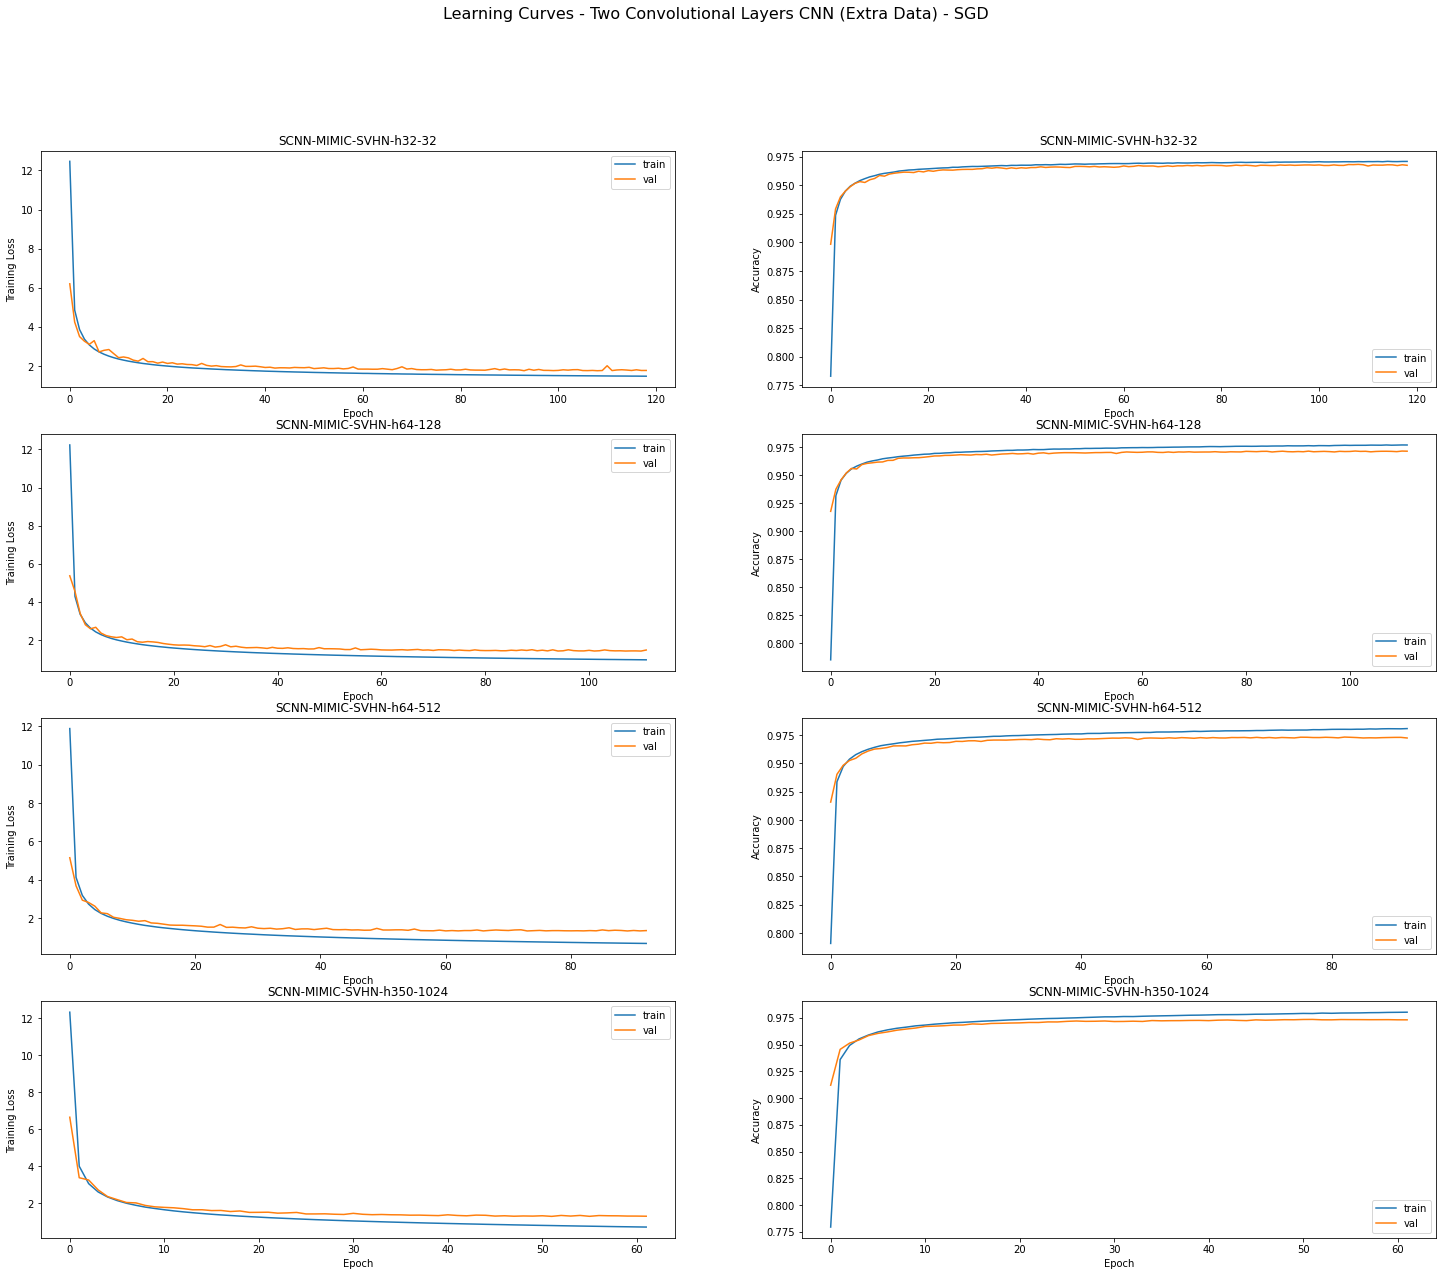

In [ ]:
fig = plt.figure()
fig.suptitle('Learning Curves - Two Convolutional Layers CNN (Extra Data) - SGD', fontsize=16)
fig.set_size_inches(25, 20)

plt.subplot(4, 2, 1)
plt.plot(loss_train_32_32, label='train');
plt.plot(loss_test_32_32, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h32-32')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 2)
plt.plot(acc_train_32_32, label='train');
plt.plot(acc_test_32_32, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h32-32')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 3)
plt.plot(loss_train_64_128, label='train');
plt.plot(loss_test_64_128, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-128')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 4)
plt.plot(acc_train_64_128, label='train');
plt.plot(acc_test_64_128, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-128')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 5)
plt.plot(loss_train_64_512, label='train');
plt.plot(loss_test_64_512, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-512')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 6)
plt.plot(acc_train_64_512, label='train');
plt.plot(acc_test_64_512, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-512')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 7)
plt.plot(loss_train_350_1024, label='train');
plt.plot(loss_test_350_1024, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h350-1024')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 8)
plt.plot(acc_train_350_1024, label='train');
plt.plot(acc_test_350_1024, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h350-1024')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

##### Learning Curves for Extra Data Teacher Correct - SGD

In [ ]:
# Curves for Extra Data Teacher Correct
loss_train_32_32 = [13.02151974852467, 4.9631030803954825, 3.9397813491790052, 3.443381700905487, 3.139271863615889, 2.935523017991878, 2.7803269303693185, 2.65919746069395, 2.5666531160034944, 2.482032712823535, 2.415899481883049, 2.3598268465828776, 2.3050850139921693, 2.2576646844599417, 2.2156720994041144, 2.175884546296644, 2.142607122016187, 2.1118692563908943, 2.0821358766633407, 2.055447399703362, 2.031505486897173, 2.0093458908583752, 1.9875532647921375, 1.9663034661369276, 1.9483360707254325, 1.9316290632163824, 1.916719926036165, 1.8997586065842982, 1.883001924273211, 1.869428815337134, 1.8581262758703392, 1.8455886628957436, 1.8315548750234938, 1.8217576431400007, 1.811848394282127, 1.8010427972517684, 1.7909979790531456, 1.7808963929590242, 1.7722037723313662, 1.7601415620443277, 1.75127883070919, 1.745909159501623, 1.7358804746919227, 1.728641384783631, 1.72108828899427, 1.7133379999044032, 1.7050992325144623, 1.6983649603888653, 1.6907330579445106, 1.685972181322335, 1.6785650418947073, 1.6724362600931568, 1.6660501652769968, 1.6590814085015804, 1.6538047628617394, 1.648715862076223, 1.6433825528196562, 1.638298108043176, 1.6341981937321595, 1.628108663313391, 1.6244772683043547, 1.6198546167155756, 1.6163162926642958, 1.6108696625133805, 1.6065690306326057, 1.602150620254638, 1.5980158603687, 1.5943811136243908, 1.589878075898409, 1.5868155311769505, 1.5824124776932145, 1.5770365568559654, 1.5756282093774756, 1.5732390188621308, 1.5688391730054199, 1.5644757219397372, 1.562172163999285, 1.5605293370352644, 1.555530295387044]
loss_test_32_32 = [6.946786610666289, 5.0730807527761295, 3.7487286061611034, 3.6086554413961025, 3.1105663856422407, 3.118882212002295, 3.086553979901638, 2.97257602731756, 3.0506797367692866, 2.6885006801726474, 2.683070680879439, 2.623268625641802, 3.0359462517596105, 2.615498304772785, 2.4291361256251998, 2.3457931639804235, 2.3496881520893873, 2.463196079888379, 2.256672091491065, 2.1871096364420026, 2.2326907804717644, 2.1928818198019835, 2.297222828018636, 2.1211978097649835, 2.095696127819257, 2.116981974981816, 2.188190922501618, 2.1689908402823, 2.089655954258366, 2.114412839455826, 2.0344996180685926, 2.0780569163044973, 2.0419441934506293, 2.192821982460675, 2.0287609747721107, 2.05990005883028, 2.1221282319579555, 2.003079207404027, 1.955817397525666, 1.9578987654776911, 1.9643395822054017, 1.9451814745690827, 2.0330817003133537, 1.9952705158755948, 2.0897480394881045, 1.9833441884103788, 2.0411304049317005, 1.9421018661554985, 1.9590621119524856, 1.9656473268191796, 1.9234355255024358, 1.9422906014785206, 1.9048016440710986, 1.8704995955931236, 1.8578466873355484, 1.8525048230970984, 1.8777041063891646, 1.9287307150964341, 1.9364492806292397, 1.8846581748808509, 1.9253716773194032, 1.8476106663006733, 1.9947149533689168, 1.872662022047346, 1.8716364380060024, 1.8338341243412792, 1.8571952128608535, 1.944988791057708, 1.9446017564199956, 1.8750693412491628, 1.9116939405147486, 1.9658524073528485, 1.8599017695564513, 1.9084388572627582, 1.8662482790305737, 1.8107650926049006, 1.8135698416833481, 1.8292251749108648, 1.876148485290975]
acc_train_32_32 = [0.7908904260236266, 0.9387554078136727, 0.9525603109039161, 0.9596460782607189, 0.9634590472436827, 0.9660328013103884, 0.9683939090264708, 0.969887321878423, 0.9712658568152125, 0.9724806296287244, 0.9733825434461398, 0.9744604404470931, 0.9750397184271973, 0.9755921100872583, 0.9760882848943072, 0.9766040133913619, 0.9768337692178994, 0.9772419524356561, 0.9777087967149806, 0.9780900936132769, 0.9783858431276315, 0.9784640578762914, 0.9789700095324224, 0.9791508811383159, 0.9794344096008604, 0.9796299464688678, 0.9797448243805341, 0.979962359149434, 0.9801676728639013, 0.9803949844795522, 0.9806149634593386, 0.9804976413367859, 0.9808667171803583, 0.9807762813746436, 0.9810182582556136, 0.9813677804091803, 0.9813408940923423, 0.9813262288270233, 0.9814899909567111, 0.9817564099433412, 0.9817784078381148, 0.9818077383716667, 0.9819592794466306, 0.9821548163175519, 0.9821474836848924, 0.9821597047393249, 0.9824994500528419, 0.9823894605626573, 0.9826925427096715, 0.9826876542878985, 0.9826827658661255, 0.9827365385088339, 0.9828318627331166, 0.9831129469850659, 0.9831398333048176, 0.9830933932979737, 0.9831178354039252, 0.9832767091144624, 0.9833915870261286, 0.9833500354410578, 0.9833353701757388, 0.9834135849211936, 0.983567570207044, 0.9836995575949158, 0.9835797912614765, 0.983616454427688, 0.9836580060130502, 0.9836995575978296, 0.9836946691760565, 0.9836751154860507, 0.9838755407816586, 0.9840564123872608, 0.9839904186904112, 0.9839488671082541, 0.9841883997751326, 0.9840393029110551, 0.9840832987040987, 0.9841468481900618, 0.9842152860948843]
acc_test_32_32 = [0.916234718833401, 0.9359804401281119, 0.9543080684748139, 0.9564792175957509, 0.9632469437804374, 0.9659168704459603, 0.9644205378739933, 0.9691246943916844, 0.967872860650853, 0.9688312958202036, 0.9687530562347189, 0.972088019536585, 0.96534963326699, 0.9725183374001519, 0.9732224938642133, 0.9747286063569682, 0.9742591687041565, 0.9750220048666584, 0.9749731051111571, 0.9759511002444988, 0.9765476772767698, 0.9769877750378074, 0.9771540342065116, 0.9772029339853301, 0.9775647921527219, 0.9782689486704129, 0.9778777505879297, 0.9778679706601467, 0.9784254278646997, 0.9785036674968188, 0.9789926650133576, 0.9790806846117333, 0.9783667481814153, 0.9769388752823063, 0.9789926650133576, 0.9780831295995083, 0.9779657701629881, 0.9799999999766827, 0.9795305623623445, 0.9797652811735942, 0.9797066014436755, 0.9797848410909508, 0.9799902200488998, 0.9793545232273838, 0.9790415648073323, 0.9795305623623445, 0.9802249388519884, 0.9802444987926623, 0.9799217604063543, 0.9796968214925752, 0.980479217603912, 0.9808704156397607, 0.9802836185585899, 0.9808997554930615, 0.9809290953696794, 0.9806161369111543, 0.9810562347106654, 0.9815256723483209, 0.9804889975701684, 0.9813594131796167, 0.980968215135607, 0.9812713936430317, 0.9809975550273812, 0.9811931540109126, 0.9819462102841049, 0.9814474327779924, 0.9808117359413203, 0.9807432762603013, 0.9819951100244498, 0.980889975526805, 0.9809975550040639, 0.9790709046221595, 0.9814278728757919, 0.9810268948422084, 0.9814865525439199, 0.9818288508324285, 0.981838630806846, 0.9816136919082231, 0.9817603911747268]

loss_train_64_128 = [12.04555594466396, 4.32837156211931, 3.4031045152992245, 2.9467531845756265, 2.665638482066282, 2.4689464198209388, 2.3253659721646116, 2.2125039896886824, 2.1173776971677016, 2.039352825371926, 1.9748565832870968, 1.917319799982933, 1.8674725433972028, 1.8210088032248188, 1.782878541857834, 1.7432480333947729, 1.7113111587101388, 1.67946538902269, 1.6522638029171424, 1.6249700973510184, 1.6015450832975655, 1.5778689954810743, 1.5564709933511036, 1.5360311371769695, 1.5153016627049027, 1.497921730704365, 1.4811337741017503, 1.4663530496017994, 1.4510722783049315, 1.4345974920740794, 1.4222795570307243, 1.4081430830351898, 1.3953898052053526, 1.3836142275423322, 1.3718373615133985, 1.3603638155547244, 1.3489420829724745, 1.3390845363253683, 1.32789701905739, 1.3194336138005172, 1.3093093118930303, 1.3013668705390111, 1.2920699994204445, 1.2833402295633933, 1.2759286532489333, 1.2674355208199222, 1.260155618291289, 1.251654439263496, 1.2438170898850223, 1.2369937051380722, 1.2306011813960742, 1.223075988075738, 1.2170881421151154, 1.209675865930559, 1.2034126331213355, 1.19718547477097, 1.1913979836584603, 1.1854170453273667, 1.1785191528347794, 1.1737555136744822, 1.1681530850677149, 1.1627301261095941, 1.1563477016516852, 1.1519385352258362, 1.1471769094607023, 1.1423608319818168, 1.1367837310457964, 1.1312737682466911, 1.1266009274077533, 1.1221646837670345, 1.1177810772784695, 1.1129934350831139, 1.1085544933661, 1.1042117092174852, 1.0998927260221407, 1.0959765458819108, 1.09085298030159, 1.087221060139401, 1.083436390417893]
loss_test_64_128 = [6.318854624881138, 4.1528385764777225, 3.249325385469096, 3.8775005748440994, 3.12968983684717, 2.625884292924317, 2.4322740020798586, 2.4211479801373845, 2.6005598651680795, 2.6888066528292334, 2.3065917716457673, 2.1127679106472175, 1.9955102025524036, 1.9510334620021084, 2.0096612652683024, 1.9383330144159368, 1.8684775075096374, 1.8957556125622215, 1.8269810716167347, 1.876108804373986, 1.8061335773048308, 1.8205999223317377, 1.9332660587236177, 1.888292831584119, 1.7575485924974923, 1.7251260322253688, 1.735706990538133, 1.7236386140949278, 1.7455914160814727, 1.6521065414377414, 1.7818096561361934, 1.7185363415389305, 1.7022780880869746, 1.6550707307689638, 1.618164448866343, 1.8523495890097397, 1.6234063016546385, 1.7080199356778618, 1.7844011780591933, 1.594481652551292, 1.6172105064345454, 1.7136781275616297, 1.6922456929083267, 1.6241750377990798, 1.6516775064561653, 1.6040335010258084, 1.5468843954851108, 1.5677192103891908, 1.5578457183324912, 1.5948158792155296, 1.5559002774198947, 1.6010039428183969, 1.581240378890469, 1.6318640461667535, 1.616379202485959, 1.5572750929317147, 1.559295450700233, 1.5357439771246502, 1.5331807640607316, 1.5148011516114028, 1.6456133636647157, 1.5371235585271001, 1.5436616739119178, 1.529736969460485, 1.544835579942083, 1.5332395722545447, 1.5154495391425993, 1.5311576106507505, 1.5011570659698077, 1.7247356977276231, 1.4994251678951795, 1.5046762778601612, 1.533233586078168, 1.533909509896649, 1.5047059091460735, 1.4943199359898462, 1.4932592094719848, 1.4866488307612449, 1.5175498342607308]
acc_train_64_128 = [0.8046220027843608, 0.9465182215892453, 0.9596314129983134, 0.9658617065486237, 0.9697651113338058, 0.9722533180136561, 0.9743431183245403, 0.9760296238330308, 0.977283504020727, 0.9780925378212497, 0.9789186811008919, 0.979825483339789, 0.9803485444695034, 0.9807616161122381, 0.9814142204189378, 0.9818737320626889, 0.9823161342331481, 0.9825238921614157, 0.9829174101112309, 0.9831080585635842, 0.9834282501865126, 0.9835895681050226, 0.9840173050130765, 0.9841517366089212, 0.9843937134866861, 0.9847847872285286, 0.984691907214841, 0.9848556693471513, 0.9849827683103364, 0.9851636399159385, 0.9852662967760858, 0.9854007283748442, 0.9856329284061494, 0.9857600273751619, 0.9858113558037788, 0.9859189010827855, 0.9861755432258695, 0.9862170948080266, 0.9864639601075647, 0.9863979664136286, 0.9864052990492019, 0.9865739496003715, 0.9866423875022802, 0.9866863833011512, 0.9867963727910444, 0.9868379243761152, 0.9869332486009806, 0.9870041307134845, 0.9871581160022487, 0.9871214528392424, 0.9872461075941632, 0.9873340991860777, 0.9874587539415814, 0.9874245349888788, 0.9875491897440911, 0.9876836213399357, 0.9875198592137443, 0.9877398381903256, 0.9875907413291619, 0.9877007308190551, 0.9879500403294796, 0.9879695940165717, 0.9878596045266785, 0.9880258108640478, 0.9880869161362108, 0.988089360350011, 0.9880966929826706, 0.9881675750983795, 0.9882140151023096, 0.988187128785763, 0.9881431329895143, 0.9883753330237333, 0.9883288930139758, 0.9884437709285557, 0.9884388825067827, 0.9884877667215992, 0.9884535477721018, 0.9886368635885904, 0.988680859381634]
acc_test_64_128 = [0.925995110023284, 0.9477555012143328, 0.9616528117510975, 0.963471882655743, 0.9647432762906137, 0.970992665051831, 0.9740048899522329, 0.973408312935118, 0.97334963326699, 0.9746210268715483, 0.9769682151356069, 0.9776919315554985, 0.9789437652578564, 0.9793838630573674, 0.9799022004656803, 0.9797457212480765, 0.9803325183140911, 0.9807823960647023, 0.980488997531695, 0.9812616136686143, 0.9809095354290055, 0.980968215135607, 0.9802151589393616, 0.9817017114681253, 0.9819853300500324, 0.9826112469204481, 0.9823471882407414, 0.9829633251600569, 0.9825721271160471, 0.9831491442309616, 0.9826308068226486, 0.9831980439864627, 0.9827188263825507, 0.983168704133162, 0.9832567236930642, 0.9829242053556558, 0.983569682128272, 0.9827970659913527, 0.9823960879962427, 0.9837066014436755, 0.9836185818837733, 0.9837457212480765, 0.9829242053556558, 0.9841466992431864, 0.9841955989986877, 0.9845085574338955, 0.9847041564559004, 0.984048899732184, 0.984009779927783, 0.9842151589008882, 0.984410757922893, 0.9843520782162916, 0.9843227383629909, 0.9845183373849957, 0.9844205378739933, 0.9849877750378074, 0.9846552567003991, 0.9847334963092012, 0.9847432762603013, 0.9855647921527219, 0.9848997554779053, 0.9852224938642133, 0.9848704156246045, 0.9848997554779053, 0.9849095354290055, 0.9851540342065116, 0.9851735941087121, 0.9856430317615239, 0.9856528117126241, 0.9848312958202036, 0.9852909535219151, 0.9850660146466095, 0.9849779950867072, 0.9854669926417194, 0.9851442542554114, 0.9850562346955092, 0.9853007334730153, 0.9852322738153136, 0.9855843520549223]

loss_train_64_512 = [12.088152045067027, 4.0217621954820775, 3.101968418688512, 2.656353147105692, 2.3858601831106045, 2.193634295909362, 2.0514467093343915, 1.937588458677996, 1.845879231414061, 1.7689367448995432, 1.6981568356760526, 1.6420777420045065, 1.5882202811863873, 1.5416032599198881, 1.5009748305641086, 1.4623633477366917, 1.4278977284105003, 1.3946922561847463, 1.3635897990448818, 1.336226495629349, 1.3118268973999914, 1.286997884563375, 1.2655682223091362, 1.243345663391515, 1.2235634969394011, 1.203508332030733, 1.1844671561170033, 1.1674083360774747, 1.1498520649936617, 1.1335603542260049, 1.1192320825505082, 1.1033975072168463, 1.0891100321825238, 1.075940943618004, 1.0621212827635735, 1.0493961729096721, 1.0363834457221706, 1.0243011881496702, 1.013125684364876, 1.0020763422510857, 0.9909583993341865, 0.9796077135948779, 0.9695139106103827, 0.9589378675887571, 0.9497520155308548, 0.9404303400436033, 0.9306443151981174, 0.9209917881483963, 0.9129648295461781, 0.9035147763661042, 0.8963628380014177, 0.8877763495001083, 0.8789335251271155, 0.8702810879480695, 0.863731408479921, 0.8565092987640448, 0.8477981788756092, 0.8407929275583231, 0.8331791213690846, 0.8267217873000184, 0.8200594893207069, 0.8135506682714347, 0.8063574446537557, 0.8008162727146285, 0.7945144051277416, 0.7877273394796169, 0.7822067478618995, 0.7756897998961025, 0.7694836670737648, 0.7638426474316522, 0.7588372253323867, 0.753625899818011, 0.7477963674687035, 0.7437582992494574, 0.7368795356369257, 0.7314066658113142, 0.7278086196885871, 0.7216570186355086, 0.7167849212263551, 0.7113860615500871, 0.7069359818477601, 0.7028131513647679, 0.6988331255317681, 0.6935079139926906, 0.6888361537179417]
loss_test_64_512 = [5.645433911936791, 3.931690497442679, 3.1806758771024297, 2.6305924415122033, 2.5062449882665883, 2.3048074844938617, 2.0981702218976754, 2.109926492094119, 2.081436960747306, 2.0084515828223566, 1.8346979102622034, 1.8806486043253854, 1.7608846257869655, 1.825236074051239, 1.7449797260312405, 1.685990518523312, 1.7210575595356725, 1.6210945040835727, 1.5975683741674447, 1.6051500412560908, 1.592386471438233, 1.6043161830622292, 1.5394581291529834, 1.5712024600301804, 1.6111676712082768, 1.5288228996015703, 1.6839372025305601, 1.4719329034716693, 1.5222204193497637, 1.4550971900501577, 1.5270921162672906, 1.5143374506523672, 1.4482896873245612, 1.4613990490990338, 1.4235398234038599, 1.4419451818979165, 1.465876342810745, 1.4537709356321973, 1.4560201150269263, 1.4107156585889224, 1.4009552149154738, 1.5176426433549242, 1.4161848332654585, 1.3991757193684287, 1.4347708164252395, 1.4080121269389294, 1.445283869458877, 1.3854131721692446, 1.431926152280607, 1.4213373345745806, 1.4577329695079029, 1.3613393740805553, 1.3858740426625482, 1.3713596935178949, 1.3898559271852078, 1.4448665394095161, 1.3627129362474735, 1.4026822375551704, 1.3481339224649815, 1.3937317107883818, 1.5197728518623594, 1.372610471548253, 1.3471317280673747, 1.4163454084233142, 1.3584370324920616, 1.373346504209094, 1.337030727652291, 1.441294108593668, 1.38991550046599, 1.355207758989777, 1.3734035414973214, 1.3186313352118495, 1.3656024947178103, 1.363300187344073, 1.3646622629888483, 1.42434649231498, 1.3495108878968105, 1.4077809130708279, 1.3760079920146169, 1.361710804116172, 1.458030726686958, 1.4107739286376095, 1.3457018021278102, 1.367212982012182, 1.3433642951620237]
acc_train_64_512 = [0.8032214699490099, 0.9514653044264659, 0.9641214283971334, 0.9699508713582673, 0.9736196318989268, 0.9759489648740672, 0.9777234619802997, 0.9792266516725928, 0.9804316476396449, 0.9812577909224921, 0.9820790457800699, 0.9828758585293652, 0.9833818101796689, 0.98403685870046, 0.9846332461535646, 0.9849045535648816, 0.9852931830958375, 0.9855009410211913, 0.9858969031848068, 0.9861682105935013, 0.9862904211378272, 0.9866423875022802, 0.9868623664849803, 0.9870114633490578, 0.9872143328497248, 0.9875271918461125, 0.9877031750270279, 0.9878204971524943, 0.9879598171701119, 0.9881382445677414, 0.9882042382616772, 0.9885073204086914, 0.988372888809933, 0.9886979688578396, 0.9888299562486251, 0.988976608901816, 0.9890181604868868, 0.9892185857795811, 0.9893530173783394, 0.9894703395008921, 0.9895290005592547, 0.9897025395321973, 0.9896976511104243, 0.9898907437736642, 0.9897758658617065, 0.9899029648248916, 0.9900813922196072, 0.9901082785393589, 0.9901327206514291, 0.990203602763933, 0.9903991396377679, 0.990430914379584, 0.9904920196514555, 0.9906142301957813, 0.9907144428424198, 0.9907804365363557, 0.9908219881211351, 0.990687556519463, 0.9909148681348227, 0.990924644975455, 0.9910321902544617, 0.9909857502476179, 0.9911421797472686, 0.9911446239581551, 0.9912570576589348, 0.9912399481827292, 0.991437929264537, 0.9913181629313891, 0.991357270305282, 0.9914770366358074, 0.9915234766426513, 0.9915552513870897, 0.9915088113802459, 0.9915674724415222, 0.9915772492850683, 0.991689682985848, 0.9917434556253514, 0.9917972282648547, 0.9917801187886491, 0.9919023293300612, 0.991860777747904, 0.9919389924933588, 0.9919805440784296, 0.9918901082756285, 0.9920514261970523]
acc_test_64_512 = [0.938542787316376, 0.9535647921911953, 0.9652224938642133, 0.9697017115065988, 0.9727823960647023, 0.9753740831062672, 0.9768997554779053, 0.977848410734629, 0.9778288508324285, 0.9793643031784841, 0.9795599021771718, 0.980889975526805, 0.9816332518104236, 0.9814083129735914, 0.9818288508324285, 0.9819755500989321, 0.9827970659913527, 0.9832958434974651, 0.9836283618348735, 0.9833643031936403, 0.9835794620793723, 0.9832273838397635, 0.9843814180695923, 0.9848606356735043, 0.9843422982651914, 0.9844205378739933, 0.9837066014436755, 0.9852224938642133, 0.9852029339620129, 0.985408312935118, 0.9847823960647023, 0.9850268948422084, 0.9853007334730153, 0.9855061124461204, 0.9856234718593234, 0.9852909535219151, 0.9853105134474328, 0.9857212713703258, 0.9856332518104236, 0.9858581906857292, 0.9857799510769273, 0.9859070904412305, 0.9861418092909535, 0.9860733496099346, 0.9865525672138465, 0.9862396087786388, 0.9859755500989321, 0.9864743276050446, 0.9867775060891523, 0.9859559901967316, 0.9863471882407414, 0.986405867947343, 0.9865916870415647, 0.9864352078006436, 0.9869242053556558, 0.9868557456979542, 0.9868166258935532, 0.9858973104901302, 0.9866699266270496, 0.9868948655023552, 0.9861026894865526, 0.9865427872627464, 0.9866405867737488, 0.9861418092676363, 0.9870122249388753, 0.9867579461869517, 0.9869535452089566, 0.9867090464314505, 0.9869828850622574, 0.9869339853067561, 0.9868557456979542, 0.9868850855512549, 0.9868068459424529, 0.9868557456979542, 0.9875012224705703, 0.9870317848410758, 0.9868753056001547, 0.9868068459657702, 0.9870806845732598, 0.9869339853067561, 0.9863960880195599, 0.986601466992665, 0.9870415647921761, 0.9866894865525673, 0.9866601466992665]

loss_train_350_1024 = [12.558419420738202, 4.020534547506442, 3.0533874044846536, 2.597389932872584, 2.318645556277887, 2.12577170726738, 1.9760985854854243, 1.859229570926598, 1.7664546036135782, 1.6864710463572652, 1.6182444953540838, 1.5575921154289114, 1.5060242639647266, 1.4559226953027313, 1.4145838481703403, 1.3744900866622165, 1.3385246547121077, 1.3053665658622464, 1.274188455169268, 1.243910916396518, 1.2169941558906188, 1.1915169751067507, 1.167675724408442, 1.1458007293652734, 1.1236866183181062, 1.1030221115111303, 1.0846315885852957, 1.0643730217414056, 1.0469994504540387, 1.0303236412634302, 1.0118323519145216, 0.99631957259451, 0.9798585242213219, 0.9660638690574643, 0.9514716852787313, 0.9380856216060178, 0.9246798574902616, 0.9115791795545883, 0.898380457880304, 0.8856757306395275, 0.8744192151215864, 0.8623679164891672, 0.8512766802575802, 0.8404174619887315, 0.8300586575114252, 0.8188503311604215, 0.8089064976538681, 0.7989479230379879, 0.7900689698566895, 0.7807602063243514, 0.771329736385297, 0.761916092694253, 0.752740250914838, 0.7451709078124731, 0.7358065785998178, 0.727875360985577, 0.7199626509726559, 0.7128964968953524, 0.7041050338848263, 0.6970165502383161, 0.6897102220189034, 0.6820459308590002, 0.6746510289078588, 0.6677901308503255, 0.6605701467372175, 0.6537698226507316, 0.647645683865259, 0.6407972548654405, 0.634384168853151, 0.6283859740308708, 0.6233991244309365, 0.6162608450641991, 0.610151357323895]
loss_test_350_1024 = [5.755006425759611, 3.938297031822298, 3.203423859491325, 2.56057236808553, 2.9637860107421874, 2.202030179380496, 2.0767452526139163, 1.9833993685799298, 1.9370030073198539, 1.7970264244732472, 1.7928899543127979, 1.9492316299289247, 1.736669480244513, 1.7156466467771088, 1.6158737404713712, 1.786485038239682, 1.6533283144290989, 1.6465000246486337, 1.6602868732671574, 1.5155237560178947, 1.5369274068216823, 1.5318222076956975, 1.4560766205822635, 1.526495253180525, 1.4299560297520644, 1.518235073833419, 1.4356381629789954, 1.4369679014630306, 1.4292349808629976, 1.6900281145636784, 1.5425144309601166, 1.37808878585004, 1.4222775141126078, 1.5784285061703334, 1.5368268392371665, 1.3702371826754804, 1.359623190373838, 1.395073876098782, 1.3213667507964417, 1.3269449331964431, 1.3592859955650087, 1.3505374911315284, 1.3546379290046786, 1.3430229001733085, 1.3237010828405253, 1.339989418081083, 1.321576468672904, 1.3150372994896251, 1.3113952255412245, 1.2994574281137554, 1.351379077097606, 1.3519487638450194, 1.3173043706889258, 1.2997590947792408, 1.295141300478891, 1.3125795888224558, 1.3282229487598671, 1.2851489486880874, 1.279573179119082, 1.301054919359445, 1.2865441066793242, 1.3227467787539755, 1.3260080202610978, 1.3048970050974988, 1.2888651446783164, 1.386134789825943, 1.2951739026491682, 1.3258030169074284, 1.2930587206143331, 1.2773897079453782, 1.289677230683399, 1.3538914182821522, 1.2648523068393063]
acc_train_350_1024 = [0.7923007357048545, 0.9515264096957151, 0.9643731821181531, 0.9707599051617039, 0.9742257961987826, 0.9767775523675096, 0.9785227189372764, 0.979981912836526, 0.9813848898853859, 0.9820985994642483, 0.9829931806516267, 0.9836775597001423, 0.9843619387480752, 0.9848043409185344, 0.9851783051841713, 0.985694033681226, 0.9860044484608997, 0.9864321853689536, 0.9867768191039523, 0.9869332485977755, 0.9872974360198663, 0.9877496150367854, 0.9880111456016425, 0.9879793708572041, 0.9883460024901813, 0.9884168846058903, 0.9886050888470658, 0.9887859604497541, 0.9889643878473835, 0.9890841541808227, 0.9892650257867163, 0.9895314447701413, 0.9895876616234449, 0.9897538679608142, 0.9899029648248916, 0.9899787353652874, 0.9902378217192579, 0.9902964827805343, 0.9903404785764915, 0.9904651333287902, 0.9905457922909588, 0.9906704470461711, 0.9907266638936473, 0.9908415418082273, 0.9910199692029429, 0.9910419670980077, 0.9911690660670203, 0.9912277271253829, 0.991220394495637, 0.9913206071419842, 0.9914354850536504, 0.9914403734754235, 0.9914599271596019, 0.9917556766768703, 0.9916994598293941, 0.9917239019382592, 0.9917532324659837, 0.9918387798499254, 0.9919683230269107, 0.9920294282990736, 0.9920538704079388, 0.9921174198909882, 0.9922054114829028, 0.9922665167521519, 0.9923227336054555, 0.9924596094151004, 0.9924400557280082, 0.9924498325715543, 0.9925329357416958, 0.99257204311588, 0.9927260284017305, 0.9927455820888226, 0.992713807347298]
acc_test_350_1024 = [0.935784841097946, 0.9558141809360905, 0.9655745721422956, 0.9701222493654358, 0.9701809290953545, 0.9763911980206925, 0.9784156478984432, 0.9795012224705704, 0.9791002444754603, 0.9811149144021106, 0.9815745721038222, 0.9823569681918417, 0.9822200488764383, 0.9830220048666584, 0.9832567236930642, 0.9825916870182476, 0.9839315403189811, 0.9841955989986877, 0.9839706601233821, 0.9852518337175141, 0.9844400977761938, 0.9847432762603013, 0.9851442542938847, 0.9853202933752158, 0.985691931517025, 0.9851442542554114, 0.9858679706368295, 0.9855843520549223, 0.9863960879962427, 0.9851638141576119, 0.9861124694143356, 0.986728606333651, 0.9864254278880168, 0.9860244498544334, 0.9864645476539444, 0.9866503667248491, 0.9866699266270496, 0.986728606333651, 0.9870611246710593, 0.9866601466759493, 0.9870024449644579, 0.9871589241820617, 0.9867481662358515, 0.9866503667248491, 0.9873056234485654, 0.9869242053941293, 0.9870122249155581, 0.9869731051111571, 0.9875207823727707, 0.9872665036441645, 0.9871980439864627, 0.98709046452436, 0.9870806845732598, 0.987530562323871, 0.9877066014436754, 0.9871980440249362, 0.987051344719959, 0.9872567236930642, 0.9875892420304725, 0.9876772615903747, 0.9875599022156452, 0.9872371637908637, 0.9879217604063543, 0.9877946210420511, 0.9875794620793723, 0.9874229828617683, 0.9876968214925752, 0.9874523227150691, 0.9873154033996656, 0.9875403423134447, 0.9874914425194701, 0.9873447432529664, 0.9878826405634799]

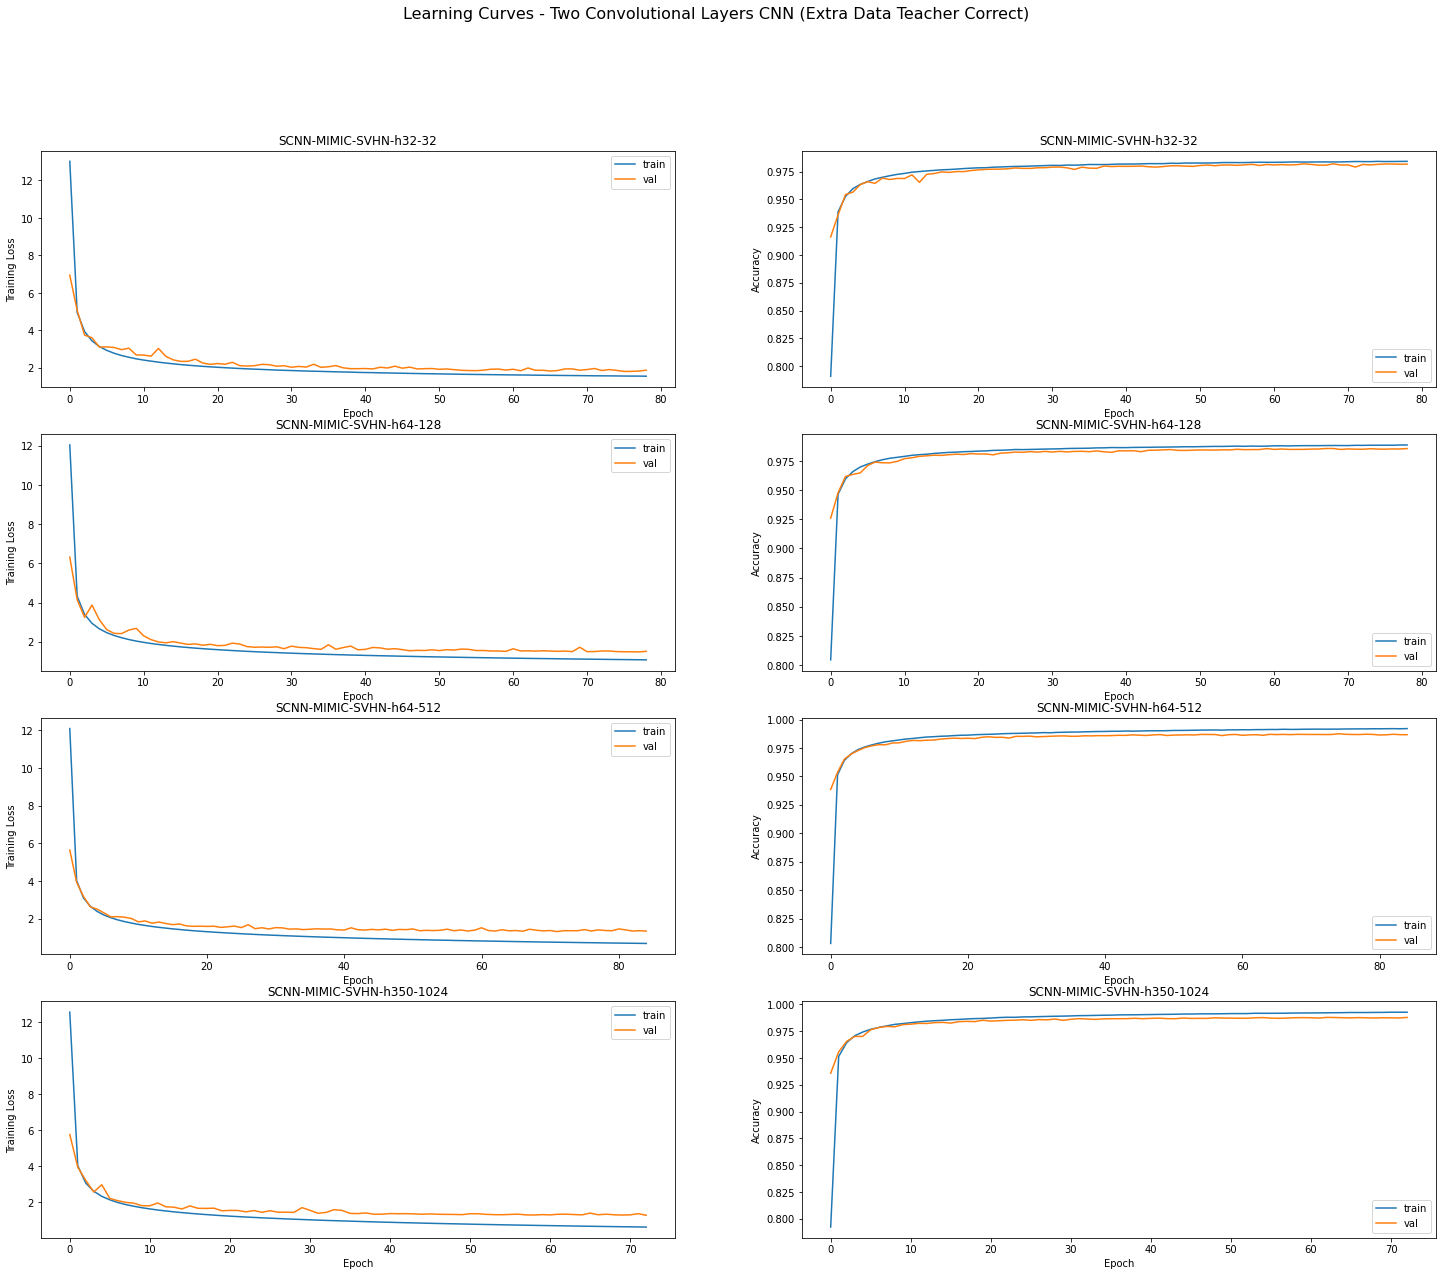

In [ ]:
fig = plt.figure()
fig.suptitle('Learning Curves - Two Convolutional Layers CNN (Extra Data Teacher Correct)', fontsize=16)
fig.set_size_inches(25, 20)

plt.subplot(4, 2, 1)
plt.plot(loss_train_32_32, label='train');
plt.plot(loss_test_32_32, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h32-32')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 2)
plt.plot(acc_train_32_32, label='train');
plt.plot(acc_test_32_32, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h32-32')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 3)
plt.plot(loss_train_64_128, label='train');
plt.plot(loss_test_64_128, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-128')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 4)
plt.plot(acc_train_64_128, label='train');
plt.plot(acc_test_64_128, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-128')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 5)
plt.plot(loss_train_64_512, label='train');
plt.plot(loss_test_64_512, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-512')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 6)
plt.plot(acc_train_64_512, label='train');
plt.plot(acc_test_64_512, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-512')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 7)
plt.plot(loss_train_350_1024, label='train');
plt.plot(loss_test_350_1024, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h350-1024')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 8)
plt.plot(acc_train_350_1024, label='train');
plt.plot(acc_test_350_1024, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h350-1024')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

### Training for 2 Layers with Temperature in Teacher model

#### Adjust 2 Layers with Temperature in Teacher model

In [ ]:
from scipy.special import softmax
def get_temperature_predictions (svhn_model, name, x_train, x_test, T):

  # Get the hard logits from the model
  svhn_model = Model(svhn_model.input, svhn_model.get_layer('logit').output)
  
  train_logits_hard = svhn_model.predict(x_train)
  test_logits_hard = svhn_model.predict(x_test)

  # Devide with temperature
  train_logits_hard = train_logits_hard / T
  test_logits_hard = test_logits_hard / T

  # Pass it through softmax activation
  train_predictions = softmax(train_logits_hard, axis=1)
  test_predictions = softmax(test_logits_hard, axis=1)

  return train_predictions, test_predictions

#### Load Data

In [ ]:
x_train_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/data/x_train_cnn.npy')
x_test_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/data/x_test_cnn.npy')

x_acc_test_cnn=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/data/x_acc_test_cnn.npy')
y_labels_acc_test=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/data/y_labels_acc_test.npy')

x_train_cnn_extra =np.load('/content/drive/My Drive/Colab Notebooks/SVHN/extra_data/x_train_cnn_extra.npy')
x_test_cnn_extra =np.load('/content/drive/My Drive/Colab Notebooks/SVHN/extra_data/x_test_cnn_extra.npy')

y_labels_train_extra =np.load('/content/drive/My Drive/Colab Notebooks/SVHN/extra_data/y_labels_train_extra.npy')
y_labels_test_extra =np.load('/content/drive/My Drive/Colab Notebooks/SVHN/extra_data/y_labels_test_extra.npy')

x_train_cnn_extra_teacher_correct =np.load('/content/drive/My Drive/Colab Notebooks/SVHN/extra_data/x_train_cnn_extra_teacher_correct.npy')
x_test_cnn_extra_teacher_correct =np.load('/content/drive/My Drive/Colab Notebooks/SVHN/extra_data/x_test_cnn_extra_teacher_correct.npy')

y_labels_train_extra_teacher_correct =np.load('/content/drive/My Drive/Colab Notebooks/SVHN/extra_data/y_labels_train_extra_teacher_correct.npy')
y_labels_test_extra_teacher_correct =np.load('/content/drive/My Drive/Colab Notebooks/SVHN/extra_data/y_labels_test_extra_teacher_correct.npy')

#### Training

In [ ]:
import shutil

# Arrays with the results
scores_2_layer = []
channels_number = []

attack_accuracies_2_layer = []

#channels_to_test = [32, 64, 64, 350] 
#channels_to_test2 = [32, 128, 512, 1024] 

channels_to_test = [32, 64, 64] 
channels_to_test2 = [32, 128, 512] 

index_for_two = 0;

temperatures = [1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]

for channel in channels_to_test:
  for t in temperatures:

    # Set name
    name = 'SCNN-SVHN-h'+ str(index_for_two)
    svhn_model = get_CNN_model()
    svhn_model = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/SVHN/CNN_SVHN.h5')

    train_predictions, test_predictions = get_temperature_predictions (svhn_model, name, x_train_cnn_extra, x_test_cnn_extra, t)
        
    svhn_model = get_SCNN_model_layer2(channels_l1=channel, channels_l2=channels_to_test2[index_for_two])
    svhn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    #Save trained SNN model
    svhn_model = train_scnn(svhn_model, x_train_cnn_extra, train_predictions, x_test_cnn_extra, test_predictions)

    # Learning Curves Data
    loss_train_cnn=svhn_model.history.history['loss']
    loss_val_cnn=svhn_model.history.history['val_loss']
    acc_train_cnn=svhn_model.history.history['accuracy']
    acc_val_cnn=svhn_model.history.history['val_accuracy']

    print ("")
    print (loss_train_cnn)
    print ("")
    print (loss_val_cnn)
    print ("")
    print (acc_train_cnn)
    print ("")
    print (acc_val_cnn)

    #print ("Loss Train")
    #print (loss_train_cnn)
    #print ("Loss Val")
    #print (loss_val_cnn)
    #print ("Acc Loss")
    #print (acc_train_cnn)
    #print ("Acc Val")
    #print (acc_val_cnn)

    name_to_store = 'SCNN_MIMIC_SVHN_h'+str(channel)+str('_')+str(channels_to_test2[index_for_two])+str('_')+str(t)+'.h5'
    svhn_model.save(name_to_store)
    print ('Model: '+name_to_store+' was saved')

    svhn_model = get_SCNN_model_layer2(channels_l1=channel, channels_l2=channels_to_test2[index_for_two])
    svhn_model = keras.models.load_model(name_to_store)

    score = 0;
    preds = svhn_model.predict(x_acc_test_cnn)
    for i in range (len(x_acc_test_cnn)):
      if (np.argmax(preds[i], axis=0) == y_labels_acc_test[i]):
        score = score + 1

    score=score/26032.0
    print ("Test Accuracy: %.5f" % score)
    scores_2_layer.append(score)
    channels_number.append(channel)

    shutil.move("/content/"+name_to_store, "/content/drive/My Drive/"+name_to_store)

    print ('----------------------------')

  index_for_two = index_for_two + 1
  print ('##############################')

#### Results

##### Accuracy Results Lowering - Adam

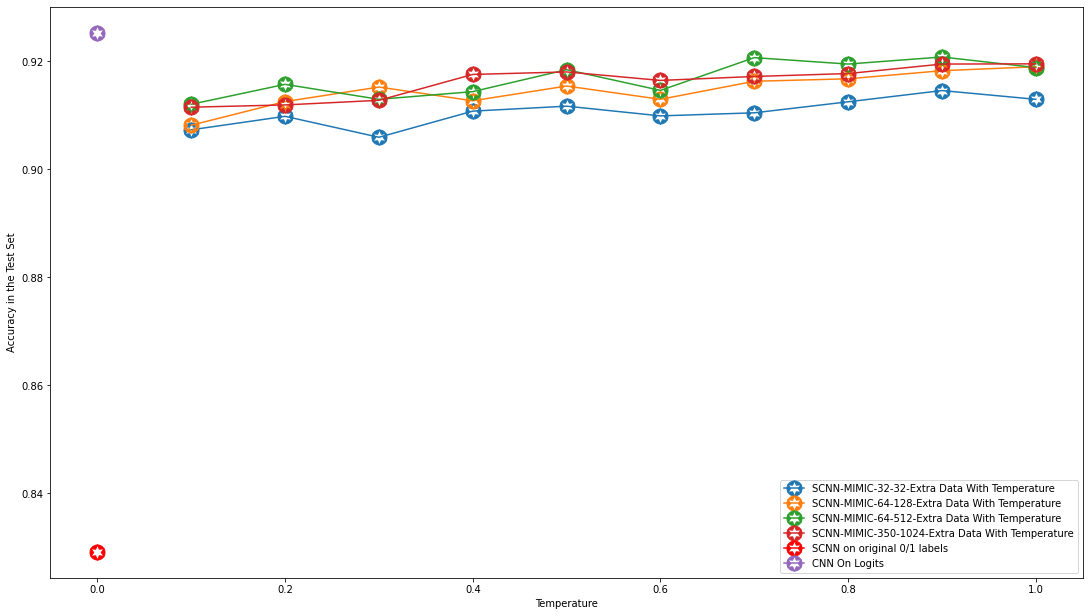

In [ ]:
import matplotlib.path as mpath
import numpy as np

star = mpath.Path.unit_regular_star(6)
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
verts = np.concatenate([circle.vertices, star.vertices[::-1, ...]])
codes = np.concatenate([circle.codes, star.codes])
cut_star = mpath.Path(verts, codes)

fig = plt.figure()
fig.set_size_inches(18.5, 10.5)

plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], [0.90734, 0.90984, 0.90596, 0.91080, 0.91172, 0.90992, 0.91049, 0.91253, 0.91461, 0.91299], label='SCNN-MIMIC-32-32-Extra Data With Temperature', marker=cut_star, markersize=15)
plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], [0.90819, 0.91257, 0.91526, 0.91272, 0.91545, 0.91299, 0.91633, 0.91679, 0.91829, 0.91902], label='SCNN-MIMIC-64-128-Extra Data With Temperature', marker=cut_star, markersize=15)
plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], [0.91207, 0.91576, 0.91299, 0.91441, 0.91848, 0.91464, 0.92071, 0.91952, 0.92083, 0.91887], label='SCNN-MIMIC-64-512-Extra Data With Temperature', marker=cut_star, markersize=15)
plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], [0.91153, 0.91195, 0.91280, 0.91760, 0.91806, 0.91649, 0.91722, 0.91776, 0.91952, 0.91956], label='SCNN-MIMIC-350-1024-Extra Data With Temperature', marker=cut_star, markersize=15)


plt.plot(0, 0.82916, marker=cut_star, markersize=15, color="red" ,label='SCNN on original 0/1 labels')
plt.plot(0, 0.92528, marker=cut_star, markersize=15, label='CNN On Logits')

plt.xlabel('Temperature');
plt.ylabel('Accuracy in the Test Set');
plt.legend()
plt.show()

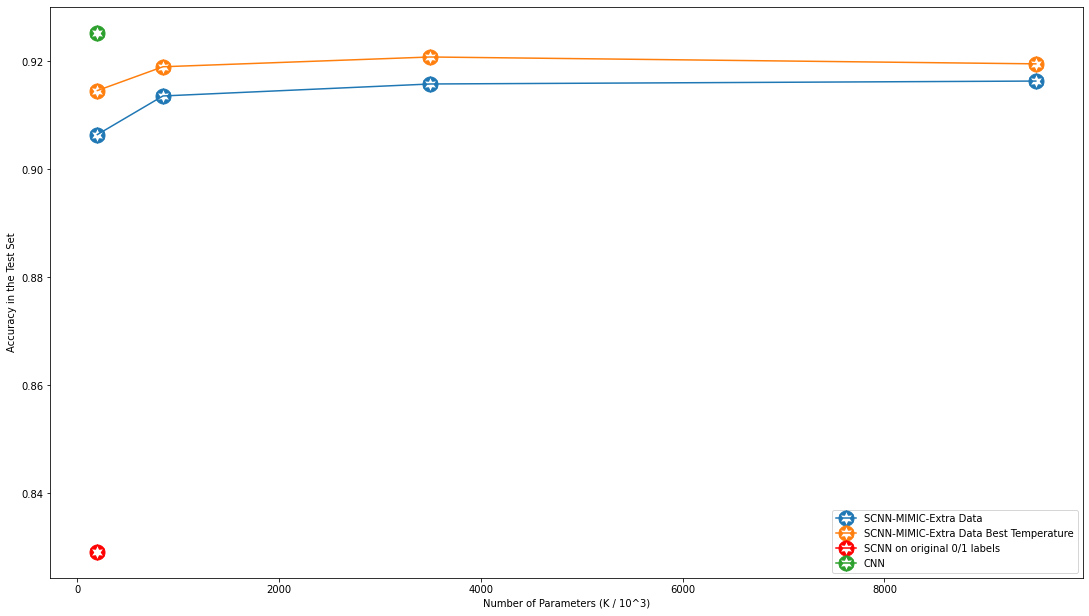

In [ ]:
import matplotlib.path as mpath
import numpy as np

star = mpath.Path.unit_regular_star(6)
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
verts = np.concatenate([circle.vertices, star.vertices[::-1, ...]])
codes = np.concatenate([circle.codes, star.codes])
cut_star = mpath.Path(verts, codes)

fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
plt.plot([200, 850, 3500, 9500 ], [0.90646, 0.91361, 0.91583, 0.91637], label='SCNN-MIMIC-Extra Data', marker=cut_star, markersize=15)
plt.plot([200, 850, 3500, 9500 ], [0.91461, 0.91902, 0.92083, 0.91956], label='SCNN-MIMIC-Extra Data Best Temperature', marker=cut_star, markersize=15)
plt.plot(200, 0.82916, marker=cut_star, markersize=15, color="red" ,label='SCNN on original 0/1 labels')
plt.plot(200, 0.92528, marker=cut_star, markersize=15, label='CNN')

plt.xlabel('Number of Parameters (K / 10^3)');
plt.ylabel('Accuracy in the Test Set');
plt.legend()
plt.show()

##### Acccuracy Results Lowering - SGD

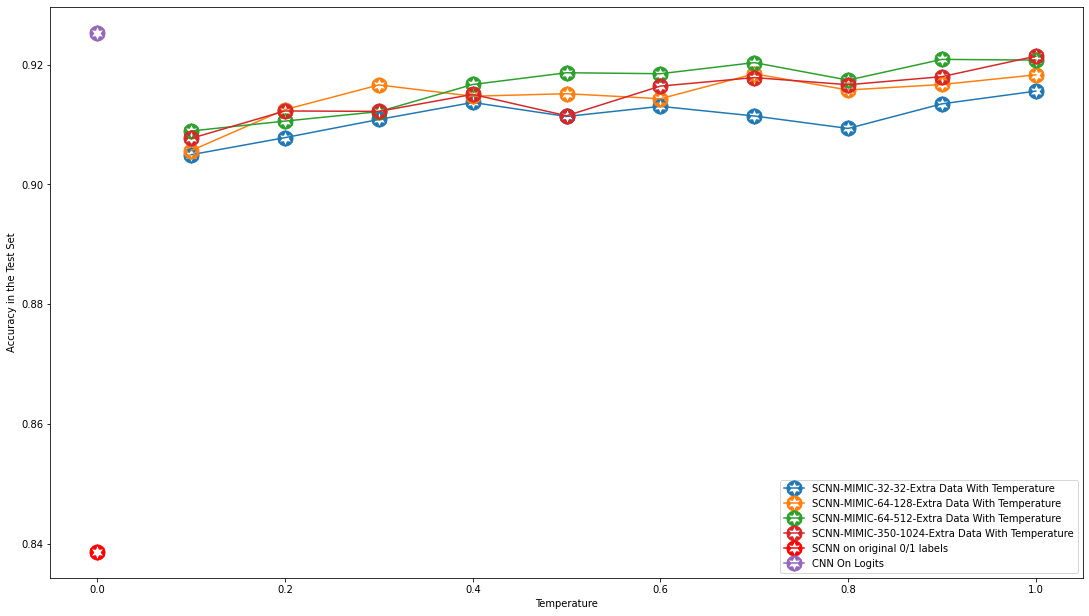

In [ ]:
import matplotlib.path as mpath
import numpy as np

star = mpath.Path.unit_regular_star(6)
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
verts = np.concatenate([circle.vertices, star.vertices[::-1, ...]])
codes = np.concatenate([circle.codes, star.codes])
cut_star = mpath.Path(verts, codes)

fig = plt.figure()
fig.set_size_inches(18.5, 10.5)

plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], [0.90496, 0.90781, 0.91084, 0.91368, 0.91134, 0.91303, 0.91142, 0.90934, 0.91345, 0.91557], label='SCNN-MIMIC-32-32-Extra Data With Temperature', marker=cut_star, markersize=15)
plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], [0.90565, 0.91249, 0.91660,0.91472,0.91514,0.91430,0.91845,0.91576,0.91668,0.91829], label='SCNN-MIMIC-64-128-Extra Data With Temperature', marker=cut_star, markersize=15)
plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], [0.90892, 0.91057,0.91215, 0.91668,0.91864,0.91848,0.92033,0.91741,0.92087,0.92075], label='SCNN-MIMIC-64-512-Extra Data With Temperature', marker=cut_star, markersize=15)
plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], [0.90769,0.91226,0.91219,0.91503,0.91146,0.91641,0.91783,0.91664,0.91799,0.92140], label='SCNN-MIMIC-350-1024-Extra Data With Temperature', marker=cut_star, markersize=15)


plt.plot(0, 0.83866, marker=cut_star, markersize=15, color="red" ,label='SCNN on original 0/1 labels')
plt.plot(0, 0.92528, marker=cut_star, markersize=15, label='CNN On Logits')

plt.xlabel('Temperature');
plt.ylabel('Accuracy in the Test Set');
plt.legend()
plt.show()

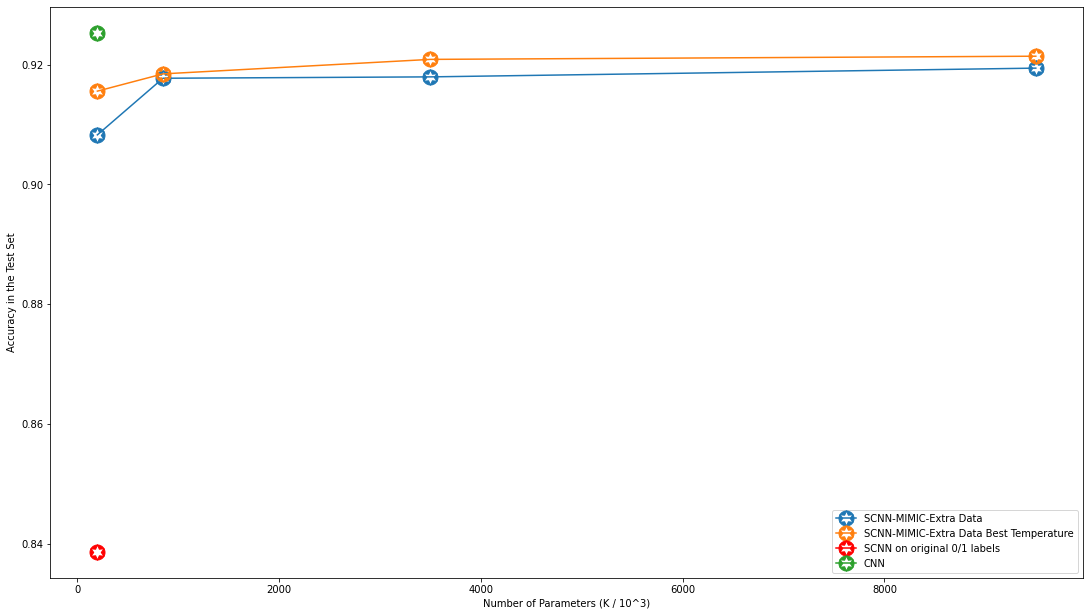

In [ ]:
import matplotlib.path as mpath
import numpy as np

star = mpath.Path.unit_regular_star(6)
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
verts = np.concatenate([circle.vertices, star.vertices[::-1, ...]])
codes = np.concatenate([circle.codes, star.codes])
cut_star = mpath.Path(verts, codes)

fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
plt.plot([200, 850, 3500, 9500 ], [0.90827, 0.91772, 0.91795, 0.91941], label='SCNN-MIMIC-Extra Data', marker=cut_star, markersize=15)
plt.plot([200, 850, 3500, 9500 ], [0.91557, 0.91845, 0.92087, 0.92140], label='SCNN-MIMIC-Extra Data Best Temperature', marker=cut_star, markersize=15)
plt.plot(200, 0.83866, marker=cut_star, markersize=15, color="red" ,label='SCNN on original 0/1 labels')
plt.plot(200, 0.92528, marker=cut_star, markersize=15, label='CNN')

plt.xlabel('Number of Parameters (K / 10^3)');
plt.ylabel('Accuracy in the Test Set');
plt.legend()
plt.show()

##### Learning Curves Lowering - SGD

In [ ]:
# Curves for Temperature 0.1
loss_train_32_32 = [0.3876448189264757, 0.18269264734220264, 0.14396704825394044, 0.12408442703394611, 0.11122722545636542, 0.10200776645826291, 0.0939626821095122, 0.08807581468727574, 0.08303691514072471, 0.07769954065179195, 0.07392519627060956, 0.07021829226820993, 0.06651587749185767, 0.06295113976036013, 0.060510981123007686, 0.05739630106350845, 0.055174490864654, 0.05234735816299961, 0.050773790951316664, 0.04851093411520246, 0.047370874345132284]
loss_test_32_32 = [0.21792373016039107, 0.16434335420237553, 0.1581111602902573, 0.13320728814840818, 0.12610092410257495, 0.12554140395684854, 0.1268719528350338, 0.13064212019897536, 0.1260284288713434, 0.13560102534541912, 0.13157350077782, 0.13534849053084202, 0.14074175583980936, 0.14115191564929414, 0.1447988868399927, 0.1443050492214066, 0.1501129232398563, 0.15785991348949666, 0.15658714085217235, 0.1631713409671478, 0.16325898106454567]
acc_train_32_32 = [0.8846421779956092, 0.9433472031306985, 0.9539237098307085, 0.9596826577263794, 0.9635023440566488, 0.9662653211033378, 0.9689953495366557, 0.9705109860098355, 0.9721419426472085, 0.9740106000402989, 0.975086137101666, 0.9761852088931221, 0.97754080921696, 0.9787410803359026, 0.979953118822134, 0.9808898009903414, 0.9816593865908535, 0.9828008208868183, 0.9833609474117596, 0.9842529135981849, 0.9847047803727975]
acc_test_32_32 =  [0.9342257618018688, 0.9484500174054348, 0.9503610193164367, 0.9573084056061508, 0.9603114085665098, 0.959831304680774, 0.960772684900516, 0.9604526156255905, 0.9613939958773156, 0.9593135455423252, 0.9616952375365456, 0.9603773051947915, 0.960772684900516, 0.9616010995326951, 0.9600007530941015, 0.9607915125055505, 0.9605279260457286, 0.9594453387669057, 0.9601419601318603, 0.9595206491657217, 0.9594076835568367]

loss_train_64_128 = [0.3428613197158668, 0.1566470739003183, 0.1253156420860801, 0.10830110773362674, 0.0956672064134748, 0.08737392468619261, 0.07950829269420832, 0.07327467788372682, 0.06652420175168003, 0.06224296148482404, 0.05756628448071884, 0.053233354813455494, 0.05022711465405076, 0.046873172106388215, 0.0449333334272874, 0.042586624713350264, 0.04012498939841382, 0.03844826166221818, 0.03720426477878391, 0.03565085317447565, 0.03466960967853145, 0.03325072953733965]
loss_test_64_128 =[0.18039490647535236, 0.14977568031486307, 0.13793008782157026, 0.12260999555607216, 0.12366523434253854, 0.1234035017696268, 0.12043489333127257, 0.1259618759296532, 0.13048715318829765, 0.1317380170505758, 0.13668409088324365, 0.14228418288640549, 0.1447089091217577, 0.1478746139380769, 0.15208327493467444, 0.15512311183827893, 0.15442776787893428, 0.16947640855912932, 0.16959206645435906, 0.17632604362334464, 0.17241486826602276, 0.17720566729259582]
acc_train_64_128 =[0.8958258806728826, 0.9502452318596498, 0.9593861201555398, 0.9643237060606631, 0.9681645736415037, 0.9706404270096131, 0.9734551804620487, 0.9754438649671455, 0.9777526217664374, 0.9791905936377308, 0.9809039218236814, 0.9824878090098543, 0.9835374578705927, 0.9849401276512416, 0.9855708583563495, 0.9866252141660233, 0.9875077664601887, 0.988369137499294, 0.9888045299644155, 0.9895129252725321, 0.9899130156436426, 0.990480202585815]
acc_test_64_128 =[0.9438749093713898, 0.9518295725091278, 0.9560751974337469, 0.9602455119376668, 0.9607538572954816, 0.9622224105094946, 0.9631261355511508, 0.9617611341861494, 0.9614034097011549, 0.9630131699102827, 0.9622129966963164, 0.9634932738493236, 0.9615069615181836, 0.9608291677369416, 0.9623447899315579, 0.9611304093961716, 0.9616481685346203, 0.9611774783980968, 0.9612622026527351, 0.9611868922112751, 0.9617423065811149, 0.961073926570407]

loss_train_64_512 =  [0.3558567950682541, 0.16020138702312137, 0.1258432316267627, 0.10808063674366535, 0.09510297926210391, 0.0858443965494488, 0.07786391784966182, 0.07141261570486816, 0.06494520430932364, 0.05989336492627539, 0.05543087165444798, 0.05164722172191344, 0.04788607665713269, 0.04481626284111413, 0.04168786847940748, 0.04027420756678572, 0.037797331163421606, 0.03632817296745945]
loss_test_64_512 = [0.19222071650998898, 0.15032156808774452, 0.13823639231735022, 0.1195307558767261, 0.12099132761249097, 0.1206602659486586, 0.12108549277529179, 0.11953916243441991, 0.12349950371941132, 0.12669338624803186, 0.13369066059186513, 0.1365539742177293, 0.14435222268323947, 0.14409443465721286, 0.15479927778554592, 0.1556647514283045, 0.15409526993566436, 0.16378997653413874]
acc_train_64_512 =[0.8930887918200892, 0.9494356372229245, 0.9590684013296403, 0.9642907574371921, 0.9685411292892586, 0.9708922485997927, 0.9737634853990549, 0.9760698887255623, 0.9782374371600322, 0.9796236326300678, 0.9815134712770959, 0.9828996667471315, 0.9842129045608494, 0.9855567375218873, 0.9865051870540169, 0.9873194886374334, 0.9885009319741004, 0.989145783515915]
acc_test_64_512 =[0.9406836303073808, 0.9516224688750703, 0.9562352321085232, 0.9618364445956263, 0.9615916857301778, 0.9620435482510059, 0.9618740998056954, 0.9644064126721749, 0.9622318243120119, 0.9643405160758761, 0.96268368683284, 0.9631449631668463, 0.960584408850171, 0.9635497566537661, 0.9626742730409837, 0.9621094448899487, 0.9625330659493588, 0.9618740998056954]

loss_train_350_1024 = [0.3360286501513642, 0.14651834513197606, 0.11736270737272514, 0.10044421080283228, 0.08966924427170635, 0.07971744286596934, 0.07259707526473687, 0.06534983087082415, 0.05953863752279258, 0.05484076090251158, 0.05043172665322474, 0.04567820715856303, 0.043706620163508424, 0.04035201600767658, 0.0380385000556652, 0.036740405647125114, 0.03475522634778762, 0.033935912472723, 0.03190487190078621, 0.03158336017040801, 0.029681294792604562]
loss_test_350_1024 =[0.16774060669393032, 0.14616523541265533, 0.12768282540095474, 0.11678011743257043, 0.12269465943749028, 0.12175829511080793, 0.12017386423942156, 0.12276137797632478, 0.1265244956322854, 0.14136643039986568, 0.12773845592924146, 0.14202672324843427, 0.14663702139606244, 0.15192553725172545, 0.15424764215874937, 0.173555994646233, 0.170553500050897, 0.17062550786173294, 0.1853558906723402, 0.184478700836412, 0.1788135540864185]
acc_train_350_1024 =[0.8959011917997403, 0.9531894263219629, 0.9615277803893809, 0.9668160337360192, 0.9698214184839944, 0.9731798241485136, 0.9753050100728635, 0.9781103496307947, 0.9800754994058026, 0.9818547248285954, 0.9833797751962796, 0.9851284054739968, 0.9862486585205129, 0.9873265490535422, 0.988465629883456, 0.9888374785833977, 0.9896141246011408, 0.990127181668149, 0.9910873985642008, 0.9910097339623142, 0.9917793195639486]
acc_test_350_1024 =[0.9487795005154217, 0.9534581603339511, 0.9593229592909762, 0.9628437214862943, 0.9611680646275627, 0.9624483417379257, 0.9636909637021858, 0.9632579287970533, 0.9639639639319809, 0.9623542037553973, 0.9646699991426578, 0.9627589972316559, 0.9633897220216338, 0.9638604121581573, 0.9632202735550013, 0.9604808570331422, 0.962269479532742, 0.9608385815501198, 0.9601984429789467, 0.9610645128105338, 0.9616858237228062]


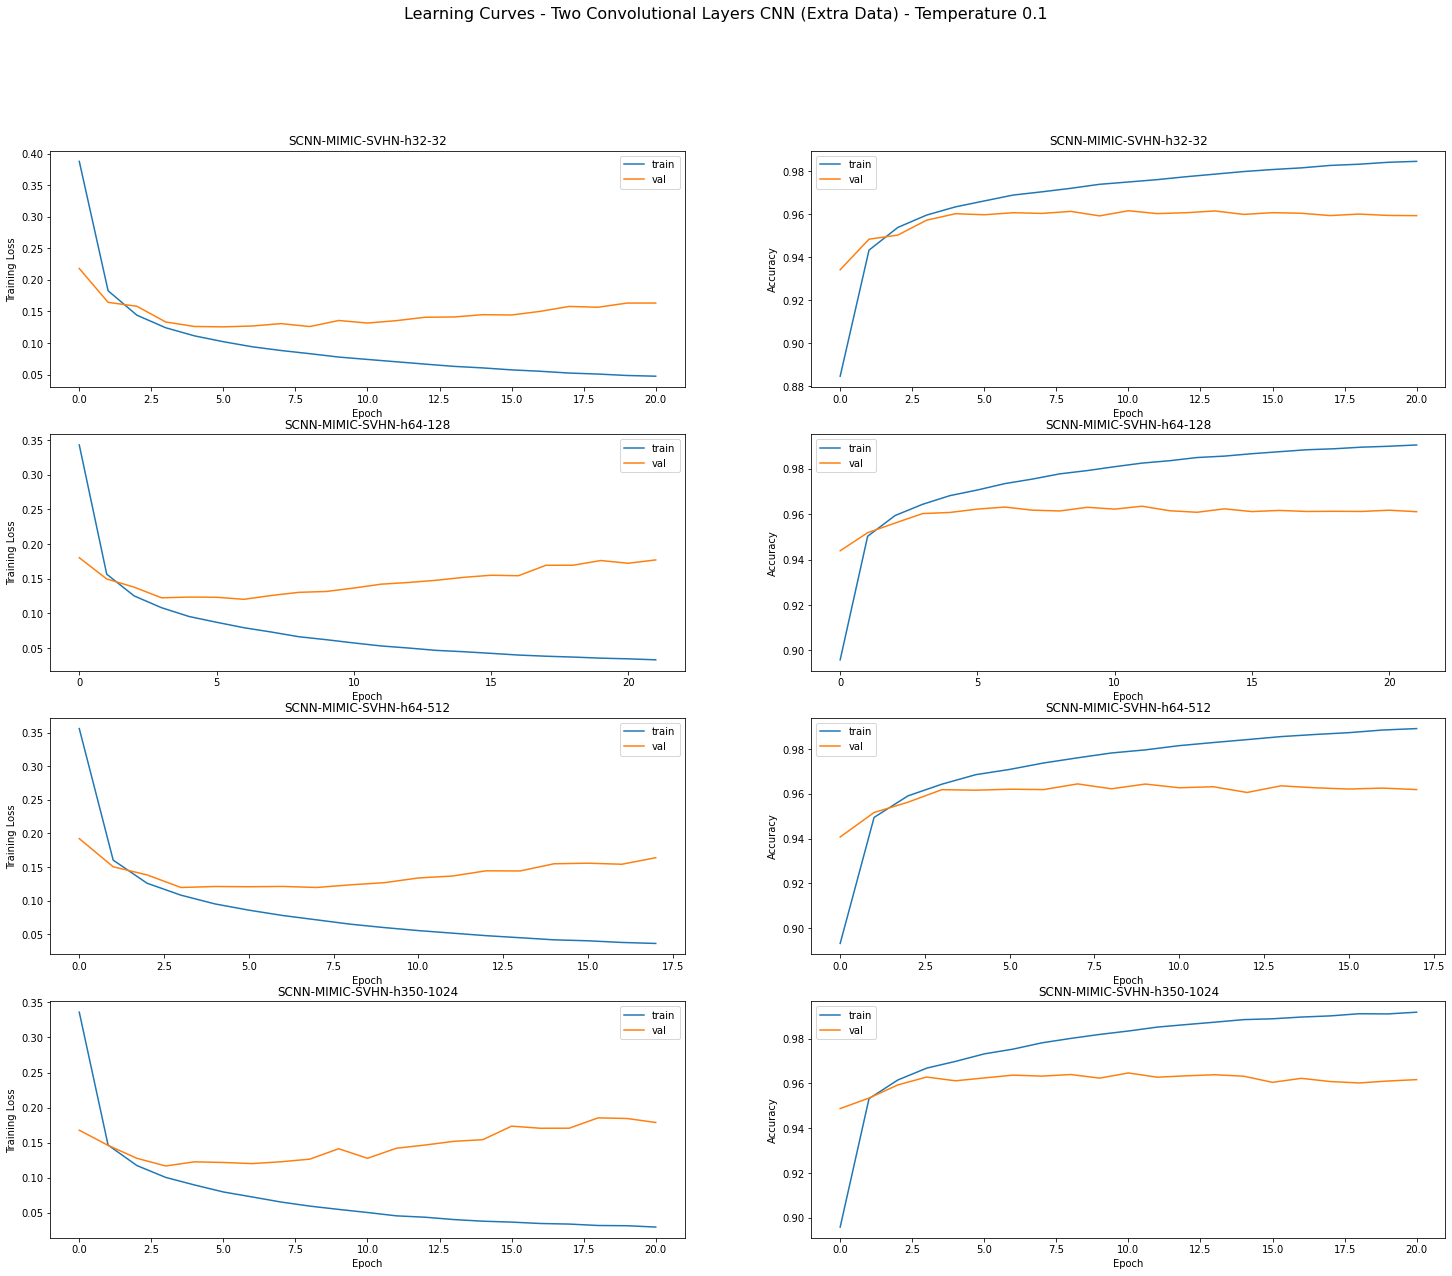

In [ ]:
fig = plt.figure()
fig.suptitle('Learning Curves - Two Convolutional Layers CNN (Extra Data) - Temperature 0.1', fontsize=16)
fig.set_size_inches(25, 20)

plt.subplot(4, 2, 1)
plt.plot(loss_train_32_32, label='train');
plt.plot(loss_test_32_32, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h32-32')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 2)
plt.plot(acc_train_32_32, label='train');
plt.plot(acc_test_32_32, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h32-32')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 3)
plt.plot(loss_train_64_128, label='train');
plt.plot(loss_test_64_128, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-128')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 4)
plt.plot(acc_train_64_128, label='train');
plt.plot(acc_test_64_128, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-128')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 5)
plt.plot(loss_train_64_512, label='train');
plt.plot(loss_test_64_512, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-512')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 6)
plt.plot(acc_train_64_512, label='train');
plt.plot(acc_test_64_512, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-512')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 7)
plt.plot(loss_train_350_1024, label='train');
plt.plot(loss_test_350_1024, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h350-1024')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 8)
plt.plot(acc_train_350_1024, label='train');
plt.plot(acc_test_350_1024, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h350-1024')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

In [ ]:
# Curves for Temperature 0.2
loss_train_32_32 = [0.3942860735634788, 0.186008877406816, 0.14884041076543897, 0.1283463031766716, 0.11466178086892295, 0.1051469175830463, 0.09706264914805858, 0.09075452131192467, 0.08483787672530188, 0.07991030127356596, 0.07562269939868341, 0.07163161787209021, 0.06834615038356562, 0.06500761250084018, 0.06235513966239134, 0.05981445666112554, 0.057812135707078986, 0.055937493035076606, 0.053698052879973986, 0.05245434997209712, 0.05092931484627403, 0.04952183542870095, 0.0484295458024941]
loss_test_32_32 =[0.22380590337983905, 0.17181183466505456, 0.16019626576458532, 0.13527044062219892, 0.1327461296959735, 0.13054371801421505, 0.13203953910180552, 0.12692701546147658, 0.12719345296104353, 0.131830397531711, 0.12956235403132618, 0.1321546250802649, 0.1344460874852866, 0.1351743414451677, 0.13840272404424692, 0.14147893357975158, 0.1438205061654679, 0.14878914039868704, 0.1550179226039113, 0.1517538225497493, 0.1513714687844135, 0.15733617795774285, 0.16076371840586895]
acc_train_32_32 = [0.8833054054551691, 0.9424364091619978, 0.9527563873240148, 0.9590307457707004, 0.9629633987890119, 0.9659358349168827, 0.9684869994140943, 0.9709251972198971, 0.9729986067418671, 0.9742530077359741, 0.9758180671365049, 0.9773737126492646, 0.9783504038514409, 0.9797507201615498, 0.9808309641707303, 0.9818900269237286, 0.9827678722700806, 0.9835774669101727, 0.9843423455628715, 0.984937774177335, 0.985544970157965, 0.9859827160947489, 0.9864439967616214]
acc_test_32_32 = [0.9334820714355502, 0.9467461191498123, 0.9503704331402759, 0.9576943715093581, 0.9586263379479049, 0.9598783736826992, 0.959200579858252, 0.9598407184726302, 0.9617140651735632, 0.9608009263080678, 0.9611209956043153, 0.9616105133245514, 0.9622788933139372, 0.9615822719495438, 0.9610550989653726, 0.9622035829156823, 0.9615446167394748, 0.9593135454996812, 0.9610927541967635, 0.9610833404161295, 0.9617987894074406, 0.9608385815506809, 0.960885650509401]

loss_train_64_128 = [0.3225298341701528, 0.15107259190399241, 0.12183609503162082, 0.10578854977237286, 0.09405086270757403, 0.0852776231438877, 0.07803149368616273, 0.07149462825330852, 0.0655378211998258, 0.061911094769973786, 0.05752713530172777, 0.05408922289206986, 0.05117872466287252, 0.04870314883257264, 0.04638156034992935, 0.04451842750336473]
loss_test_64_128 =[0.18025786221466158, 0.14354404679621424, 0.12332823747376381, 0.11999684297361901, 0.1202507237372257, 0.11432852828931733, 0.12110197579700098, 0.1205201176398966, 0.13136715420297537, 0.12844831956254688, 0.13140803329933523, 0.12737389044496503, 0.13821492674499386, 0.13288351643522245, 0.13855770739265835, 0.14565281422849674]
acc_train_64_128 =[0.9028251087349315, 0.9528764144337768, 0.961080620559215, 0.9661664752486357, 0.9694613371457306, 0.9725043774627458, 0.974977877354704, 0.9772136764999227, 0.9795342006631368, 0.9808521454302792, 0.9825937152840319, 0.9841846628863139, 0.9853519853885188, 0.9862463050466062, 0.9873006608540357, 0.9879384519786191]
acc_test_64_128 =[0.9440161164304707, 0.9548137479070963, 0.9616010995001509, 0.9623730313391097, 0.9616293409402469, 0.9651783444892504, 0.9637192051097375, 0.9646135163595374, 0.9629378594576006, 0.9632955839858003, 0.9633708944053772, 0.9646982405283264, 0.9631637907505588, 0.9646135163488764, 0.964152240003648, 0.9627025144058914]

loss_train_64_512 =  [0.32831341065022424, 0.15150727781481535, 0.12145512287501097, 0.103361155565565, 0.09179735611984277, 0.08316859420230213, 0.07506835605121033, 0.06835027601761862, 0.06302382571632303, 0.058166461012141034, 0.05376790876383545, 0.05051661393443029, 0.04744173623184498, 0.04506132465809869, 0.04323739507309496, 0.04123860198360255, 0.03994218741206556, 0.038528327270339294]
loss_test_64_512 = [0.17912537601757844, 0.13810444961074025, 0.12555719015116631, 0.11693683728016424, 0.11382684775075363, 0.11698143045844256, 0.12120818278325923, 0.11719883540128762, 0.1194084081230847, 0.13630663863946682, 0.12723379992510764, 0.13581690477538164, 0.13870377529077282, 0.1400054855468754, 0.14174511159764852, 0.13751923193271898, 0.14522003408914574, 0.14632424787502607]
acc_train_64_512 =[0.9012129798686118, 0.9522786323487733, 0.9609700073417129, 0.9664347711471842, 0.9702897595647314, 0.9730786248165382, 0.9759404477224181, 0.9784751379123829, 0.9803626230832599, 0.9820900721104061, 0.984158774685685, 0.9853402180245965, 0.9867970176781653, 0.9877807693009393, 0.9885244667008226, 0.9894093724688945, 0.9899318434270403, 0.9905366859326417]
acc_test_64_512 =[0.9456352904421157, 0.956611784166008, 0.9612622026095299, 0.9629472732820009, 0.9643122746251191, 0.9639639639751861, 0.9642181365999467, 0.9658561382918145, 0.9648488614118077, 0.9624765831774604, 0.9646982405715316, 0.963888653544387, 0.9630508251310128, 0.9628437214862943, 0.9641522400042091, 0.9649335856238019, 0.9639827915908816, 0.9614316511087067]
                  
loss_train_350_1024 = [0.35280423272168443, 0.1510401782116715, 0.12167429258364496, 0.10593026175158234, 0.09333873011946572, 0.08503885125397015, 0.0779474525710905, 0.07100227838875377, 0.06611436773569551, 0.06082345754937236, 0.056886650943828825, 0.05374755058730416, 0.050436443416844494, 0.047750410619096524, 0.04669050172703852, 0.043603619706313004, 0.0427382085576151]
loss_test_350_1024 =[0.18567399042398075, 0.13819838336984347, 0.1260754119173861, 0.11779446419485666, 0.12222887824042185, 0.12300517349279097, 0.11369111499782326, 0.12178404904902052, 0.12474455342464193, 0.12749514926806008, 0.1327664874467353, 0.130875536185833, 0.13401756359511616, 0.13998613268358895, 0.141787807724788, 0.14372320914995237, 0.14471897592315805]
acc_train_350_1024 =[0.8907635607056951, 0.952492798369913, 0.9610147233268617, 0.965749910566912, 0.9698520136290699, 0.9723655225628526, 0.9747472370195844, 0.9773784195959558, 0.9791882401660685, 0.9813157795620807, 0.9827819931090317, 0.9842152580336339, 0.9855567375218873, 0.9866652232033589, 0.9870841413589894, 0.9883479562431118, 0.9886397868695046]
acc_test_350_1024 =[0.9432724260534909, 0.9564235081482072, 0.9602172705413372, 0.9633144115908348, 0.9614787201106318, 0.9619023412239082, 0.9646323439432499, 0.9639357225356513, 0.9641710676199046, 0.9644346540903876, 0.9636721361078123, 0.9638133431349101, 0.9632202735550013, 0.9609515471376828, 0.9639545501833299, 0.9645193783130429, 0.9622977209402938]


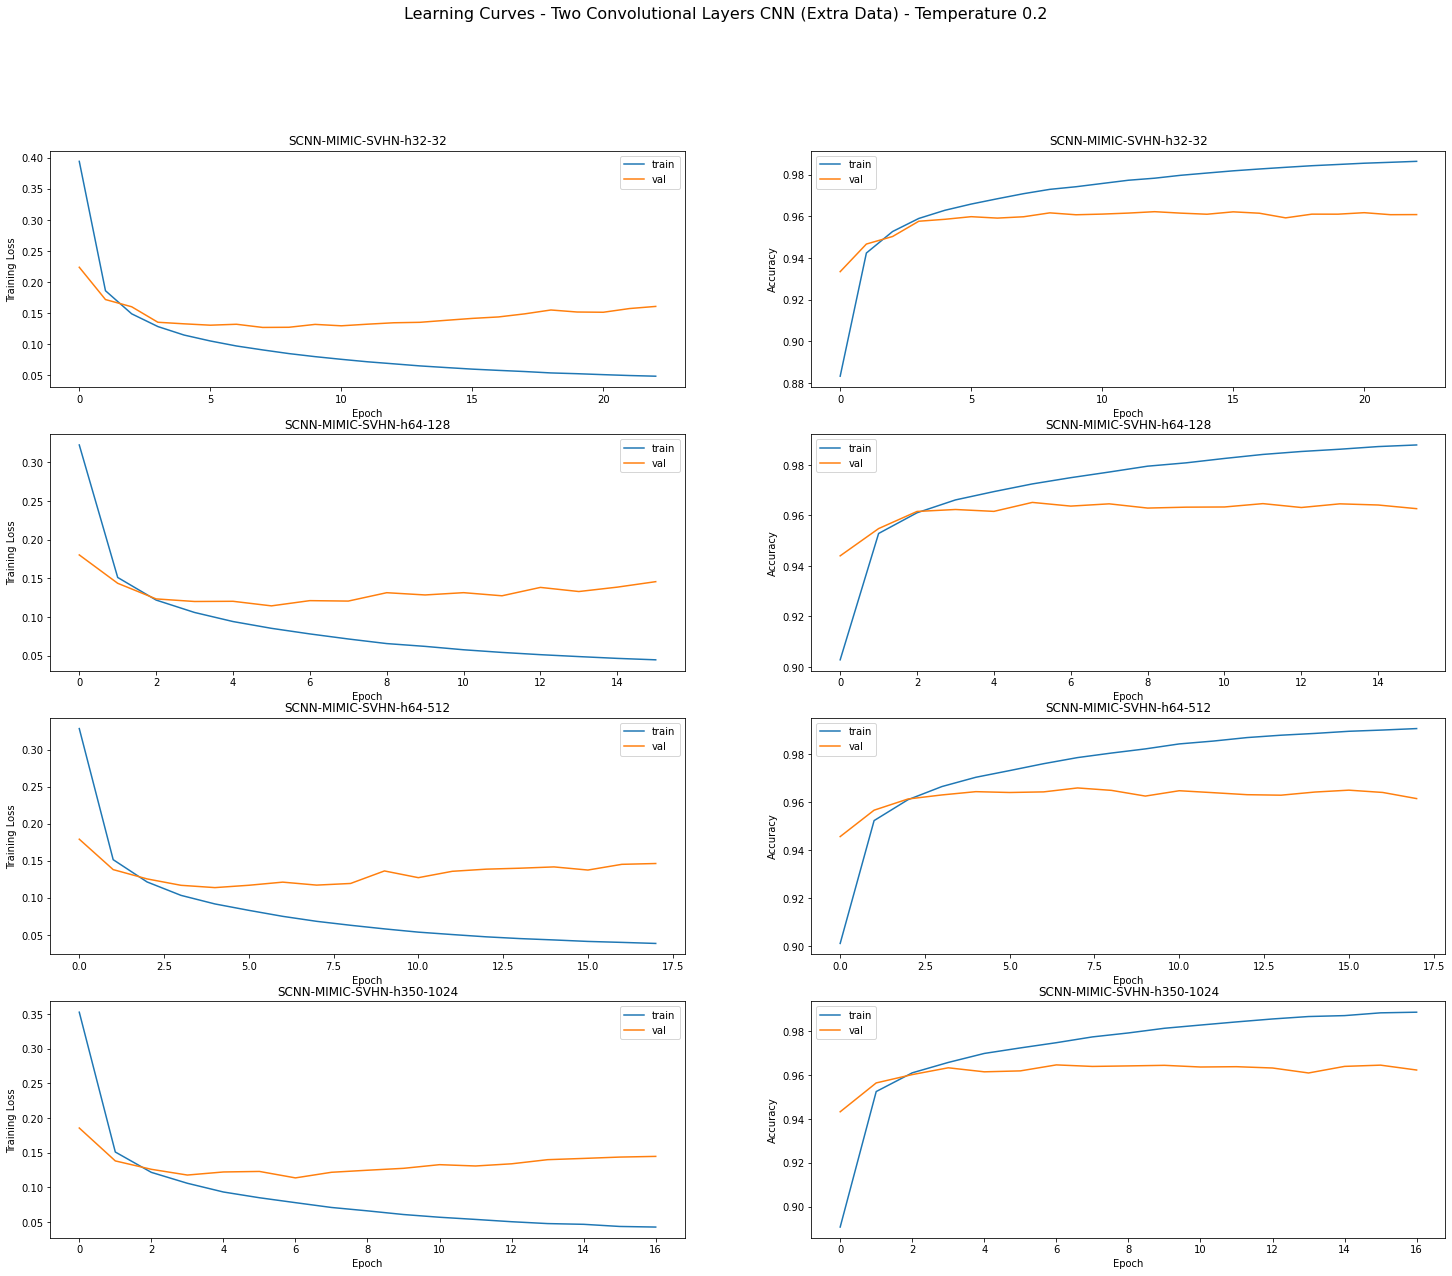

In [ ]:
fig = plt.figure()
fig.suptitle('Learning Curves - Two Convolutional Layers CNN (Extra Data) - Temperature 0.2', fontsize=16)
fig.set_size_inches(25, 20)

plt.subplot(4, 2, 1)
plt.plot(loss_train_32_32, label='train');
plt.plot(loss_test_32_32, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h32-32')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 2)
plt.plot(acc_train_32_32, label='train');
plt.plot(acc_test_32_32, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h32-32')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 3)
plt.plot(loss_train_64_128, label='train');
plt.plot(loss_test_64_128, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-128')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 4)
plt.plot(acc_train_64_128, label='train');
plt.plot(acc_test_64_128, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-128')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 5)
plt.plot(loss_train_64_512, label='train');
plt.plot(loss_test_64_512, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-512')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 6)
plt.plot(acc_train_64_512, label='train');
plt.plot(acc_test_64_512, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-512')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 7)
plt.plot(loss_train_350_1024, label='train');
plt.plot(loss_test_350_1024, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h350-1024')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 8)
plt.plot(acc_train_350_1024, label='train');
plt.plot(acc_test_350_1024, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h350-1024')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

In [ ]:
# Curves for Temperature 0.3
loss_train_32_32 = [0.37441653732462266, 0.17752867637847178, 0.1446406181719402, 0.1264538442924631, 0.11514646751054286, 0.10692647291703726, 0.09971698913836505, 0.09374666405272215, 0.08870630180063578, 0.0847655622966092, 0.08083652250131082, 0.07764943917690748, 0.07467297474639016, 0.07230530799009229, 0.06966252631672798, 0.06734043849144011, 0.06534219088993991, 0.0636373637207107, 0.062218403944030345, 0.060302287358961426, 0.059236870421233066, 0.05783333336357239, 0.05689226436075874, 0.05580131719374065, 0.054647882464702424, 0.05409788548460458, 0.053153474668862444, 0.05276132261776593, 0.051812117177290756, 0.05100838678218255, 0.05006841086607992, 0.049868659072192824, 0.049405068115897795]
loss_test_32_32 =[0.2122222573218487, 0.1636033749258757, 0.1467458704131046, 0.14228099200025227, 0.14373485019919785, 0.12945358725760633, 0.12759757485717182, 0.12447396935079465, 0.12986557905331897, 0.1299565558694638, 0.13034018497434574, 0.13209354278918733, 0.12842548786658198, 0.13824945130437827, 0.13172701523999186, 0.1300482117786726, 0.13501623375508137, 0.1407637486091804, 0.1365466081184274, 0.14178903452596917, 0.14163047546467683, 0.1404820872231898, 0.14003504153150945, 0.1461027526326598, 0.14719593161840938, 0.15091394182900147, 0.1441219366156643, 0.14916401269059335, 0.14782108080717943, 0.14991071754651733, 0.15037791452622898, 0.15055420736327046, 0.1563866450698508]
acc_train_32_32 =[0.889123190180551, 0.9457124432779392, 0.955138101782991, 0.9605958051678646, 0.9643142921684031, 0.9667336621885637, 0.968837666864587, 0.9713088132803943, 0.9726573531903677, 0.974170636190763, 0.9756580309905296, 0.9767241541618813, 0.9780162107160504, 0.978842279667878, 0.9800354903684672, 0.9809815864266901, 0.9817794137017377, 0.982574887499512, 0.9831561952817578, 0.9840152128469564, 0.984617701878651, 0.9849895505797148, 0.985321390242321, 0.9860015438781466, 0.9864604710699904, 0.9866746370922522, 0.9872653587611468, 0.9873642046192156, 0.9877478206819572, 0.9881149624374521, 0.9885244667019448, 0.9884044395888161, 0.9888727806706754]
acc_test_32_32 =[0.9356190045637609, 0.9499091567956086, 0.955218541425999, 0.9564046805431727, 0.9562069907116325, 0.9603019947634314, 0.9617046513710459, 0.9628813766750413, 0.9606785468641214, 0.9615728580925992, 0.9608856505413841, 0.9617611341861494, 0.9629566871165013, 0.9602360981564716, 0.9632202735437791, 0.9635968256876744, 0.9631920321794325, 0.9627495834072556, 0.962542479751876, 0.9618929273781858, 0.9626648591846003, 0.9624201003191518, 0.9639168949732608, 0.9615916857082947, 0.9611115818124591, 0.9604526156255905, 0.9626742729977785, 0.9621753415075694, 0.9617987894068795, 0.9628625490374626, 0.9606314778621962, 0.9615069615288446, 0.9618364445737433]

loss_train_64_128 = [0.3466636916523659, 0.16094590752082152, 0.1283981931918136, 0.11107632143090257, 0.09915219350038613, 0.09110319766387487, 0.08370224850773508, 0.07799694227226942, 0.07351567132389263, 0.06910932906341075, 0.06554234310410313, 0.06264818726726139, 0.05969647018617407, 0.05737145742023747, 0.05533117764850484, 0.053436440069246575, 0.05233826252131033, 0.05045507637523284, 0.04988537791098354, 0.04837305403364487]
loss_test_64_128 =[0.1953783492086226, 0.14921905872989064, 0.13722949343112828, 0.12426730209027169, 0.11737430412788878, 0.12019827509754136, 0.11715459046069295, 0.1165832442868411, 0.12121889309165709, 0.11807751008721179, 0.12279613222508655, 0.12335501513053174, 0.12234449609566317, 0.1296867009046489, 0.12613877934825188, 0.12915491887925343, 0.1312286144811362, 0.13444571748768808, 0.13308406579632734, 0.13898665474944424]
acc_train_64_128 =[0.8966660704513169, 0.9506170805618359, 0.9597462014994148, 0.9653074576811926, 0.9688823828430025, 0.9715982904362471, 0.9742600681543274, 0.9763334776785418, 0.9780067968282793, 0.9796754090313254, 0.9812781239997741, 0.9824360326085967, 0.9837916329313123, 0.9847871519191307, 0.9856344021237738, 0.9866275676376856, 0.9871618059608759, 0.9879125637779902, 0.9881173159113588, 0.9890351702972907]
acc_test_64_128 =[0.940194112619689, 0.9527991941897267, 0.956978922486064, 0.9612151336401489, 0.9639733777451591, 0.9638133431455711, 0.9639451363701516, 0.9639168949625998, 0.9641616538173874, 0.9661667937748838, 0.9650936202665952, 0.9641616538173874, 0.9655831379868312, 0.9643687574940889, 0.9644628954872784, 0.9647735509916696, 0.9641804814224219, 0.9646041025250371, 0.964792378553499, 0.9637097912965593]

loss_train_64_512 =  [0.30716642717974146, 0.14184594298451378, 0.11306033126206497, 0.09722011395422571, 0.0857620640821564, 0.07734081973486474, 0.07008224739316196, 0.06474613829128023, 0.05974615867195187, 0.05615503488524896, 0.053187177064527066, 0.05058368875690709, 0.04907788914639321, 0.046941553860060554, 0.04546485685102865, 0.0438539757042483, 0.043098125566445385]
loss_test_64_512 =[0.164480277284574, 0.12638025556435414, 0.12193614821930679, 0.11523435143788166, 0.12876352288851328, 0.11886336471461913, 0.11420554034972663, 0.12180879559953796, 0.11965771182789817, 0.11976861413109378, 0.11912366151694666, 0.13086066307350416, 0.12397822842676785, 0.12451206354480521, 0.1260147551350706, 0.12747806000039236, 0.12811300092626784]
acc_train_64_512 =[0.9074355619162843, 0.9556417449543724, 0.9646343644659648, 0.9694683975652061, 0.9736716999593394, 0.976561764535266, 0.9792258957294974, 0.9817864741189688, 0.9838292884958634, 0.985629695178205, 0.98668875793457, 0.9879737540692635, 0.9885597687925892, 0.9893387682864835, 0.9900259823395402, 0.99084734434131, 0.9913556944627492]
acc_test_64_512 =[0.948986604159579, 0.9600854773167568, 0.9618835135756685, 0.9646605853614626, 0.9604620294174467, 0.9627966524305028, 0.9661103109597803, 0.9651595168516718, 0.9660538281446768, 0.9646794129771582, 0.9660161729239468, 0.9635497566750881, 0.9651971721049459, 0.9654701723779462, 0.9656207932075612, 0.965536068995567, 0.9646605853614626]

loss_train_350_1024 = [0.35445951861873565, 0.15311765523091783, 0.12391949883588115, 0.108093799010076, 0.09796759869227256, 0.08939913342130545, 0.08256098174160925, 0.07738038846376032, 0.07230893520817656, 0.06911831176585603, 0.06502722578533068, 0.06215021139267811, 0.05938414953639365, 0.05656102549779457, 0.05485132654584453, 0.052965922727124595, 0.05143759396201644, 0.050691799134197836, 0.048918399095795914]
loss_test_350_1024 =[0.18943874653574785, 0.15101642595854964, 0.12485513055162507, 0.12333303207342075, 0.12031261451347464, 0.11530847083767896, 0.11869545407035019, 0.11693309181774163, 0.11834162586271593, 0.12281619635492468, 0.12884865950540214, 0.12944416713618986, 0.12641926187868752, 0.13142090395634573, 0.13175614028884322, 0.12689181880890013, 0.1288156300397116, 0.1302133201530179, 0.1349903469757809]
acc_train_350_1024 =[0.8910977538500634, 0.9527846290030392, 0.9612571310191702, 0.966124112739638, 0.9695319413315082, 0.9725914559512812, 0.9747401766090866, 0.9767241541607591, 0.9787151921352737, 0.9802496563929735, 0.9816334983891024, 0.9830549959520268, 0.9838622371159678, 0.9853119763523055, 0.9860697945888953, 0.9867405343302166, 0.9875218872957731, 0.9878019505582437, 0.9888892549846554]
acc_test_350_1024 =[0.9444868065563332, 0.9535711259854802, 0.9614881339131491, 0.9612433750263786, 0.9627872386285466, 0.9644064126828359, 0.9636533085027779, 0.9646323439325889, 0.9654042757603255, 0.9644346540797266, 0.9621753414862474, 0.9638980673469043, 0.9652913101301185, 0.9635026876305187, 0.9641051710129449, 0.9646229301407326, 0.9644158264853531, 0.965159516873555, 0.9635591704243002]


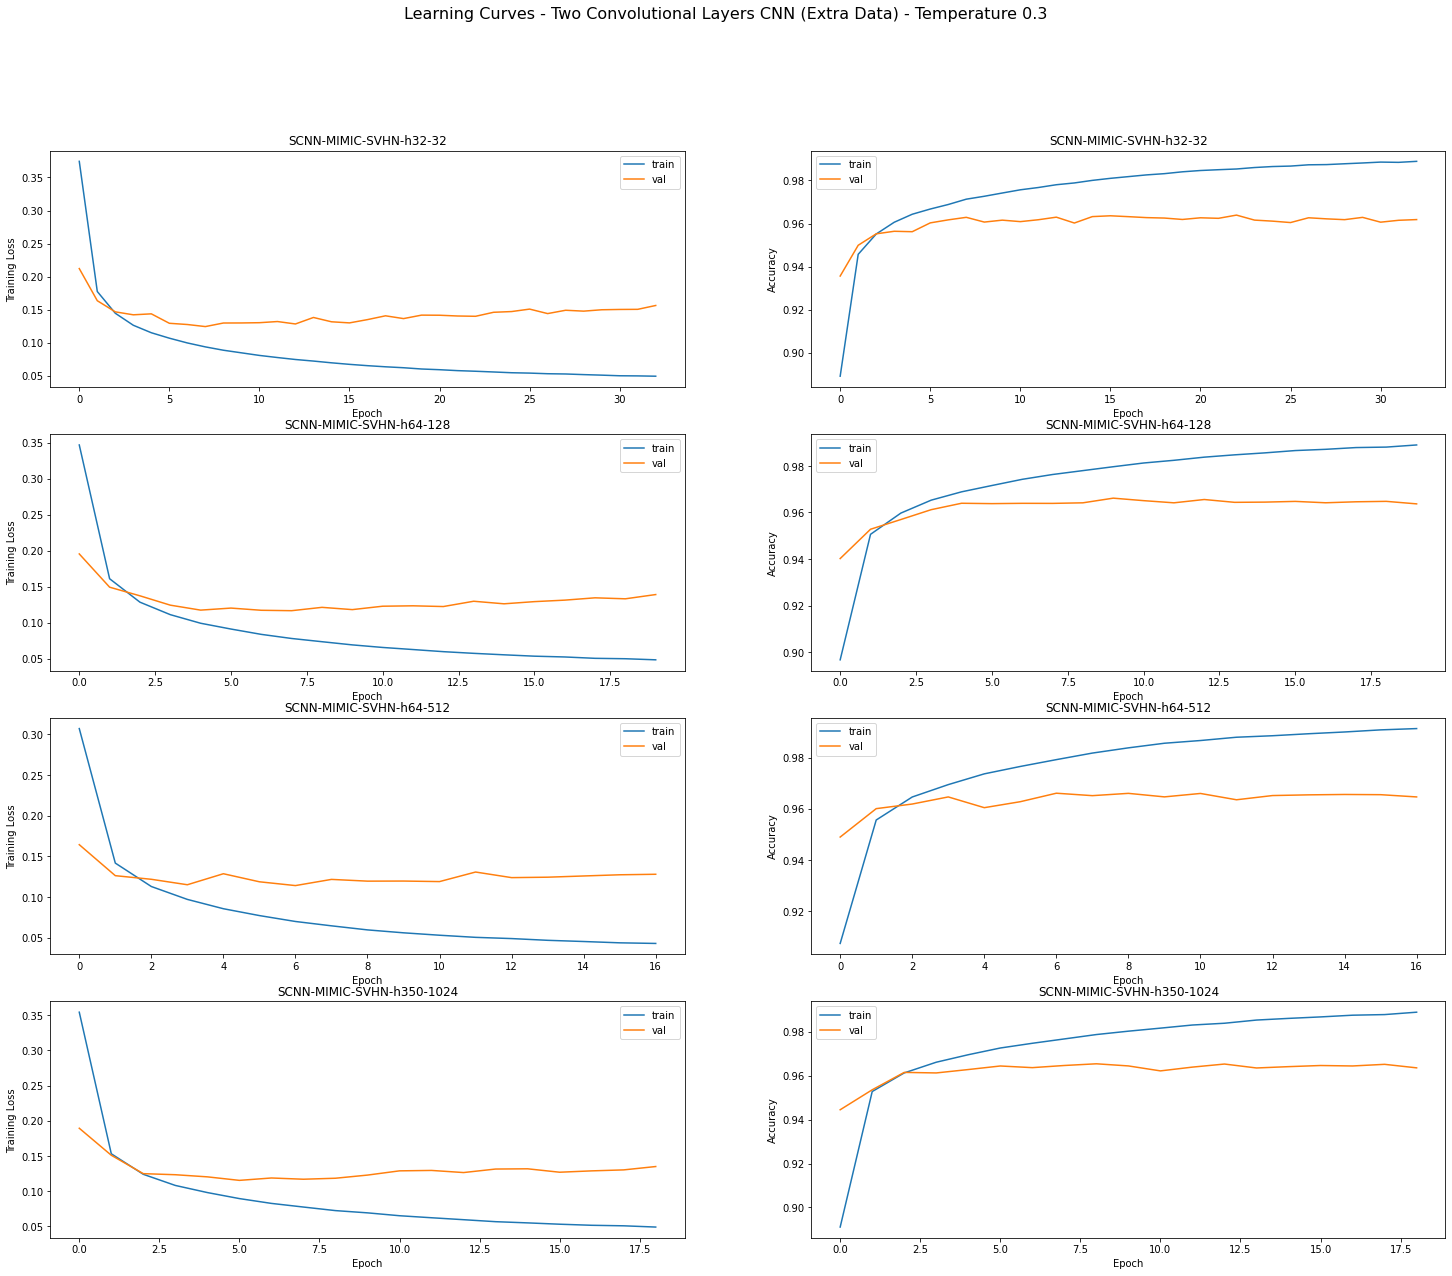

In [ ]:
fig = plt.figure()
fig.suptitle('Learning Curves - Two Convolutional Layers CNN (Extra Data) - Temperature 0.3', fontsize=16)
fig.set_size_inches(25, 20)

plt.subplot(4, 2, 1)
plt.plot(loss_train_32_32, label='train');
plt.plot(loss_test_32_32, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h32-32')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 2)
plt.plot(acc_train_32_32, label='train');
plt.plot(acc_test_32_32, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h32-32')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 3)
plt.plot(loss_train_64_128, label='train');
plt.plot(loss_test_64_128, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-128')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 4)
plt.plot(acc_train_64_128, label='train');
plt.plot(acc_test_64_128, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-128')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 5)
plt.plot(loss_train_64_512, label='train');
plt.plot(loss_test_64_512, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-512')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 6)
plt.plot(acc_train_64_512, label='train');
plt.plot(acc_test_64_512, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-512')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 7)
plt.plot(loss_train_350_1024, label='train');
plt.plot(loss_test_350_1024, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h350-1024')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 8)
plt.plot(acc_train_350_1024, label='train');
plt.plot(acc_test_350_1024, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h350-1024')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

In [ ]:
# Curves for Temperature 0.4
loss_train_32_32 = [0.3675050799322526, 0.17686815675509152, 0.14478294552915585, 0.12696004743525033, 0.11603193199135949, 0.10887333271535454, 0.10143229771313085, 0.09661539339136935, 0.09215142869966231, 0.0888635696903551, 0.08514971217771139, 0.08226193788007255, 0.07940542218604933, 0.07731741709466364, 0.07514831230302196, 0.07299861486740895, 0.07107081134921199, 0.06965507717054283, 0.06820278642457318, 0.06691401947203504, 0.06572452037447798, 0.06478815527776162, 0.0638998735865042, 0.06264453293556141]
loss_test_32_32 =[0.21232832662347886, 0.1622647953876285, 0.14596318948425102, 0.13515947209070844, 0.13881363169894692, 0.127798443373818, 0.1282201649032616, 0.12699252514211878, 0.12914978283108933, 0.13290667849931695, 0.1259334849344437, 0.1286618247431404, 0.13242677544266368, 0.12575137408127557, 0.1318931013892236, 0.13081355923234508, 0.1322837737462072, 0.13567063634185375, 0.13196782209675254, 0.13454332629275106, 0.13428788491183508, 0.1411654588600247, 0.13691856788637796, 0.13758215970982246]
acc_train_32_32 =[0.8921332818729729, 0.9471339408397415, 0.9565666597586576, 0.9621749854062243, 0.9654886750855945, 0.9676444561572646, 0.9704521491891023, 0.9716806619825804, 0.9737776062335171, 0.9749237474806619, 0.9760863630361756, 0.9775031536524089, 0.9786540018428782, 0.9796212791584056, 0.9803626230843822, 0.9813793233272605, 0.9820594769619639, 0.9828902528559937, 0.9832338598836443, 0.9842223184497427, 0.9846718317538153, 0.9849189463973038, 0.9855237889029052, 0.9859026980189556]
acc_test_32_32 =[0.9377182825677519, 0.9517730897046853, 0.9562917149236267, 0.9596618562034804, 0.9590311314561467, 0.9615916857195168, 0.9616764099421721, 0.963662722294634, 0.9628343076624549, 0.9614787200999708, 0.9646229301300716, 0.9637662741010018, 0.9625801349731672, 0.9654325171465552, 0.963248514983875, 0.9641898952356001, 0.9630884803410817, 0.9639733777670423, 0.9639168949519388, 0.9637097912858983, 0.9637756879355021, 0.9633332391958692, 0.9623542037553973, 0.9627119282510528]

loss_train_64_128 = [0.34350150972456056, 0.15887736986179374, 0.1282510968104431, 0.11252864512920518, 0.10153603596949513, 0.09357164241818922, 0.08709417381841762, 0.08222975764294764, 0.07794536112776146, 0.0739799368316243, 0.07076571902672496, 0.06794947387331021, 0.0655209066953095, 0.06275341370096406, 0.06163538681023049, 0.06017400574137508, 0.05884385060657084, 0.05745049181584864, 0.0564062352858489, 0.05520196040489818]
loss_test_64_128 =[0.1904292253955308, 0.15504901704383695, 0.12763020891998125, 0.12254180813359318, 0.12520090876136822, 0.11806953657744527, 0.1244643416159588, 0.1270607613652098, 0.11924996166258167, 0.12448951417981315, 0.12382843741208094, 0.12043716168275861, 0.12500812007923318, 0.12568698509211396, 0.12508313918824182, 0.128634810182009, 0.12931743120695352, 0.1273204232618794, 0.12934116915000074, 0.13047664401766088]
acc_train_64_128 =[0.898271138888061, 0.952076233687067, 0.9611018018176416, 0.9661994238664957, 0.9699108504464365, 0.9726008698412967, 0.9751967503225348, 0.977310168885207, 0.9788917025918623, 0.9804426411612976, 0.981819422737951, 0.9831703161184644, 0.984257620544876, 0.9857638431246737, 0.9857897313275469, 0.9868864496450963, 0.9871688663792292, 0.9877690019381393, 0.9883950256988006, 0.9888492459450754]
acc_test_64_128 =[0.9440443578273614, 0.9526485733281286, 0.9615916857082947, 0.9628907904775584, 0.9620529620641842, 0.9645758611494684, 0.963399135824151, 0.9620247206566325, 0.9650936202772562, 0.9654984137854979, 0.9647076543740489, 0.9650465512321258, 0.9645758611281464, 0.9643122746789854, 0.9652536549307105, 0.9648017924098824, 0.9639074811600826, 0.963700377504703, 0.9647735510023306, 0.9650465512214648]

loss_train_64_512 = [0.3075653858125269, 0.145431457463658, 0.11833279005341621, 0.10258302153390714, 0.09321886805339734, 0.08448833663702447, 0.07834985505151885, 0.07252783211204783, 0.06875320430909901, 0.06526696379733535, 0.06267908617278699, 0.06037000871362498, 0.05807064487593663, 0.05625878353706552, 0.055280352811608445, 0.05383353349267275, 0.05300723730220502, 0.051853987000847694, 0.0507240193600658, 0.05003545407920606]
loss_test_64_512 = [0.19073110718957928, 0.1313575899695978, 0.13064803218211038, 0.12206634713466634, 0.11730701724849531, 0.11653174692176155, 0.12293451963642923, 0.12102219257611936, 0.12019528493806868, 0.11935354736783914, 0.124729832043327, 0.12201942659173343, 0.1193044067076655, 0.123193969305772, 0.12363822548708726, 0.12459037335756123, 0.12651752072939054, 0.12116004334436216, 0.11986494633250816, 0.12085080890872688]
acc_train_64_512 =[0.9087911622356332, 0.9558017811059588, 0.9644884491510851, 0.969637847606808, 0.9729891928496072, 0.9761828554192155, 0.9787175456103026, 0.9810121815728878, 0.9827090354515918, 0.984227025397556, 0.9853543388613032, 0.9862627793549751, 0.987413627548811, 0.9883385423530963, 0.988705684107469, 0.9893505356504058, 0.9896823753118896, 0.9900989399958579, 0.9905861088588704, 0.9909391297799032]
acc_test_64_512 =[0.9435171849077174, 0.9598595460563427, 0.960245511980872, 0.9626272040283975, 0.9651783444892504, 0.966703380486384, 0.9638604121581573, 0.9665715872292594, 0.9658278968629407, 0.9676353469137087, 0.9643216884382975, 0.9664209664002055, 0.9655831379761701, 0.9654701723566241, 0.9663927250139758, 0.9659314486799695, 0.9652348272936929, 0.9663080007699985, 0.9666374838794243, 0.965950276285004]

loss_train_350_1024 = [0.3564939143790645, 0.15771278092855476, 0.12628811733276446, 0.11133744871727128, 0.10106776309769913, 0.09319117487621846, 0.08641207166000811, 0.08173555400978427, 0.0774591519317376, 0.07390483125118158, 0.07039304644319973, 0.06714544791846863, 0.06473581441829168, 0.06273559967725989, 0.06095188651880242, 0.059275384728849016, 0.05803577761111037, 0.05670272533046262, 0.05540019809549409, 0.054562422529267234, 0.053738199922365955, 0.052786718321733005, 0.052376115186380134, 0.05127515505997994, 0.050959694284289994, 0.05046056623439829, 0.049832706868557626, 0.04963527280310063]
loss_test_350_1024 =[0.18856735312190848, 0.14272409222139631, 0.13367739530146075, 0.11970325015960193, 0.11773895708114118, 0.1181779080304861, 0.12426391809361505, 0.11986937309777185, 0.11851786666626096, 0.12486479767233957, 0.12218170117074525, 0.1285005028264195, 0.12854806938954533, 0.12872206113194984, 0.12623145380563136, 0.12672970408270626, 0.1294657172625045, 0.12543590354411857, 0.12896853230868854, 0.13287223325722552, 0.1257613482781039, 0.12827280233608668, 0.1299388713188738, 0.1291496694265853, 0.13135977263263865, 0.13386051727859097, 0.12988274111422593, 0.13456877861118832]
acc_train_350_1024 =[0.8921403422879596, 0.9524927983687907, 0.9617913693423604, 0.9666018677148795, 0.9696990378992035, 0.9728785796321051, 0.9754297441293166, 0.9772136764976783, 0.9789834880338222, 0.9805509009071375, 0.9820853651648372, 0.9834550863220151, 0.9847871519213752, 0.985439063881543, 0.9863733925758438, 0.9869241052074029, 0.9878678477939636, 0.9882232221855364, 0.9888610133089977, 0.9890139890422307, 0.9896753148946585, 0.9897741607516051, 0.9900306892839869, 0.9902377948890176, 0.9905625741343927, 0.9905766949699771, 0.9908991207392011, 0.9908873533786455]
acc_test_350_1024 =[0.9440443578593445, 0.9563670253544257, 0.9595865458046645, 0.9643781712966062, 0.9651124478716296, 0.9651877582917677, 0.9630508250990297, 0.965573724205636, 0.9659973452975902, 0.9634179634291855, 0.9644628955086004, 0.9650653788697044, 0.965197172115607, 0.9647170681872271, 0.9660444143421595, 0.9650936202452731, 0.9646982405715316, 0.96685400132666, 0.9648676890168422, 0.9650371374728137, 0.965649034615113, 0.9654889999829808, 0.9659785177032167, 0.9653289653295264, 0.966025586715803, 0.9655925518213315, 0.9658090692472452, 0.9644534817060831]


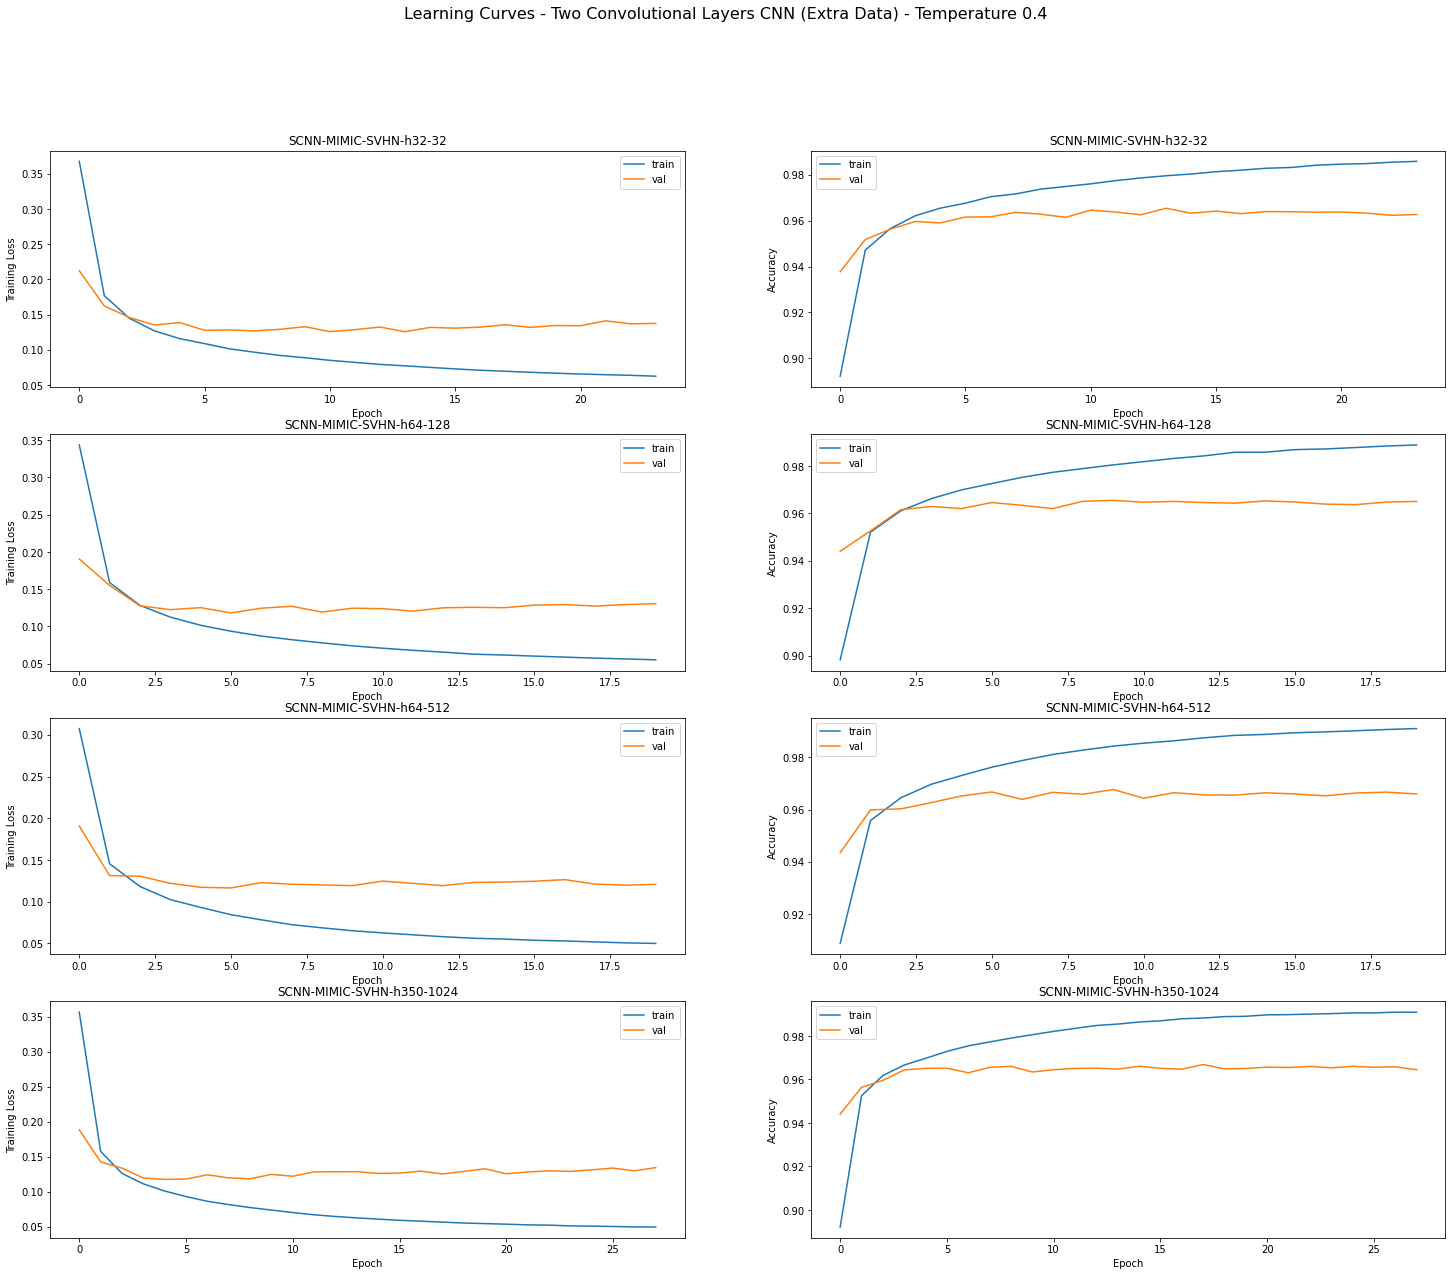

In [ ]:
fig = plt.figure()
fig.suptitle('Learning Curves - Two Convolutional Layers CNN (Extra Data) - Temperature 0.4', fontsize=16)
fig.set_size_inches(25, 20)

plt.subplot(4, 2, 1)
plt.plot(loss_train_32_32, label='train');
plt.plot(loss_test_32_32, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h32-32')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 2)
plt.plot(acc_train_32_32, label='train');
plt.plot(acc_test_32_32, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h32-32')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 3)
plt.plot(loss_train_64_128, label='train');
plt.plot(loss_test_64_128, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-128')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 4)
plt.plot(acc_train_64_128, label='train');
plt.plot(acc_test_64_128, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-128')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 5)
plt.plot(loss_train_64_512, label='train');
plt.plot(loss_test_64_512, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-512')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 6)
plt.plot(acc_train_64_512, label='train');
plt.plot(acc_test_64_512, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-512')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 7)
plt.plot(loss_train_350_1024, label='train');
plt.plot(loss_test_350_1024, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h350-1024')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 8)
plt.plot(acc_train_350_1024, label='train');
plt.plot(acc_test_350_1024, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h350-1024')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

In [ ]:
# Curves for Temperature 0.5
loss_train_32_32 = [0.38126833069931165, 0.17994826026408847, 0.14710249837053144, 0.13056116509035356, 0.12056044852324786, 0.11312430510044742, 0.10664570486328076, 0.10148105258222911, 0.09727401036107812, 0.09376235174584097, 0.0908876766655842, 0.08780983695131749, 0.08560589375787105, 0.08349281704874645, 0.08165537645435056, 0.07943157919646633, 0.0777433867626835, 0.07664769877796129, 0.07578954388108401, 0.07447213260359602]
loss_test_32_32 =[0.21174986895303508, 0.17437417874996486, 0.15226631065523927, 0.14152989086776033, 0.13744147186496636, 0.1327345714591525, 0.12739235168963267, 0.12640762752582557, 0.12670289239069976, 0.12573901346180577, 0.12419315878495897, 0.12669321061767472, 0.14181647173548265, 0.12914446184142891, 0.13074441122755895, 0.12999047987278864, 0.1344362305218118, 0.13238827516714655, 0.13557074375978964, 0.13404685866515484]
acc_train_32_32 =[0.8885136407260141, 0.9476634722240962, 0.9575951273654582, 0.9625703688340104, 0.9657946265498163, 0.968329316738659, 0.970791049271184, 0.972318453108286, 0.97401530698699, 0.975126146141246, 0.9766606103955792, 0.9780444523917081, 0.978988194979391, 0.9796871763974921, 0.980626212038484, 0.9817346977177112, 0.9825748875006343, 0.9829490896733603, 0.9834903884171483, 0.9839187204627944]
acc_test_32_32 =[0.9380760070314244, 0.9483747069639747, 0.9561410940513676, 0.9584474756568719, 0.9601231325049426, 0.9614975477263275, 0.9637662741010018, 0.9645664473149681, 0.9641804814117608, 0.9649806546257271, 0.9648959304137329, 0.9645287921155601, 0.9605655812557975, 0.9646135163382153, 0.9638039293004098, 0.9642275504350081, 0.9635968256343692, 0.9645758611068244, 0.9637380327041111, 0.9634838600254843]

loss_train_64_128 = [0.3388937919871282, 0.16320358058136283, 0.13385692166585597, 0.11768706306550583, 0.10773456378214989, 0.10016887136795605, 0.09437554317134951, 0.08909445427161902, 0.08552926378720738, 0.08175897838871271, 0.07866076597171637, 0.07600838731199819, 0.07371922679390099, 0.07153691750013406, 0.07017543518215891, 0.06864953633063466, 0.06727161118142605, 0.066042032341312, 0.06513063129064062, 0.06422205392700601, 0.06326502183246706, 0.06246233598861464, 0.06203547904668646, 0.061346464975693425, 0.06098748001057142, 0.06022401036958333, 0.06012804120133198]
loss_test_64_128 =[0.188386820305877, 0.15089849047595313, 0.13977776269947026, 0.13491113019576256, 0.12504947319648832, 0.12810313138769827, 0.12570412671079417, 0.12258179164213802, 0.12180582412287289, 0.12523852236231492, 0.12218384174246302, 0.12489574204787748, 0.12495978214103741, 0.1237778217589368, 0.12470905018383366, 0.12556370395818067, 0.12753332892474067, 0.12642225108792657, 0.12477186820755215, 0.13143435009301163, 0.1255009589994873, 0.12959266582678156, 0.1252056901668898, 0.12702500253624854, 0.12476242828034384, 0.12368488312062159, 0.12576911653832196]
acc_train_64_128 =[0.9010411763587144, 0.9523751247329354, 0.9613748046617588, 0.9666654114766927, 0.9699014365586655, 0.9727585525156097, 0.9752626475616214, 0.9774207821027091, 0.9786963643518759, 0.980364976559411, 0.9818829665053753, 0.9830408751119535, 0.9839987385363431, 0.9851990096586523, 0.9857850243808558, 0.9864534106527593, 0.9873077212735112, 0.987552482443093, 0.987952572816448, 0.9883785513904317, 0.9887292188341912, 0.9891693182448816, 0.9892752245213037, 0.9895505808359609, 0.9897247378220095, 0.9900424566479091, 0.9898753600802138]
acc_test_64_128 =[0.9451740141294315, 0.9555197831065511, 0.9597654080524922, 0.9610080299415642, 0.963926308743795, 0.9638321707399445, 0.9640863433865883, 0.9656396208125957, 0.9659596900981823, 0.9655266551930497, 0.9666374838900853, 0.9654984137641759, 0.9654795861698025, 0.9667598633014876, 0.9668069323247348, 0.9666186562957119, 0.9669198979549418, 0.965874965886188, 0.9658655520623487, 0.9648582751823419, 0.966138552335349, 0.9646511715269623, 0.9664962768416655, 0.9666751390788323, 0.966439794047884, 0.9664209664108665, 0.966326828417677]

loss_train_64_512 = [0.3249841816652506, 0.15212856485648257, 0.12390480524419026, 0.1103080611206678, 0.10007248144376088, 0.09274321713204811, 0.08673292809495088, 0.08198275527137482, 0.07833716554915703, 0.07421001353431268, 0.07181026873874752, 0.06955883811173216, 0.06754765855707266, 0.06597303705733905, 0.0643758127750994, 0.06359695024848559, 0.06260253838035938, 0.06157450869355689, 0.06084532552694149, 0.05987130436123471, 0.05931090727702928, 0.05876391795644731, 0.05827105809594737, 0.05810327597467873, 0.05698830736828558, 0.0566947459473171, 0.056496937692080085, 0.05639092886366882, 0.055519067913205745, 0.055571445531344514, 0.05526837747435826, 0.0550629150223334, 0.054719478111597206, 0.0545241895178567, 0.05434750330279705, 0.0540526146010077, 0.05413657861934098, 0.053805713400738774, 0.05382187287575063, 0.05330116252888127, 0.05332578021067233, 0.053049783953172606, 0.05290004398788871, 0.052716040513830054, 0.05272678088585391, 0.052355090189268066, 0.05243777574939335, 0.05242397722312806, 0.05227302646576307, 0.05193061017171507, 0.05197914073457766, 0.05173395622828918, 0.05165034674017269, 0.05149191312208953]
loss_test_64_512 = [0.18125395922911663, 0.14621819143921394, 0.1371694453535393, 0.13110388503329656, 0.11925942170720627, 0.12484165231434514, 0.11898819013303766, 0.11891285796315483, 0.11883948582754715, 0.12358313289139296, 0.1179326081100987, 0.11942266856534835, 0.12127096265882956, 0.11955634274229511, 0.11948222010715857, 0.12096265155694702, 0.12017522784871255, 0.12048998325722284, 0.12015898154430799, 0.11977315269581677, 0.11735265219422666, 0.11699183009719111, 0.11878789864996082, 0.11936666419553385, 0.12053035835228391, 0.11776278272574293, 0.11856967810227628, 0.11690486537700051, 0.11845867906820266, 0.11964970542004522, 0.11712619012397443, 0.11797144040585292, 0.11829215201331023, 0.11780326273289322, 0.11867786005125464, 0.11652520516933616, 0.1167101720716665, 0.11760455697958089, 0.11780364930417071, 0.11706131389284906, 0.1153761401678654, 0.11513102445743187, 0.1185928402842031, 0.11740247259491088, 0.11573350330120893, 0.11795113976323343, 0.11598593008338441, 0.11838132670853378, 0.11500734990833675, 0.11805830499324782, 0.11591627461555382, 0.1199173664336219, 0.11613105255888266, 0.11565562028460333]
acc_train_64_512 =[0.9040300867915874, 0.9556040893987992, 0.9645096304072672, 0.9687670626731983, 0.9725396795500234, 0.9755544781846476, 0.9780562197533859, 0.9801955265178091, 0.9820029936162595, 0.9836386572003236, 0.9849118859767061, 0.9857497222902114, 0.9868535010249919, 0.9876536817717018, 0.9880114096338145, 0.9885103458663604, 0.988903375821362, 0.9894470280345679, 0.9897435656031629, 0.9901177677781334, 0.9901060004130889, 0.9902919247608154, 0.990362528946593, 0.9904590213285106, 0.9910262082729275, 0.9908143957212057, 0.991068570780803, 0.9911344680198896, 0.9915133771381845, 0.9911838909483628, 0.9913980569728692, 0.991445126428558, 0.991468661154158, 0.9915180840826312, 0.9915792743772711, 0.9918569841647129, 0.9916898875958954, 0.991739310526613, 0.9916475250868977, 0.991755784834982, 0.9919652439139194, 0.9920993918615103, 0.9917322501071375, 0.9921911773012256, 0.9920028994773482, 0.9920899779703725, 0.9922711953758967, 0.9920664432436503, 0.9923417995594299, 0.9923676877600588, 0.9923041439948789, 0.9922241259202078, 0.9922052981356879, 0.9923935759606876]
acc_test_64_512 =[0.9464448774479383, 0.9572330951753518, 0.9591911660669569, 0.9613563406565856, 0.9658561382811535, 0.9643969988696576, 0.965874965864866, 0.9675317951079021, 0.9669952083644188, 0.9659408624824867, 0.9674188295096782, 0.9676259331437357, 0.9679083471979311, 0.9681248646878109, 0.9680024852231036, 0.967644760716226, 0.9677765539946727, 0.9673905881021264, 0.9679836576500522, 0.9682378303286789, 0.9678895196142187, 0.9681813475029144, 0.9679365886374659, 0.9674753123034596, 0.967983657606847, 0.9682943131224604, 0.9681342784796672, 0.968689692849507, 0.9678612782173279, 0.9681248646878109, 0.9681436922928455, 0.9681060370721154, 0.9679742438368739, 0.9683037269356387, 0.9682001750866269, 0.9684543477865757, 0.9686614514099722, 0.9690380035106623, 0.9691321415678178, 0.969103900160266, 0.9686802790469897, 0.968087209477742, 0.968313140727495, 0.9693392451912143, 0.9688403136359168, 0.9686049685948687, 0.9692356933955075, 0.9687838308533575, 0.9684637615677709, 0.968953279277346, 0.9682472441205352, 0.9679930714205863, 0.9689344516936335, 0.9687555894458058]

loss_train_350_1024 = [0.37918965554526, 0.16835009212865398, 0.13826380049789788, 0.12347056353080185, 0.11388816522589747, 0.10694020541300894, 0.10221348219972803, 0.09708849199010601, 0.0934901695601778, 0.09073860648172692, 0.08752990119031429, 0.08491853551707917, 0.08263078902415501, 0.08087402959347821, 0.07894073234640939, 0.07760842580900879, 0.07598408751011977, 0.0743678454526782, 0.07369451475564716, 0.07217916518053077, 0.07125289116045726, 0.06995232686162783, 0.06955206759430135, 0.06869962273672583, 0.06764312839004402, 0.06722196466353725, 0.06655991641343798, 0.06590967435064522, 0.06525880472730608]
loss_test_350_1024 =[0.19793625448566435, 0.15511768630826228, 0.1390651856629331, 0.1405607582060789, 0.1252612615027345, 0.13376491390432316, 0.1320918297200529, 0.1291717433338991, 0.12121487689843413, 0.13512165622480815, 0.12995775303069274, 0.1266605072110274, 0.12518150371911851, 0.12498903611536609, 0.1263442411236734, 0.12677766110557662, 0.12976078335475105, 0.12982425883898982, 0.12780644382223047, 0.1314787880400245, 0.1351878380614863, 0.12982624818826644, 0.12990724141711743, 0.13252317033775357, 0.13430577208592565, 0.12920256831442126, 0.13086654621710517, 0.1301742043133893, 0.1297740649778392]
acc_train_350_1024 =[0.8855788601615722, 0.951000696626822, 0.9601439383921297, 0.9649379624540355, 0.9678445013506753, 0.9701862067644605, 0.9721442961222374, 0.9739376423839813, 0.9753450191079546, 0.9764605652089017, 0.9779103044441172, 0.9788140379899758, 0.9798377986512075, 0.9808403780596237, 0.9816993956248223, 0.9820288818180106, 0.9830620563703801, 0.9836080620563704, 0.9838904787860143, 0.984648297025971, 0.9851990096586523, 0.9858132660531469, 0.9859521209474289, 0.9862580724116506, 0.9867946642053809, 0.987190047633167, 0.9873171351646489, 0.987884322104577, 0.9879408054514035]
acc_test_350_1024 =[0.9426322874817569, 0.9550396791456272, 0.9598972012770727, 0.9587581311618244, 0.9640769296160541, 0.9621282724630001, 0.9629284456982885, 0.9630884803410817, 0.965460758575429, 0.9621659276730692, 0.9638133431349101, 0.9647547233653131, 0.9656961036383602, 0.9658184830391014, 0.965950276285004, 0.9651783444785894, 0.9646888267476924, 0.9651783445105725, 0.9664774492579531, 0.9644252402772093, 0.9633897219896508, 0.965724345035251, 0.9656302069887565, 0.9647547233759741, 0.9654607585322238, 0.9658090692685672, 0.9657055174515385, 0.9652348272830319, 0.9657149312433947]


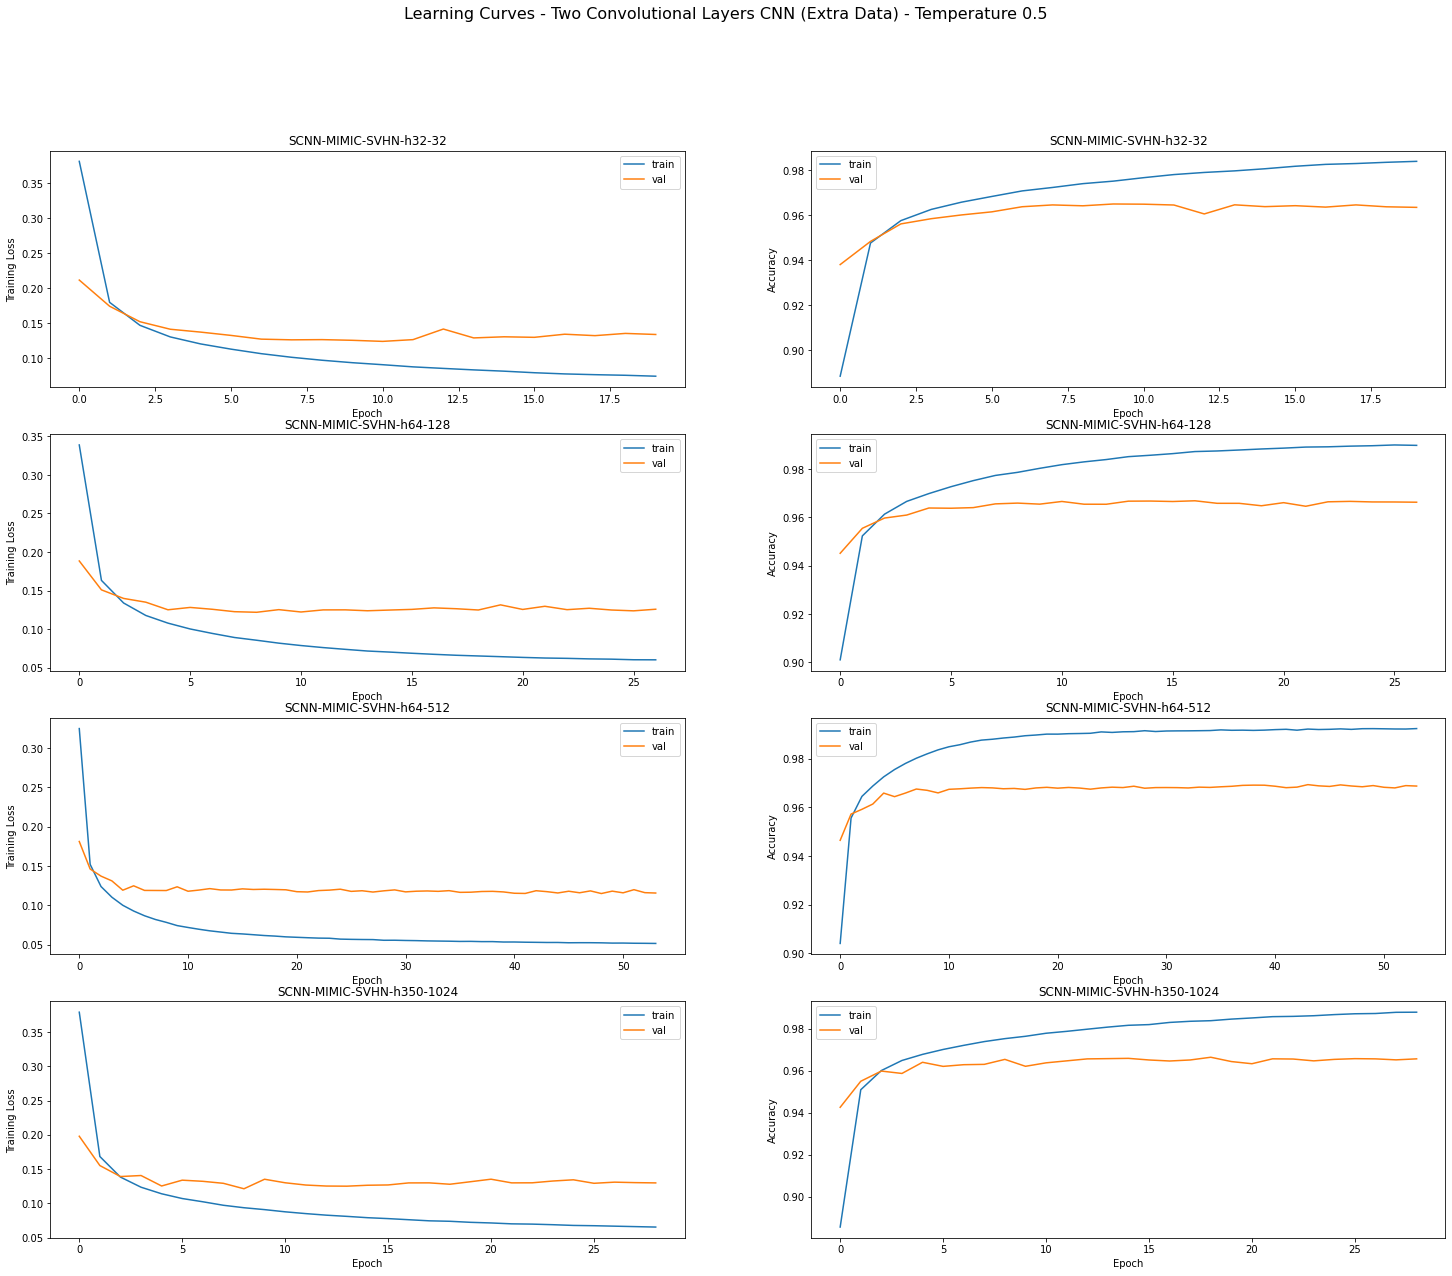

In [ ]:
fig = plt.figure()
fig.suptitle('Learning Curves - Two Convolutional Layers CNN (Extra Data) - Temperature 0.5', fontsize=16)
fig.set_size_inches(25, 20)

plt.subplot(4, 2, 1)
plt.plot(loss_train_32_32, label='train');
plt.plot(loss_test_32_32, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h32-32')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 2)
plt.plot(acc_train_32_32, label='train');
plt.plot(acc_test_32_32, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h32-32')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 3)
plt.plot(loss_train_64_128, label='train');
plt.plot(loss_test_64_128, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-128')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 4)
plt.plot(acc_train_64_128, label='train');
plt.plot(acc_test_64_128, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-128')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 5)
plt.plot(loss_train_64_512, label='train');
plt.plot(loss_test_64_512, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-512')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 6)
plt.plot(acc_train_64_512, label='train');
plt.plot(acc_test_64_512, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-512')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 7)
plt.plot(loss_train_350_1024, label='train');
plt.plot(loss_test_350_1024, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h350-1024')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 8)
plt.plot(acc_train_350_1024, label='train');
plt.plot(acc_test_350_1024, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h350-1024')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

In [ ]:
# Curves for Temperature 0.6
loss_train_32_32 = [0.37060104011271705, 0.18479844399052284, 0.15395151408606605, 0.13776491201034122, 0.1277227335237461, 0.12019191159663224, 0.11459327197962793, 0.10977656642352779, 0.10624803603396854, 0.10303489210934971, 0.10006267808237045, 0.09745515498663543, 0.094929630870469, 0.09286179623263024, 0.09168018483194591, 0.08993582894711283, 0.08850975112752721, 0.0871993567378427, 0.08598821349491804, 0.08510485534217913, 0.08410783431994959, 0.08288670622568863, 0.08217183709219782, 0.08146775319392084, 0.08050725365695957, 0.07984695470966818, 0.07944558015630086]
loss_test_32_32 =[0.21592089853355917, 0.1723676172382151, 0.15967937248646671, 0.14240932847624835, 0.1420771891770107, 0.13721335240486468, 0.13547142680474147, 0.13701015172659556, 0.13443440143292676, 0.13454374974169167, 0.13314838395745457, 0.13355489714466368, 0.13724298498500503, 0.13776873569144646, 0.13333516561191164, 0.1326184426159966, 0.1329270083139961, 0.1347496331887494, 0.1344757143442463, 0.13683821999373127, 0.13571506778557382, 0.13618183789282456, 0.13837830947307594, 0.13679088851298643, 0.13551322162323595, 0.13874662847242272, 0.13560413729933862]
acc_train_32_32 =[0.8943431928119516, 0.9486519307879502, 0.9576445502961759, 0.9627421723472745, 0.9659170071346073, 0.9685223015058609, 0.9705980645028599, 0.9723066857421193, 0.9739329354429013, 0.975224991995948, 0.9764888068811928, 0.9774984467057178, 0.9787151921363959, 0.9795742097027168, 0.9804426411579309, 0.9812357614885319, 0.9816099636623802, 0.9823771957901078, 0.9829255549477603, 0.98316090222396, 0.9838292884947412, 0.9844906143494134, 0.9849801366896993, 0.9851284054728746, 0.9855567375196429, 0.9856744111599871, 0.986220416843733]
acc_test_32_32 =[0.9401376297933633, 0.9520178485375896, 0.9555668521084764, 0.9612245474533271, 0.9614034097011549, 0.9634179634398465, 0.9636533085027779, 0.9635968256338081, 0.9647829647941869, 0.9641522400361922, 0.9643122746357802, 0.9646982405821927, 0.9638509983343181, 0.9645664472930849, 0.9643122746789854, 0.9649429994476412, 0.9654889999723197, 0.965234827315015, 0.9651783444892504, 0.9651877583024286, 0.9644723093111176, 0.9647735510023306, 0.9640486882085023, 0.9643969989016407, 0.9648771027761542, 0.9647923785967042, 0.9647923785753821]

loss_train_64_128 = [0.3464210519485315, 0.16761024522720322, 0.13831376278847965, 0.12328347628229346, 0.11291974435699789, 0.10596822132768093, 0.10017735348131737, 0.09570206516813128, 0.0919669238109842, 0.08867328303694756, 0.08633723135098358, 0.08366536926624388, 0.08198444221718014, 0.08020027889919643, 0.0791005809792561, 0.07746871636863666, 0.07648628209199157, 0.07535978287515653, 0.07472585650474815, 0.07379713874249444, 0.07328459607191451, 0.07233899621018319, 0.07216105201236139, 0.07131770917698955]
loss_test_64_128 =[0.20025367016852424, 0.16181012757644136, 0.14105351276385225, 0.13346349000378097, 0.13805166327880508, 0.128287363129885, 0.12284280193629489, 0.12385658218063586, 0.12347563689900164, 0.1290348943530892, 0.12698864020429715, 0.126342621920969, 0.12474516271446215, 0.12615709266662756, 0.12483082650704364, 0.12641721008051798, 0.12684349466269856, 0.12579071315145646, 0.1265365160238648, 0.12574440183458804, 0.1261666898520279, 0.13098287306150774, 0.12716851945164206, 0.12605014935179187]
acc_train_64_128 =[0.9007399318411837, 0.9532011936769074, 0.962645679960868, 0.9677103533963511, 0.9710052152912014, 0.9738058479058082, 0.9760392935771202, 0.9778397002617062, 0.979814263927852, 0.981143976051061, 0.9823183589693747, 0.9838787114243366, 0.9842646809632294, 0.9852790277299566, 0.9856697042144182, 0.9863992807787171, 0.9867970176781653, 0.9875689567514618, 0.9877784158281548, 0.9882632312228719, 0.9882985333112718, 0.9886797959045956, 0.9886727354884868, 0.989159904354866]
acc_test_64_128 =[0.9435830815365602, 0.9549267135586254, 0.9616010995113731, 0.963888653544387, 0.9621376862655174, 0.9659596901195043, 0.9675788641204883, 0.9670046221989191, 0.9671364154234996, 0.9659032072724177, 0.967268208637419, 0.9668163461272521, 0.9671552430285341, 0.96778596779719, 0.9673623466839136, 0.9670046221669361, 0.9675129675028676, 0.9675506227235976, 0.9673341052763619, 0.9670140359801144, 0.9676259331437357, 0.9669857945512406, 0.9672870362531146, 0.9674000018833216]

loss_train_64_512 =  [0.3170807583488769, 0.15461689850385485, 0.12830357319397934, 0.11510086039819183, 0.10620636815999575, 0.09915527184832523, 0.09416942610362337, 0.08963819278477657, 0.08578947441859994, 0.08283744772522926, 0.08081172108344402, 0.07844555190471765, 0.07679358112837405, 0.0753586387713338, 0.07444063452784405, 0.07343619198730386, 0.07230852173125348, 0.0712219391812055, 0.07065057910554734, 0.06998947853446198, 0.0693863184187201, 0.0690819877227972, 0.06842679481544402, 0.06802571572186206, 0.06724220025274666, 0.06728024711887849, 0.06689561313117134, 0.0664470282075546, 0.06625294687257521, 0.0658847135514026, 0.06546514899741052, 0.06536184900826723]
loss_test_64_512 =[0.1790445736827205, 0.14789052734509486, 0.1345614169160102, 0.12950730622019532, 0.1278580376016539, 0.12524248972764204, 0.12455350655634836, 0.12231233204436356, 0.12103661869997379, 0.1251829884905596, 0.12417234355352488, 0.1244876237786964, 0.12709833035118745, 0.12039895539954745, 0.12413738817275337, 0.12480966790475201, 0.12229521376693618, 0.12453888967884763, 0.1210762528738019, 0.12222814498018438, 0.12165894010335038, 0.12197335645745402, 0.12269153642058749, 0.11922797573765612, 0.11964452492215787, 0.12763708003117602, 0.12088079017199922, 0.12234454919217562, 0.11843912517369522, 0.11980584427841018, 0.12163345660766976, 0.121377503695057]
acc_train_64_512 =[0.908838231691322, 0.9572256321394232, 0.9653921827003104, 0.9702168019173916, 0.9735234311739197, 0.9763264172579441, 0.9788116845171912, 0.9806144446723173, 0.9825960687590609, 0.9835892342729726, 0.9846341761892643, 0.9859074049656468, 0.9866769905672811, 0.987225349722689, 0.987606612316013, 0.9880773068717789, 0.9886656750690113, 0.9888845480379642, 0.9892469828478904, 0.9894329071967389, 0.989600003763312, 0.9897906350588517, 0.9898494718795849, 0.9900989399958579, 0.9904119518761885, 0.9903742963116374, 0.9903837102027753, 0.9903884171472219, 0.9904449004951706, 0.9908332235046033, 0.9909179485248433, 0.990633178317926]
acc_test_64_512 =[0.9494667080772978, 0.95927589027839, 0.9627119282510528, 0.9647923786073652, 0.9654701723672852, 0.9663362422095333, 0.9668069323247348, 0.9683037269356387, 0.9677012435532126, 0.9668445875241428, 0.9670328635744878, 0.9676918297506953, 0.9674094156858388, 0.9684731753702882, 0.9671175877971431, 0.9688403136897831, 0.9679554162105174, 0.9682660717362307, 0.968727348038254, 0.9683602097400812, 0.9686708652338115, 0.9696216592667318, 0.9684731753596272, 0.9685296582067138, 0.9695463488465937, 0.9669857945619016, 0.9681907612947707, 0.9687367618194492, 0.9690191759162887, 0.9688967964942256, 0.9688403136578, 0.9690003483112543]

loss_train_350_1024 = [0.32874006948369305, 0.15707176371211173, 0.13149544982338116, 0.11839304635949982, 0.10948053992270633, 0.10297561498655919, 0.0975069816337569, 0.09308838695632789, 0.0899037171694653, 0.08677421614418004, 0.08410747640798309, 0.08244800973436917, 0.0802667701361823, 0.07877313264982846, 0.07727607630094056, 0.07624894273824982, 0.07499638650968025, 0.07447406901423455, 0.07343438643189705, 0.07260313351736582, 0.0715359426289839, 0.07125405942294152, 0.07069698449157531, 0.0703637639015973, 0.06964670397442112, 0.06946034091777367, 0.06874198655472685, 0.06876164887714806, 0.06846651550711819]
loss_test_350_1024 =[0.1894383918499001, 0.14701307608662975, 0.13334454230601078, 0.14268695167946832, 0.1332375517481943, 0.1256701346112514, 0.13326233879705388, 0.12408536756989573, 0.1270462395986029, 0.12940289597412896, 0.1268363182311619, 0.12305287641240614, 0.12561661900040888, 0.126296418684547, 0.1259420052809994, 0.1272328251426014, 0.12666288386228228, 0.1289064519947809, 0.12437391412679315, 0.12647555599288215, 0.12655915733679413, 0.13006449728659625, 0.12352666139934555, 0.12291458006638047, 0.12541988126507345, 0.12700502591669782, 0.1249882029873154, 0.12696464943114508, 0.12484899507877678]
acc_train_350_1024 =[0.9037712047931544, 0.9562418805188937, 0.9646414248831959, 0.9688823828474915, 0.9724290663257881, 0.9749684634635662, 0.977044226459443, 0.9792682582396173, 0.9805650217460885, 0.9821088998915595, 0.9832997571216087, 0.9839987385385875, 0.9850436804548792, 0.985770903543027, 0.9867193530740344, 0.986773482950321, 0.9874959990962664, 0.9877219324824505, 0.9880302374183345, 0.988202040928232, 0.9890610584979195, 0.9890092820944174, 0.9891151883719617, 0.9894117259416789, 0.9895576412554365, 0.9894517349801367, 0.9900165684484025, 0.9898188767345094, 0.9899365503737315]
acc_test_350_1024 =[0.9492407768382058, 0.9591629246913882, 0.9641428262230138, 0.9605373398695678, 0.9642275504350081, 0.9673341052763619, 0.9644628955192615, 0.9674376570608464, 0.966929311735576, 0.9664868630284873, 0.9675412089210804, 0.9683507959050198, 0.9676635883751267, 0.96685400132666, 0.9668728289316946, 0.9669104841737466, 0.9670328635744878, 0.9673717604757699, 0.9685673133847997, 0.967607105517379, 0.9678236230072589, 0.966364483617085, 0.9684637615352267, 0.9685484857904262, 0.9678424506122935, 0.9676730021669829, 0.9683037269356387, 0.9680589680701902, 0.9678236230072589]


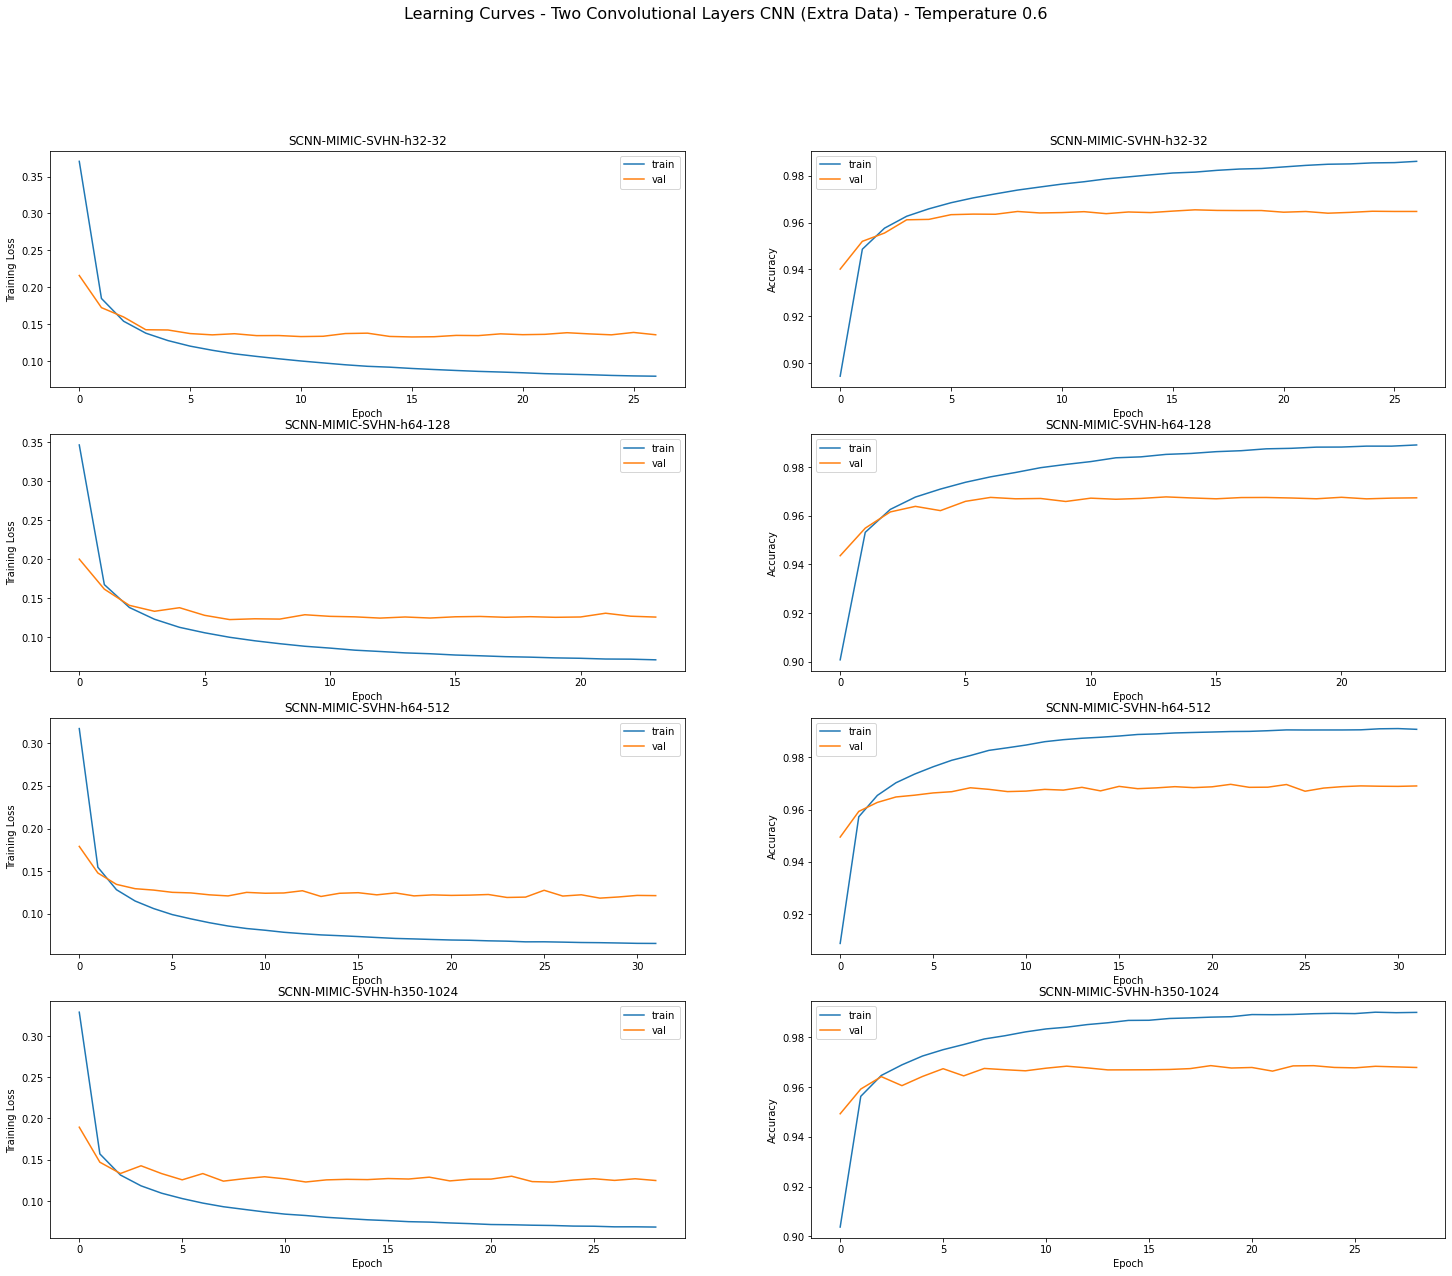

In [ ]:
fig = plt.figure()
fig.suptitle('Learning Curves - Two Convolutional Layers CNN (Extra Data) - Temperature 0.6', fontsize=16)
fig.set_size_inches(25, 20)

plt.subplot(4, 2, 1)
plt.plot(loss_train_32_32, label='train');
plt.plot(loss_test_32_32, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h32-32')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 2)
plt.plot(acc_train_32_32, label='train');
plt.plot(acc_test_32_32, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h32-32')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 3)
plt.plot(loss_train_64_128, label='train');
plt.plot(loss_test_64_128, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-128')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 4)
plt.plot(acc_train_64_128, label='train');
plt.plot(acc_test_64_128, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-128')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 5)
plt.plot(loss_train_64_512, label='train');
plt.plot(loss_test_64_512, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-512')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 6)
plt.plot(acc_train_64_512, label='train');
plt.plot(acc_test_64_512, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-512')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 7)
plt.plot(loss_train_350_1024, label='train');
plt.plot(loss_test_350_1024, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h350-1024')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 8)
plt.plot(acc_train_350_1024, label='train');
plt.plot(acc_test_350_1024, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h350-1024')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

In [ ]:
# Curves for Temperature 0.7
loss_train_32_32 = [0.39784063872472375, 0.20380856100055095, 0.16849611501620962, 0.15079582672105854, 0.1405922135142254, 0.1321730495903108, 0.12659812700127182, 0.12185844145281076, 0.11823355910583362, 0.11485924123494488, 0.11235982153746421, 0.10963075824898735, 0.10766791897529156, 0.10582434831074661, 0.10436210149145377, 0.10287893320645843, 0.10155525737789667, 0.10001670181411218, 0.09914400785744236, 0.09825381884013688, 0.09709432706591181, 0.09652723876043186, 0.09535675792361364, 0.0946088174302846, 0.09405903958111445, 0.09332028318371813, 0.09278377097483609, 0.09246947875979113, 0.09163639444406912, 0.09125611055821571, 0.09080262164773492, 0.09037256231474163, 0.08985966833100834, 0.08978593477249963, 0.08914422891777204, 0.08876782222734148, 0.08846812889928471]
loss_test_32_32 =[0.23110993518055312, 0.19129654158166318, 0.1667595962393268, 0.15524860460804982, 0.15048397679621456, 0.14659307087133888, 0.14624904702387945, 0.14500510738074104, 0.14224010083358293, 0.14137891983329295, 0.14257712676037246, 0.1416619807464652, 0.14097227052287448, 0.14308808000908615, 0.14052051902072626, 0.14151451924245426, 0.14276267946124435, 0.14232230315923666, 0.14258386213713442, 0.1410981870101455, 0.1410506987017175, 0.14123153810822522, 0.14188654167069456, 0.1417434144070524, 0.14295634046007985, 0.1429358905316077, 0.13996552152401123, 0.14166737397043278, 0.1409536490168333, 0.14401081323887938, 0.14592546814274812, 0.14564144797645953, 0.14636137872061541, 0.14515246926228254, 0.14291977562933378, 0.14461548723957193, 0.14686879084171128]
acc_train_32_32 =[0.8876334419113667, 0.9451405493924424, 0.9555428991019148, 0.9616948769581983, 0.9648650047977179, 0.9675126616813359, 0.9699367386481875, 0.971337054956052, 0.9730480296692182, 0.9745189501606158, 0.9755850733330897, 0.9765994201031837, 0.9774678515595201, 0.9784774913840452, 0.9794071131316548, 0.9800849132969404, 0.9805626682710596, 0.9812404684329785, 0.9819582776344774, 0.9819912262534596, 0.9825913618123697, 0.9830455820575223, 0.983584527328526, 0.9839987385385875, 0.984123472596163, 0.9843823546024514, 0.984845988739864, 0.9850530943415281, 0.9853708131707942, 0.9856697042155405, 0.9857920847980869, 0.9860344924960065, 0.9862039425364862, 0.9860721480594353, 0.9864745919044525, 0.9865710842886146, 0.9869241052085251]
acc_test_32_32 =[0.9386125937967909, 0.9486288796426015, 0.9558869213834018, 0.9599913393129063, 0.961036271360338, 0.9626554454039662, 0.9630790665279035, 0.963436791002237, 0.9642087228299736, 0.9643781712859452, 0.9643875850991234, 0.9637474465066282, 0.9648206199935949, 0.9641804814010998, 0.9650088960226179, 0.9650277236383134, 0.9640675157708928, 0.9645852749413246, 0.9649147579974453, 0.9645099645318477, 0.9650559650671872, 0.9649806546257271, 0.9646794129345141, 0.9643687574621058, 0.9642463780400425, 0.9652159996886585, 0.9657714140478372, 0.9654136895415206, 0.9650088960226179, 0.9641334124098356, 0.9651406892685204, 0.964227550403025, 0.9647547233653131, 0.9647547233546521, 0.9649524132181754, 0.9643593436702496, 0.9637192050670935]

loss_train_64_128 = [0.35645427309261274, 0.179371660577971, 0.15040234103651576, 0.13474640912598282, 0.12599299520278262, 0.1191148945136843, 0.1138720187301693, 0.10992494254792042, 0.10599754384547153, 0.10341078408323796, 0.10106128970206636, 0.09874306102565872, 0.09680400889447455, 0.09515850955786882, 0.09377538928274577, 0.09242039804937763, 0.09103235166787882, 0.09022943000809348, 0.08939711900569863, 0.08840823379787587, 0.08781574765550323, 0.08675900730864217, 0.08661093243667088, 0.08566647901312699, 0.08539845125776606]
loss_test_64_128 =[0.2140349440695138, 0.16410887480899827, 0.15244719825587322, 0.14468329304934044, 0.14150719585120147, 0.13941643822490757, 0.1349805996235909, 0.13611955138628898, 0.13414021001767457, 0.13450228589521745, 0.1346376177133192, 0.13483786500884973, 0.13347310515286098, 0.13546523230336435, 0.13359617234346396, 0.13647316283383903, 0.13616076888238465, 0.13322843798579773, 0.1335524250618427, 0.13567106760574338, 0.13686939864968892, 0.13532665628208218, 0.1359416397879234, 0.13479733048362405, 0.13395310520277962]
acc_train_64_128 =[0.8993184342793815, 0.9524975053233374, 0.9615277803882586, 0.9666254024416017, 0.9696331406623614, 0.9723019787999172, 0.9746507446343001, 0.9764370304821796, 0.9780962287929658, 0.9793412158948127, 0.980301432793109, 0.9813722629089072, 0.9823112985566325, 0.9831985577907555, 0.9838128141874944, 0.9845235629695178, 0.9851519401995968, 0.9855779187769472, 0.9860839154244798, 0.9866958183495566, 0.986441643288837, 0.9873006608540357, 0.9871194434552448, 0.9877525276297705, 0.9879360985047124]
acc_test_64_128 =[0.9417379761999739, 0.9567812326113185, 0.9611586508143843, 0.9628813766750413, 0.9647170681659051, 0.965159516884216, 0.9661573799403835, 0.966929311735576, 0.9678047954022244, 0.9669669669781891, 0.9664868630391483, 0.9665339320623956, 0.9671081739946258, 0.9664492078504013, 0.9681342784690061, 0.9662891731969471, 0.9672211396248328, 0.9671646568417124, 0.9675035537110114, 0.965837310676119, 0.9669198979762639, 0.9667881047303614, 0.9664868630604703, 0.9672870362637757, 0.9678236230072589]

loss_train_64_512 =  [0.3357935174481824, 0.16858238300171008, 0.14057157544244417, 0.12706461204563246, 0.11795222499255749, 0.11144033851981502, 0.10637082520033422, 0.10270162852187792, 0.09940989915843136, 0.09650662030693709, 0.09420157246349292, 0.09179408441991753, 0.09014641793676456, 0.08869758596555044, 0.08743566878216705, 0.0862051038158801, 0.08543466945602218, 0.08458636472945005, 0.0836131794939729, 0.08327364734032287, 0.08248766710396382, 0.08174183356217767, 0.0814197078121569, 0.0808734330400661, 0.08043521869009315, 0.08012802261404889, 0.07990699136804032, 0.07931482174397278, 0.07887410892912666, 0.07898946711606797, 0.07828904234643437, 0.07810475616679814, 0.07794679129162742, 0.07755297542732434, 0.07740105205791477, 0.07728703305816245, 0.07703110933763384, 0.0767885255721408, 0.07662076162604962, 0.07643448128434155, 0.07627606736401228, 0.07604874859978895, 0.07616835459498669, 0.07576197993920757, 0.07566392762762558, 0.07556105038945854, 0.07566146335714108, 0.07524086490803446, 0.07531635901592201, 0.07509151024324238, 0.07488815054501412, 0.07496216240581188, 0.07485082298163727, 0.07471588696046717, 0.07460576844458523, 0.0745380241948134, 0.07440970363004748, 0.07428614513768408, 0.07440971332325101]
loss_test_64_512 =[0.19563740585136968, 0.15553011524061405, 0.15019643340777306, 0.14203978196023964, 0.13647498176122827, 0.1359974223358431, 0.13350109943500604, 0.13534422781659403, 0.13079831439743653, 0.13128200515428426, 0.13265180971551274, 0.13228252630802526, 0.1326119520740649, 0.1299223747370476, 0.1296520533302711, 0.13075360719428095, 0.13178884594650897, 0.129844694178837, 0.13036673574341043, 0.12897166243024985, 0.1305004532144819, 0.13036732283403965, 0.13109825295771607, 0.12755022219220724, 0.1275637522984392, 0.12956995465961793, 0.1308034652116755, 0.1293674688842905, 0.1274641292949435, 0.12725842360406447, 0.13043351341640202, 0.129083086124342, 0.1284687097871987, 0.12886257261680012, 0.12938635461349066, 0.130099615425384, 0.1280838348784272, 0.12924328430803517, 0.12834892627964015, 0.13162222457132158, 0.1283999818946641, 0.12989179625251107, 0.12643158566783758, 0.12845627027154624, 0.12737396608210166, 0.12901528912113774, 0.12885591428527124, 0.12766674264004518, 0.12727792847667355, 0.12814848717004243, 0.12939972223524568, 0.1282544736115541, 0.12825257985908936, 0.1278673002038236, 0.12791066341838506, 0.1279442416005009, 0.1283530661381788, 0.12874267985622317, 0.12979041643750244]
acc_train_64_512 = [0.9056563364923693, 0.9555523129896859, 0.9645802345919227, 0.9692824732152353, 0.9725773351201856, 0.9754179767653944, 0.977578464781511, 0.9792870860218927, 0.9808050759734681, 0.9823183589682524, 0.9831962043190933, 0.9845847532607911, 0.9852413721687723, 0.9857497222902114, 0.9866652232022367, 0.9870653135767138, 0.9873594976747689, 0.987841959594457, 0.9880090561632745, 0.9883832583360006, 0.9888186507999999, 0.9889598591670663, 0.9889457383314819, 0.9892893453580103, 0.9893787773238191, 0.9891551974092971, 0.9895552877815299, 0.9899789128827292, 0.9899742059382826, 0.9900612844279402, 0.9901248281964867, 0.9901248281953645, 0.9902872178186132, 0.9903625289477153, 0.9905460998249016, 0.9902472087790332, 0.9905060907841995, 0.9906119970617437, 0.9905931692805905, 0.9907014290275525, 0.9907861540477924, 0.9908261630851278, 0.9908049818311901, 0.9908897068503077, 0.9910615103646941, 0.9908967672697833, 0.990750851957148, 0.9909626645077476, 0.9909579575621787, 0.991205072204545, 0.9910426825824186, 0.991077984673063, 0.9911321145471051, 0.9912686159686027, 0.9911321145482274, 0.9913203923698604, 0.9914004104456536, 0.9912356673507428, 0.9912897972225404]
acc_test_64_512 =[0.9474333267655547, 0.9594829939337696, 0.9603678914029352, 0.9635497566644271, 0.965724345035251, 0.9653383791213827, 0.9672776224505973, 0.966477449215309, 0.9677294849820864, 0.9683696235532595, 0.9674658984683981, 0.9679648300018124, 0.96778596779719, 0.9683037269356387, 0.9685955548030125, 0.9679460024293222, 0.9673246914631836, 0.9686237962212252, 0.9685390719985699, 0.9682095889104662, 0.9683413821457078, 0.9684543477865757, 0.968727348048915, 0.9688873826703862, 0.9686237962212252, 0.9676730021237777, 0.9679836576393912, 0.9689062102860817, 0.9688685550866738, 0.969066244939536, 0.9677953815997071, 0.9689909344980759, 0.9691321415464957, 0.9685578995929435, 0.968614382408047, 0.9690191759269497, 0.9687932446558747, 0.9685484857904262, 0.9687367618514322, 0.9687367618407712, 0.9689815207062198, 0.9694992798553296, 0.9694710384477778, 0.968990934508737, 0.9693580728069098, 0.9691321415358347, 0.9688497274816392, 0.9691697967672258, 0.9696687283006401, 0.9691886243509382, 0.9686049685948687, 0.9689532793093291, 0.968652037607455, 0.9696499006742836, 0.9688497274816392, 0.9687838308533575, 0.968388451158294, 0.969028589729467, 0.968765003258984]

loss_train_350_1024 = [0.3547238129712461, 0.16638280387190754, 0.14200021926159823, 0.1289486093004211, 0.12040128934257815, 0.11389662334353005, 0.10956860577540224, 0.1057588665717413, 0.10249682198298472, 0.09984339993119727, 0.09741848171842483, 0.0956871706302992, 0.0937141754507352, 0.09264623231477016, 0.09104023150448932, 0.0899727934737854, 0.08882895238750695, 0.08777757349390204, 0.0867930161331934, 0.0861308771260573, 0.08507059673566139, 0.0844983353586196, 0.08398962122926203, 0.08355121164905187, 0.08301716028657578, 0.08277223838053352]
loss_test_350_1024 =[0.18944003719637315, 0.15659431772663232, 0.1470525005121691, 0.1428504823872176, 0.1340835186668331, 0.13206831669038607, 0.13751060830331652, 0.13252230296264667, 0.13158416850013926, 0.1298782886342295, 0.1329528687673086, 0.1341908619847102, 0.13288776919817907, 0.1335695792283339, 0.13152131227125016, 0.13533426996717854, 0.1340481292209186, 0.13431083489526194, 0.1317569608190743, 0.13238082893245862, 0.1317936453295976, 0.13360182293190698, 0.13461771587030827, 0.13194171102255114, 0.1323151971423084, 0.13297422039369328]
acc_train_350_1024 =[0.897106169860885, 0.9557947206864833, 0.963714156609493, 0.9685434827609208, 0.9717606800583736, 0.9745801404530113, 0.9763146498962664, 0.9777996912221263, 0.9794824242641236, 0.9806332724545929, 0.9818759060858998, 0.9826431382136275, 0.9836857266560125, 0.9843776476568825, 0.985006024889206, 0.9855120215389829, 0.9858838702378023, 0.9864510571777303, 0.9871147365040648, 0.9871170899768493, 0.9878772616873458, 0.9878537269583793, 0.9879714005987235, 0.9883197145708207, 0.9886068382494002, 0.9885927174126936]
acc_test_350_1024 =[0.9497302945584418, 0.9599442702571148, 0.9619399964446382, 0.963474446233628, 0.9664115526403323, 0.9669010703605684, 0.965573724173653, 0.9670516912008443, 0.9674847261166379, 0.9681531060953626, 0.9673529328707353, 0.967607105516818, 0.9672493810537066, 0.9669481393518325, 0.9670422774089881, 0.9684920029966447, 0.9671740706229076, 0.9669198979762639, 0.9676541745512873, 0.9672870362744367, 0.9677388987739426, 0.9672023119979152, 0.9676918297613564, 0.9671740706122466, 0.9681342784903282, 0.9673623466945747]



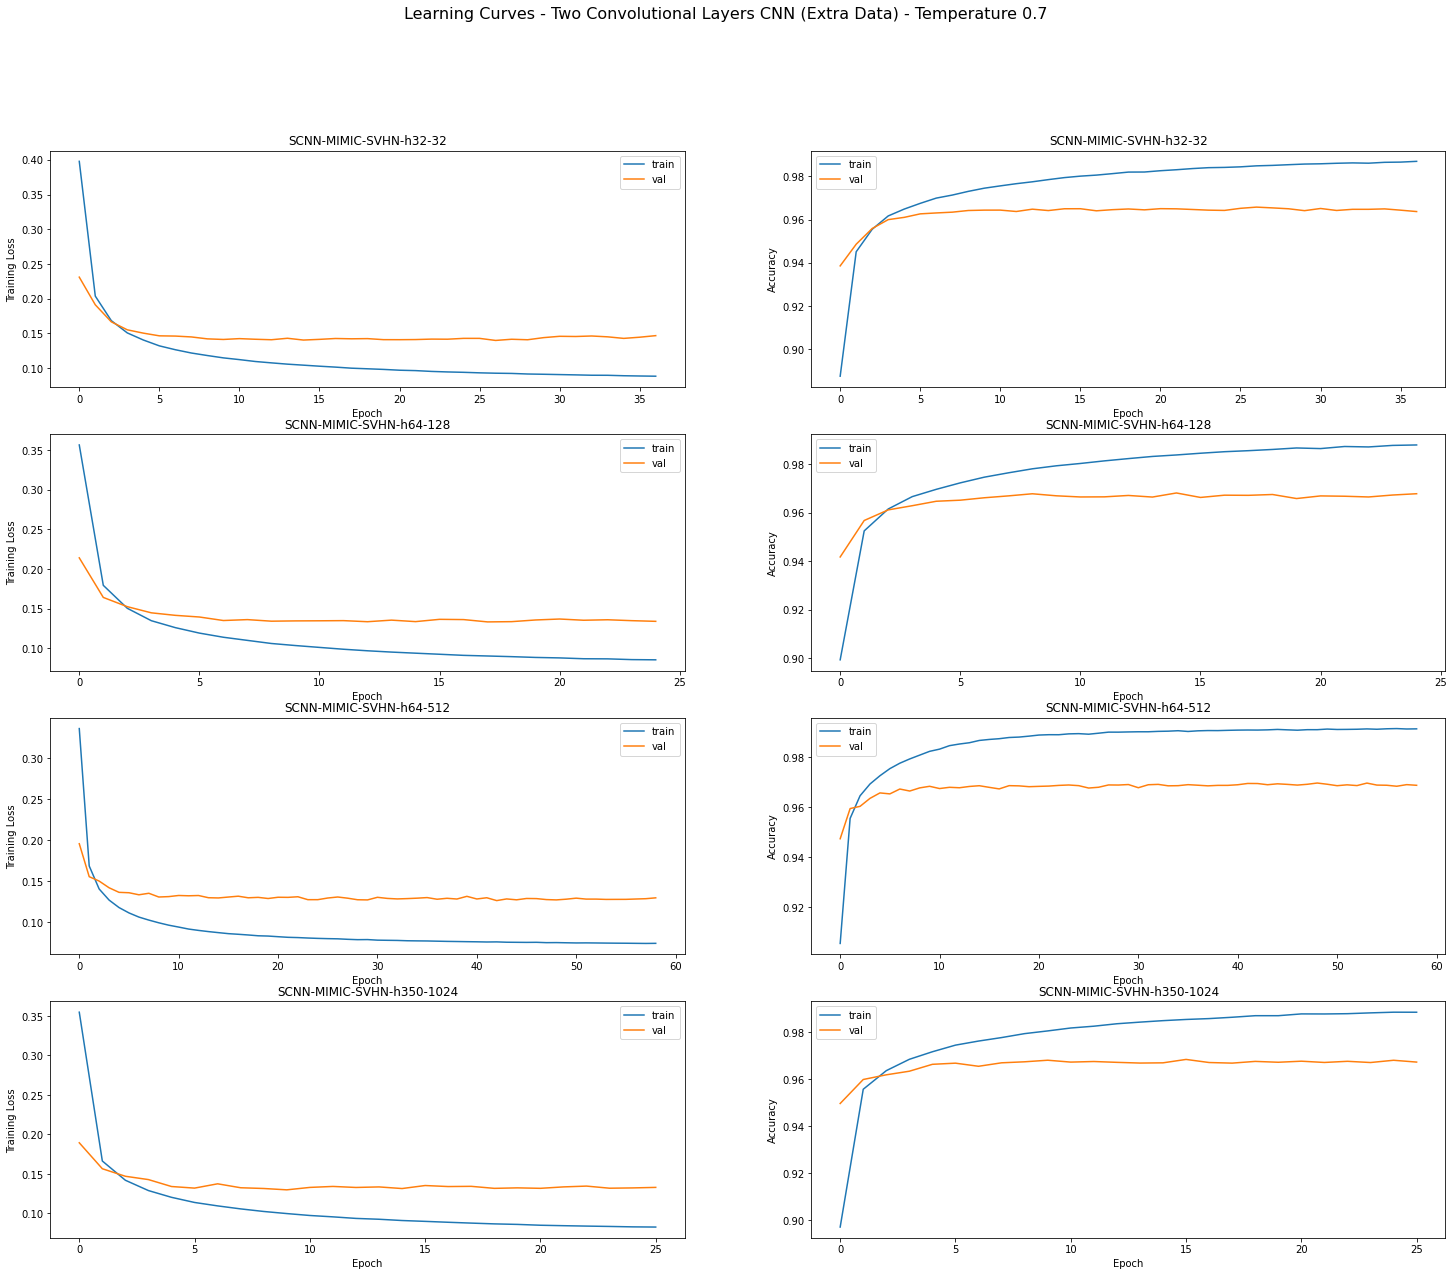

In [ ]:
fig = plt.figure()
fig.suptitle('Learning Curves - Two Convolutional Layers CNN (Extra Data) - Temperature 0.7', fontsize=16)
fig.set_size_inches(25, 20)

plt.subplot(4, 2, 1)
plt.plot(loss_train_32_32, label='train');
plt.plot(loss_test_32_32, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h32-32')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 2)
plt.plot(acc_train_32_32, label='train');
plt.plot(acc_test_32_32, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h32-32')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 3)
plt.plot(loss_train_64_128, label='train');
plt.plot(loss_test_64_128, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-128')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 4)
plt.plot(acc_train_64_128, label='train');
plt.plot(acc_test_64_128, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-128')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 5)
plt.plot(loss_train_64_512, label='train');
plt.plot(loss_test_64_512, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-512')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 6)
plt.plot(acc_train_64_512, label='train');
plt.plot(acc_test_64_512, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-512')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 7)
plt.plot(loss_train_350_1024, label='train');
plt.plot(loss_test_350_1024, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h350-1024')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 8)
plt.plot(acc_train_350_1024, label='train');
plt.plot(acc_test_350_1024, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h350-1024')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

In [ ]:
# Curves for Temperature 0.8
loss_train_32_32 = [0.4231106241675014, 0.21197862369791026, 0.17795936474650764, 0.16128330734209584, 0.1511152567219847, 0.14379852992109818, 0.13818398637131535, 0.134507410069037, 0.13122940884439, 0.1280995191031264, 0.1258945153872932, 0.12368186582681893, 0.12195074440270307, 0.1200034232181379, 0.11860540413077458, 0.11746290616605964, 0.11591485148122552, 0.11495027358344585, 0.1137506883924784, 0.11314567577732736, 0.11224237022140411, 0.11126926873660825]
loss_test_32_32 =[0.25425631275250127, 0.19462270137452387, 0.17552085372031914, 0.16693295848015877, 0.15685379461152704, 0.1547718103611566, 0.15732477199803246, 0.14986986169027092, 0.15251399171727542, 0.15217928643126274, 0.14812915715268377, 0.1485226389899479, 0.14976658514654917, 0.14998879323259678, 0.1503603556933414, 0.14934558915238139, 0.14992690740923365, 0.1482768794537383, 0.15030350862749067, 0.14995682174724687, 0.14931168393826394, 0.14800199185883267]
acc_train_32_32 =[0.8826911490606745, 0.9460607572500365, 0.9560912582651784, 0.9616148588846496, 0.9647449776935669, 0.9674161692971738, 0.9698684879363165, 0.97120996742457, 0.9724714288381524, 0.9737117089977971, 0.9748225481486865, 0.9757192212806807, 0.9765664714853237, 0.9774749119767512, 0.9780397454472615, 0.9787363733892114, 0.9792094214211284, 0.9798260312895297, 0.980536780071553, 0.9807650669305216, 0.9813134260904185, 0.9814993504403893]
acc_test_32_32 =[0.9330866917298256, 0.9503892607453105, 0.956423508115663, 0.9596430285877849, 0.9627495834397998, 0.9634273772210418, 0.9620906172529311, 0.965649034615113, 0.9649712408551929, 0.9638227569161053, 0.9665810010749818, 0.9666092424612115, 0.9651030340584514, 0.9659220348881132, 0.9652065858968022, 0.9655078275666932, 0.9650465512220259, 0.9653007239006527, 0.9659408624824867, 0.965460758564768, 0.9655078275666932, 0.965762000255981]

loss_train_64_128 = [0.3470872957085121, 0.1832035263366977, 0.1548008158242716, 0.1410149278692347, 0.1327442882625225, 0.12649033406468355, 0.12193118696305869, 0.11826630730078898, 0.1150886526219539, 0.11253131591328576, 0.11055018105108148, 0.10881178358589486, 0.10728729628756632, 0.10552327267827988, 0.10418899239583629, 0.10330958538559927, 0.10208831927737418, 0.10109697787826788, 0.10026686970589402, 0.09967650114357075, 0.09877073075040517, 0.09839295620264624, 0.09786437148614718, 0.097294500011116, 0.09700571161278392, 0.09645684133910222, 0.09582061518517503, 0.09532940443331993, 0.09517969493681877, 0.09471307494370658, 0.09473169455566886, 0.09426159856083222, 0.09410332810847219, 0.09373506885468359, 0.09359295328119988, 0.09327839183300801, 0.09308255500998196, 0.0928306095502001, 0.09253813724018613, 0.09238951249536316, 0.09218619126386263]
loss_test_64_128 =[0.20619145024970473, 0.17479228399727562, 0.1552807296689105, 0.15207385042498545, 0.14612666779343403, 0.1460777843758355, 0.14561302099925294, 0.1428415996561544, 0.14389372658703517, 0.14358691485559916, 0.14475851553499464, 0.14223237798131746, 0.1418415169450276, 0.14182581016514434, 0.14251260188703277, 0.1407862030784629, 0.1402117060550796, 0.14018031034102013, 0.14240397623478757, 0.14116563108937596, 0.13959247626888374, 0.139016966466485, 0.14127287372751896, 0.1405816127709282, 0.1428510881461358, 0.14209911311784984, 0.13950216287774958, 0.1434240044964451, 0.14291246971878838, 0.14201108967287077, 0.1407936669689234, 0.14097279388514805, 0.14239251063073416, 0.1420417577001622, 0.14068205122650218, 0.14407924238225878, 0.14273571252710093, 0.14149491430494338, 0.14254401085975485, 0.14395613003157193, 0.1431001259521163]
acc_train_64_128 =[0.9048373279566506, 0.9541049272261326, 0.9633893773641179, 0.968126918079197, 0.9713323480104832, 0.973895279872739, 0.9759004386828382, 0.9777385009364641, 0.9791246964008886, 0.9804591154696665, 0.9811886920305987, 0.9821465554549883, 0.9827278632327451, 0.983655131510937, 0.9846459435531865, 0.984987197104686, 0.9855308493212585, 0.9862204168470996, 0.9864439967604992, 0.9867122926579255, 0.9872512379255624, 0.9873547907292, 0.9874701108956376, 0.9878725547395325, 0.9878443130672414, 0.9879784610137101, 0.9884279743177827, 0.9887927625993711, 0.9887033306346845, 0.9889457383292375, 0.9889386779120064, 0.9889622126398508, 0.9890092820955396, 0.9891599043537438, 0.9892187411733548, 0.9892916988296725, 0.9894234933067234, 0.9893905446843746, 0.9896376593289853, 0.9896188315467097, 0.9896988496213808]
acc_test_64_128 =[0.9472544644644219, 0.9565835427803394, 0.9633144116121568, 0.9639168949412777, 0.9659596901088433, 0.9669010703712294, 0.9667598633334706, 0.9677294849388812, 0.9676353469569139, 0.9681342784903282, 0.9668916565687121, 0.9680024852337646, 0.9681248646446058, 0.9681436922496403, 0.9682378303286789, 0.968360209707537, 0.9687838308533575, 0.9684543477433706, 0.9674941398978331, 0.9684543477545927, 0.9693110038049846, 0.9686332100344035, 0.968689692838846, 0.9689909344980759, 0.9677012435532126, 0.9677577263576551, 0.9688497274816392, 0.9684825891941274, 0.9687932446558747, 0.9680683818727074, 0.9694239694351916, 0.9687367618194492, 0.9677483125551378, 0.9687932446771967, 0.9683507959269029, 0.9680966232589372, 0.9679554162211784, 0.9686143823867249, 0.9680683818513854, 0.9674188294670341, 0.9681154508746327]

loss_train_64_512 =  [0.34198888407360234, 0.17428422819019865, 0.14853463873763478, 0.13593499943724263, 0.1280330327498458, 0.12177950018237302, 0.11708030017061648, 0.1133351060622243, 0.1104276709979164, 0.10749690085854297, 0.1053216756243057, 0.10360289981967366, 0.10218105082706001, 0.10084032246837474, 0.09963011236834099, 0.0986787627015366, 0.09765406152826471, 0.09688182517493664, 0.09618722660600608, 0.09564277522393985, 0.09486441481095029, 0.0946453139239211, 0.09388342050506994, 0.09369721008074756, 0.09324538565631632, 0.09277522936035508, 0.09257095685258901, 0.09229631176923603, 0.09185950694284788, 0.09163319410316564]
loss_test_64_512 =[0.19973185084920034, 0.16693327132318342, 0.15097143720723472, 0.1443931231026929, 0.14319914099014303, 0.14090307361809032, 0.13797503136061842, 0.14067926841911357, 0.14142303877465004, 0.1367530003298755, 0.137715975452079, 0.1376455928629353, 0.13815074027279275, 0.1379209926476453, 0.13556817294216944, 0.13750498757232457, 0.1388822964723471, 0.1367935758906325, 0.13688442881765037, 0.13594865979107418, 0.13575250461599525, 0.13565995740196637, 0.13722607665954806, 0.13602875382763305, 0.13519899162672075, 0.13769201570277786, 0.13519457685538597, 0.13665939041211272, 0.13637255999598621, 0.13566321500156106]
acc_train_64_512 =[0.9059575810042888, 0.9566937472923841, 0.9655757535774967, 0.9701320768926628, 0.9734363526786509, 0.9757121608634496, 0.9780162107182948, 0.9798683937996496, 0.981400504584565, 0.9825466458283432, 0.9835351043989305, 0.9846530039726621, 0.9852931485689077, 0.9857756104885959, 0.9866040329098412, 0.9869735281358761, 0.9877078116446216, 0.9877431137386328, 0.9877878297181705, 0.9880420047822567, 0.9884209138994294, 0.9885691826848492, 0.988590363938787, 0.9890704723856906, 0.9890022216771863, 0.9891363696270217, 0.9893505356504058, 0.9894517349801367, 0.9897106169864252, 0.9896823753130118]
acc_test_64_512 =[0.9484688450317913, 0.95919116609894, 0.9643969989016407, 0.9665810010536597, 0.9666751390788323, 0.9680213128707822, 0.968915624109921, 0.9673152776713274, 0.9677577263896382, 0.9690380035319842, 0.9696499006956055, 0.9697816939308471, 0.9689721069143635, 0.96891562409926, 0.9693486590043925, 0.9691886243615992, 0.9690474173238405, 0.9698946595717151, 0.9694145556326743, 0.9701582460208761, 0.9694145556433353, 0.9698005215358816, 0.969593417880502, 0.9698758319666806, 0.9694710384371168, 0.968614382429369, 0.969405141819496, 0.9688214860847485, 0.9692262795823293, 0.9701205908214681]

loss_train_350_1024 = [0.3739604926415344, 0.1799149453267406, 0.15499018405274648, 0.1427637927836386, 0.135022013777148, 0.12913979483580407, 0.1247611521601154, 0.12143732038537733, 0.11855661256904332, 0.1160534084751671, 0.11378235477920692, 0.11203963954678577, 0.11065106987706297, 0.10865781801441977, 0.1071619874024006, 0.10613077264801311, 0.1051088496140669, 0.10437820224115293, 0.10345179154326237, 0.10261645549046798, 0.1020832274159555, 0.10123480449865173, 0.10069112338412854, 0.10047312506771926, 0.09965751673245253, 0.09934494069376251, 0.09879924245304249, 0.09830709779693814, 0.09800317659593945, 0.09764929969194992, 0.09707082767477415, 0.09694246326362267, 0.0965802170410734, 0.09625958546895397, 0.0960433268289564, 0.09583743617426478, 0.09558676418778389, 0.09533905815612631, 0.09492003675125531, 0.09479881537260684, 0.09468631152886128, 0.09463915363356176]
loss_test_350_1024 =[0.21130317816028263, 0.17197331101619975, 0.15797235708234247, 0.15028511177524806, 0.14731413918680797, 0.14341669086156933, 0.148784150606261, 0.1436204693542574, 0.1446833927551342, 0.1474342800753484, 0.1417212004417709, 0.1462944107700061, 0.14044971968695108, 0.1439597069473947, 0.14330821224724447, 0.1403449689089448, 0.1437273403054509, 0.14364532047318643, 0.14160736449639993, 0.1410660599819057, 0.14129109057712344, 0.14312837335256448, 0.14155064200261272, 0.14108746358876226, 0.1452213756402237, 0.14088106500405778, 0.14207217188588442, 0.1413771273462171, 0.14198925190534287, 0.1424611209420293, 0.14153108264797934, 0.14007956469795274, 0.14126181147350636, 0.14331777630338258, 0.14098161928965827, 0.14202403122258314, 0.141873839646063, 0.14247548890223022, 0.1416822373004334, 0.14040243119775433, 0.14265559359214894, 0.14255153818413044]
acc_train_350_1024 =[0.8943478997575205, 0.9553852164208684, 0.9633846704151824, 0.9677127068680133, 0.9703933123672468, 0.9730127275808182, 0.974827255097622, 0.9762205109848887, 0.9773548848647448, 0.9786210532250182, 0.9798919285252495, 0.9805979703639485, 0.9812640031630674, 0.9824501534453033, 0.9833256453222375, 0.9835327509272683, 0.9842176115030516, 0.9843117504166737, 0.9849236533417505, 0.9853237437139832, 0.9855002541739385, 0.985994483458671, 0.9861027432067553, 0.9862392446260084, 0.9864651780166814, 0.9868323197699319, 0.9870253045393783, 0.9875407150769264, 0.9872088754154424, 0.9873806789287066, 0.9877666484642327, 0.9877572345742172, 0.9879455123969724, 0.9881973339837853, 0.9882844124790541, 0.9884726902995649, 0.9885009319752226, 0.9885126993391449, 0.9889010223474554, 0.9888821945640576, 0.9886703820157023, 0.9888563063656732]
acc_test_350_1024 =[0.9451928417344659, 0.9570824743244147, 0.9618364445737433, 0.9656584484389522, 0.9657902416528718, 0.966778690917183, 0.9648017924098824, 0.966665725265654, 0.9664680354341137, 0.9648112062123997, 0.9678612781847837, 0.9656772760333258, 0.9678989334167359, 0.9658749658968491, 0.9673058638794712, 0.9679460024506442, 0.9671740706442297, 0.9668728289636777, 0.9680401404651556, 0.967974243858196, 0.9681436923035065, 0.967861278227989, 0.9678236230072589, 0.9684449339520754, 0.9674753123247817, 0.9678424505690882, 0.968200175107949, 0.9679648300556787, 0.9678330367884541, 0.9674847261059769, 0.9682472441098742, 0.968915624077938, 0.9680683818727074, 0.9678801058223624, 0.968614382418708, 0.9678612782066669, 0.9684637615677709, 0.9678424506016324, 0.9678142092154027, 0.9680777956645636, 0.9679083472299141, 0.9676447607700922]


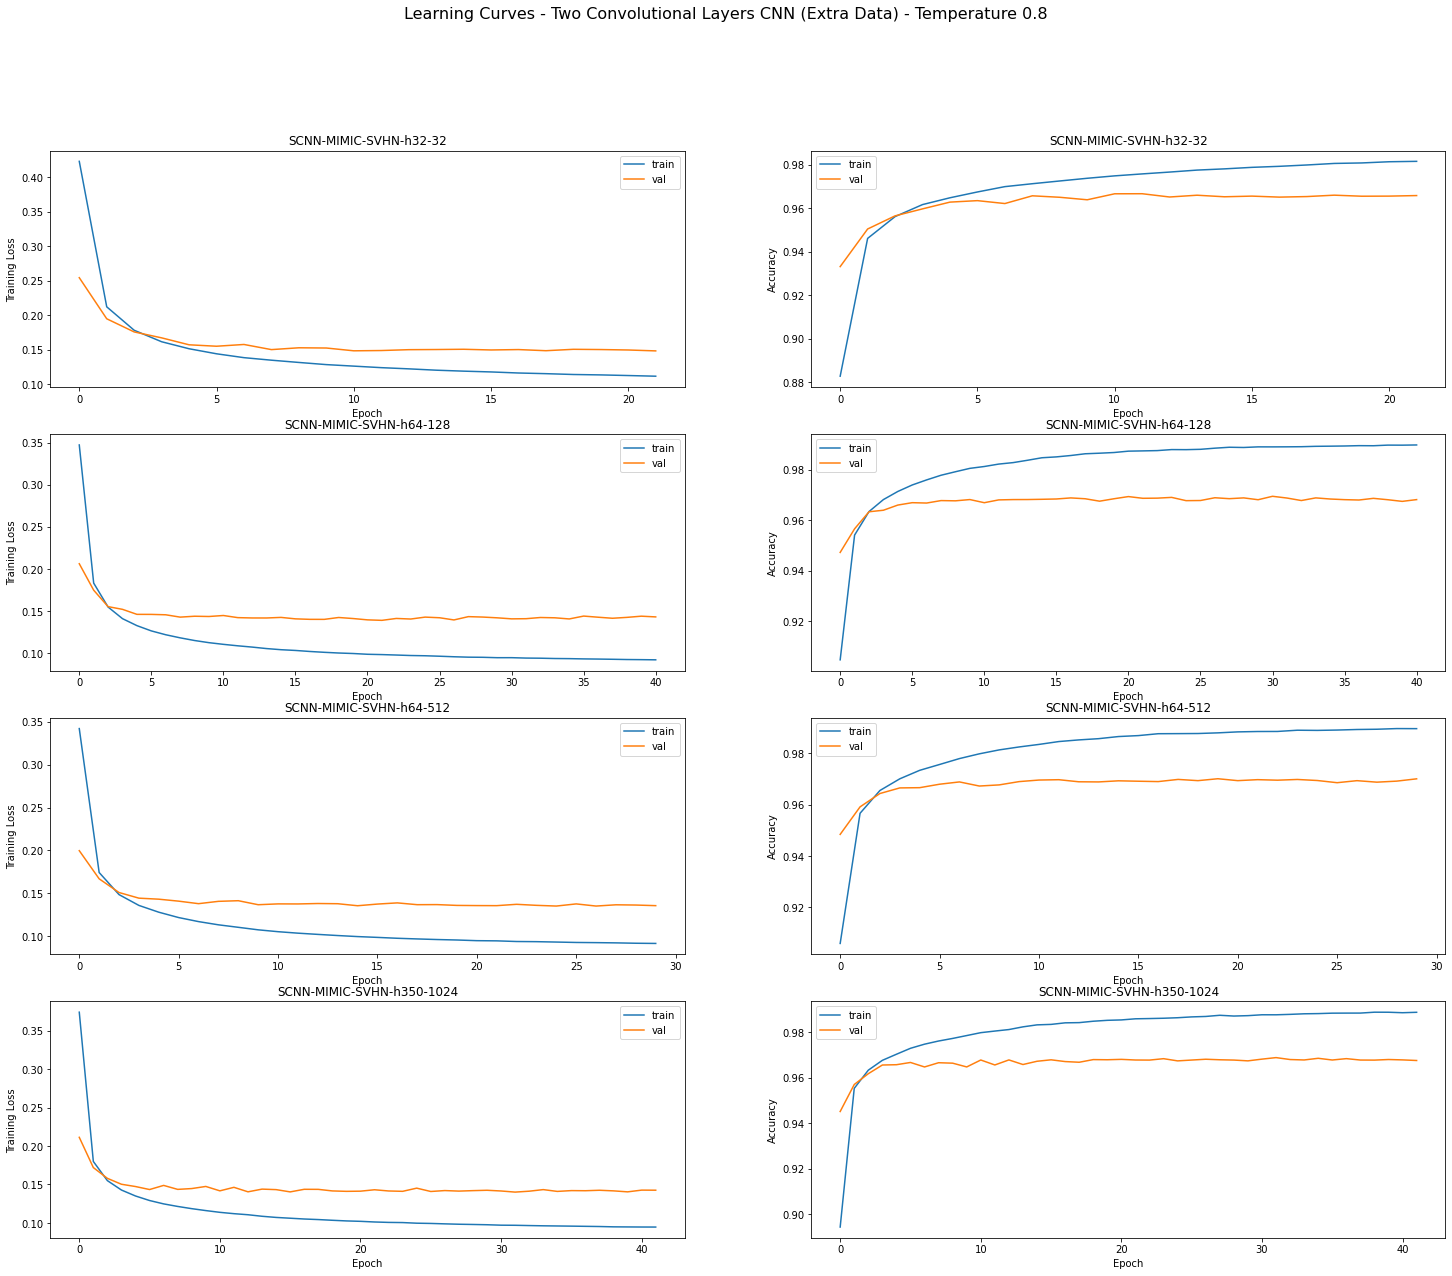

In [ ]:
fig = plt.figure()
fig.suptitle('Learning Curves - Two Convolutional Layers CNN (Extra Data) - Temperature 0.8', fontsize=16)
fig.set_size_inches(25, 20)

plt.subplot(4, 2, 1)
plt.plot(loss_train_32_32, label='train');
plt.plot(loss_test_32_32, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h32-32')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 2)
plt.plot(acc_train_32_32, label='train');
plt.plot(acc_test_32_32, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h32-32')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 3)
plt.plot(loss_train_64_128, label='train');
plt.plot(loss_test_64_128, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-128')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 4)
plt.plot(acc_train_64_128, label='train');
plt.plot(acc_test_64_128, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-128')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 5)
plt.plot(loss_train_64_512, label='train');
plt.plot(loss_test_64_512, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-512')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 6)
plt.plot(acc_train_64_512, label='train');
plt.plot(acc_test_64_512, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-512')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 7)
plt.plot(loss_train_350_1024, label='train');
plt.plot(loss_test_350_1024, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h350-1024')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 8)
plt.plot(acc_train_350_1024, label='train');
plt.plot(acc_test_350_1024, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h350-1024')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

In [ ]:
# Curves for Temperature 0.9
loss_train_32_32 = [0.4085660117076359, 0.21615536538382726, 0.18446690545633238, 0.1689448062123364, 0.15951030398665095, 0.15290628888611155, 0.14792103044615898, 0.14429284225035305, 0.14122020855040718, 0.13835688561286386, 0.13618242548324117, 0.13427560724807738, 0.13248809138457246, 0.1310670906294708, 0.12937914159301062, 0.12828831635702423, 0.12690194773817767, 0.12616357906106712, 0.1248989492798445, 0.12419632840904068, 0.12352732651701147, 0.12272716517522538, 0.12180200756643195, 0.12148641248411261]
loss_test_32_32 =[0.24635929730685968, 0.2011649771396028, 0.184074484168228, 0.17454238692270213, 0.16779847443005597, 0.1665205668448971, 0.1639336626961824, 0.16110869268669448, 0.16237306462175036, 0.16143883120804126, 0.15937541834148403, 0.15963266259892114, 0.16067401398907297, 0.15808217956083612, 0.16011436547841448, 0.15868852250322535, 0.16055771754807793, 0.15885439377558608, 0.161945500989778, 0.16292753421445672, 0.16131543469892826, 0.16030687460543994, 0.15904120713079872, 0.16257194989178272]
acc_train_32_32 =[0.889810404230241, 0.9481106320475288, 0.9578351815928379, 0.9630810724271117, 0.9663641669614066, 0.9689459266070602, 0.9708475326168884, 0.9725796885839922, 0.9738199687425148, 0.974848436352682, 0.9760840095633911, 0.9770559938244874, 0.9778561745756862, 0.9787151921352737, 0.9795577353932257, 0.9800354903684672, 0.9807838947139192, 0.9810663114469299, 0.981478169184207, 0.9819865193067685, 0.9823724888422946, 0.9826690264142564, 0.9829914521846025, 0.9836198294191704]
acc_test_32_32 =[0.9385937661485512, 0.9529498150086806, 0.9574025436313233, 0.9605373398589068, 0.9627213420429089, 0.9630790665385646, 0.9647358957490565, 0.965385448165952, 0.9654795861372583, 0.9646888267364703, 0.9664492077965351, 0.9659973453082512, 0.9657337588590903, 0.9666751390569491, 0.9662609318000563, 0.9660726557497112, 0.965432517124672, 0.9660067591214295, 0.96470765438471, 0.9647076543740489, 0.9661856213799183, 0.9660820695522285, 0.965536069006228, 0.9649900684602275]

loss_train_64_128 = [0.3814859927343626, 0.20379499704189424, 0.17406407624638537, 0.16024426681757076, 0.151125902758868, 0.1447838452946717, 0.14051609936872037, 0.13671806402755682, 0.13347968971929258, 0.13098173926345616, 0.12876616786787565, 0.1268302045138723, 0.12498375786728216, 0.12358467655322566, 0.12209431004310335, 0.12118009307177643, 0.12010746059589167, 0.11919623714315555, 0.11838702367433478, 0.1177803140867343, 0.11680838440272255, 0.11604482566807801, 0.1157899026703752, 0.1151421495567387, 0.11455378033688034, 0.11379411624837082, 0.11374573743250434, 0.1132335671045249, 0.11285623688704369, 0.11246742354712067, 0.11201239675771599, 0.11181592593394965, 0.11140117614551226, 0.1110761450366219, 0.1109506530615005, 0.11061669145921797, 0.11032607470372574, 0.11015871046024892, 0.10995787356174441]
loss_test_64_128 =[0.23320048686496347, 0.19429856675065316, 0.1721442099102159, 0.16919585828015127, 0.16130971797133614, 0.16570806029006724, 0.16149005193576424, 0.15666174810883582, 0.15670226593946412, 0.15892591561094546, 0.1569002659146866, 0.15770743795845538, 0.15702562619560412, 0.15399918674230878, 0.1546974865566266, 0.15261633209670594, 0.1547204102829413, 0.15622144214263195, 0.15614205965920983, 0.1538854712011735, 0.15476140421581874, 0.15602639459514503, 0.15522128482455977, 0.1552962987739149, 0.15392376000664698, 0.15476432424050396, 0.15500174708489703, 0.1540450808564024, 0.15436215659567828, 0.15420645916837997, 0.1545021532740047, 0.1537817555267809, 0.15471773699972577, 0.15624599203876838, 0.15403084547805826, 0.1544062898354281, 0.1541725247262325, 0.15401082364596022, 0.15552146358352834]
acc_train_64_128 =[0.8980875680198523, 0.951666729421452, 0.9610406115252461, 0.9659664300619583, 0.9694683975663283, 0.9720336829069798, 0.9738011409613615, 0.9757474629552162, 0.9768371208544122, 0.9780350385005703, 0.979484777736908, 0.9803720369777644, 0.981143976051061, 0.9818453109385799, 0.982704328506023, 0.9831232466605312, 0.9836810197115659, 0.9841470073217629, 0.984455312258769, 0.9848318679020351, 0.9853002089838944, 0.9856320486509894, 0.985737954925167, 0.9863804529919526, 0.986342797429646, 0.9868299662982697, 0.9866628697294522, 0.9870653135767138, 0.9871500385958314, 0.9874889386779131, 0.9873524372552933, 0.9877619415209082, 0.9877901831943215, 0.9879384519786191, 0.9880584790917478, 0.9883055937341141, 0.9884444486272739, 0.9883620770809406, 0.9883785513881873]
acc_test_64_128 =[0.9423498734062393, 0.9548514031384874, 0.9613845820747984, 0.9621659276837302, 0.9654795861804635, 0.9628531352461674, 0.9647453095841179, 0.9659785177032167, 0.9667692771359878, 0.9665245182598783, 0.9663174145938378, 0.9669293117681201, 0.9669104841630856, 0.966966966967528, 0.9674941398978331, 0.9683790373557767, 0.9676071055387011, 0.9664868630284873, 0.9669857945832236, 0.9675035537110114, 0.9677483125551378, 0.9663362421882112, 0.9673246914418616, 0.9679365886268049, 0.9684072787420064, 0.9677953815783851, 0.9670422773770051, 0.9673246914631836, 0.9684166925765068, 0.9680401404651556, 0.9677294849501034, 0.9682943131224604, 0.9673341052657008, 0.9672682086587411, 0.9676447607381091, 0.9672399672511893, 0.9679836576393912, 0.9675412088997584, 0.96726820864808]

loss_train_64_512 =  [0.34902826454640873, 0.18532685543448582, 0.1603456365229587, 0.14864280203792304, 0.14137945819798392, 0.13550102415635268, 0.1314355658499383, 0.1280066302283986, 0.1251901112403007, 0.12265460541523356, 0.12053423436382103, 0.11885344870822669, 0.11719466474668169, 0.11608365258375235, 0.11486574412772546, 0.1141118258852256, 0.1129819035636421, 0.11225410385543289, 0.11166476283594945, 0.11084452166715972, 0.11035988082459387, 0.10976719736661261, 0.109368111167902, 0.10878944842186684, 0.10862862505127427, 0.10836019492093467, 0.1077699430535597, 0.10750619410941623, 0.10714049643069051, 0.10688899850878106, 0.10666069230380551, 0.10640028883265158, 0.106129036391156, 0.10594145757083809, 0.10574143872035616, 0.10553306981946727]
loss_test_64_512 = [0.20828972093101877, 0.17592034300153206, 0.1603585374794999, 0.16124450413331823, 0.1574885746259873, 0.16384336010213726, 0.1526920393553858, 0.15128645207188468, 0.1489522371570917, 0.1480749645908008, 0.151069910952694, 0.14848997747185386, 0.14831726879465848, 0.14849815271850275, 0.14802848839647717, 0.147597385815663, 0.14704319595607723, 0.14782475729483185, 0.14797948883771864, 0.14751607598058733, 0.14677706931420037, 0.1481430474523029, 0.1481343635114019, 0.1486850374857212, 0.14694034651486995, 0.14617286512379085, 0.14899580400149795, 0.14816794963176994, 0.14617845701910637, 0.14600087688429023, 0.1483867419471108, 0.14625486886703198, 0.14842798816925673, 0.1460794330600497, 0.14684501236833886, 0.14710485089553765]
acc_train_64_512 =[0.9067601152293941, 0.9573291849430609, 0.9661264662169113, 0.9702921130386382, 0.9732316005542602, 0.9758345414448738, 0.9777808634387285, 0.9791411707092574, 0.9806638676019128, 0.9818288366302109, 0.9829537966222959, 0.9839563760284676, 0.9847094873149997, 0.9852766742594167, 0.9856626437960649, 0.9862839606111573, 0.9867758364219832, 0.987100615666236, 0.9873124282179578, 0.9874301018560576, 0.9880820138184699, 0.9883644305503584, 0.9881479110575565, 0.9885385875386514, 0.9886421403400446, 0.9886233125588914, 0.9890163425150151, 0.9890845932257639, 0.9890563515523506, 0.9893928981605257, 0.98945173497677, 0.9894446745595389, 0.9894140794110967, 0.989576469037712, 0.98947056276129, 0.9897223843492251]
acc_test_64_512 =[0.9496455703251256, 0.9598030632732223, 0.9653666205395954, 0.9657902416528718, 0.9663174145938378, 0.9637192050884156, 0.9673811742996091, 0.9682284165048397, 0.9698381767027454, 0.9696028316830193, 0.9686614514206332, 0.9695369350653985, 0.9691980381854386, 0.9695086936685078, 0.9692356933741855, 0.9695840040779848, 0.9693392452231974, 0.9695086936146416, 0.9698758319560196, 0.9698381767459506, 0.9702147288573016, 0.9698758319560196, 0.9698758319560196, 0.9699040733529103, 0.9698758319666806, 0.9704124186888419, 0.9695086936685078, 0.9702900392561176, 0.9699699699811921, 0.9698381767459506, 0.9693110037617794, 0.9701017632057726, 0.969593417891163, 0.9699511423868186, 0.9700829356113991, 0.9698099353383989]

loss_train_350_1024 = [0.37019040583363433, 0.1900081503788084, 0.16555084485126564, 0.15461497711003666, 0.14711401755589873, 0.14127694058597942, 0.13769407136735018, 0.1340827168416167, 0.13147570990630456, 0.12894068455173374, 0.12690983698617342, 0.1253203862086616, 0.12347967803002419, 0.12247243837062734, 0.12115967563554375, 0.12009946007728398, 0.11897516702375359, 0.11829890204601991, 0.11740035978354824, 0.11669739894277843, 0.11581063397828967, 0.11538048661810271, 0.11482849272206724, 0.11419421048680299, 0.11381874825976074, 0.11314552170042039, 0.11281623634549949, 0.11238832379028016, 0.11227438134144545, 0.11171822300894421, 0.11117847605782506, 0.11123382358367834, 0.1108003513992698, 0.11057918514839853]
loss_test_350_1024 =[0.2136556329422447, 0.1811638894190206, 0.16631913220539468, 0.15947380443834322, 0.1589261300318474, 0.16314633271950205, 0.16067312071505013, 0.15508227663523522, 0.1550295857593444, 0.15274342763760246, 0.15344064911492167, 0.1540181699435383, 0.15285986304822927, 0.15126615872168395, 0.15193260914753498, 0.15166201801917806, 0.15487711796610004, 0.15399745082120625, 0.15374047556292514, 0.15270809847064232, 0.15105966932444087, 0.15291656842771154, 0.15209269278487267, 0.15189231733854225, 0.15244451886627747, 0.15234593764398197, 0.1519341463453872, 0.15293554594703782, 0.15298339807444175, 0.1532867451940892, 0.1532240362511294, 0.15585065992790845, 0.15308489877406323, 0.15514849929604788]
acc_train_350_1024 =[0.8990054223968065, 0.9557452977613767, 0.9642436879837477, 0.9682139965778325, 0.9711299493577545, 0.9734669478282153, 0.9748249016248376, 0.9766441360872102, 0.9779385461175305, 0.9790540922184776, 0.9801766987355336, 0.980953344754399, 0.9820712443270083, 0.9823112985510213, 0.9830620563681357, 0.9835515787084216, 0.9841728955246362, 0.9843376386173025, 0.9849471880695949, 0.9851684145113323, 0.9856438160137894, 0.9855379097396118, 0.9857732570158114, 0.9864745919078192, 0.9863828064692259, 0.9868323197710541, 0.9869523468830607, 0.9873218421102178, 0.9871194434496338, 0.9873147816896201, 0.9877478206842016, 0.9874795247867754, 0.988162031893141, 0.9878043040310281]
acc_test_350_1024 =[0.948873638540033, 0.9590970280844284, 0.9631920321687715, 0.9662044489742918, 0.9664209664321886, 0.9638698259606746, 0.9651406892685204, 0.9673341052763619, 0.9672211396248328, 0.9683413821350467, 0.9680307266413164, 0.9683696235532595, 0.9685296581853917, 0.9687179342570588, 0.9680589680595292, 0.9685202443828744, 0.9673811742996091, 0.9685578995929435, 0.9681907612622265, 0.9686237962212252, 0.9687838308640185, 0.9679177610324314, 0.9683319683431905, 0.9691227277439785, 0.968313140738156, 0.9685578996142655, 0.9690380035426452, 0.968614382408047, 0.9682284164835177, 0.9683319683431905, 0.9688214860740875, 0.9679742438368739, 0.9681154508746327, 0.9681436922928455]


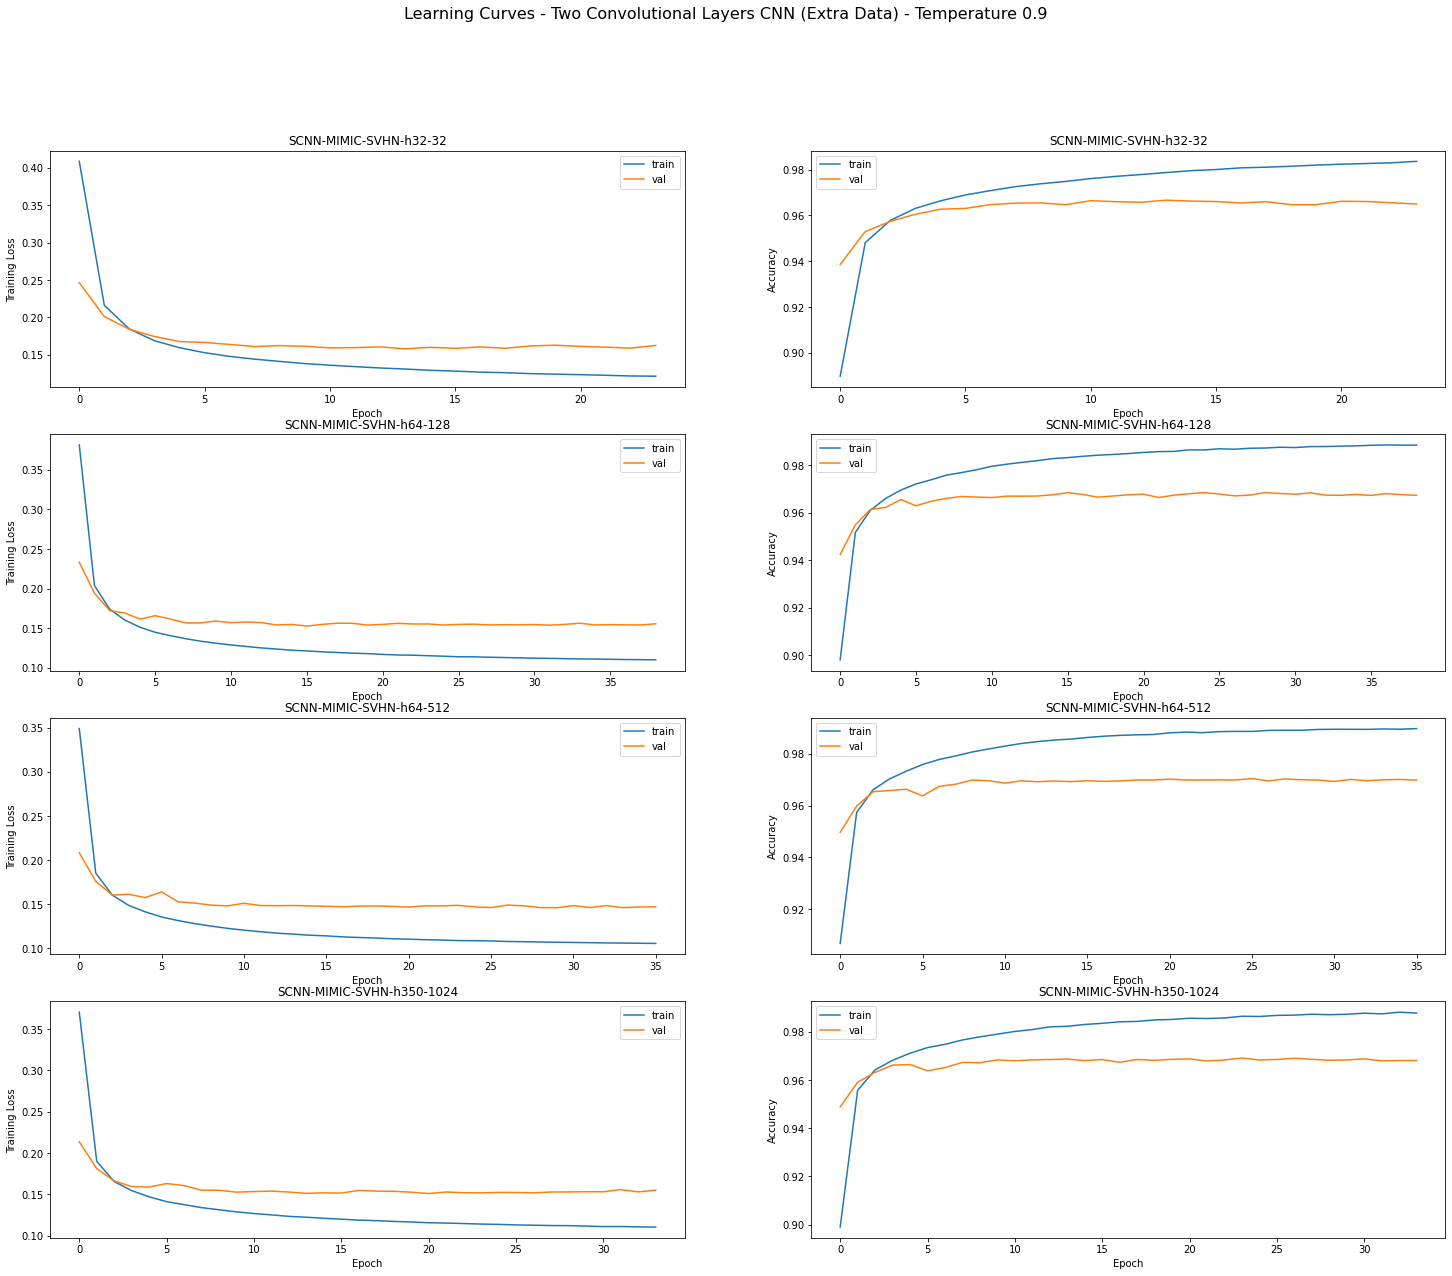

In [ ]:
fig = plt.figure()
fig.suptitle('Learning Curves - Two Convolutional Layers CNN (Extra Data) - Temperature 0.9', fontsize=16)
fig.set_size_inches(25, 20)

plt.subplot(4, 2, 1)
plt.plot(loss_train_32_32, label='train');
plt.plot(loss_test_32_32, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h32-32')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 2)
plt.plot(acc_train_32_32, label='train');
plt.plot(acc_test_32_32, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h32-32')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 3)
plt.plot(loss_train_64_128, label='train');
plt.plot(loss_test_64_128, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-128')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 4)
plt.plot(acc_train_64_128, label='train');
plt.plot(acc_test_64_128, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-128')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 5)
plt.plot(loss_train_64_512, label='train');
plt.plot(loss_test_64_512, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-512')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 6)
plt.plot(acc_train_64_512, label='train');
plt.plot(acc_test_64_512, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-512')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 7)
plt.plot(loss_train_350_1024, label='train');
plt.plot(loss_test_350_1024, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h350-1024')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 8)
plt.plot(acc_train_350_1024, label='train');
plt.plot(acc_test_350_1024, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h350-1024')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

In [ ]:
# Curves for Temperature 1.0
loss_train_32_32 = [0.43548618935738326, 0.2316157757439714, 0.20197075238944473, 0.1872199509706871, 0.1785296046513676, 0.17236640222937769, 0.16759163821359999, 0.16394685337768963, 0.16086940555480217, 0.15840356047222534, 0.15651315300511354, 0.15469395895403604, 0.15301710695705567, 0.1516816357002926, 0.15028501729444677, 0.14918694336035968, 0.14837165446468553, 0.14738016229663578, 0.14628929092591028, 0.14545737122095803, 0.1449858709226283, 0.14427096324511662, 0.14376493478087093, 0.1432426312942085, 0.1425050417315479, 0.14188280779463452, 0.14168092091219137, 0.14119539491251085, 0.14088068988146216, 0.1401915124856007, 0.13993737278838092, 0.13960654471045938, 0.13921231873702525, 0.13897954909265914, 0.13858739146200877, 0.13831664046971115]
loss_test_32_32 =[0.25684314632147115, 0.20961086311337931, 0.20020716984648707, 0.19332039005610355, 0.18582725339260306, 0.18276130888082132, 0.1799295543375867, 0.17668389447341803, 0.1774306818121165, 0.17535735404532835, 0.17534204262869804, 0.17611519560117278, 0.17648321036416503, 0.17713238305317644, 0.1724117869191574, 0.17314798784251267, 0.17376997073631692, 0.17370040612928006, 0.17385301655926677, 0.1741592285350615, 0.17393578739044477, 0.17385622872341464, 0.17532229363021656, 0.1758268661104431, 0.17505973679578662, 0.1726970382787573, 0.17402536230277182, 0.17661059151184344, 0.17303205338665772, 0.17483070638996817, 0.17393166006000826, 0.17599070819329268, 0.17548645385728334, 0.1758390869065578, 0.17481388004495518, 0.17563439150155838]
acc_train_32_32 =[0.8836301846971775, 0.947505789539683, 0.956912620261337, 0.9618219644952916, 0.9650250409470598, 0.9670772692184587, 0.9691271440125844, 0.9705674693566622, 0.9718948280070867, 0.9729915463257582, 0.9740270743509122, 0.9748554967699131, 0.9755380038785232, 0.975938094251878, 0.9769053715629166, 0.9773666522309113, 0.977769096078173, 0.97822331632557, 0.9786822435151693, 0.9793671040954415, 0.9798636868540808, 0.9798024965616853, 0.9800496112040515, 0.9802143543000846, 0.9808803870980813, 0.980807429438397, 0.9812169337062564, 0.9813534351288762, 0.9819159151243575, 0.9821324346182816, 0.9822195131101837, 0.9823442471700035, 0.9825913618134919, 0.9824219117718901, 0.9828008208890627, 0.9832009112635399]
acc_test_32_32 =[0.9396951810862747, 0.9542959887793085, 0.9573460607623536, 0.95960537342036, 0.9619117550051034, 0.9633426529658423, 0.9643969988909796, 0.9655454827548791, 0.9646135163488764, 0.965649034615113, 0.9653666205609175, 0.9646135163056712, 0.9651124478822907, 0.9646794129771582, 0.9663644836277461, 0.9659220349094353, 0.9661950351285693, 0.9665056906655048, 0.9660914833547458, 0.9655172414011934, 0.965950276316987, 0.9664680354015696, 0.9661856213799183, 0.9658090692792283, 0.9660350005289813, 0.9667692771359878, 0.9660914833334238, 0.9663080007587763, 0.9660538281446768, 0.965498413796159, 0.966364483617085, 0.9660444143421595, 0.9662609317893953, 0.9662326903818436, 0.965912621096257, 0.9653289653188654]

loss_train_64_128 = [0.3694597340004613, 0.20708585439549262, 0.18112015883874502, 0.16851342947086065, 0.1607655520887521, 0.15570890055268494, 0.15163579032240568, 0.14861526125073915, 0.14592264930408702, 0.14352744447343974, 0.14159357836143335, 0.14014507536429088, 0.1383935249883885, 0.13715900345659596, 0.13605186959013077, 0.1351259822665948, 0.1342641249957093, 0.1331488415137355, 0.13270472408557493, 0.13187082057716262, 0.13126639812141633, 0.13073326227850698, 0.1301513076870256, 0.12979154379332186, 0.1291548793744532]
loss_test_64_128 =[0.23370857431978087, 0.19413676238038002, 0.1788098098350738, 0.17515824287808573, 0.1781121169720252, 0.16992229975442466, 0.1663039144190388, 0.16600904955832824, 0.16794008203715274, 0.1648977646902426, 0.167805983534186, 0.16800031220708017, 0.16401576812536164, 0.16460647150588395, 0.1629318619590375, 0.16449518163004642, 0.1655438969170174, 0.16558324146471853, 0.16447473802720675, 0.16371805359989725, 0.1625724671393998, 0.16605169895919572, 0.16485947326903155, 0.1642671684479071, 0.16311461026465518]
acc_train_64_128 =[0.9053621523909475, 0.9555146574251349, 0.9638741927588349, 0.9685223015058609, 0.9714735563775496, 0.9737681923412571, 0.9757592303180161, 0.9770277521499519, 0.9782256697949878, 0.9794565360612503, 0.9804779432508198, 0.9811180878493099, 0.9820382957069039, 0.9829773313478958, 0.9835068627232728, 0.9839304878278388, 0.9842811552727204, 0.9850625082349103, 0.9850060248903282, 0.9854037617908986, 0.985716773670107, 0.9858603355088357, 0.986323969649615, 0.9863451509046749, 0.9869617607708318]
acc_test_64_128 =[0.9476027752108652, 0.9597089252155055, 0.9643875850452572, 0.9651218616741469, 0.9647170681872271, 0.9667410356964531, 0.9684637615571099, 0.9690003483219153, 0.9673811742889481, 0.9693392452125363, 0.9671364154021775, 0.9679742438368739, 0.9696404868824273, 0.9688873826917083, 0.9704594876907671, 0.9687932446665357, 0.9681625198765579, 0.9694992798659906, 0.9692074519772947, 0.9689438654854897, 0.9700546941931864, 0.9691980381534555, 0.9689626930905242, 0.9687367618407712, 0.9696593144768008]

loss_train_64_512 = [0.34641843629633456, 0.19592602098418838, 0.17197023041182605, 0.16105865410742318, 0.15386633982526055, 0.1489652269612712, 0.14495005839630254, 0.1417820562451762, 0.13899405991962865, 0.13669273681967967, 0.1349687183713591, 0.13337936645849138, 0.13210786395721089, 0.1308448742664469, 0.12999726870096642, 0.12903770117983318, 0.12834076068256928, 0.1276113433648392, 0.12684692416970733, 0.12647347381405144, 0.12583105866090882, 0.12537463029136636, 0.12518654248261427, 0.12463149456689725, 0.12424349890466312, 0.1238290986927035, 0.12362804552592262, 0.12350298733968501, 0.12310676447303828, 0.12273992996726611, 0.12253324076233965, 0.12235272760382303, 0.12213705706058381, 0.12179101369420027, 0.12181302358812468, 0.12172231951377874, 0.12130088830016422, 0.12133960647268381, 0.12111200665423447]
loss_test_64_512 = [0.22214188154940112, 0.18877783919541216, 0.1763725263258006, 0.17161414651893755, 0.1679012899528049, 0.1652443228751328, 0.16663626675464846, 0.1637552186212823, 0.1633746556932294, 0.16310752873717452, 0.16966288545491195, 0.1620216889277918, 0.16062525219478377, 0.16252926905998166, 0.16058411478168083, 0.16063665642039496, 0.16172923881156603, 0.16094123674323665, 0.1611103958194069, 0.1592844403829968, 0.16078295887969277, 0.15930651002926896, 0.16037952606319933, 0.15937340890165408, 0.15918429787679764, 0.15989235588472187, 0.1589681219389491, 0.16007906946273998, 0.15926346969213737, 0.15981503515826542, 0.16044118809897184, 0.16140923843236488, 0.15929961410679283, 0.15931965296257714, 0.15822016413744402, 0.15901984370757377, 0.1590757226755887, 0.16013133375948826, 0.15868096998419248]
acc_train_64_512 =[0.9115564927562289, 0.9587295012475586, 0.9668042663799525, 0.9713276410660365, 0.974309491089534, 0.9767053263796057, 0.9784186545655563, 0.9802684841718823, 0.9816429122779957, 0.982822002145245, 0.9837116148566413, 0.9845094421305667, 0.9850648617065725, 0.9854367104087586, 0.9862157098992862, 0.9864251689782237, 0.9867122926556811, 0.9871076760868337, 0.9874253949127332, 0.9874042136576733, 0.9876819234451151, 0.9880631860361945, 0.9880537721428122, 0.9881926270382164, 0.9883503097170184, 0.9887268653614067, 0.9887362792525445, 0.9885550618481426, 0.9888515994201043, 0.9891834390815882, 0.9890963605885639, 0.9891010675341328, 0.9893246474475325, 0.98949174401635, 0.9892022668627415, 0.9892352154839681, 0.9896611940568297, 0.9894470280334455, 0.9896047107111253]
acc_test_64_512 =[0.9491654664074068, 0.9619305826314599, 0.9645382059287384, 0.9660444143427206, 0.9673246914738446, 0.9682566579230525, 0.9681531060953626, 0.9685673134061217, 0.9690191759162887, 0.9696404868824273, 0.966703380486384, 0.9694616246020553, 0.9704218324913592, 0.9703559358737384, 0.9697911077440253, 0.9695086936146416, 0.970007625158717, 0.9699982113887439, 0.9705065567246753, 0.9702900392667786, 0.9698287629434333, 0.9706383499599169, 0.9704312462719932, 0.9701864873958836, 0.9701676598233934, 0.9702241426491579, 0.9711561091090267, 0.9705065567140144, 0.9713349713355325, 0.9702900392774396, 0.9708172122077446, 0.9695275212628813, 0.9704689014714012, 0.9705818671554745, 0.9708172121645395, 0.9705912809473306, 0.970864281220331, 0.9708454536259574, 0.970638349970578]

loss_train_350_1024 = [0.349831082932475, 0.19325764462804335, 0.17285538554155677, 0.16206136525362955, 0.15484358409104979, 0.14990326138411594, 0.1459055616173736, 0.1426289361068804, 0.14032073356917485, 0.13804897362247748, 0.1362406857659755, 0.13479634644541338, 0.13323715833946256, 0.13199472153601796, 0.13104540989415364, 0.1301070120268167, 0.12922884639177, 0.12854012279270072, 0.12793240856936244, 0.12717733475910825, 0.12691540355561218, 0.12615361223088314, 0.1257875820108887]
loss_test_350_1024 =[0.21644202648119887, 0.1819527958210596, 0.17571287265080518, 0.17011499124396132, 0.16855198356085097, 0.1674982694897246, 0.16307774762166122, 0.1640323292227757, 0.1643355962465951, 0.16500885256582845, 0.16306088939093796, 0.16152172805486914, 0.16106717079313662, 0.16091226225977087, 0.16167096814552792, 0.16077538196263336, 0.16276338160048096, 0.16053271297525798, 0.16128018092291935, 0.16129759363768018, 0.1592386728387859, 0.16035908024272708, 0.16000453487355779]
acc_train_350_1024 =[0.909610170766863, 0.9593837666838776, 0.9668701636111835, 0.9710899403125636, 0.9740929715866321, 0.976258166550562, 0.9783080413435654, 0.979764840996012, 0.9810474836646544, 0.9820830116886862, 0.9830055730235535, 0.9838198746036034, 0.9845518046429311, 0.9851025172744903, 0.9852813812049855, 0.9858320938354224, 0.9862769001916817, 0.9865310752524014, 0.9868487940783008, 0.9873900928209666, 0.9870700205222827, 0.9877054581740817, 0.9877807693020616]
acc_test_350_1024 =[0.9521119865953063, 0.9634650324417718, 0.9658278968842627, 0.9666657252976371, 0.9694522108534043, 0.968011899046943, 0.9690944863364268, 0.9691415553596741, 0.968765003227001, 0.9691886243722603, 0.9700735218195429, 0.9699323147817841, 0.9709866606637162, 0.9701017632270946, 0.969819349140916, 0.9705065567246753, 0.9698852457585369, 0.9704877291196409, 0.9704030048863246, 0.9702053150334623, 0.9707230741719112, 0.9708454536259574, 0.9707983846027102]


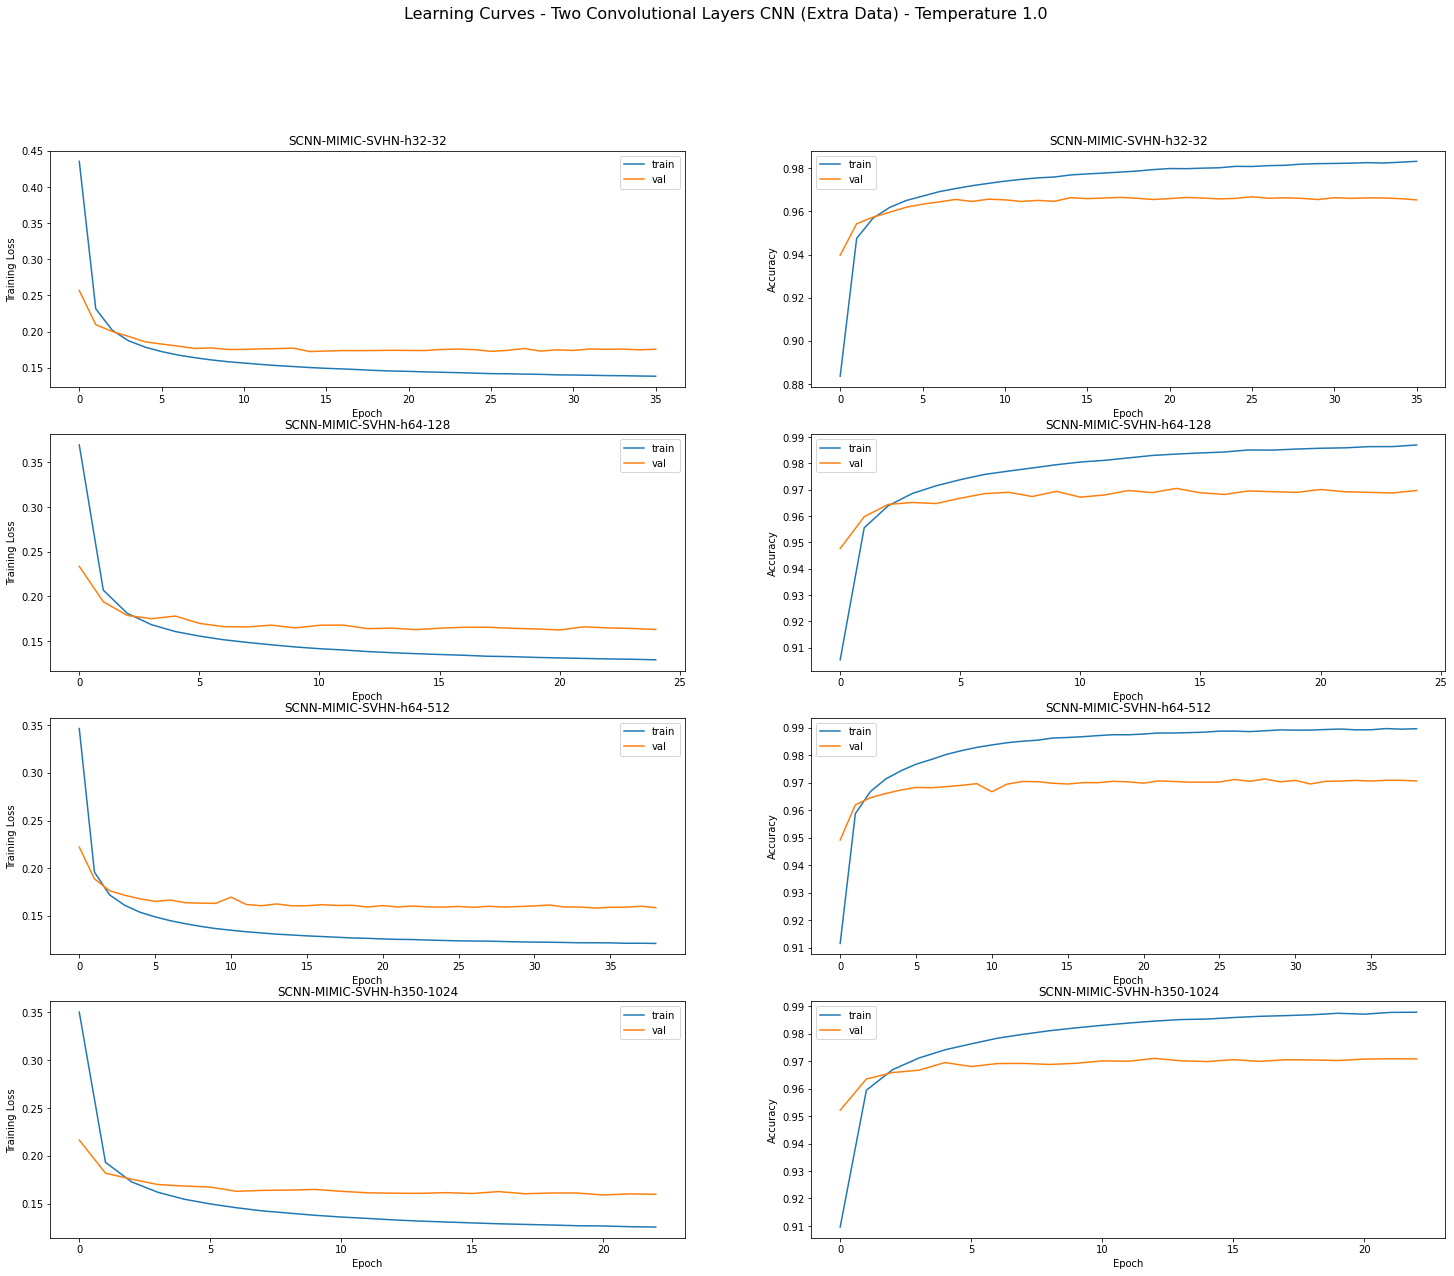

In [ ]:
fig = plt.figure()
fig.suptitle('Learning Curves - Two Convolutional Layers CNN (Extra Data) - Temperature 1.0', fontsize=16)
fig.set_size_inches(25, 20)

plt.subplot(4, 2, 1)
plt.plot(loss_train_32_32, label='train');
plt.plot(loss_test_32_32, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h32-32')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 2)
plt.plot(acc_train_32_32, label='train');
plt.plot(acc_test_32_32, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h32-32')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 3)
plt.plot(loss_train_64_128, label='train');
plt.plot(loss_test_64_128, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-128')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 4)
plt.plot(acc_train_64_128, label='train');
plt.plot(acc_test_64_128, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-128')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 5)
plt.plot(loss_train_64_512, label='train');
plt.plot(loss_test_64_512, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-512')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 6)
plt.plot(acc_train_64_512, label='train');
plt.plot(acc_test_64_512, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h64-512')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

plt.subplot(4, 2, 7)
plt.plot(loss_train_350_1024, label='train');
plt.plot(loss_test_350_1024, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h350-1024')
plt.xlabel('Epoch');
plt.ylabel('Training Loss');

plt.subplot(4, 2, 8)
plt.plot(acc_train_350_1024, label='train');
plt.plot(acc_test_350_1024, label='val');
plt.legend();
plt.title('SCNN-MIMIC-SVHN-h350-1024')
plt.xlabel('Epoch');
plt.ylabel('Accuracy');

##### Accuracy Results Raising - Adam

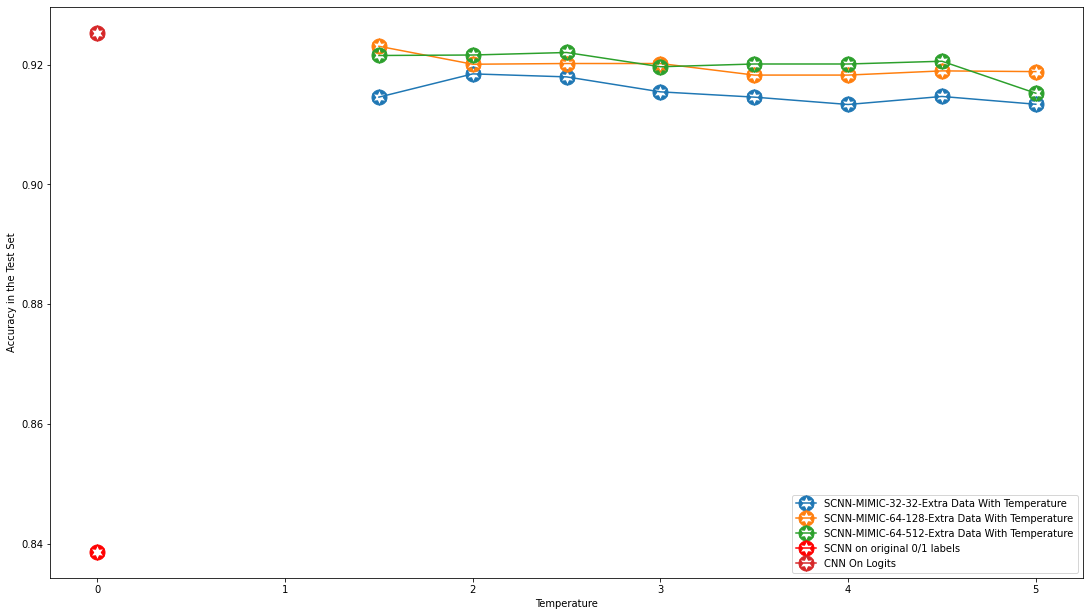

In [ ]:
import matplotlib.path as mpath
import numpy as np
import matplotlib.patches as patches

star = mpath.Path.unit_regular_star(6)
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
verts = np.concatenate([circle.vertices, star.vertices[::-1, ...]])
codes = np.concatenate([circle.codes, star.codes])
cut_star = mpath.Path(verts, codes)

fig = plt.figure()
fig.set_size_inches(18.5, 10.5)

plt.plot([1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0], [0.91457, 0.91845, 0.91795, 0.91545, 0.91457, 0.91334, 0.91468, 0.91338], label='SCNN-MIMIC-32-32-Extra Data With Temperature', marker=cut_star, markersize=15)
plt.plot([1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0], [0.92306, 0.92006, 0.92018, 0.92018, 0.91825, 0.91825, 0.91895, 0.91883], label='SCNN-MIMIC-64-128-Extra Data With Temperature', marker=cut_star, markersize=15)
plt.plot([1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0], [0.92152, 0.92160, 0.92202, 0.91964, 0.92010, 0.92010, 0.92056, 0.91522], label='SCNN-MIMIC-64-512-Extra Data With Temperature', marker=cut_star, markersize=15)

plt.plot(0, 0.83866, marker=cut_star, markersize=15, color="red" ,label='SCNN on original 0/1 labels')
plt.plot(0, 0.92528, marker=cut_star, markersize=15, label='CNN On Logits')

plt.xlabel('Temperature');
plt.ylabel('Accuracy in the Test Set');
plt.legend()
plt.show()

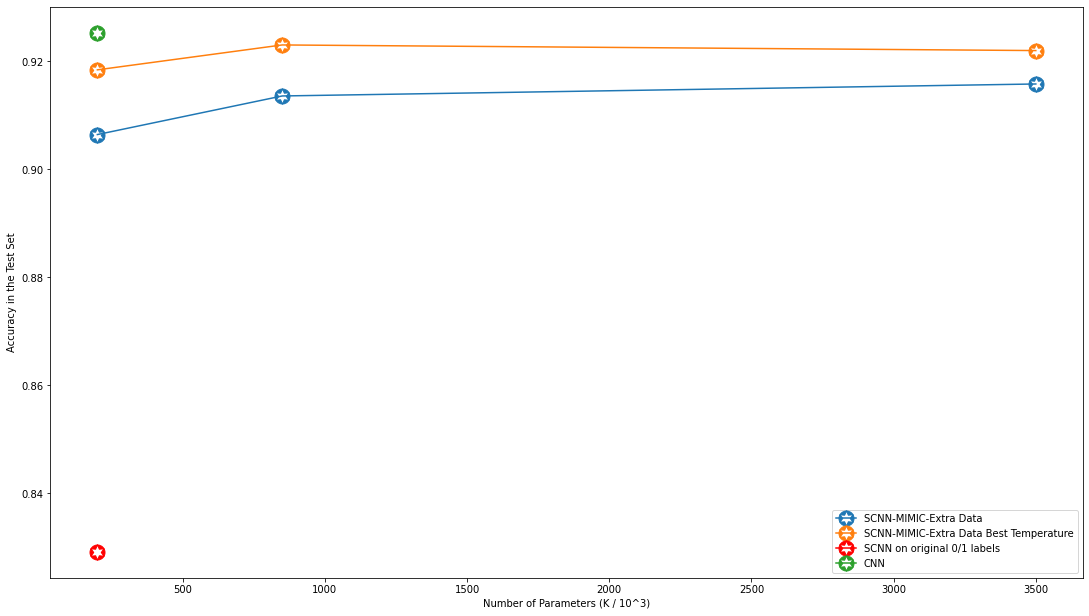

In [ ]:
import matplotlib.path as mpath
import numpy as np

star = mpath.Path.unit_regular_star(6)
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
verts = np.concatenate([circle.vertices, star.vertices[::-1, ...]])
codes = np.concatenate([circle.codes, star.codes])
cut_star = mpath.Path(verts, codes)

fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
plt.plot([200, 850, 3500], [0.90646, 0.91361, 0.91583], label='SCNN-MIMIC-Extra Data', marker=cut_star, markersize=15)
plt.plot([200, 850, 3500], [0.91845, 0.92306, 0.92202], label='SCNN-MIMIC-Extra Data Best Temperature', marker=cut_star, markersize=15)
plt.plot(200, 0.82916, marker=cut_star, markersize=15, color="red" ,label='SCNN on original 0/1 labels')
plt.plot(200, 0.92528, marker=cut_star, markersize=15, label='CNN')

plt.xlabel('Number of Parameters (K / 10^3)');
plt.ylabel('Accuracy in the Test Set');
plt.legend()
plt.show()

##### Accuracy Results Raising - SGD

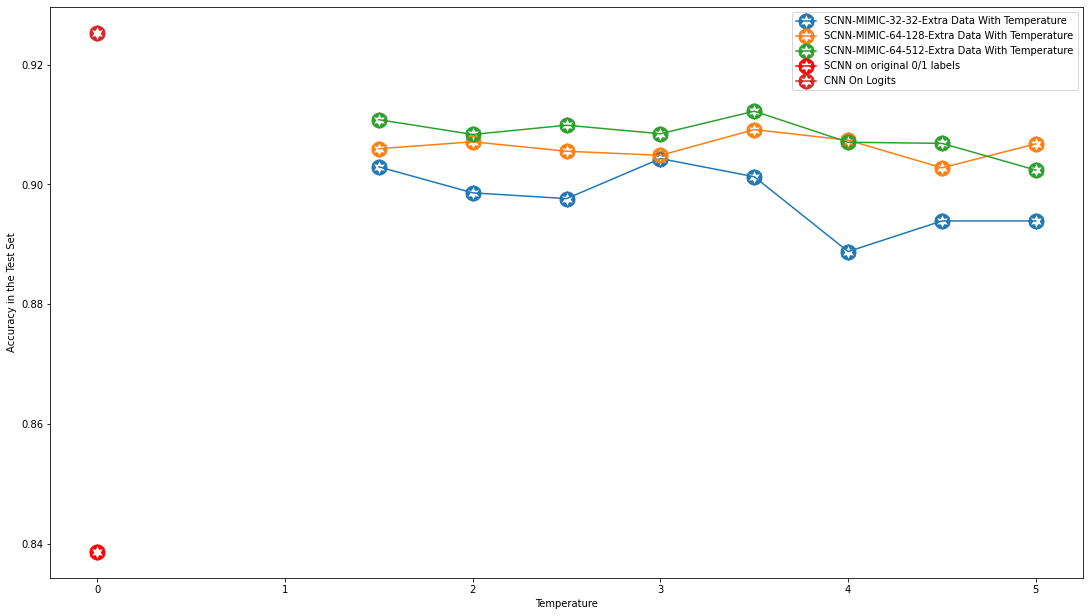

In [ ]:
import matplotlib.path as mpath
import numpy as np
import matplotlib.patches as patches

star = mpath.Path.unit_regular_star(6)
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
verts = np.concatenate([circle.vertices, star.vertices[::-1, ...]])
codes = np.concatenate([circle.codes, star.codes])
cut_star = mpath.Path(verts, codes)

fig = plt.figure()
fig.set_size_inches(18.5, 10.5)

plt.plot([1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0], [0.90293, 0.89859, 0.89763, 0.90431, 0.90128, 0.88879, 0.89390, 0.89390], label='SCNN-MIMIC-32-32-Extra Data With Temperature', marker=cut_star, markersize=15)
plt.plot([1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0], [0.90596, 0.90711, 0.90554, 0.90485, 0.90915, 0.90738, 0.90277, 0.90677], label='SCNN-MIMIC-64-128-Extra Data With Temperature', marker=cut_star, markersize=15)
plt.plot([1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0], [0.91080, 0.90834, 0.90988, 0.90846, 0.91222, 0.90704, 0.90685, 0.90239], label='SCNN-MIMIC-64-512-Extra Data With Temperature', marker=cut_star, markersize=15)

plt.plot(0, 0.83866, marker=cut_star, markersize=15, color="red" ,label='SCNN on original 0/1 labels')
plt.plot(0, 0.92528, marker=cut_star, markersize=15, label='CNN On Logits')

plt.xlabel('Temperature');
plt.ylabel('Accuracy in the Test Set');
plt.legend()
plt.show()

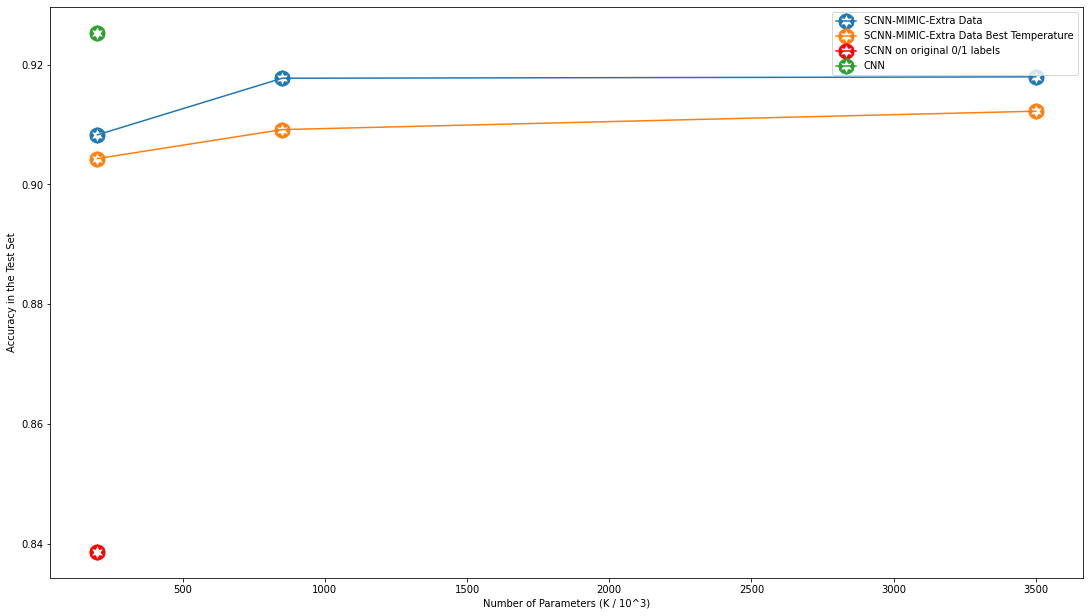

In [ ]:
import matplotlib.path as mpath
import numpy as np

star = mpath.Path.unit_regular_star(6)
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
verts = np.concatenate([circle.vertices, star.vertices[::-1, ...]])
codes = np.concatenate([circle.codes, star.codes])
cut_star = mpath.Path(verts, codes)

fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
plt.plot([200, 850, 3500], [0.90827, 0.91772, 0.91795], label='SCNN-MIMIC-Extra Data', marker=cut_star, markersize=15)
plt.plot([200, 850, 3500], [0.90431, 0.90915, 0.91222], label='SCNN-MIMIC-Extra Data Best Temperature', marker=cut_star, markersize=15)
plt.plot(200, 0.83866, marker=cut_star, markersize=15, color="red" ,label='SCNN on original 0/1 labels')
plt.plot(200, 0.92528, marker=cut_star, markersize=15, label='CNN')

plt.xlabel('Number of Parameters (K / 10^3)');
plt.ylabel('Accuracy in the Test Set');
plt.legend()
plt.show()

##### Accuracy Results [0.1-5] - Adam

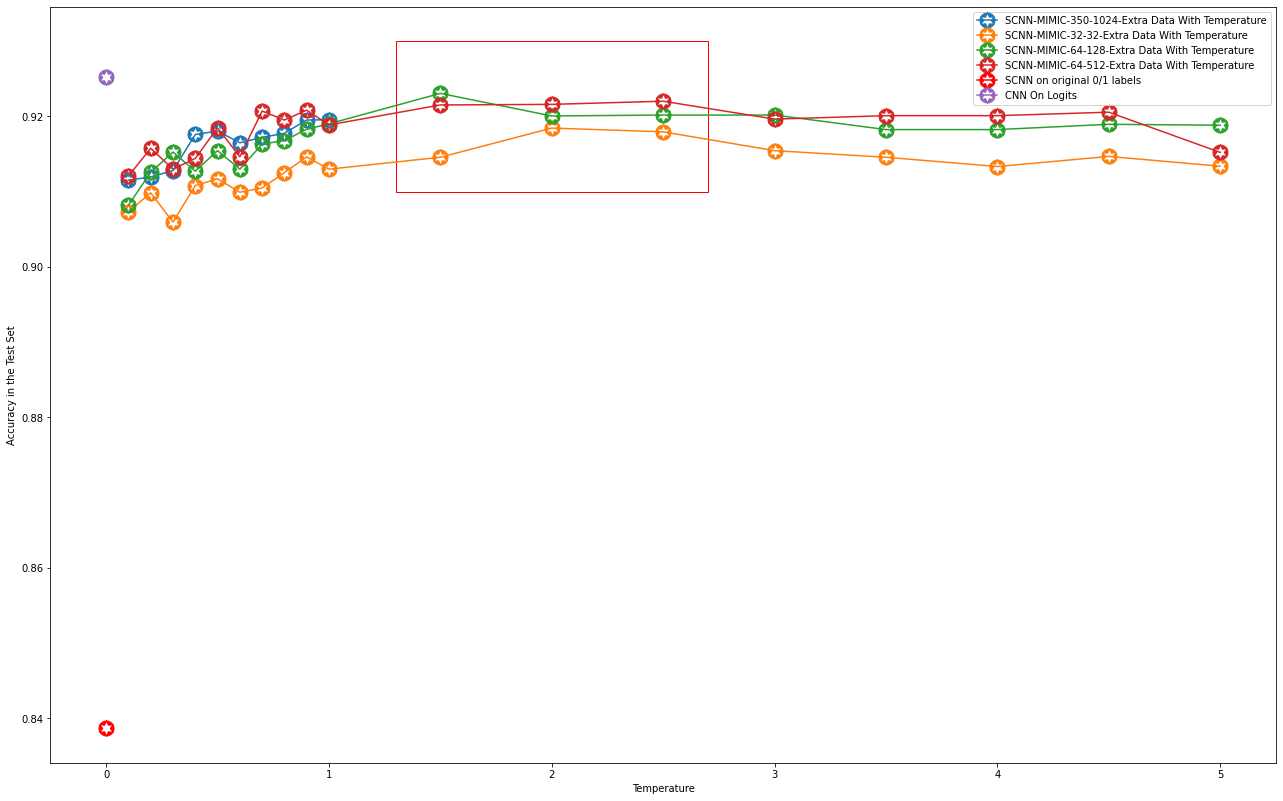

In [ ]:
import matplotlib.path as mpath
import numpy as np
import matplotlib.patches as patches
rect = patches.Rectangle( (1.3, 0.91), 1.4, 0.02, linewidth=1, edgecolor='r', facecolor='none')


star = mpath.Path.unit_regular_star(6)
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
verts = np.concatenate([circle.vertices, star.vertices[::-1, ...]])
codes = np.concatenate([circle.codes, star.codes])
cut_star = mpath.Path(verts, codes)

fig = plt.figure()
ax = fig.add_axes([0,0,0.92,1])
ax.add_patch(rect)
fig.set_size_inches(18.5, 10.5)

plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], [0.91153, 0.91195, 0.91280, 0.91760, 0.91806, 0.91649, 0.91722, 0.91776, 0.91952, 0.91956], label='SCNN-MIMIC-350-1024-Extra Data With Temperature', marker=cut_star, markersize=15)


plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0], [0.90734, 0.90984, 0.90596, 0.91080, 0.91172, 0.90992, 0.91049, 0.91253, 0.91461, 0.91299,0.91457, 0.91845, 0.91795, 0.91545, 0.91457, 0.91334, 0.91468, 0.91338], label='SCNN-MIMIC-32-32-Extra Data With Temperature', marker=cut_star, markersize=15)
plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0], [0.90819, 0.91257, 0.91526, 0.91272, 0.91545, 0.91299, 0.91633, 0.91679, 0.91829, 0.91902,0.92306, 0.92006, 0.92018, 0.92018, 0.91825, 0.91825, 0.91895, 0.91883], label='SCNN-MIMIC-64-128-Extra Data With Temperature', marker=cut_star, markersize=15)
plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0], [0.91207, 0.91576, 0.91299, 0.91441, 0.91848, 0.91464, 0.92071, 0.91952, 0.92083, 0.91887,0.92152, 0.92160, 0.92202, 0.91964, 0.92010, 0.92010, 0.92056, 0.91522], label='SCNN-MIMIC-64-512-Extra Data With Temperature', marker=cut_star, markersize=15)

plt.plot(0, 0.83866, marker=cut_star, markersize=15, color="red" ,label='SCNN on original 0/1 labels')
plt.plot(0, 0.92528, marker=cut_star, markersize=15, label='CNN On Logits')

plt.xlabel('Temperature');
plt.ylabel('Accuracy in the Test Set');
plt.legend()
plt.show()

##### Accuracy Results [0.1-5] - SGD

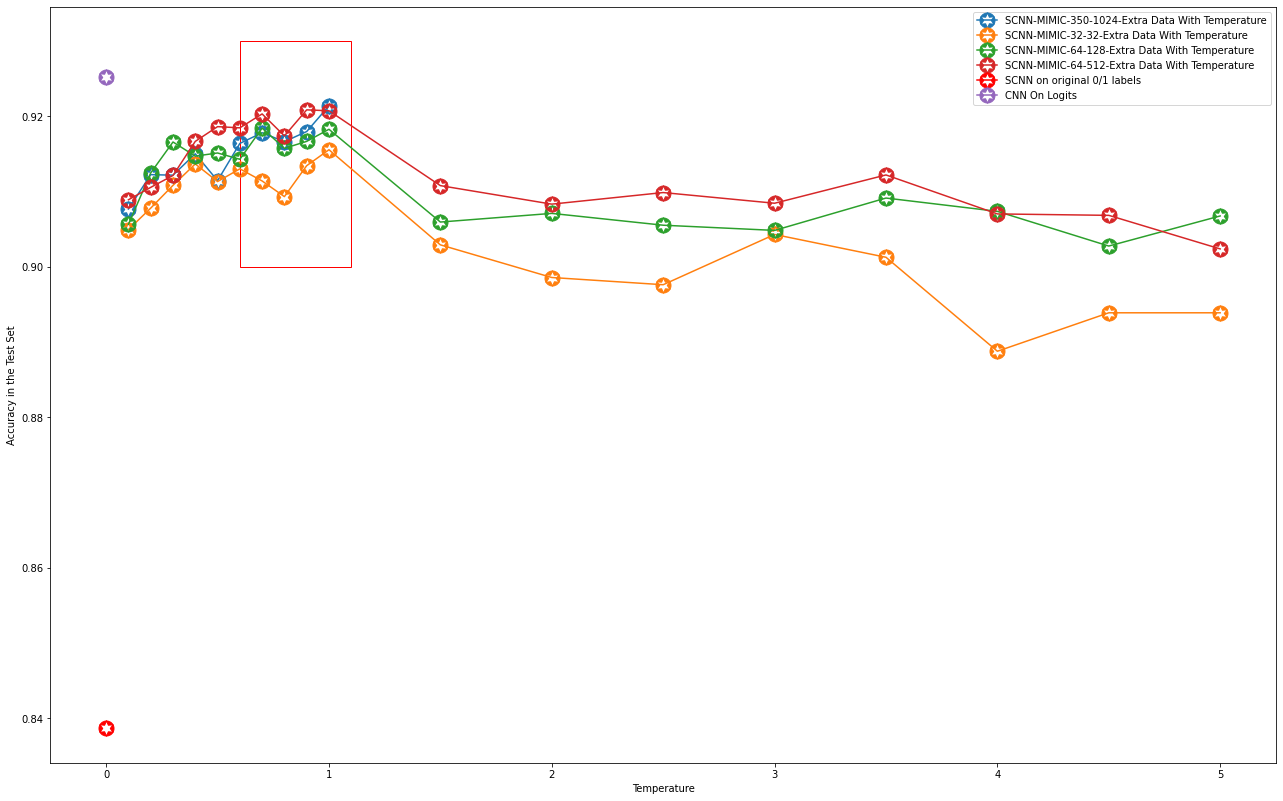

In [ ]:
import matplotlib.path as mpath
import numpy as np
import matplotlib.patches as patches
rect = patches.Rectangle( (0.6, 0.90), 0.5, 0.03, linewidth=1, edgecolor='r', facecolor='none')


star = mpath.Path.unit_regular_star(6)
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
verts = np.concatenate([circle.vertices, star.vertices[::-1, ...]])
codes = np.concatenate([circle.codes, star.codes])
cut_star = mpath.Path(verts, codes)

fig = plt.figure()
ax = fig.add_axes([0,0,0.92,1])
ax.add_patch(rect)
fig.set_size_inches(18.5, 10.5)

plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], [0.90769,0.91226,0.91219,0.91503,0.91146,0.91641,0.91783,0.91664,0.91799,0.92140], label='SCNN-MIMIC-350-1024-Extra Data With Temperature', marker=cut_star, markersize=15)

plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0], [0.90496, 0.90781, 0.91084, 0.91368, 0.91134, 0.91303, 0.91142, 0.90934, 0.91345, 0.91557,0.90293, 0.89859, 0.89763, 0.90431, 0.90128, 0.88879, 0.89390, 0.89390], label='SCNN-MIMIC-32-32-Extra Data With Temperature', marker=cut_star, markersize=15)
plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0], [0.90565, 0.91249, 0.91660,0.91472,0.91514,0.91430,0.91845,0.91576,0.91668,0.91829,0.90596, 0.90711, 0.90554, 0.90485, 0.90915, 0.90738, 0.90277, 0.90677], label='SCNN-MIMIC-64-128-Extra Data With Temperature', marker=cut_star, markersize=15)
plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0], [0.90892, 0.91057,0.91215, 0.91668,0.91864,0.91848,0.92033,0.91741,0.92087,0.92075,0.91080, 0.90834, 0.90988, 0.90846, 0.91222, 0.90704, 0.90685, 0.90239], label='SCNN-MIMIC-64-512-Extra Data With Temperature', marker=cut_star, markersize=15)

plt.plot(0, 0.83866, marker=cut_star, markersize=15, color="red" ,label='SCNN on original 0/1 labels')
plt.plot(0, 0.92528, marker=cut_star, markersize=15, label='CNN On Logits')

plt.xlabel('Temperature');
plt.ylabel('Accuracy in the Test Set');
plt.legend()
plt.show()

## Filter Pruning

In [ ]:
# Load the model
svhn_model = get_CNN_model()
svhn_model = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/SVHN/SCNN_MIMIC_SVHN_h64_128_1.5.h5')
svhn_model.summary()

In [ ]:
# Evaluate CNN Test Set
svhn_model = get_CNN_model()
svhn_model = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/SVHN/SCNN_MIMIC_SVHN_h64_128_1.5.h5')
score, acc = svhn_model.evaluate(x_acc_test_cnn, y_acc_test, batch_size=128)
print ("Test Accuracy: %.5f" % acc)

In [ ]:
# Evaluate CNN Validation Set
svhn_model = get_CNN_model()
svhn_model = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/SVHN/SCNN_MIMIC_SVHN_h64_128_1.5.h5')
score, acc = svhn_model.evaluate(x_test_cnn, y_test, batch_size=128)
print ("Test Validation: %.5f" % acc)

In [ ]:
import matplotlib.pyplot as plt

svhn_model = get_CNN_model()
svhn_model = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/SVHN/SCNN_MIMIC_SVHN_h64_128_1.5.h5')

w1 = svhn_model.layers[0].get_weights()[0]
w2 = svhn_model.layers[2].get_weights()[0]

conv_layers_weights = [w1,w2]

for i in range(len(conv_layers_weights)):
  weight = conv_layers_weights[i]
  weights_dict = {}
  num_filters = len(weight[0,0,0,:])

  for j in range(num_filters):
    w_s = np.sum(abs(weight[:,:,:,j]))
    filt = 'filt_{}'.format(j)
    weights_dict[filt] = w_s

  weights_dict_sort = sorted(weights_dict.items(), key=lambda kv: kv[1])
  print ('L1 norm conv layer {} \n'.format(i+1), weights_dict_sort)

  weights_value = []
  for elem in weights_dict_sort:
    weights_value.append(elem[1])

  xc = range (num_filters)

  plt.figure(i+1, figsize=(7,5))
  plt.plot(xc, weights_value)
  plt.xlabel('filter_num')
  plt.ylabel('l1 norm')
  plt.title('conv layer {}'.format(i+1))
  plt.grid(True)

In [ ]:
!pip install kerassurgeon

In [ ]:
from kerassurgeon import identify
from kerassurgeon.operations import delete_channels, delete_layer

svhn_model = get_CNN_model()
svhn_model = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/SVHN/SCNN_MIMIC_SVHN_h64_128_1.5.h5')

layer_1 = svhn_model.layers[0]
layer_2 = svhn_model.layers[2]

list_of_channels_to_remove_l2 = [57, 107, 86, 46, 64, 65,54, 51, 97, 72, 
                              104, 34, 94, 60, 17, 74,70, 69, 73, 30, 99, 88, 58, 9, 
                              49, 108, 59, 83, 25, 123, 103,119,106,75, 41,93, 125, 15, 5, 0,52,39, 
                              62, 44, 115, 121]
 
list_of_channels_to_remove_l1 = [11, 21, 8, 47, 14, 6, 40, 62, 4, 3, 51, 22, 13,
                                 28, 36, 1, 54, 63, 34, 20, 61, 53, 24,
                                 60, 39, 44, 26]

model_new = delete_channels(svhn_model, layer_2, list_of_channels_to_remove_l2)
model_new = delete_channels(model_new, layer_1, list_of_channels_to_remove_l1)

model_new.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_new.save('SCNN-MIMIC-SVHN-h64-128_1.5_new')

model_new.summary()

score, acc = model_new.evaluate(x_test_cnn, y_test, batch_size=128)
print ("Test Validation: %.5f" % acc)

In [ ]:
score, acc = model_new.evaluate(x_acc_test_cnn, y_acc_test, batch_size=128)
print ("Test Validation: %.5f" % acc)